In [1]:
import cdsapi
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from datetime import datetime
from data_processing import *
import os
import warnings; warnings.simplefilter('ignore')

In [2]:
#data_2016 = prepare_data2(min_wind = 30, min_steps= 20, max_steps=60, one_hot = False, secondary = False)

In [3]:
c = cdsapi.Client()

#Example of an API request
c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            'relative_humidity', 'temperature', 'u_component_of_wind',
            'v_component_of_wind', 'vorticity', 'geopotential'
        ],
        'pressure_level': [
            '700', '1000',
        ],
        'year': '1996',
        'month': '04',
        'day': ['06'],
        'area'          : [21.92801, 127.78100000000002, -2.12, 151.82100000000003], # North, West, South, East. Default: global
        'grid'          : [1.0, 1.0], # Latitude/longitude grid: east-west (longitude) and north-south resolution (latitude). Default: 0.25 x 0.25
        'time': [
            '18:00'
        ],
        'format': 'netcdf',
    },
    'test4.nc') #here specify filepath

2020-04-10 09:33:54,365 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:33:54,862 INFO Request is completed
2020-04-10 09:33:54,864 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data9/adaptor.mars.internal-1586467096.351193-21212-29-d91f2791-a4c4-4e34-b672-d20987b5c46e.nc to test4.nc (17.5K)
2020-04-10 09:33:55,175 INFO Download rate 56.5K/s


Result(content_length=17916,content_type=application/x-netcdf,location=http://136.156.133.39/cache-compute-0012/cache/data9/adaptor.mars.internal-1586467096.351193-21212-29-d91f2791-a4c4-4e34-b672-d20987b5c46e.nc)

In [4]:
#here example to process file from netcdf format to np.array
#nc_file = 'data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_10_5_18_coord_25.1_-63.3.nc'
nc_file = 'test4.nc'
nc = netCDF4.Dataset(nc_file, mode='r')

nc.variables.keys()

lat = nc.variables['latitude'][:]
lat = np.array(lat)
lon = nc.variables['longitude'][:]
lon = np.array(lon)

time_var = nc.variables['time']
p = nc.variables['z']
dtime = netCDF4.num2date(time_var[:],time_var.units)
grid = nc.variables['u'][:]

grid = np.array(grid).squeeze(0)#reshape(grid.shape[1],grid.shape[2], grid.shape[3])

In [5]:
lat

array([21.88, 20.88, 19.88, 18.88, 17.88, 16.88, 15.88, 14.88, 13.88,
       12.88, 11.88, 10.88,  9.88,  8.88,  7.88,  6.88,  5.88,  4.88,
        3.88,  2.88,  1.88,  0.88, -0.12, -1.12, -2.12], dtype=float32)

In [6]:
grid.shape

(2, 25, 25)

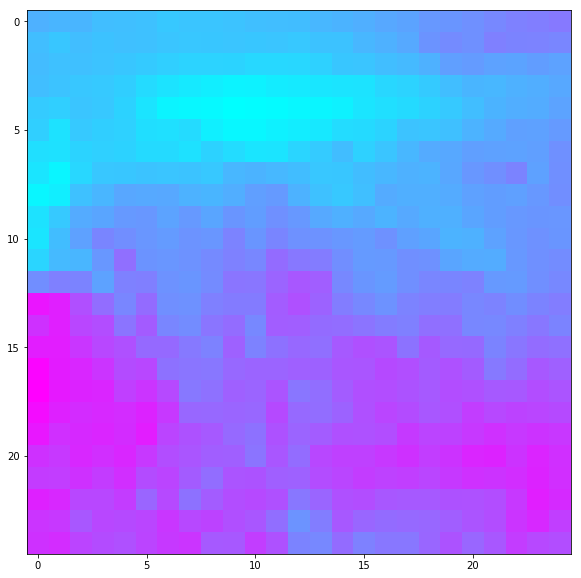

In [7]:
#Example of a plot, colors are artificial
plt.figure(figsize=(10,10))
plt.imshow(grid[1], cmap ='cool')
#plt.xticks(lon)
#plt.yticks(lat)
plt.show()

# Actual code to use

In [8]:
def process_netcdf(filepath, param):
    '''
    input: netcdf filepath and the specific corresponding parameter in str format (eg. 'z', 'u', 'v'...) 
    '''
    nc = netCDF4.Dataset(filepath, mode='r')
    nc.variables.keys()
    lat = nc.variables['latitude'][:]
    lon = nc.variables['longitude'][:]
    time_var = nc.variables['time']
    dtime = netCDF4.num2date(time_var[:],time_var.units)
    grid = nc.variables[param][:]
    #transform into np.array format and reshape something in (1,grid_size,grid_size) into (grid_size,grid_size)
    grid = np.array(grid).reshape(grid.shape[1],grid.shape[2], grid.shape[3])    
    return grid

In [9]:
#a = process_netcdf('data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_10_5_18_coord_25.1_-63.3.nc', 'u')

In [10]:
def get_storms(extraction = False, min_wind = 30, min_steps= 20, max_steps=60, path = "ibtracs.since1980.list.v04r00.csv"):
    '''
    returns an array of elements of type [datetime, lat, lon]
    set extraction to True if used for downloading data and False if used to convert netcdf files to tensor
    '''
    data = prepare_data2(path = path, min_wind = min_wind, min_steps= min_steps, max_steps=max_steps, one_hot = False, secondary = False)
    e = data.transpose((2,0,1))
    d = e.reshape(e.shape[0]*e.shape[1],3)
    for t in d:
        try:
            t[0] = datetime.strptime(t[0], "%Y-%m-%d %H:%M:%S")
        except:
            pass
    if extraction :
        f = d.reshape(e.shape[0],e.shape[1],3)
        return f
    return d

In [11]:
def get_timestep_vision(time, lat, lon):
    '''
    given a datetime and latitute, longitude returns a processed array obtained after donwload
    '''
    filepath = get_filename(['700', '500', '225'], ['geopotential', 'u_component_of_wind', 'v_component_of_wind'], time, lat, lon)
    u, v, z = process_netcdf(filepath, 'u'), process_netcdf(filepath, 'v'), process_netcdf(filepath, 'z')
    return np.array([u, v, z])

In [12]:
bad_shapes = []
times, lati, long = [], [], []
def get_storm_vision(storm, epsilon = 0):
    '''
    given a storm (list of timesteps with time and lat/lon), returns the vision array
    epsilon is a parameter in case there is a scenario whith not correct grid size
    '''
    l = np.zeros((len(storm), 3, 3, 25, 25))
    
    for i in range(len(storm)):
        time, lat, lon = storm[i]
        try :
            l[i]=get_timestep_vision(time, lat, lon)
        except:
            try :
                b = get_timestep_vision(time, lat, lon)
                print(b.shape)
                print(time, lat, lon)
                get_data(['700', '500', '225'], ['geopotential', 'u_component_of_wind', 'v_component_of_wind'], time, lat, lon, grid_size = 25, force = True, epsilon = epsilon)
                times.append(time)
                lati.append(lat)
                long.append(lon)
                bad_shapes.append(b)
            except:
                pass
    return l

In [13]:
def extract_vision(data, epsilon):
    '''
    processes all the data to get the vision array
    '''
    
    vision = []
    for storm in data:
        vision.append(get_storm_vision(storm, epsilon))
    return np.array(vision)

In [14]:
def get_filename(pressure, params, time, lat, lon):
    '''
    returns filename to save the netcdf file
    '''
    params_str = '_'.join(map(str, params))
    pressure_str = '_'.join(map(str, pressure))
    year, month, day, hour = str(time.year), str(time.month), str(time.day), str(time.hour)
    return 'data_era/'+params_str+'/eradata_'+pressure_str+'hPa'+'_'+year+'_'+month+'_'+day+'_'+hour+'_'+'coord'+'_'+str(lat)+'_'+str(lon)+'.nc'

In [15]:
#get_data(['700', '500', '225'], ['geopotential', 'u_component_of_wind', 'v_component_of_wind'], times[0], lati[0], long[0], grid_size = 25)

In [16]:
def get_area(lat, lon, grid_size, e = 0.008):
    '''
    input : center of the storm, 
    output: returns a centered squared grid of size grid_size degrees
    '''
    val = grid_size // 2
    return [lat + val + e, lon - val, lat - val - e, lon + val]

In [17]:
def get_data(pressure_level, params, time, lat, lon, grid_size = 25, degbypix = 1.0, force = False, epsilon = 0.008):
    '''
    pressure_level is the the pressure level we wish to get the data.
    params has to be in format e.g: 'geopotential' or 'u_component_of_wind' or 'v_component_of_wind'
    grid_size should be odd
    '''
    if not os.path.exists(get_filename(pressure_level, params, time, lat, lon)) or force:
        c = cdsapi.Client()
        year, month, day, hour = str(time.year), str(time.month), str(time.day), str(time.hour)
    
        c.retrieve('reanalysis-era5-pressure-levels', {
            'variable'      : params,
            'pressure_level': pressure_level,
            'product_type'  : 'reanalysis',
            'year'          : year,
            'month'         : month,
            'day'           : day,
            'area'          : get_area(lat, lon, grid_size, epsilon), # North, West, South, East. Default: global
            'grid'          : [degbypix, degbypix], # Latitude/longitude grid: east-west (longitude) and north-south resolution (latitude). Default: 0.25 x 0.25
            'time'          : hour,
            'format'        : 'netcdf' # Supported format: grib and netcdf. Default: grib
        }, get_filename(pressure_level, params, time, lat, lon))
    else:
        print("Already downloaded", get_filename(pressure_level, params, time, lat, lon))

In [18]:
#Example
#get_data('700', 'u_component_of_wind', datetime.now(), 55.4467, 177.3241, 11)

In [19]:
def download_all(data):
    for storm in data:
        time, lat, lon = storm[0], storm[1], storm[2]
        get_data(['700', '500', '225'], 'geopotential', time, lat, lon, grid_size = 25)
        get_data(['700', '500', '225'], 'u_component_of_wind', time, lat, lon, grid_size = 25)
        get_data(['700', '500', '225'], 'v_component_of_wind', time, lat, lon, grid_size = 25)
        #get_data('700', 'vorticity', time, lat, lon, grid_size = 11, degbypix=1.0)
        #get_data('1000', 'relative_humidity', time, lat, lon, grid_size = 11, degbypix=1.0)
    print("Download complete.")

In [20]:
def download_all2(data):
    i = 0
    for storm in data:
        for t in storm:
            time, lat, lon = t[0], t[1], t[2]
            try:
                get_data(['700', '500', '225'], ['geopotential', 'u_component_of_wind', 'v_component_of_wind'], time, lat, lon, grid_size = 25)
            except:
                print("False request.")
        i+=1
        print("Storm ", i, " completed.")
    print("Download complete.")

In [ ]:
data = get_storms(extraction=True, min_wind = 50, min_steps= 30, max_steps=60)

The dictionary of storms has been created.
The trajectories have now been padded.
There are 1096 storms with 9 features, and maximum number of steps is 60 and minimum is 60.
The tensor has now been created.


In [ ]:
download_all2(data)

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_1_6_0_coord_-15.0667_119.23299999999999.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_1_6_3_coord_-15.0481_119.01.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_1_6_6_coord_-15.0076_118.773.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_1_6_9_coord_-14.9683_118.57.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_1_6_12_coord_-14.9333_118.43299999999999.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_1_6_15_coord_-14.904_118.40299999999999.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_1_6_18_coord_

2020-04-10 09:35:14,463 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:35:15,236 INFO Request is queued
2020-04-10 09:35:16,343 INFO Request is running
2020-04-10 09:35:20,298 INFO Request is completed
2020-04-10 09:35:20,300 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data7/adaptor.mars.internal-1586525715.5457928-31716-15-369474ab-0ee7-4c40-83c6-dcdabc2a0243.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_7_19_0_coord_14.6333_133.183.nc (13K)
2020-04-10 09:35:20,590 INFO Download rate 45K/s
2020-04-10 09:35:20,802 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:35:22,660 INFO Request is queued
2020-04-10 09:35:23,760 INFO Request is running
2020-04-10 09:35:27,724 INFO Request is completed
2020-04-10 09:35:27,727 INFO Downloading http://136.156.133.46/cache-compute-0015/ca

2020-04-10 09:36:48,877 INFO Download rate 47.2K/s
2020-04-10 09:36:48,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:36:49,824 INFO Request is queued
2020-04-10 09:36:50,927 INFO Request is running
2020-04-10 09:36:54,879 INFO Request is completed
2020-04-10 09:36:54,881 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data9/adaptor.mars.internal-1586525810.5183136-30400-35-7e0ce81c-fbff-484e-aa37-22a2c47d6df3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_7_20_15_coord_16.7358_122.95700000000001.nc (13K)
2020-04-10 09:36:55,165 INFO Download rate 46K/s
2020-04-10 09:36:55,317 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:36:55,784 INFO Request is queued
2020-04-10 09:36:56,892 INFO Request is running
2020-04-10 09:37:00,846 INFO Request is completed
2020-04-10 09:37:00,

2020-04-10 09:38:08,862 INFO Download rate 25.7K/s  
2020-04-10 09:38:09,042 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:38:10,245 INFO Request is queued
2020-04-10 09:38:11,348 INFO Request is running
2020-04-10 09:38:15,307 INFO Request is completed
2020-04-10 09:38:15,309 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data3/adaptor.mars.internal-1586525890.3144162-23575-37-202f875a-03e5-4a70-b53b-051b4fd8b0eb.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_7_22_6_coord_19.8688_112.05799999999999.nc (13K)
2020-04-10 09:38:15,603 INFO Download rate 44.3K/s
2020-04-10 09:38:15,723 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:38:16,218 INFO Request is queued
2020-04-10 09:38:17,321 INFO Request is running
2020-04-10 09:38:21,271 INFO Request is completed
2020-04-10 09:38:

2020-04-10 09:39:28,121 INFO Download rate 43.4K/s
2020-04-10 09:39:28,236 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:39:28,704 INFO Request is queued
2020-04-10 09:39:29,817 INFO Request is running
2020-04-10 09:39:33,770 INFO Request is completed
2020-04-10 09:39:33,773 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data7/adaptor.mars.internal-1586525968.937655-16293-37-13a6512c-f074-4a7f-abd3-800ee538a5de.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_7_23_21_coord_20.6992_101.38799999999999.nc (13K)
2020-04-10 09:39:34,060 INFO Download rate 45.6K/s
2020-04-10 09:39:34,429 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:39:34,933 INFO Request is queued
2020-04-10 09:39:36,036 INFO Request is running
2020-04-10 09:39:39,993 INFO Request is completed
2020-04-10 09:39:39

Storm  5  completed.
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_3_22_12_coord_-17.1333_115.46700000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_3_22_15_coord_-17.1532_114.336.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_3_22_18_coord_-17.1333_113.167.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_3_22_21_coord_-17.1076_111.993.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_3_23_0_coord_-17.0231_110.86200000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_3_23_3_coord_-16.8982_109.92.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hP

2020-04-10 09:39:40,876 INFO Request is queued
2020-04-10 09:39:41,978 INFO Request is running
2020-04-10 09:39:45,945 INFO Request is completed
2020-04-10 09:39:45,949 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data5/adaptor.mars.internal-1586525981.056406-13330-13-0b4eb1e6-e5b0-4691-b645-a2e2a9bb473e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_7_22_18_coord_12.2678_132.233.nc (13K)
2020-04-10 09:39:46,236 INFO Download rate 45.4K/s
2020-04-10 09:39:46,485 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:39:46,937 INFO Request is queued
2020-04-10 09:39:48,048 INFO Request is running
2020-04-10 09:39:52,014 INFO Request is completed
2020-04-10 09:39:52,016 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586525987.143992-25486-39-17865889-1a3a-4615-9532-29857b8ab8d0.nc to data_era/geopotential_u_co

2020-04-10 09:40:59,369 INFO Download rate 46.7K/s
2020-04-10 09:40:59,530 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:41:00,194 INFO Request is queued
2020-04-10 09:41:01,295 INFO Request is running
2020-04-10 09:41:05,247 INFO Request is completed
2020-04-10 09:41:05,249 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data3/adaptor.mars.internal-1586526060.186084-28769-23-d6a8bde9-3f29-44ff-baa3-d117e7cebab0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_7_24_9_coord_15.1485_124.944.nc (13K)
2020-04-10 09:41:05,527 INFO Download rate 46.9K/s
2020-04-10 09:41:05,645 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:41:06,147 INFO Request is queued
2020-04-10 09:41:07,251 INFO Request is running
2020-04-10 09:41:11,203 INFO Request is completed
2020-04-10 09:41:11,204 INFO Do

2020-04-10 09:42:17,879 INFO Download rate 45.9K/s
2020-04-10 09:42:18,347 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:42:18,785 INFO Request is queued
2020-04-10 09:42:19,888 INFO Request is running
2020-04-10 09:42:23,846 INFO Request is completed
2020-04-10 09:42:23,848 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data6/adaptor.mars.internal-1586526139.1282256-31306-31-09ac666a-22b1-44e7-bda6-5082e9aa16d5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_7_26_0_coord_19.1833_118.68299999999999.nc (13K)
2020-04-10 09:42:24,127 INFO Download rate 46.9K/s
2020-04-10 09:42:24,262 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:42:24,730 INFO Request is queued
2020-04-10 09:42:25,835 INFO Request is running
2020-04-10 09:42:29,791 INFO Request is completed
2020-04-10 09:42:29

2020-04-10 09:43:38,412 INFO Download rate 45.5K/s
2020-04-10 09:43:38,536 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:43:39,003 INFO Request is queued
2020-04-10 09:43:40,106 INFO Request is running
2020-04-10 09:43:44,062 INFO Request is completed
2020-04-10 09:43:44,064 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data9/adaptor.mars.internal-1586526219.0552654-26185-37-f103bbf1-49fe-4b28-b93f-3984cde4b663.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_7_27_15_coord_24.0475_115.29299999999999.nc (13K)
2020-04-10 09:43:44,345 INFO Download rate 46.6K/s
2020-04-10 09:43:44,480 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:43:44,966 INFO Request is queued
2020-04-10 09:43:46,069 INFO Request is running
2020-04-10 09:43:50,027 INFO Request is completed
2020-04-10 09:43:5

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  10  completed.


2020-04-10 09:43:51,482 INFO Request is queued
2020-04-10 09:43:52,588 INFO Request is running
2020-04-10 09:43:56,538 INFO Request is completed
2020-04-10 09:43:56,540 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data0/adaptor.mars.internal-1586526231.703667-26663-35-a3739af2-67ff-4c6b-b522-0b4a77874273.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_7_30_3_coord_25.1671_149.414.nc (13K)
2020-04-10 09:43:56,826 INFO Download rate 45.7K/s
2020-04-10 09:43:57,183 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:43:57,709 INFO Request is queued
2020-04-10 09:43:58,808 INFO Request is running
2020-04-10 09:44:02,762 INFO Request is completed
2020-04-10 09:44:02,764 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data2/adaptor.mars.internal-1586526237.7600927-25594-11-a4b2e5fc-efbf-465d-a345-68dcafbadcc4.nc to data_era/geopotential_u_co

2020-04-10 09:45:10,428 INFO Download rate 47.5K/s
2020-04-10 09:45:10,922 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:45:11,859 INFO Request is queued
2020-04-10 09:45:12,963 INFO Request is running
2020-04-10 09:45:16,920 INFO Request is completed
2020-04-10 09:45:16,922 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data9/adaptor.mars.internal-1586526312.214437-23384-19-fd6ed032-fdf2-4de0-a656-a627e282ccab.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_7_31_18_coord_24.7274_147.189.nc (13K)
2020-04-10 09:45:17,203 INFO Download rate 46.7K/s
2020-04-10 09:45:17,517 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:45:18,014 INFO Request is queued
2020-04-10 09:45:19,145 INFO Request is running
2020-04-10 09:45:23,104 INFO Request is completed
2020-04-10 09:45:23,107 INFO D

2020-04-10 09:46:34,386 INFO Download rate 47.1K/s
2020-04-10 09:46:34,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:46:34,979 INFO Request is queued
2020-04-10 09:46:36,087 INFO Request is running
2020-04-10 09:46:40,052 INFO Request is completed
2020-04-10 09:46:40,054 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data6/adaptor.mars.internal-1586526395.1176407-25560-15-dd18f08f-1961-4e4c-9141-05910502974e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_2_9_coord_24.0693_144.457.nc (13K)
2020-04-10 09:46:40,336 INFO Download rate 46.4K/s
2020-04-10 09:46:40,990 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:46:41,419 INFO Request is queued
2020-04-10 09:46:42,525 INFO Request is running
2020-04-10 09:46:46,491 INFO Request is completed
2020-04-10 09:46:46,494 INFO Dow

2020-04-10 09:47:58,281 INFO Download rate 45.8K/s
2020-04-10 09:47:58,467 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:47:59,240 INFO Request is queued
2020-04-10 09:48:00,350 INFO Request is running
2020-04-10 09:48:04,313 INFO Request is completed
2020-04-10 09:48:04,316 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data3/adaptor.mars.internal-1586526479.260867-11237-11-049c62e9-0fe2-4e31-8a05-da1a633379c7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_4_0_coord_27.9333_144.533.nc (13K)
2020-04-10 09:48:04,590 INFO Download rate 47.6K/s
2020-04-10 09:48:04,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:48:05,242 INFO Request is queued
2020-04-10 09:48:06,348 INFO Request is running
2020-04-10 09:48:10,300 INFO Request is completed
2020-04-10 09:48:10,302 INFO Dow

2020-04-10 09:49:21,563 INFO Download rate 45.1K/s
2020-04-10 09:49:21,760 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:49:22,209 INFO Request is queued
2020-04-10 09:49:23,309 INFO Request is running
2020-04-10 09:49:27,265 INFO Request is completed
2020-04-10 09:49:27,268 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data3/adaptor.mars.internal-1586526562.2570553-20484-25-c22b7878-402f-4ac2-aa99-a51976c4ee69.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_5_15_coord_31.2619_148.164.nc (13K)
2020-04-10 09:49:27,548 INFO Download rate 46.7K/s
2020-04-10 09:49:27,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:49:28,283 INFO Request is queued
2020-04-10 09:49:29,389 INFO Request is running
2020-04-10 09:49:33,347 INFO Request is completed
2020-04-10 09:49:33,351 INFO Do

Storm  11  completed.


2020-04-10 09:50:11,174 INFO Request is queued
2020-04-10 09:50:12,276 INFO Request is running
2020-04-10 09:50:16,234 INFO Request is completed
2020-04-10 09:50:16,236 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data7/adaptor.mars.internal-1586526611.3134027-11028-13-09f20f9c-d57f-4fed-8eec-c7bd4d40e952.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_1_0_coord_11.3_-106.8.nc (13K)
2020-04-10 09:50:16,520 INFO Download rate 46.2K/s
2020-04-10 09:50:16,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:50:17,142 INFO Request is queued
2020-04-10 09:50:18,241 INFO Request is running
2020-04-10 09:50:22,204 INFO Request is completed
2020-04-10 09:50:22,208 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586526617.1568687-28985-11-5c8d2dbe-7b42-45c5-9420-b0c32b871335.nc to data_era/geopotential_u_compon

2020-04-10 09:51:35,279 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:51:35,738 INFO Request is queued
2020-04-10 09:51:36,838 INFO Request is running
2020-04-10 09:51:40,787 INFO Request is completed
2020-04-10 09:51:40,789 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data8/adaptor.mars.internal-1586526695.8092384-10637-19-43aab5c0-bf07-4c50-8347-349f5597c3ad.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_2_15_coord_14.1881_-113.62299999999999.nc (13K)
2020-04-10 09:51:41,067 INFO Download rate 47K/s
2020-04-10 09:51:41,242 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:51:42,048 INFO Request is queued
2020-04-10 09:51:43,148 INFO Request is running
2020-04-10 09:51:47,112 INFO Request is completed
2020-04-10 09:51:47,114 INFO Downloading http://136.156.133.37/cache-co

2020-04-10 09:52:54,832 INFO Download rate 44.7K/s
2020-04-10 09:52:54,961 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:52:55,461 INFO Request is queued
2020-04-10 09:52:56,564 INFO Request is running
2020-04-10 09:53:00,518 INFO Request is completed
2020-04-10 09:53:00,520 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data2/adaptor.mars.internal-1586526776.02065-7895-1-f8dfc5aa-a298-4ad6-a37a-5a34c00ded91.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_4_6_coord_18.6085_-116.73700000000001.nc (13K)
2020-04-10 09:53:00,801 INFO Download rate 46.5K/s
2020-04-10 09:53:00,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:53:01,601 INFO Request is queued
2020-04-10 09:53:02,706 INFO Request is running
2020-04-10 09:53:06,670 INFO Request is completed
2020-04-10 09:53:06,672

2020-04-10 09:54:15,395 INFO Download rate 46.1K/s
2020-04-10 09:54:15,536 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:54:16,255 INFO Request is queued
2020-04-10 09:54:17,362 INFO Request is running
2020-04-10 09:54:21,315 INFO Request is completed
2020-04-10 09:54:21,317 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data2/adaptor.mars.internal-1586526856.334841-24164-21-aa473e3d-cdd2-414f-b6c8-72ec763042bf.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_5_21_coord_22.0321_-119.463.nc (13K)
2020-04-10 09:54:21,595 INFO Download rate 47K/s
2020-04-10 09:54:21,724 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:54:22,274 INFO Request is queued
2020-04-10 09:54:23,384 INFO Request is running
2020-04-10 09:54:27,340 INFO Request is completed
2020-04-10 09:54:27,342 INFO Down

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  12  completed.


2020-04-10 09:55:33,440 INFO Request is queued
2020-04-10 09:55:34,545 INFO Request is running
2020-04-10 09:55:38,500 INFO Request is completed
2020-04-10 09:55:38,503 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data9/adaptor.mars.internal-1586526933.5037603-14838-31-7c27ff3b-844a-431c-817c-faa24796d901.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_2_9_coord_11.6496_-45.835.nc (13K)
2020-04-10 09:55:38,790 INFO Download rate 45.6K/s
2020-04-10 09:55:39,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:55:40,160 INFO Request is queued
2020-04-10 09:55:41,269 INFO Request is running
2020-04-10 09:55:45,227 INFO Request is completed
2020-04-10 09:55:45,229 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data2/adaptor.mars.internal-1586526940.242822-8655-1-52f572c3-6c82-4b79-92a6-ccdbd43b60a5.nc to data_era/geopotential_u_compo

2020-04-10 09:56:53,924 INFO Request is queued
2020-04-10 09:56:55,024 INFO Request is running
2020-04-10 09:56:58,974 INFO Request is completed
2020-04-10 09:56:58,976 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data5/adaptor.mars.internal-1586527014.0709977-752-3-16554f6d-a621-40da-81be-84a3c1a800a2.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_4_0_coord_13.3_-59.1.nc (13K)
2020-04-10 09:56:59,250 INFO Download rate 47.8K/s
2020-04-10 09:56:59,414 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:56:59,905 INFO Request is queued
2020-04-10 09:57:01,013 INFO Request is running
2020-04-10 09:57:04,971 INFO Request is completed
2020-04-10 09:57:04,973 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data4/adaptor.mars.internal-1586527020.3861253-9720-31-d0eed842-ae09-4e84-94c5-94c895b10083.nc to data_era/geopotential_u_component_

2020-04-10 09:58:15,904 INFO Request is queued
2020-04-10 09:58:18,607 INFO Request is running
2020-04-10 09:58:20,967 INFO Request is completed
2020-04-10 09:58:20,970 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586527097.1407526-30185-17-51d33083-0d1e-40ee-9f6c-5ed81b55562c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_5_15_coord_16.1398_-71.4307.nc (13K)
2020-04-10 09:58:21,264 INFO Download rate 44.4K/s
2020-04-10 09:58:21,397 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:58:21,876 INFO Request is queued
2020-04-10 09:58:22,977 INFO Request is running
2020-04-10 09:58:26,930 INFO Request is completed
2020-04-10 09:58:26,933 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data3/adaptor.mars.internal-1586527101.9240851-7061-5-51e871cf-d1be-4c06-b5b8-d19616a1abaa.nc to data_era/geopotential_u_co

2020-04-10 09:59:37,122 INFO Request is queued
2020-04-10 09:59:38,219 INFO Request is running
2020-04-10 09:59:42,172 INFO Request is completed
2020-04-10 09:59:42,174 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data0/adaptor.mars.internal-1586527177.2060149-19218-23-440c3591-d1cf-4f42-8126-a629f150f1e9.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_7_6_coord_20.4_-83.6.nc (13K)
2020-04-10 09:59:42,453 INFO Download rate 46.7K/s
2020-04-10 09:59:42,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 09:59:43,565 INFO Request is queued
2020-04-10 09:59:44,672 INFO Request is running
2020-04-10 09:59:48,631 INFO Request is completed
2020-04-10 09:59:48,633 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data3/adaptor.mars.internal-1586527183.7112129-7096-33-02c67181-d681-4117-9165-8778614dfbac.nc to data_era/geopotential_u_componen

2020-04-10 10:01:05,124 INFO Request is queued
2020-04-10 10:01:07,833 INFO Request is running
2020-04-10 10:01:13,667 INFO Request is completed
2020-04-10 10:01:13,670 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data9/adaptor.mars.internal-1586527266.7777991-9249-37-0800195d-3d5b-4a86-914f-50e51109c303.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_8_21_coord_24.1997_-92.4076.nc (13K)
2020-04-10 10:01:13,957 INFO Download rate 45.5K/s
2020-04-10 10:01:14,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:01:15,015 INFO Request is queued
2020-04-10 10:01:16,122 INFO Request is running
2020-04-10 10:01:20,090 INFO Request is completed
2020-04-10 10:01:20,092 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586527275.59035-31054-21-898ab475-ff06-4650-a239-ef35313207e1.nc to data_era/geopotential_u_co

Storm  13  completed.


2020-04-10 10:01:58,992 INFO Request is queued
2020-04-10 10:02:00,098 INFO Request is running
2020-04-10 10:02:04,057 INFO Request is completed
2020-04-10 10:02:04,059 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586527319.183547-6081-3-28627c82-5738-4c11-b0a9-7c96729f2fc4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_9_18_coord_17.2767_155.12.nc (13K)
2020-04-10 10:02:04,342 INFO Download rate 46K/s
2020-04-10 10:02:04,642 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:02:05,301 INFO Request is queued
2020-04-10 10:02:06,407 INFO Request is running
2020-04-10 10:02:10,374 INFO Request is completed
2020-04-10 10:02:10,376 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586527325.517215-32491-11-76c02f91-2b84-4cbe-9844-9ef8024efba6.nc to data_era/geopotential_u_component

2020-04-10 10:03:21,154 INFO Download rate 44.5K/s
2020-04-10 10:03:21,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:03:22,505 INFO Request is queued
2020-04-10 10:03:23,613 INFO Request is running
2020-04-10 10:03:27,572 INFO Request is completed
2020-04-10 10:03:27,574 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1586527402.7179706-18513-23-d98edaf8-5b02-43c5-9b02-b291e4461b2a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_11_9_coord_26.0311_155.733.nc (13K)
2020-04-10 10:03:27,864 INFO Download rate 45K/s
2020-04-10 10:03:28,141 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:03:28,624 INFO Request is queued
2020-04-10 10:03:29,724 INFO Request is running
2020-04-10 10:03:33,681 INFO Request is completed
2020-04-10 10:03:33,683 INFO Down

2020-04-10 10:04:52,813 INFO Download rate 43.1K/s
2020-04-10 10:04:54,025 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:04:55,586 INFO Request is queued
2020-04-10 10:04:56,689 INFO Request is running
2020-04-10 10:05:04,116 INFO Request is completed
2020-04-10 10:05:04,118 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data8/adaptor.mars.internal-1586527496.6029918-31731-33-bb5068e1-324a-4a0b-85aa-405db3620e0d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_13_0_coord_30.9833_156.083.nc (13K)
2020-04-10 10:05:04,400 INFO Download rate 46.4K/s
2020-04-10 10:05:04,918 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:05:05,594 INFO Request is queued
2020-04-10 10:05:06,696 INFO Request is running
2020-04-10 10:05:10,654 INFO Request is completed
2020-04-10 10:05:10,655 INFO Do

2020-04-10 10:06:47,342 INFO Download rate 45K/s
2020-04-10 10:06:47,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:06:48,100 INFO Request is queued
2020-04-10 10:06:49,202 INFO Request is running
2020-04-10 10:06:53,156 INFO Request is completed
2020-04-10 10:06:53,158 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1586527608.243789-4631-1-d074e920-fe86-47cf-a5bc-3371feba5eba.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_14_15_coord_33.297_161.445.nc (13K)
2020-04-10 10:06:53,438 INFO Download rate 46.6K/s
2020-04-10 10:06:53,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:06:54,165 INFO Request is queued
2020-04-10 10:06:55,268 INFO Request is running
2020-04-10 10:06:59,219 INFO Request is completed
2020-04-10 10:06:59,221 INFO Downloa

2020-04-10 10:08:15,339 INFO Download rate 45.7K/s
2020-04-10 10:08:15,577 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:08:16,027 INFO Request is queued
2020-04-10 10:08:17,137 INFO Request is running
2020-04-10 10:08:21,091 INFO Request is completed
2020-04-10 10:08:21,093 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data5/adaptor.mars.internal-1586527696.1367126-19127-27-ad516bd4-a6f5-407c-a1e3-32766df211fc.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_16_6_coord_40.4143_174.243.nc (13K)
2020-04-10 10:08:21,385 INFO Download rate 44.9K/s
2020-04-10 10:08:21,494 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:08:22,026 INFO Request is queued
2020-04-10 10:08:23,133 INFO Request is running
2020-04-10 10:08:27,098 INFO Request is completed
2020-04-10 10:08:27,101 INFO Do

False request.
False request.
False request.
Storm  14  completed.


2020-04-10 10:08:46,197 INFO Request is queued
2020-04-10 10:08:47,308 INFO Request is running
2020-04-10 10:08:51,271 INFO Request is completed
2020-04-10 10:08:51,273 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data0/adaptor.mars.internal-1586527726.2416017-8085-5-f14a65de-bc47-4f57-b3ec-4a8214edd7c4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_6_12_coord_15.1_-103.6.nc (13K)
2020-04-10 10:08:51,565 INFO Download rate 44.8K/s
2020-04-10 10:08:51,685 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:08:52,227 INFO Request is queued
2020-04-10 10:08:53,332 INFO Request is running
2020-04-10 10:08:57,287 INFO Request is completed
2020-04-10 10:08:57,290 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data8/adaptor.mars.internal-1586527732.351078-17377-1-1580f84b-d518-4938-873d-a3956244aeb9.nc to data_era/geopotential_u_component

2020-04-10 10:10:12,676 INFO Download rate 48.2K/s
2020-04-10 10:10:13,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:10:14,450 INFO Request is queued
2020-04-10 10:10:15,550 INFO Request is running
2020-04-10 10:10:19,507 INFO Request is completed
2020-04-10 10:10:19,509 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data7/adaptor.mars.internal-1586527814.755309-29387-23-59a46424-c501-4d24-a658-208c49566bbc.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_8_3_coord_18.5845_-107.988.nc (13K)
2020-04-10 10:10:19,797 INFO Download rate 45.6K/s
2020-04-10 10:10:20,388 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:10:20,839 INFO Request is queued
2020-04-10 10:10:21,944 INFO Request is running
2020-04-10 10:10:25,897 INFO Request is completed
2020-04-10 10:10:25,899 INFO Do

2020-04-10 10:11:57,877 INFO Download rate 46K/s
2020-04-10 10:11:58,234 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:11:59,569 INFO Request is queued
2020-04-10 10:12:00,674 INFO Request is running
2020-04-10 10:12:04,636 INFO Request is completed
2020-04-10 10:12:04,638 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data2/adaptor.mars.internal-1586527920.6659544-13417-23-aab4bea1-5e2d-4689-ae2a-83470a72115c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_9_18_coord_20.993_-113.185.nc (13K)
2020-04-10 10:12:04,915 INFO Download rate 47.2K/s
2020-04-10 10:12:05,451 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:12:06,524 INFO Request is queued
2020-04-10 10:12:07,634 INFO Request is running
2020-04-10 10:12:15,057 INFO Request is completed
2020-04-10 10:12:15,059 INFO Dow

2020-04-10 10:13:30,263 INFO Download rate 35.6K/s  
2020-04-10 10:13:30,419 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:13:30,969 INFO Request is queued
2020-04-10 10:13:32,136 INFO Request is running
2020-04-10 10:13:36,149 INFO Request is completed
2020-04-10 10:13:36,151 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data6/adaptor.mars.internal-1586528011.1693335-25710-39-764c3df1-b819-4da2-8e53-54b6c5cfd19c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_11_9_coord_21.7984_-117.056.nc (13K)
2020-04-10 10:13:36,424 INFO Download rate 48K/s
2020-04-10 10:13:36,548 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:13:37,117 INFO Request is queued
2020-04-10 10:13:38,225 INFO Request is running
2020-04-10 10:13:42,232 INFO Request is completed
2020-04-10 10:13:42,234 INFO D

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  15  completed.


2020-04-10 10:13:43,325 INFO Request is queued
2020-04-10 10:13:44,429 INFO Request is running
2020-04-10 10:13:48,460 INFO Request is completed
2020-04-10 10:13:48,463 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data5/adaptor.mars.internal-1586528023.4294531-32312-27-3c8be2c6-e220-460a-bc71-2e2ed30625be.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_15_15_coord_19.5626_-38.2997.nc (13K)
2020-04-10 10:13:48,769 INFO Download rate 42.7K/s
2020-04-10 10:13:49,190 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:13:49,633 INFO Request is queued
2020-04-10 10:13:50,744 INFO Request is running
2020-04-10 10:13:54,721 INFO Request is completed
2020-04-10 10:13:54,723 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data8/adaptor.mars.internal-1586528030.190933-11474-17-685a6702-8f3c-4fd6-8860-93f8477b3802.nc to data_era/geopotential_u_c

2020-04-10 10:15:17,700 INFO Request is queued
2020-04-10 10:15:22,772 INFO Request is running
2020-04-10 10:15:26,260 INFO Request is completed
2020-04-10 10:15:26,262 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data3/adaptor.mars.internal-1586528120.7639303-3778-25-d0d76b37-c6cc-46b4-86b5-361a65b56eea.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_17_6_coord_28.0_-40.0.nc (13K)
2020-04-10 10:15:26,558 INFO Download rate 44.2K/s
2020-04-10 10:15:28,542 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:15:29,890 INFO Request is queued
2020-04-10 10:15:32,592 INFO Request is running
2020-04-10 10:15:38,425 INFO Request is completed
2020-04-10 10:15:38,427 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data9/adaptor.mars.internal-1586528131.1462553-27184-17-bc655cc9-462d-4017-b583-bf06db3d4657.nc to data_era/geopotential_u_compone

2020-04-10 10:17:32,449 INFO Request is queued
2020-04-10 10:17:33,552 INFO Request is running
2020-04-10 10:17:41,161 INFO Request is completed
2020-04-10 10:17:41,162 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data5/adaptor.mars.internal-1586528253.4556987-11477-15-28cc55c1-6c35-4f1a-8eb9-40c2acca72b6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_8_18_21_coord_36.9153_-40.3793.nc (13K)
2020-04-10 10:17:41,522 INFO Download rate 36.2K/s  
2020-04-10 10:17:41,716 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:17:43,599 INFO Request is queued
2020-04-10 10:17:44,712 INFO Request is running
2020-04-10 10:17:52,152 INFO Request is completed
2020-04-10 10:17:52,154 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data5/adaptor.mars.internal-1586528264.2985873-25025-3-0e8f1095-0bcf-41ba-8cf8-6ce47958ad31.nc to data_era/geopotential_

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  16  completed.


2020-04-10 10:18:58,372 INFO Request is queued
2020-04-10 10:19:01,085 INFO Request is running
2020-04-10 10:19:06,921 INFO Request is completed
2020-04-10 10:19:06,924 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data6/adaptor.mars.internal-1586528339.9611804-7264-5-35431915-7b75-44a6-ad74-87e284b12ac0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_1_18_coord_4.9_150.8.nc (13K)
2020-04-10 10:19:07,199 INFO Download rate 47.6K/s
2020-04-10 10:19:07,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:19:10,799 INFO Request is queued
2020-04-10 10:19:15,859 INFO Request is running
2020-04-10 10:19:19,338 INFO Request is completed
2020-04-10 10:19:19,341 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data2/adaptor.mars.internal-1586528353.9339216-32312-33-94d8b7a1-ab84-4ade-a4fe-bfaf002549eb.nc to data_era/geopotential_u_component_

2020-04-10 10:21:55,614 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:21:56,893 INFO Request is queued
2020-04-10 10:21:59,607 INFO Request is running
2020-04-10 10:22:05,443 INFO Request is completed
2020-04-10 10:22:05,446 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data5/adaptor.mars.internal-1586528519.2891238-29606-13-aeb548a2-b76b-400f-ab35-abebf45fbf34.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_3_9_coord_8.26404_147.65.nc (13K)
2020-04-10 10:22:05,721 INFO Download rate 47.6K/s
2020-04-10 10:22:06,281 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:22:07,243 INFO Request is queued
2020-04-10 10:22:12,302 INFO Request is running
2020-04-10 10:22:20,955 INFO Request is completed
2020-04-10 10:22:20,957 INFO Downloading http://136.156.133.42/cache-compute-0014/ca

2020-04-10 10:23:51,687 INFO Download rate 46.2K/s
2020-04-10 10:23:52,744 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:23:53,967 INFO Request is queued
2020-04-10 10:23:56,666 INFO Request is running
2020-04-10 10:24:02,500 INFO Request is completed
2020-04-10 10:24:02,502 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data2/adaptor.mars.internal-1586528635.3843007-23495-21-0cc75c95-041e-4af2-ab06-a3e757adf76b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_5_0_coord_11.3143_143.248.nc (13K)
2020-04-10 10:24:02,780 INFO Download rate 47K/s
2020-04-10 10:24:03,129 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:24:03,752 INFO Request is queued
2020-04-10 10:24:04,867 INFO Request is running
2020-04-10 10:24:08,825 INFO Request is completed
2020-04-10 10:24:08,827 INFO Down

2020-04-10 10:25:28,716 INFO Download rate 45.4K/s
2020-04-10 10:25:29,118 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:25:29,900 INFO Request is queued
2020-04-10 10:25:31,010 INFO Request is running
2020-04-10 10:25:34,978 INFO Request is completed
2020-04-10 10:25:34,981 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data2/adaptor.mars.internal-1586528730.1225913-27359-29-30d9566e-1924-43ca-9071-72badfb1d4a3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_6_15_coord_16.5223_143.972.nc (13K)
2020-04-10 10:25:35,264 INFO Download rate 46.2K/s
2020-04-10 10:25:35,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:25:35,981 INFO Request is queued
2020-04-10 10:25:38,689 INFO Request is running
2020-04-10 10:25:41,050 INFO Request is completed
2020-04-10 10:25:41,052 INFO Do

2020-04-10 10:26:48,861 INFO Download rate 46.6K/s
2020-04-10 10:26:48,986 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:26:49,456 INFO Request is queued
2020-04-10 10:26:50,558 INFO Request is running
2020-04-10 10:26:54,526 INFO Request is completed
2020-04-10 10:26:54,528 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data8/adaptor.mars.internal-1586528809.5426095-23612-19-f51e5e05-f5d0-471e-9dc5-b6214d195108.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_8_6_coord_20.8128_137.507.nc (13K)
2020-04-10 10:26:54,806 INFO Download rate 47.3K/s
2020-04-10 10:26:55,214 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:26:55,692 INFO Request is queued
2020-04-10 10:26:56,794 INFO Request is running
2020-04-10 10:27:00,749 INFO Request is completed
2020-04-10 10:27:00,751 INFO Do

Storm  17  completed.


2020-04-10 10:27:41,988 INFO Request is queued
2020-04-10 10:27:43,206 INFO Request is running
2020-04-10 10:27:47,286 INFO Request is completed
2020-04-10 10:27:47,288 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data3/adaptor.mars.internal-1586528861.9698834-3206-21-ae0c28cf-6ef8-4e33-8c33-d4b7d3fc1e0c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_7_9_coord_12.9575_-23.5925.nc (13K)
2020-04-10 10:27:47,565 INFO Download rate 47.1K/s
2020-04-10 10:27:47,752 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:27:48,233 INFO Request is queued
2020-04-10 10:27:49,345 INFO Request is running
2020-04-10 10:27:53,304 INFO Request is completed
2020-04-10 10:27:53,306 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data2/adaptor.mars.internal-1586528868.2696946-28503-29-fc80fed2-dbf2-4e8d-8b97-e4ae5736350d.nc to data_era/geopotential_u_co

2020-04-10 10:29:00,360 INFO Request is queued
2020-04-10 10:29:01,470 INFO Request is running
2020-04-10 10:29:05,431 INFO Request is completed
2020-04-10 10:29:05,433 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data6/adaptor.mars.internal-1586528940.4130864-26844-9-97da9f25-5869-4086-8dbf-6d8e9e673cd6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_9_0_coord_12.8_-29.8.nc (13K)
2020-04-10 10:29:05,723 INFO Download rate 45.1K/s
2020-04-10 10:29:05,878 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:29:06,353 INFO Request is queued
2020-04-10 10:29:07,457 INFO Request is running
2020-04-10 10:29:11,410 INFO Request is completed
2020-04-10 10:29:11,412 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data0/adaptor.mars.internal-1586528946.395366-19879-37-5e51141c-8298-4473-87d7-7b5912f32ba2.nc to data_era/geopotential_u_component_

2020-04-10 10:30:22,434 INFO Request is queued
2020-04-10 10:30:23,538 INFO Request is running
2020-04-10 10:30:27,495 INFO Request is completed
2020-04-10 10:30:27,497 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data6/adaptor.mars.internal-1586529022.7816179-1921-39-377f510d-c79e-48ac-91ad-fc67ae939f8a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_10_15_coord_14.5425_-34.3724.nc (13K)
2020-04-10 10:30:27,790 INFO Download rate 44.5K/s
2020-04-10 10:30:28,108 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:30:28,729 INFO Request is queued
2020-04-10 10:30:29,833 INFO Request is running
2020-04-10 10:30:33,798 INFO Request is completed
2020-04-10 10:30:33,800 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data8/adaptor.mars.internal-1586529028.8896224-11845-5-7a4124a9-2628-4427-bb39-c8d7cc872f1e.nc to data_era/geopotential_u_c

2020-04-10 10:31:47,898 INFO Download rate 45.3K/s 
2020-04-10 10:31:48,017 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:31:48,850 INFO Request is queued
2020-04-10 10:31:49,952 INFO Request is running
2020-04-10 10:31:53,933 INFO Request is completed
2020-04-10 10:31:53,936 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data2/adaptor.mars.internal-1586529108.9950535-19319-19-6b6221d4-6081-48a0-9666-6cbbef84fb22.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_12_6_coord_17.2_-36.9.nc (13K)
2020-04-10 10:31:54,242 INFO Download rate 42.9K/s
2020-04-10 10:31:54,373 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:31:54,842 INFO Request is queued
2020-04-10 10:31:55,948 INFO Request is running
2020-04-10 10:31:59,909 INFO Request is completed
2020-04-10 10:31:59,911 INFO Downlo

2020-04-10 10:33:11,033 INFO Download rate 46.3K/s
2020-04-10 10:33:11,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:33:11,604 INFO Request is queued
2020-04-10 10:33:12,713 INFO Request is running
2020-04-10 10:33:16,670 INFO Request is completed
2020-04-10 10:33:16,672 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data9/adaptor.mars.internal-1586529191.635165-6979-9-46f42cf9-b728-47e5-b5fa-08d8da582794.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_13_21_coord_19.5498_-44.065.nc (13K)
2020-04-10 10:33:16,951 INFO Download rate 46.9K/s
2020-04-10 10:33:17,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:33:17,590 INFO Request is queued
2020-04-10 10:33:18,698 INFO Request is running
2020-04-10 10:33:22,652 INFO Request is completed
2020-04-10 10:33:22,655 INFO Dow

Storm  18  completed.


2020-04-10 10:33:59,996 INFO Request is queued
2020-04-10 10:34:01,097 INFO Request is running
2020-04-10 10:34:05,056 INFO Request is completed
2020-04-10 10:34:05,058 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1586529240.1137967-15826-9-f6fbdbf3-c3e4-4fb5-b1b9-479ceb03dc8c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_15_0_coord_19.1_128.2.nc (13K)
2020-04-10 10:34:05,334 INFO Download rate 47.4K/s
2020-04-10 10:34:05,456 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:34:05,932 INFO Request is queued
2020-04-10 10:34:07,044 INFO Request is running
2020-04-10 10:34:10,998 INFO Request is completed
2020-04-10 10:34:11,001 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data2/adaptor.mars.internal-1586529246.3457656-21570-19-fe13f9ad-4456-42df-9de7-08fc6d962e56.nc to data_era/geopotential_u_compone

2020-04-10 10:35:18,693 INFO Download rate 46.7K/s
2020-04-10 10:35:19,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:35:19,456 INFO Request is queued
2020-04-10 10:35:20,558 INFO Request is running
2020-04-10 10:35:24,518 INFO Request is completed
2020-04-10 10:35:24,520 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.internal-1586529319.8668835-19698-15-2e80add7-2ef9-45a2-b4e1-1e983e605266.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_16_15_coord_19.6614_125.568.nc (13K)
2020-04-10 10:35:24,812 INFO Download rate 44.8K/s
2020-04-10 10:35:24,949 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:35:25,482 INFO Request is queued
2020-04-10 10:35:26,587 INFO Request is running
2020-04-10 10:35:30,542 INFO Request is completed
2020-04-10 10:35:30,544 INFO 

2020-04-10 10:36:39,438 INFO Download rate 44.6K/s
2020-04-10 10:36:39,765 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:36:40,228 INFO Request is queued
2020-04-10 10:36:41,328 INFO Request is running
2020-04-10 10:36:45,288 INFO Request is completed
2020-04-10 10:36:45,290 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data1/adaptor.mars.internal-1586529400.5233917-19484-33-42412842-3160-49de-b15b-b0045faf1438.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_18_6_coord_22.4131_119.596.nc (13K)
2020-04-10 10:36:45,575 INFO Download rate 45.8K/s
2020-04-10 10:36:45,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:36:46,190 INFO Request is queued
2020-04-10 10:36:47,294 INFO Request is running
2020-04-10 10:36:51,250 INFO Request is completed
2020-04-10 10:36:51,252 INFO D

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  19  completed.


2020-04-10 10:37:58,132 INFO Request is queued
2020-04-10 10:37:59,235 INFO Request is running
2020-04-10 10:38:03,186 INFO Request is completed
2020-04-10 10:38:03,188 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data1/adaptor.mars.internal-1586529478.269476-20250-35-841a2fab-1a32-4714-99fa-d185c0766495.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_16_18_coord_13.0987_-105.288.nc (13K)
2020-04-10 10:38:03,464 INFO Download rate 47.2K/s
2020-04-10 10:38:03,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:38:04,249 INFO Request is queued
2020-04-10 10:38:05,352 INFO Request is running
2020-04-10 10:38:09,304 INFO Request is completed
2020-04-10 10:38:09,306 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data4/adaptor.mars.internal-1586529484.2866547-6979-19-cbf69bf3-b92d-4f8a-b93e-482d2c6105ad.nc to data_era/geopotential_u_

2020-04-10 10:39:24,685 INFO Download rate 44.4K/s
2020-04-10 10:39:24,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:39:25,586 INFO Request is queued
2020-04-10 10:39:26,690 INFO Request is running
2020-04-10 10:39:30,647 INFO Request is completed
2020-04-10 10:39:30,650 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data4/adaptor.mars.internal-1586529565.9124918-17758-11-24b37936-8fd9-4ddd-b27e-ab248d7b89c0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_18_9_coord_16.3637_-111.161.nc (13K)
2020-04-10 10:39:30,942 INFO Download rate 44.7K/s
2020-04-10 10:39:31,774 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:39:32,274 INFO Request is queued
2020-04-10 10:39:33,380 INFO Request is running
2020-04-10 10:39:37,357 INFO Request is completed
2020-04-10 10:39:37,359 INFO D

2020-04-10 10:40:47,994 INFO Download rate 47K/s
2020-04-10 10:40:48,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:40:49,181 INFO Request is queued
2020-04-10 10:40:50,283 INFO Request is running
2020-04-10 10:40:57,726 INFO Request is completed
2020-04-10 10:40:57,728 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data2/adaptor.mars.internal-1586529651.4578774-29773-7-c8a0716d-21d5-454f-a1c1-176b12464dcb.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_20_0_coord_17.9_-120.9.nc (13K)
2020-04-10 10:40:58,008 INFO Download rate 46.6K/s
2020-04-10 10:40:58,134 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:40:59,011 INFO Request is queued
2020-04-10 10:41:00,117 INFO Request is running
2020-04-10 10:41:04,079 INFO Request is completed
2020-04-10 10:41:04,081 INFO Download

2020-04-10 10:42:12,056 INFO Download rate 44.1K/s
2020-04-10 10:42:12,291 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:42:12,739 INFO Request is queued
2020-04-10 10:42:13,839 INFO Request is running
2020-04-10 10:42:17,800 INFO Request is completed
2020-04-10 10:42:17,803 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data7/adaptor.mars.internal-1586529732.7844114-28599-7-28aa4228-6b9d-4ddb-a4b9-d04e82c2e42a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_21_15_coord_17.6512_-127.95299999999999.nc (13K)
2020-04-10 10:42:18,092 INFO Download rate 45.1K/s
2020-04-10 10:42:18,248 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:42:18,708 INFO Request is queued
2020-04-10 10:42:19,810 INFO Request is running
2020-04-10 10:42:23,759 INFO Request is completed
2020-04-10 10:42:23

2020-04-10 10:43:34,285 INFO Download rate 44.7K/s
2020-04-10 10:43:34,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:43:35,850 INFO Request is queued
2020-04-10 10:43:36,956 INFO Request is running
2020-04-10 10:43:40,917 INFO Request is completed
2020-04-10 10:43:40,919 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data4/adaptor.mars.internal-1586529815.9822457-3783-11-83c542cd-0b34-4c3c-9ede-89619c590e58.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_23_6_coord_18.8144_-134.599.nc (13K)
2020-04-10 10:43:41,300 INFO Download rate 34.2K/s
2020-04-10 10:43:41,482 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:43:41,922 INFO Request is queued
2020-04-10 10:43:43,030 INFO Request is running
2020-04-10 10:43:46,991 INFO Request is completed
2020-04-10 10:43:46,994 INFO Do

Storm  20  completed.


2020-04-10 10:44:24,506 INFO Request is queued
2020-04-10 10:44:25,603 INFO Request is running
2020-04-10 10:44:29,555 INFO Request is completed
2020-04-10 10:44:29,557 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data7/adaptor.mars.internal-1586529864.6471012-30636-9-07962ce2-d4c0-4eaa-939a-4a693ecfe32f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_29_3_coord_15.3291_155.56.nc (13K)
2020-04-10 10:44:29,837 INFO Download rate 46.6K/s
2020-04-10 10:44:30,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:44:30,688 INFO Request is queued
2020-04-10 10:44:31,800 INFO Request is running
2020-04-10 10:44:35,777 INFO Request is completed
2020-04-10 10:44:35,779 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data8/adaptor.mars.internal-1586529871.1247234-18421-17-a4fb55d7-894d-49d8-b310-6b5149e98c01.nc to data_era/geopotential_u_com

2020-04-10 10:45:45,632 INFO Download rate 45K/s
2020-04-10 10:45:45,854 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:45:46,507 INFO Request is queued
2020-04-10 10:45:47,782 INFO Request is running
2020-04-10 10:45:51,740 INFO Request is completed
2020-04-10 10:45:51,743 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data7/adaptor.mars.internal-1586529946.5852425-28732-27-64e4294c-e831-4223-975c-d349b22dafda.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_9_30_18_coord_21.5308_152.268.nc (13K)
2020-04-10 10:45:52,036 INFO Download rate 44.6K/s
2020-04-10 10:45:52,417 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:45:53,004 INFO Request is queued
2020-04-10 10:45:54,107 INFO Request is running
2020-04-10 10:45:58,120 INFO Request is completed
2020-04-10 10:45:58,121 INFO Do

2020-04-10 10:47:10,030 INFO Download rate 44.9K/s
2020-04-10 10:47:10,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:47:10,915 INFO Request is queued
2020-04-10 10:47:12,024 INFO Request is running
2020-04-10 10:47:15,981 INFO Request is completed
2020-04-10 10:47:15,983 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586530031.1026425-9654-11-2e42c9bb-c89f-45aa-a271-925892582998.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_2_9_coord_27.8398_148.453.nc (13K)
2020-04-10 10:47:16,277 INFO Download rate 44.4K/s
2020-04-10 10:47:16,451 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:47:17,485 INFO Request is queued
2020-04-10 10:47:18,592 INFO Request is running
2020-04-10 10:47:22,556 INFO Request is completed
2020-04-10 10:47:22,559 INFO Dow

2020-04-10 10:48:31,964 INFO Download rate 46.3K/s
2020-04-10 10:48:32,103 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:48:32,569 INFO Request is queued
2020-04-10 10:48:33,685 INFO Request is running
2020-04-10 10:48:37,640 INFO Request is completed
2020-04-10 10:48:37,643 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586530112.647177-27136-3-26294798-9b3b-47f6-b86c-a7b0349ae088.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_4_0_coord_39.35_160.63299999999998.nc (13K)
2020-04-10 10:48:37,943 INFO Download rate 43.8K/s
2020-04-10 10:48:38,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:48:38,624 INFO Request is queued
2020-04-10 10:48:39,728 INFO Request is running
2020-04-10 10:48:43,680 INFO Request is completed
2020-04-10 10:48:43,682

2020-04-10 10:50:03,674 INFO Download rate 43K/s   
2020-04-10 10:50:03,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  21  completed.


2020-04-10 10:50:04,911 INFO Request is queued
2020-04-10 10:50:06,025 INFO Request is running
2020-04-10 10:50:09,978 INFO Request is completed
2020-04-10 10:50:09,981 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data6/adaptor.mars.internal-1586530204.881991-9337-37-27c1bce0-7d04-4cf9-98d6-419d24ee9bc5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_5_0_coord_34.4_-25.7.nc (13K)
2020-04-10 10:50:10,265 INFO Download rate 46K/s
2020-04-10 10:50:10,464 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:50:11,054 INFO Request is queued
2020-04-10 10:50:12,158 INFO Request is running
2020-04-10 10:50:16,124 INFO Request is completed
2020-04-10 10:50:16,126 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data9/adaptor.mars.internal-1586530211.167075-20180-29-f604cdc3-a27f-41cf-b8d5-d40fcd232fd3.nc to data_era/geopotential_u_component_o

2020-04-10 10:51:30,497 INFO Request is queued
2020-04-10 10:51:31,604 INFO Request is running
2020-04-10 10:51:35,571 INFO Request is completed
2020-04-10 10:51:35,573 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data2/adaptor.mars.internal-1586530290.9962327-30335-1-02dd5c30-f96b-4fd6-8e09-d4fb2994580b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_6_15_coord_28.205_-31.2448.nc (13K)
2020-04-10 10:51:35,858 INFO Download rate 46K/s
2020-04-10 10:51:36,039 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:51:36,515 INFO Request is queued
2020-04-10 10:51:37,620 INFO Request is running
2020-04-10 10:51:41,565 INFO Request is completed
2020-04-10 10:51:41,567 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data3/adaptor.mars.internal-1586530296.5906744-20145-25-ace33507-e0ed-417a-baea-4d9c10f861f5.nc to data_era/geopotential_u_com

2020-04-10 10:52:52,714 INFO Request is queued
2020-04-10 10:52:53,823 INFO Request is running
2020-04-10 10:52:57,785 INFO Request is completed
2020-04-10 10:52:57,788 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586530373.052633-29495-9-6d96e9a7-854e-4590-8c05-633112859791.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_8_6_coord_30.6_-36.2.nc (13K)
2020-04-10 10:52:58,068 INFO Download rate 46.8K/s
2020-04-10 10:52:58,484 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:52:59,709 INFO Request is queued
2020-04-10 10:53:00,815 INFO Request is running
2020-04-10 10:53:04,905 INFO Request is completed
2020-04-10 10:53:04,907 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data3/adaptor.mars.internal-1586530379.7638388-26128-27-c6aaea40-33f6-4f8e-ba25-d3cd0f2a1fab.nc to data_era/geopotential_u_componen

2020-04-10 10:54:17,279 INFO Request is queued
2020-04-10 10:54:18,399 INFO Request is running
2020-04-10 10:54:22,351 INFO Request is completed
2020-04-10 10:54:22,354 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data6/adaptor.mars.internal-1586530457.3318198-21699-25-d8e7029a-eac3-4f24-aaaa-ef502aed532f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_9_21_coord_34.2975_-41.0101.nc (13K)
2020-04-10 10:54:22,647 INFO Download rate 44.5K/s
2020-04-10 10:54:22,774 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:54:23,217 INFO Request is queued
2020-04-10 10:54:24,320 INFO Request is running
2020-04-10 10:54:28,275 INFO Request is completed
2020-04-10 10:54:28,278 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data5/adaptor.mars.internal-1586530463.331925-8767-15-5f0b436b-9647-4963-a1e9-a72648f0b099.nc to data_era/geopotential_u_c

2020-04-10 10:55:38,978 INFO Download rate 45.2K/s
2020-04-10 10:55:39,116 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:55:39,670 INFO Request is queued
2020-04-10 10:55:40,778 INFO Request is running
2020-04-10 10:55:44,733 INFO Request is completed
2020-04-10 10:55:44,735 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data5/adaptor.mars.internal-1586530540.081475-3710-35-a0789e2d-da7e-4973-8a6d-f6e0f411d93d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_11_12_coord_46.8_-31.5.nc (13K)
2020-04-10 10:55:45,017 INFO Download rate 46.4K/s
2020-04-10 10:55:45,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:55:46,213 INFO Request is queued
2020-04-10 10:55:47,317 INFO Request is running
2020-04-10 10:55:51,277 INFO Request is completed
2020-04-10 10:55:51,280 INFO Downloa

False request.
False request.
False request.
Storm  22  completed.


2020-04-10 10:56:10,904 INFO Request is queued
2020-04-10 10:56:12,007 INFO Request is running
2020-04-10 10:56:15,963 INFO Request is completed
2020-04-10 10:56:15,966 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data1/adaptor.mars.internal-1586530571.1204822-352-17-61a39309-7556-4d20-93da-29a410117f71.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_2_12_coord_9.4_156.5.nc (13K)
2020-04-10 10:56:16,251 INFO Download rate 45.9K/s
2020-04-10 10:56:17,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:56:17,687 INFO Request is queued
2020-04-10 10:56:18,796 INFO Request is running
2020-04-10 10:56:22,752 INFO Request is completed
2020-04-10 10:56:22,754 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data4/adaptor.mars.internal-1586530577.923385-27783-39-cf7abe44-afdb-41fd-a545-74955c9eae71.nc to data_era/geopotential_u_component

2020-04-10 10:57:37,422 INFO Download rate 45.7K/s
2020-04-10 10:57:37,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:57:38,342 INFO Request is queued
2020-04-10 10:57:39,442 INFO Request is running
2020-04-10 10:57:43,613 INFO Request is completed
2020-04-10 10:57:43,616 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data6/adaptor.mars.internal-1586530658.3715858-8946-9-1cd7f0ae-de20-49d6-a068-32d97037cd52.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_4_3_coord_6.03751_151.71200000000002.nc (13K)
2020-04-10 10:57:43,990 INFO Download rate 34.9K/s  
2020-04-10 10:57:44,149 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:57:45,012 INFO Request is queued
2020-04-10 10:57:46,242 INFO Request is running
2020-04-10 10:57:50,201 INFO Request is completed
2020-04-10 10:57:50,

2020-04-10 10:59:00,660 INFO Download rate 45.1K/s
2020-04-10 10:59:00,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:59:01,902 INFO Request is queued
2020-04-10 10:59:03,009 INFO Request is running
2020-04-10 10:59:06,967 INFO Request is completed
2020-04-10 10:59:06,970 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data3/adaptor.mars.internal-1586530742.0534294-25389-23-4cee124b-14b2-49f2-b6dd-64e9881319bf.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_5_18_coord_10.5213_147.2.nc (13K)
2020-04-10 10:59:07,302 INFO Download rate 39.3K/s
2020-04-10 10:59:07,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 10:59:08,046 INFO Request is queued
2020-04-10 10:59:09,148 INFO Request is running
2020-04-10 10:59:13,102 INFO Request is completed
2020-04-10 10:59:13,104 INFO Dow

2020-04-10 11:00:27,231 INFO Download rate 45.6K/s
2020-04-10 11:00:27,523 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:00:28,183 INFO Request is queued
2020-04-10 11:00:29,284 INFO Request is running
2020-04-10 11:00:36,719 INFO Request is completed
2020-04-10 11:00:36,722 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data5/adaptor.mars.internal-1586530828.7805936-8946-13-c61b25eb-ba30-40c5-8cbd-27d433c003b4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_7_9_coord_16.051_143.792.nc (13K)
2020-04-10 11:00:37,013 INFO Download rate 45K/s
2020-04-10 11:00:37,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:00:37,983 INFO Request is queued
2020-04-10 11:00:39,096 INFO Request is running
2020-04-10 11:00:43,046 INFO Request is completed
2020-04-10 11:00:43,050 INFO Downlo

2020-04-10 11:01:57,707 INFO Download rate 48.4K/s
2020-04-10 11:01:57,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:01:58,339 INFO Request is queued
2020-04-10 11:01:59,445 INFO Request is running
2020-04-10 11:02:03,407 INFO Request is completed
2020-04-10 11:02:03,409 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data5/adaptor.mars.internal-1586530918.4940724-23479-31-c0e1dca5-eb74-4f77-b792-fe5dd66fad3a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_9_0_coord_18.7333_138.017.nc (13K)
2020-04-10 11:02:03,688 INFO Download rate 47K/s
2020-04-10 11:02:04,145 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:02:04,698 INFO Request is queued
2020-04-10 11:02:05,800 INFO Request is running
2020-04-10 11:02:09,760 INFO Request is completed
2020-04-10 11:02:09,762 INFO Dow

Storm  23  completed.


2020-04-10 11:02:53,180 INFO Request is queued
2020-04-10 11:02:54,290 INFO Request is running
2020-04-10 11:02:58,254 INFO Request is completed
2020-04-10 11:02:58,258 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data9/adaptor.mars.internal-1586530973.6145468-5566-3-eeab84c9-a78c-4dae-91c7-de529656a9d7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_29_18_coord_10.3767_152.137.nc (13K)
2020-04-10 11:02:58,550 INFO Download rate 44.8K/s
2020-04-10 11:02:59,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:03:00,704 INFO Request is queued
2020-04-10 11:03:01,809 INFO Request is running
2020-04-10 11:03:09,239 INFO Request is completed
2020-04-10 11:03:09,242 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data7/adaptor.mars.internal-1586530981.6099021-15679-7-3be1a1be-fd17-410b-8bc8-4e77895bfcf0.nc to data_era/geopotential_u_co

2020-04-10 11:04:18,224 INFO Download rate 46.9K/s
2020-04-10 11:04:18,479 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:04:18,903 INFO Request is queued
2020-04-10 11:04:20,006 INFO Request is running
2020-04-10 11:04:23,966 INFO Request is completed
2020-04-10 11:04:23,969 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data9/adaptor.mars.internal-1586531058.9810739-25632-17-83191863-fc4b-45e4-8188-681231122c9f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_10_31_9_coord_13.6048_140.347.nc (13K)
2020-04-10 11:04:24,242 INFO Download rate 47.9K/s
2020-04-10 11:04:24,545 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:04:25,089 INFO Request is queued
2020-04-10 11:04:26,201 INFO Request is running
2020-04-10 11:04:33,626 INFO Request is completed
2020-04-10 11:04:33,628 INFO D

2020-04-10 11:05:53,053 INFO Download rate 44.6K/s
2020-04-10 11:05:53,547 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:05:54,031 INFO Request is queued
2020-04-10 11:05:55,137 INFO Request is running
2020-04-10 11:05:59,100 INFO Request is completed
2020-04-10 11:05:59,102 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data5/adaptor.mars.internal-1586531154.1231387-6305-35-48fb4bb0-7e40-4944-a123-778905a2b92d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_2_0_coord_14.6333_131.11700000000002.nc (13K)
2020-04-10 11:05:59,395 INFO Download rate 45.1K/s
2020-04-10 11:05:59,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:06:00,173 INFO Request is queued
2020-04-10 11:06:01,276 INFO Request is running
2020-04-10 11:06:05,230 INFO Request is completed
2020-04-10 11:06:05,2

2020-04-10 11:07:17,174 INFO Download rate 47.2K/s
2020-04-10 11:07:17,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:07:17,888 INFO Request is queued
2020-04-10 11:07:19,002 INFO Request is running
2020-04-10 11:07:22,964 INFO Request is completed
2020-04-10 11:07:22,966 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data3/adaptor.mars.internal-1586531237.976696-8579-13-fe1db017-2d48-4f81-9c6d-dd09e1e3dbd0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_3_15_coord_14.4564_126.307.nc (13K)
2020-04-10 11:07:23,253 INFO Download rate 45.6K/s
2020-04-10 11:07:23,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:07:23,904 INFO Request is queued
2020-04-10 11:07:25,017 INFO Request is running
2020-04-10 11:07:28,981 INFO Request is completed
2020-04-10 11:07:28,984 INFO Do

2020-04-10 11:08:38,238 INFO Download rate 47.9K/s
2020-04-10 11:08:38,420 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:08:39,104 INFO Request is queued
2020-04-10 11:08:40,224 INFO Request is running
2020-04-10 11:08:44,193 INFO Request is completed
2020-04-10 11:08:44,202 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data1/adaptor.mars.internal-1586531319.1447058-6831-5-9e01c1ae-e69c-4ba7-b3f2-3d7597f02630.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_5_6_coord_17.3194_120.53.nc (13K)
2020-04-10 11:08:44,506 INFO Download rate 43.4K/s
2020-04-10 11:08:44,654 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:08:45,123 INFO Request is queued
2020-04-10 11:08:46,232 INFO Request is running
2020-04-10 11:08:50,199 INFO Request is completed
2020-04-10 11:08:50,202 INFO Downl

Storm  24  completed.


2020-04-10 11:09:36,645 INFO Request is queued
2020-04-10 11:09:39,366 INFO Request is running
2020-04-10 11:09:45,252 INFO Request is completed
2020-04-10 11:09:45,255 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data0/adaptor.mars.internal-1586531377.9364178-24854-37-7f98b8ce-45c3-4204-ab34-6e79680c5ed8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_6_6_coord_-7.9_97.1.nc (13K)
2020-04-10 11:09:45,539 INFO Download rate 46K/s
2020-04-10 11:09:46,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:09:49,003 INFO Request is queued
2020-04-10 11:09:51,712 INFO Request is running
2020-04-10 11:09:57,551 INFO Request is completed
2020-04-10 11:09:57,553 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data0/adaptor.mars.internal-1586531390.9829998-10059-11-41dc749e-da79-4532-89a4-cbc270840904.nc to data_era/geopotential_u_component_

2020-04-10 11:11:45,393 INFO Download rate 47.4K/s
2020-04-10 11:11:46,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:11:46,659 INFO Request is queued
2020-04-10 11:11:47,771 INFO Request is running
2020-04-10 11:11:51,733 INFO Request is completed
2020-04-10 11:11:51,735 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data1/adaptor.mars.internal-1586531506.819015-8136-5-afce395e-825e-404e-a2da-b80d40ffd0b7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_7_21_coord_-10.3032_89.565.nc (13K)
2020-04-10 11:11:52,021 INFO Download rate 45.7K/s
2020-04-10 11:11:52,962 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:11:53,729 INFO Request is queued
2020-04-10 11:11:54,831 INFO Request is running
2020-04-10 11:11:58,800 INFO Request is completed
2020-04-10 11:11:58,803 INFO Down

2020-04-10 11:13:09,682 INFO Download rate 46.8K/s
2020-04-10 11:13:09,963 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:13:10,470 INFO Request is queued
2020-04-10 11:13:11,582 INFO Request is running
2020-04-10 11:13:15,536 INFO Request is completed
2020-04-10 11:13:15,539 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data3/adaptor.mars.internal-1586531590.5096087-683-19-030a54c3-81ce-43ad-87ec-5f581641aa8c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_9_12_coord_-11.6898_82.8772.nc (13K)
2020-04-10 11:13:15,832 INFO Download rate 44.6K/s
2020-04-10 11:13:16,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:13:16,664 INFO Request is queued
2020-04-10 11:13:17,772 INFO Request is running
2020-04-10 11:13:21,741 INFO Request is completed
2020-04-10 11:13:21,744 INFO Do

2020-04-10 11:14:32,245 INFO Download rate 46.6K/s
2020-04-10 11:14:32,480 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:14:33,053 INFO Request is queued
2020-04-10 11:14:34,166 INFO Request is running
2020-04-10 11:14:38,127 INFO Request is completed
2020-04-10 11:14:38,130 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data3/adaptor.mars.internal-1586531673.2834015-27299-25-34023af3-1b5e-473a-a459-aa7831ccf289.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_11_3_coord_-13.4861_79.8074.nc (13K)
2020-04-10 11:14:38,428 INFO Download rate 43.9K/s
2020-04-10 11:14:38,635 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:14:39,170 INFO Request is queued
2020-04-10 11:14:40,281 INFO Request is running
2020-04-10 11:14:44,239 INFO Request is completed
2020-04-10 11:14:44,242 INFO

2020-04-10 11:15:58,544 INFO Download rate 46K/s
2020-04-10 11:15:58,676 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:15:59,373 INFO Request is queued
2020-04-10 11:16:00,478 INFO Request is running
2020-04-10 11:16:07,901 INFO Request is completed
2020-04-10 11:16:07,903 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data8/adaptor.mars.internal-1586531760.1048286-31299-25-d5d78f51-94dd-4008-9c92-9fbf70ad121d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_12_18_coord_-12.24_74.84.nc (13K)
2020-04-10 11:16:08,193 INFO Download rate 45.3K/s
2020-04-10 11:16:08,432 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:16:08,990 INFO Request is queued
2020-04-10 11:16:10,097 INFO Request is running
2020-04-10 11:16:14,052 INFO Request is completed
2020-04-10 11:16:14,056 INFO Down

Storm  25  completed.


2020-04-10 11:16:54,066 INFO Request is queued
2020-04-10 11:16:55,179 INFO Request is running
2020-04-10 11:16:59,136 INFO Request is completed
2020-04-10 11:16:59,146 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data8/adaptor.mars.internal-1586531814.0743632-30695-21-e033d20c-6f75-4e11-986a-69d7a895c127.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_10_0_coord_21.6_-85.3.nc (13K)
2020-04-10 11:16:59,453 INFO Download rate 43.2K/s
2020-04-10 11:16:59,584 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:17:00,191 INFO Request is queued
2020-04-10 11:17:01,301 INFO Request is running
2020-04-10 11:17:05,275 INFO Request is completed
2020-04-10 11:17:05,280 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data1/adaptor.mars.internal-1586531820.3008866-5547-7-c5abc21b-c90f-4d24-b143-5ff550c43745.nc to data_era/geopotential_u_compone

2020-04-10 11:18:13,880 INFO Request is queued
2020-04-10 11:18:14,982 INFO Request is running
2020-04-10 11:18:18,942 INFO Request is completed
2020-04-10 11:18:18,946 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data3/adaptor.mars.internal-1586531893.9195926-11399-13-f01bbf39-f4c9-444f-8c06-3822dcec51e3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_11_15_coord_24.0999_-87.1225.nc (13K)
2020-04-10 11:18:19,229 INFO Download rate 46.5K/s
2020-04-10 11:18:19,384 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:18:19,830 INFO Request is queued
2020-04-10 11:18:20,936 INFO Request is running
2020-04-10 11:18:24,905 INFO Request is completed
2020-04-10 11:18:24,908 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data8/adaptor.mars.internal-1586531899.8625884-19517-29-1b118810-c809-4136-a564-ab014b5cb7a8.nc to data_era/geopotential_

2020-04-10 11:19:33,543 INFO Download rate 47.8K/s
2020-04-10 11:19:33,784 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:19:34,625 INFO Request is queued
2020-04-10 11:19:35,729 INFO Request is running
2020-04-10 11:19:39,700 INFO Request is completed
2020-04-10 11:19:39,703 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data7/adaptor.mars.internal-1586531974.8988523-31056-39-373261d5-b50d-4694-ad7c-b9f1ab0b24fb.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_13_6_coord_24.9_-91.6.nc (13K)
2020-04-10 11:19:40,003 INFO Download rate 43.5K/s
2020-04-10 11:19:40,270 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:19:41,153 INFO Request is queued
2020-04-10 11:19:42,258 INFO Request is running
2020-04-10 11:19:46,214 INFO Request is completed
2020-04-10 11:19:46,219 INFO Downl

2020-04-10 11:20:58,230 INFO Download rate 46.2K/s
2020-04-10 11:20:58,615 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:20:59,348 INFO Request is queued
2020-04-10 11:21:00,456 INFO Request is running
2020-04-10 11:21:04,409 INFO Request is completed
2020-04-10 11:21:04,412 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586532059.8607402-11715-17-12c29e52-d168-41a4-a4f9-8f211dd2a38e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_14_21_coord_26.1074_-94.6225.nc (13K)
2020-04-10 11:21:04,703 INFO Download rate 45K/s
2020-04-10 11:21:04,945 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:21:05,959 INFO Request is queued
2020-04-10 11:21:07,060 INFO Request is running
2020-04-10 11:21:11,017 INFO Request is completed
2020-04-10 11:21:11,021 INFO 

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  26  completed.


2020-04-10 11:22:19,127 INFO Request is queued
2020-04-10 11:22:20,239 INFO Request is running
2020-04-10 11:22:24,198 INFO Request is completed
2020-04-10 11:22:24,201 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1586532139.1801643-21648-31-10949e0e-3d79-4189-825a-599cc3bbda2b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_21_18_coord_10.8642_153.494.nc (13K)
2020-04-10 11:22:24,493 INFO Download rate 44.9K/s
2020-04-10 11:22:24,914 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:22:25,535 INFO Request is queued
2020-04-10 11:22:26,643 INFO Request is running
2020-04-10 11:22:30,654 INFO Request is completed
2020-04-10 11:22:30,657 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data6/adaptor.mars.internal-1586532145.7557468-3358-25-fa4516d6-cb1c-40a5-afcb-45b825c803c3.nc to data_era/geopotential_u_c

2020-04-10 11:23:38,803 INFO Download rate 44.9K/s
2020-04-10 11:23:38,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:23:39,454 INFO Request is queued
2020-04-10 11:23:40,564 INFO Request is running
2020-04-10 11:23:44,524 INFO Request is completed
2020-04-10 11:23:44,526 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data5/adaptor.mars.internal-1586532219.554227-15679-29-c846bd68-a1c9-4280-a2cc-1532c2e18baa.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_23_9_coord_17.9903_143.924.nc (13K)
2020-04-10 11:23:44,817 INFO Download rate 45.3K/s
2020-04-10 11:23:44,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:23:45,397 INFO Request is queued
2020-04-10 11:23:46,496 INFO Request is running
2020-04-10 11:23:50,457 INFO Request is completed
2020-04-10 11:23:50,460 INFO D

2020-04-10 11:25:06,885 INFO Download rate 45.9K/s
2020-04-10 11:25:07,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:25:07,904 INFO Request is queued
2020-04-10 11:25:09,025 INFO Request is running
2020-04-10 11:25:12,984 INFO Request is completed
2020-04-10 11:25:12,987 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586532308.005239-14213-21-c0e94433-df96-4e57-b82d-db94cf576e2c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_25_0_coord_27.419_154.895.nc (13K)
2020-04-10 11:25:13,276 INFO Download rate 45.5K/s
2020-04-10 11:25:13,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:25:13,972 INFO Request is queued
2020-04-10 11:25:15,072 INFO Request is running
2020-04-10 11:25:22,505 INFO Request is completed
2020-04-10 11:25:22,508 INFO Dow

2020-04-10 11:26:48,242 INFO Download rate 12.1K/s  
2020-04-10 11:26:48,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:26:49,662 INFO Request is queued
2020-04-10 11:26:50,772 INFO Request is running
2020-04-10 11:26:54,728 INFO Request is completed
2020-04-10 11:26:54,731 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data8/adaptor.mars.internal-1586532410.2549212-20313-25-6bbb485e-ec9d-46a8-b294-7cc390197d49.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_26_15_coord_31.8567_175.0.nc (13K)
2020-04-10 11:26:55,009 INFO Download rate 47.7K/s
2020-04-10 11:26:55,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:26:56,032 INFO Request is queued
2020-04-10 11:26:57,140 INFO Request is running
2020-04-10 11:27:01,109 INFO Request is completed
2020-04-10 11:27:01,111 INFO

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  27  completed.


2020-04-10 11:27:26,525 INFO Request is queued
2020-04-10 11:27:27,633 INFO Request is running
2020-04-10 11:27:31,591 INFO Request is completed
2020-04-10 11:27:31,595 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data7/adaptor.mars.internal-1586532446.774424-11715-31-6b4318a5-f44d-4844-aed2-ec7a4b600173.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_22_6_coord_-9.0_81.84.nc (13K)
2020-04-10 11:27:31,888 INFO Download rate 44.9K/s
2020-04-10 11:27:32,219 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:27:32,891 INFO Request is queued
2020-04-10 11:27:33,994 INFO Request is running
2020-04-10 11:27:37,975 INFO Request is completed
2020-04-10 11:27:37,979 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data9/adaptor.mars.internal-1586532453.0584402-21462-21-40d0cb66-2679-4094-99f7-d771702413f2.nc to data_era/geopotential_u_compo

2020-04-10 11:28:46,199 INFO Download rate 38.5K/s
2020-04-10 11:28:46,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:28:47,465 INFO Request is queued
2020-04-10 11:28:48,571 INFO Request is running
2020-04-10 11:28:52,548 INFO Request is completed
2020-04-10 11:28:52,551 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data0/adaptor.mars.internal-1586532527.7554212-12370-5-0587d90a-c6f8-4bba-8177-7e545801989e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_23_21_coord_-10.1311_75.6181.nc (13K)
2020-04-10 11:28:52,854 INFO Download rate 43.2K/s 
2020-04-10 11:28:53,322 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:28:53,786 INFO Request is queued
2020-04-10 11:28:54,895 INFO Request is running
2020-04-10 11:28:58,869 INFO Request is completed
2020-04-10 11:28:58,871 INFO

2020-04-10 11:30:06,091 INFO Download rate 45K/s
2020-04-10 11:30:06,239 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:30:06,826 INFO Request is queued
2020-04-10 11:30:08,232 INFO Request is running
2020-04-10 11:30:12,209 INFO Request is completed
2020-04-10 11:30:12,222 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data8/adaptor.mars.internal-1586532607.3036563-21475-19-9c3e6eb1-1a54-4e3d-933a-e3cc263f209b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_25_12_coord_-12.2176_68.9006.nc (13K)
2020-04-10 11:30:12,502 INFO Download rate 47.9K/s
2020-04-10 11:30:12,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:30:13,186 INFO Request is queued
2020-04-10 11:30:14,295 INFO Request is running
2020-04-10 11:30:18,264 INFO Request is completed
2020-04-10 11:30:18,268 INFO 

2020-04-10 11:31:27,872 INFO Download rate 41.5K/s
2020-04-10 11:31:28,194 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:31:28,735 INFO Request is queued
2020-04-10 11:31:29,843 INFO Request is running
2020-04-10 11:31:33,813 INFO Request is completed
2020-04-10 11:31:33,816 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data0/adaptor.mars.internal-1586532688.7818708-21319-35-45ebd188-fc53-43ab-8204-557ca974a9ae.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_27_3_coord_-12.3507_60.0902.nc (13K)
2020-04-10 11:31:34,115 INFO Download rate 43.7K/s
2020-04-10 11:31:34,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:31:35,255 INFO Request is queued
2020-04-10 11:31:36,364 INFO Request is running
2020-04-10 11:31:40,328 INFO Request is completed
2020-04-10 11:31:40,334 INFO

2020-04-10 11:32:48,809 INFO Download rate 44.8K/s
2020-04-10 11:32:48,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:32:49,438 INFO Request is queued
2020-04-10 11:32:50,555 INFO Request is running
2020-04-10 11:32:54,517 INFO Request is completed
2020-04-10 11:32:54,521 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data4/adaptor.mars.internal-1586532769.4629612-22320-11-164ac8e2-cbab-447f-ac09-139266be19a0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_28_18_coord_-11.22_50.88.nc (13K)
2020-04-10 11:32:54,817 INFO Download rate 44.9K/s
2020-04-10 11:32:54,940 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:32:55,738 INFO Request is queued
2020-04-10 11:32:56,845 INFO Request is running
2020-04-10 11:33:00,801 INFO Request is completed
2020-04-10 11:33:00,803 INFO Dow

Storm  28  completed.


2020-04-10 11:34:22,579 INFO Request is queued
2020-04-10 11:34:23,683 INFO Request is running
2020-04-10 11:34:36,347 INFO Request is completed
2020-04-10 11:34:36,349 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data6/adaptor.mars.internal-1586532872.179591-8510-19-9959ce76-83d5-49d3-b35a-e4a39cbd1ef9.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_24_6_coord_-7.7_95.0.nc (13K)
2020-04-10 11:34:36,633 INFO Download rate 46K/s
2020-04-10 11:34:36,748 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:34:37,267 INFO Request is queued
2020-04-10 11:34:38,371 INFO Request is running
2020-04-10 11:34:42,332 INFO Request is completed
2020-04-10 11:34:42,335 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data0/adaptor.mars.internal-1586532877.2925482-2151-15-7e2c20e7-97d6-437f-ba62-245a729616d4.nc to data_era/geopotential_u_component_of

2020-04-10 11:35:50,748 INFO Download rate 44.9K/s
2020-04-10 11:35:51,613 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:35:52,218 INFO Request is queued
2020-04-10 11:35:53,320 INFO Request is running
2020-04-10 11:35:57,276 INFO Request is completed
2020-04-10 11:35:57,278 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data8/adaptor.mars.internal-1586532952.3515475-1618-29-959f536c-fd94-432a-8d44-83d52745b083.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_25_21_coord_-7.0574699999999995_92.4575.nc (12.5K)
2020-04-10 11:35:57,640 INFO Download rate 34.9K/s
2020-04-10 11:35:57,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:35:58,378 INFO Request is queued
2020-04-10 11:35:59,481 INFO Request is running
2020-04-10 11:36:03,434 INFO Request is completed
2020-04-10 11:3

2020-04-10 11:37:12,444 INFO Download rate 45.4K/s
2020-04-10 11:37:12,571 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:37:13,070 INFO Request is queued
2020-04-10 11:37:14,181 INFO Request is running
2020-04-10 11:37:18,138 INFO Request is completed
2020-04-10 11:37:18,142 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586533033.615015-17317-1-8b194f1a-c2b6-495b-b5b2-a6b532fd4c6e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_27_12_coord_-7.9_87.9.nc (13K)
2020-04-10 11:37:18,431 INFO Download rate 45.5K/s
2020-04-10 11:37:18,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:37:19,001 INFO Request is queued
2020-04-10 11:37:20,107 INFO Request is running
2020-04-10 11:37:24,082 INFO Request is completed
2020-04-10 11:37:24,084 INFO Download

2020-04-10 11:38:32,864 INFO Download rate 46K/s
2020-04-10 11:38:33,149 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:38:33,820 INFO Request is queued
2020-04-10 11:38:38,876 INFO Request is running
2020-04-10 11:38:42,354 INFO Request is completed
2020-04-10 11:38:42,357 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data1/adaptor.mars.internal-1586533116.799294-22320-25-9f9c9ed3-ea70-4dd0-819c-822b50f4fadb.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_29_3_coord_-9.392489999999999_85.5125.nc (12.5K)
2020-04-10 11:38:42,655 INFO Download rate 42.3K/s
2020-04-10 11:38:42,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:38:43,588 INFO Request is queued
2020-04-10 11:38:44,881 INFO Request is running
2020-04-10 11:38:48,839 INFO Request is completed
2020-04-10 11:38:48,

2020-04-10 11:40:13,169 INFO Download rate 47.8K/s
2020-04-10 11:40:13,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:40:13,943 INFO Request is queued
2020-04-10 11:40:15,052 INFO Request is running
2020-04-10 11:40:19,008 INFO Request is completed
2020-04-10 11:40:19,011 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data0/adaptor.mars.internal-1586533214.0758324-14663-19-15e8bffc-978f-43a1-a400-596b1273ec9d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_11_30_18_coord_-12.7_86.9.nc (13K)
2020-04-10 11:40:19,310 INFO Download rate 44.3K/s
2020-04-10 11:40:19,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:40:20,098 INFO Request is queued
2020-04-10 11:40:21,212 INFO Request is running
2020-04-10 11:40:25,161 INFO Request is completed
2020-04-10 11:40:25,164 INFO Downl

Storm  29  completed.


2020-04-10 11:41:04,636 INFO Request is queued
2020-04-10 11:41:05,745 INFO Request is running
2020-04-10 11:41:09,702 INFO Request is completed
2020-04-10 11:41:09,705 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586533264.7031374-18481-13-f946fb53-d92e-41fb-a04c-5bad22731925.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_12_13_18_coord_-12.5018_116.514.nc (13K)
2020-04-10 11:41:09,981 INFO Download rate 47.6K/s
2020-04-10 11:41:10,109 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:41:11,107 INFO Request is queued
2020-04-10 11:41:12,217 INFO Request is running
2020-04-10 11:41:16,191 INFO Request is completed
2020-04-10 11:41:16,193 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data4/adaptor.mars.internal-1586533271.0794718-16863-19-2d85cf4c-fe82-4696-b838-72e92c2ad061.nc to data_era/geopotential

2020-04-10 11:42:33,867 INFO Download rate 46.2K/s
2020-04-10 11:42:34,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:42:34,621 INFO Request is queued
2020-04-10 11:42:35,725 INFO Request is running
2020-04-10 11:42:39,678 INFO Request is completed
2020-04-10 11:42:39,681 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586533355.0668747-10171-39-f823bf0c-a004-4fe3-8394-86562d08ee26.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_12_15_9_coord_-14.1983_111.975.nc (13K)
2020-04-10 11:42:40,079 INFO Download rate 32.9K/s
2020-04-10 11:42:40,351 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:42:40,976 INFO Request is queued
2020-04-10 11:42:42,081 INFO Request is running
2020-04-10 11:42:46,221 INFO Request is completed
2020-04-10 11:42:46,222 INFO

2020-04-10 11:43:55,429 INFO Download rate 46.9K/s
2020-04-10 11:43:55,589 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:43:56,216 INFO Request is queued
2020-04-10 11:43:57,324 INFO Request is running
2020-04-10 11:44:01,271 INFO Request is completed
2020-04-10 11:44:01,273 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data6/adaptor.mars.internal-1586533436.4844887-20925-37-10cff4ea-5177-4a16-b4dc-6364f0462936.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_12_17_0_coord_-17.1_105.0.nc (13K)
2020-04-10 11:44:01,548 INFO Download rate 47.5K/s
2020-04-10 11:44:01,674 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:44:02,138 INFO Request is queued
2020-04-10 11:44:03,237 INFO Request is running
2020-04-10 11:44:07,190 INFO Request is completed
2020-04-10 11:44:07,192 INFO Down

2020-04-10 11:45:21,157 INFO Download rate 46.2K/s
2020-04-10 11:45:21,274 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:45:21,785 INFO Request is queued
2020-04-10 11:45:23,014 INFO Request is running
2020-04-10 11:45:26,961 INFO Request is completed
2020-04-10 11:45:26,964 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data5/adaptor.mars.internal-1586533521.9217792-23938-33-5790f5ac-c5b1-484d-87eb-1fb070f5d6ba.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_12_18_15_coord_-16.7275_101.8.nc (13K)
2020-04-10 11:45:27,503 INFO Download rate 24.2K/s
2020-04-10 11:45:27,749 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:45:29,148 INFO Request is queued
2020-04-10 11:45:30,250 INFO Request is running
2020-04-10 11:45:34,209 INFO Request is completed
2020-04-10 11:45:34,211 INFO D

2020-04-10 11:46:47,998 INFO Download rate 26K/s
2020-04-10 11:46:48,331 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:46:48,852 INFO Request is queued
2020-04-10 11:46:49,960 INFO Request is running
2020-04-10 11:46:53,922 INFO Request is completed
2020-04-10 11:46:53,924 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data4/adaptor.mars.internal-1586533608.849196-19420-23-2c7e8052-4610-49d4-a5a7-0fa7a3edea1c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_12_20_6_coord_-18.1_99.7.nc (13K)
2020-04-10 11:46:54,348 INFO Download rate 30.8K/s
2020-04-10 11:46:54,639 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:46:55,091 INFO Request is queued
2020-04-10 11:46:56,189 INFO Request is running
2020-04-10 11:47:00,154 INFO Request is completed
2020-04-10 11:47:00,157 INFO Download

Storm  30  completed.


2020-04-10 11:47:39,720 INFO Request is queued
2020-04-10 11:47:40,830 INFO Request is running
2020-04-10 11:47:44,836 INFO Request is completed
2020-04-10 11:47:44,839 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586533659.8227763-30643-39-6ab921ae-3408-4746-a040-54567f73a393.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_12_23_18_coord_-11.0676_119.47399999999999.nc (13K)
2020-04-10 11:47:45,130 INFO Download rate 45.1K/s
2020-04-10 11:47:45,467 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:47:46,000 INFO Request is queued
2020-04-10 11:47:47,381 INFO Request is running
2020-04-10 11:47:51,510 INFO Request is completed
2020-04-10 11:47:51,512 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data5/adaptor.mars.internal-1586533666.2369266-29805-35-5491c5b2-80d7-4737-8228-981251dddf91.nc to data_era/ge

2020-04-10 11:49:04,156 INFO Download rate 46.1K/s
2020-04-10 11:49:04,439 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:49:04,962 INFO Request is queued
2020-04-10 11:49:06,079 INFO Request is running
2020-04-10 11:49:10,051 INFO Request is completed
2020-04-10 11:49:10,053 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data7/adaptor.mars.internal-1586533745.2751853-26654-5-da13b008-ce6a-49cf-b076-1e4e3dac9ed6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_12_25_9_coord_-13.0479_113.867.nc (13K)
2020-04-10 11:49:10,348 INFO Download rate 44.4K/s
2020-04-10 11:49:10,691 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:49:11,315 INFO Request is queued
2020-04-10 11:49:12,418 INFO Request is running
2020-04-10 11:49:16,370 INFO Request is completed
2020-04-10 11:49:16,373 INFO D

2020-04-10 11:50:27,687 INFO Download rate 46.1K/s
2020-04-10 11:50:28,075 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:50:28,879 INFO Request is queued
2020-04-10 11:50:29,981 INFO Request is running
2020-04-10 11:50:33,927 INFO Request is completed
2020-04-10 11:50:33,929 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586533829.8269982-20506-11-757033dc-a923-406f-9608-4f35d2d3af22.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_12_27_0_coord_-15.8333_108.833.nc (13K)
2020-04-10 11:50:34,213 INFO Download rate 46K/s
2020-04-10 11:50:34,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:50:35,440 INFO Request is queued
2020-04-10 11:50:36,540 INFO Request is running
2020-04-10 11:50:40,491 INFO Request is completed
2020-04-10 11:50:40,493 INFO D

2020-04-10 11:51:54,896 INFO Download rate 22.8K/s
2020-04-10 11:51:55,016 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:51:55,619 INFO Request is queued
2020-04-10 11:51:56,728 INFO Request is running
2020-04-10 11:52:00,684 INFO Request is completed
2020-04-10 11:52:00,687 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data0/adaptor.mars.internal-1586533915.6023753-28220-25-a100f0a2-bd3b-49fb-a489-440f1089e21c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_12_28_15_coord_-20.411_104.804.nc (13K)
2020-04-10 11:52:00,976 INFO Download rate 45.2K/s
2020-04-10 11:52:01,104 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:52:01,869 INFO Request is queued
2020-04-10 11:52:02,978 INFO Request is running
2020-04-10 11:52:06,937 INFO Request is completed
2020-04-10 11:52:06,940 INFO

2020-04-10 11:53:16,981 INFO Download rate 47.4K/s
2020-04-10 11:53:17,131 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:53:17,904 INFO Request is queued
2020-04-10 11:53:19,035 INFO Request is running
2020-04-10 11:53:22,987 INFO Request is completed
2020-04-10 11:53:22,990 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data5/adaptor.mars.internal-1586533998.1077688-7342-27-94dc5e6f-ecf6-4152-a5cd-e3e4bc99fc3e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1980_12_30_6_coord_-23.4_107.6.nc (13K)
2020-04-10 11:53:23,284 INFO Download rate 45.1K/s
2020-04-10 11:53:23,589 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:53:24,043 INFO Request is queued
2020-04-10 11:53:25,147 INFO Request is running
2020-04-10 11:53:45,443 INFO Request is completed
2020-04-10 11:53:45,445 INFO Downlo

False request.
Storm  31  completed.


2020-04-10 11:54:18,777 INFO Request is queued
2020-04-10 11:54:19,880 INFO Request is running
2020-04-10 11:54:23,843 INFO Request is completed
2020-04-10 11:54:23,846 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data8/adaptor.mars.internal-1586534059.022769-9892-29-7ef1d173-1575-4509-a3cb-351db27dda74.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_1_14_12_coord_-14.9675_117.149.nc (13K)
2020-04-10 11:54:24,138 INFO Download rate 45K/s
2020-04-10 11:54:24,336 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:54:25,228 INFO Request is queued
2020-04-10 11:54:26,330 INFO Request is running
2020-04-10 11:54:30,294 INFO Request is completed
2020-04-10 11:54:30,297 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data0/adaptor.mars.internal-1586534065.3378546-18448-19-689dd761-b297-43a0-b8fb-14c55143668e.nc to data_era/geopotential_u_com

2020-04-10 11:56:08,636 INFO Download rate 29.8K/s
2020-04-10 11:56:08,923 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:56:09,816 INFO Request is queued
2020-04-10 11:56:10,921 INFO Request is running
2020-04-10 11:56:14,879 INFO Request is completed
2020-04-10 11:56:14,882 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data8/adaptor.mars.internal-1586534170.009821-31685-7-9fdb6d7d-c607-4054-861f-a9ee1ce32cf0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_1_16_3_coord_-17.7384_117.11200000000001.nc (13K)
2020-04-10 11:56:15,445 INFO Download rate 23.2K/s  
2020-04-10 11:56:15,671 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:56:16,343 INFO Request is queued
2020-04-10 11:56:17,451 INFO Request is running
2020-04-10 11:56:21,406 INFO Request is completed
2020-04-10 11:56:21

2020-04-10 11:57:34,491 INFO Download rate 44.7K/s
2020-04-10 11:57:34,894 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:57:35,477 INFO Request is queued
2020-04-10 11:57:36,578 INFO Request is running
2020-04-10 11:57:40,541 INFO Request is completed
2020-04-10 11:57:40,543 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data7/adaptor.mars.internal-1586534255.6825016-9693-38-8708a1e3-3d47-4678-8047-3c34671f3ce0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_1_17_18_coord_-18.6_115.05.nc (13K)
2020-04-10 11:57:40,840 INFO Download rate 44K/s
2020-04-10 11:57:41,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:57:41,839 INFO Request is queued
2020-04-10 11:57:42,948 INFO Request is running
2020-04-10 11:57:47,260 INFO Request is completed
2020-04-10 11:57:47,262 INFO Downlo

2020-04-10 11:58:58,311 INFO Download rate 45.7K/s
2020-04-10 11:58:58,953 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:58:59,446 INFO Request is queued
2020-04-10 11:59:00,554 INFO Request is running
2020-04-10 11:59:04,515 INFO Request is completed
2020-04-10 11:59:04,517 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data6/adaptor.mars.internal-1586534339.5794713-4898-5-c9678e09-33c2-413e-bab6-af81bc4f3d8e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_1_19_9_coord_-23.8089_111.97.nc (13K)
2020-04-10 11:59:04,807 INFO Download rate 45K/s
2020-04-10 11:59:05,100 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 11:59:05,895 INFO Request is queued
2020-04-10 11:59:06,997 INFO Request is running
2020-04-10 11:59:10,943 INFO Request is completed
2020-04-10 11:59:10,947 INFO Downl

2020-04-10 12:00:31,549 INFO Download rate 44.9K/s
2020-04-10 12:00:31,742 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:00:32,337 INFO Request is queued
2020-04-10 12:00:33,443 INFO Request is running
2020-04-10 12:00:37,399 INFO Request is completed
2020-04-10 12:00:37,401 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data8/adaptor.mars.internal-1586534432.6506429-5587-13-39a24ef1-a667-46eb-bd15-e1a8474da7ac.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_1_21_0_coord_-25.3637_109.272.nc (13K)
2020-04-10 12:00:37,694 INFO Download rate 44.7K/s
2020-04-10 12:00:38,490 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:00:38,998 INFO Request is queued
2020-04-10 12:00:40,098 INFO Request is running
2020-04-10 12:00:44,051 INFO Request is completed
2020-04-10 12:00:44,053 INFO D

False request.
False request.
False request.
False request.
False request.
Storm  32  completed.


2020-04-10 12:00:53,840 INFO Request is queued
2020-04-10 12:00:54,944 INFO Request is running
2020-04-10 12:00:58,894 INFO Request is completed
2020-04-10 12:00:58,896 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data1/adaptor.mars.internal-1586534454.5558186-17113-37-822394d6-c818-443d-b1d0-32f39d138caa.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_2_26_0_coord_-17.3912_111.749.nc (13K)
2020-04-10 12:00:59,184 INFO Download rate 45.4K/s
2020-04-10 12:00:59,993 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:01:00,907 INFO Request is queued
2020-04-10 12:01:02,011 INFO Request is running
2020-04-10 12:01:05,968 INFO Request is completed
2020-04-10 12:01:05,970 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data4/adaptor.mars.internal-1586534461.7559788-26288-19-d44d61b4-3228-4420-ab41-41b28c268cf3.nc to data_era/geopotential_u_c

2020-04-10 12:02:24,601 INFO Download rate 45.7K/s
2020-04-10 12:02:25,395 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:02:26,373 INFO Request is queued
2020-04-10 12:02:27,480 INFO Request is running
2020-04-10 12:02:31,435 INFO Request is completed
2020-04-10 12:02:31,437 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data2/adaptor.mars.internal-1586534546.6971104-31418-1-ebf3b9e2-173e-451f-b7a3-d1cc230d26be.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_2_27_15_coord_-15.6752_108.708.nc (13K)
2020-04-10 12:02:31,720 INFO Download rate 46.3K/s
2020-04-10 12:02:31,984 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:02:32,696 INFO Request is queued
2020-04-10 12:02:33,800 INFO Request is running
2020-04-10 12:02:37,746 INFO Request is completed
2020-04-10 12:02:37,748 INFO 

2020-04-10 12:03:58,041 INFO Download rate 46K/s
2020-04-10 12:03:58,230 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:03:58,988 INFO Request is queued
2020-04-10 12:04:00,101 INFO Request is running
2020-04-10 12:04:04,059 INFO Request is completed
2020-04-10 12:04:04,061 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586534639.2404535-30463-1-3ca02208-8556-4b32-bac2-267afd58da06.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_1_6_coord_-17.0_105.1.nc (13K)
2020-04-10 12:04:04,342 INFO Download rate 46.5K/s
2020-04-10 12:04:04,554 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:04:05,243 INFO Request is queued
2020-04-10 12:04:06,345 INFO Request is running
2020-04-10 12:04:10,297 INFO Request is completed
2020-04-10 12:04:10,299 INFO Downloadin

2020-04-10 12:06:06,271 INFO Download rate 43.7K/s 
2020-04-10 12:06:06,564 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:06:08,110 INFO Request is queued
2020-04-10 12:06:09,223 INFO Request is running
2020-04-10 12:06:16,648 INFO Request is completed
2020-04-10 12:06:16,651 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data2/adaptor.mars.internal-1586534768.8148773-22910-33-b7a996e5-afe0-4844-b87a-2cc491c43b3c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_2_21_coord_-17.9858_104.587.nc (13K)
2020-04-10 12:06:16,936 INFO Download rate 46K/s
2020-04-10 12:06:18,082 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:06:19,167 INFO Request is queued
2020-04-10 12:06:20,276 INFO Request is running
2020-04-10 12:06:24,231 INFO Request is completed
2020-04-10 12:06:24,234 INFO Do

2020-04-10 12:07:49,200 INFO Download rate 29.3K/s  
2020-04-10 12:07:49,564 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:07:50,774 INFO Request is queued
2020-04-10 12:07:51,974 INFO Request is running
2020-04-10 12:07:55,928 INFO Request is completed
2020-04-10 12:07:55,931 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data9/adaptor.mars.internal-1586534870.8665764-7323-27-d74f51be-ef7c-4a94-bcab-e8ff1292248b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_4_12_coord_-19.9245_107.62.nc (13K)
2020-04-10 12:07:56,205 INFO Download rate 47.9K/s
2020-04-10 12:07:56,397 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:07:57,126 INFO Request is queued
2020-04-10 12:07:58,229 INFO Request is running
2020-04-10 12:08:02,180 INFO Request is completed
2020-04-10 12:08:02,182 INFO D

Storm  33  completed.


2020-04-10 12:09:10,394 INFO Request is queued
2020-04-10 12:09:11,509 INFO Request is running
2020-04-10 12:09:15,481 INFO Request is completed
2020-04-10 12:09:15,484 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data5/adaptor.mars.internal-1586534950.4422255-4490-11-ade87c84-02af-4d17-8713-eae30779dfe0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_2_27_0_coord_-17.5373_149.80700000000002.nc (13K)
2020-04-10 12:09:15,779 INFO Download rate 44.3K/s
2020-04-10 12:09:15,935 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:09:16,731 INFO Request is queued
2020-04-10 12:09:17,843 INFO Request is running
2020-04-10 12:09:21,804 INFO Request is completed
2020-04-10 12:09:21,806 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data7/adaptor.mars.internal-1586534956.666663-11707-19-1cb51370-f0d2-47f1-9faf-de334de39d18.nc to data_era/geopote

2020-04-10 12:11:03,161 INFO Download rate 44.3K/s
2020-04-10 12:11:03,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:11:04,589 INFO Request is queued
2020-04-10 12:11:05,771 INFO Request is running
2020-04-10 12:11:09,725 INFO Request is completed
2020-04-10 12:11:09,728 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data2/adaptor.mars.internal-1586535065.6043851-2151-1-633ba0ff-6437-44f7-9f70-2a514fc60395.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_2_28_15_coord_-21.9686_155.832.nc (13K)
2020-04-10 12:11:10,010 INFO Download rate 46.3K/s
2020-04-10 12:11:10,713 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:11:11,625 INFO Request is queued
2020-04-10 12:11:12,735 INFO Request is running
2020-04-10 12:11:16,700 INFO Request is completed
2020-04-10 12:11:16,702 INFO D

2020-04-10 12:12:30,638 INFO Download rate 45.8K/s
2020-04-10 12:12:31,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:12:32,031 INFO Request is queued
2020-04-10 12:12:33,138 INFO Request is running
2020-04-10 12:12:37,098 INFO Request is completed
2020-04-10 12:12:37,101 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data9/adaptor.mars.internal-1586535152.0590398-1863-7-978e65dd-c7fc-4a7f-a8cd-3cbbea6ccf1d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_2_6_coord_-20.755_157.185.nc (13K)
2020-04-10 12:12:37,385 INFO Download rate 46.3K/s
2020-04-10 12:12:37,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:12:38,366 INFO Request is queued
2020-04-10 12:12:41,064 INFO Request is running
2020-04-10 12:12:43,417 INFO Request is completed
2020-04-10 12:12:43,419 INFO Down

2020-04-10 12:14:32,652 INFO Download rate 47.2K/s
2020-04-10 12:14:33,459 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:14:33,993 INFO Request is queued
2020-04-10 12:14:35,101 INFO Request is running
2020-04-10 12:14:39,053 INFO Request is completed
2020-04-10 12:14:39,055 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data8/adaptor.mars.internal-1586535274.6218739-6311-25-c7656726-9e19-4d2a-850a-1d1e59b15771.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_3_21_coord_-17.7975_160.096.nc (13K)
2020-04-10 12:14:39,342 INFO Download rate 45.6K/s
2020-04-10 12:14:39,916 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:14:40,831 INFO Request is queued
2020-04-10 12:14:41,936 INFO Request is running
2020-04-10 12:14:45,889 INFO Request is completed
2020-04-10 12:14:45,891 INFO D

2020-04-10 12:16:01,502 INFO Download rate 47.2K/s
2020-04-10 12:16:01,669 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:16:02,547 INFO Request is queued
2020-04-10 12:16:03,652 INFO Request is running
2020-04-10 12:16:07,602 INFO Request is completed
2020-04-10 12:16:07,604 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data4/adaptor.mars.internal-1586535363.0551322-9656-13-5d39658e-a28d-4d05-a7fb-afa9c44b2a70.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_5_12_coord_-18.3465_162.493.nc (13K)
2020-04-10 12:16:07,882 INFO Download rate 47.1K/s
2020-04-10 12:16:08,387 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:16:08,997 INFO Request is queued
2020-04-10 12:16:11,706 INFO Request is running
2020-04-10 12:16:17,542 INFO Request is completed
2020-04-10 12:16:17,544 INFO Do

Storm  34  completed.


2020-04-10 12:17:10,506 INFO Request is queued
2020-04-10 12:17:11,610 INFO Request is running
2020-04-10 12:17:15,563 INFO Request is completed
2020-04-10 12:17:15,565 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data9/adaptor.mars.internal-1586535430.7045836-3078-19-a0ea183b-743f-49f6-8faa-3ba89695ab00.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_12_5_coord_-12.5717_129.806.nc (13K)
2020-04-10 12:17:15,853 INFO Download rate 45.3K/s
2020-04-10 12:17:16,283 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:17:17,522 INFO Request is queued
2020-04-10 12:17:18,628 INFO Request is running
2020-04-10 12:17:22,594 INFO Request is completed
2020-04-10 12:17:22,596 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data9/adaptor.mars.internal-1586535437.9013145-13269-37-f5bd10e0-e719-42f0-bf44-e12a70ec117d.nc to data_era/geopotential_u_

2020-04-10 12:19:06,735 INFO Download rate 46.7K/s
2020-04-10 12:19:07,716 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:19:09,819 INFO Request is queued
2020-04-10 12:19:10,923 INFO Request is running
2020-04-10 12:19:18,463 INFO Request is completed
2020-04-10 12:19:18,466 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586535550.5574434-527-37-31127e89-73e9-41cf-be49-83065616f363.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_13_0_coord_-12.756_126.774.nc (13K)
2020-04-10 12:19:18,761 INFO Download rate 44.7K/s
2020-04-10 12:19:19,721 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:19:20,854 INFO Request is queued
2020-04-10 12:19:21,964 INFO Request is running
2020-04-10 12:19:29,405 INFO Request is completed
2020-04-10 12:19:29,408 INFO Dow

2020-04-10 12:21:08,864 INFO Download rate 45.8K/s
2020-04-10 12:21:09,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:21:10,672 INFO Request is queued
2020-04-10 12:21:11,772 INFO Request is running
2020-04-10 12:21:19,203 INFO Request is completed
2020-04-10 12:21:19,204 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data2/adaptor.mars.internal-1586535671.4687564-11580-1-ea96fb6d-64a0-4337-baa8-2027a8f356bc.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_14_0_coord_-12.2569_123.545.nc (13K)
2020-04-10 12:21:19,489 INFO Download rate 46K/s
2020-04-10 12:21:19,915 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:21:21,360 INFO Request is queued
2020-04-10 12:21:22,462 INFO Request is running
2020-04-10 12:21:29,896 INFO Request is completed
2020-04-10 12:21:29,898 INFO Dow

2020-04-10 12:22:42,015 INFO Download rate 45K/s
2020-04-10 12:22:42,247 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:22:42,906 INFO Request is queued
2020-04-10 12:22:44,004 INFO Request is running
2020-04-10 12:22:48,050 INFO Request is completed
2020-04-10 12:22:48,053 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data4/adaptor.mars.internal-1586535763.0380046-4068-35-6eb21fc6-ff21-4589-9de1-f6671e34ec79.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_15_12_coord_-12.6896_117.18700000000001.nc (13K)
2020-04-10 12:22:48,556 INFO Download rate 25.9K/s  
2020-04-10 12:22:48,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:22:49,456 INFO Request is queued
2020-04-10 12:22:50,690 INFO Request is running
2020-04-10 12:22:54,643 INFO Request is completed
2020-04-10 12:22:54

2020-04-10 12:24:03,147 INFO Download rate 45.4K/s
2020-04-10 12:24:03,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:24:03,906 INFO Request is queued
2020-04-10 12:24:05,010 INFO Request is running
2020-04-10 12:24:08,962 INFO Request is completed
2020-04-10 12:24:08,964 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data6/adaptor.mars.internal-1586535844.1464794-11584-11-25dab4a2-0d0b-42a7-8fe6-3abeaa1f6dfc.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_17_3_coord_-15.2521_112.48700000000001.nc (13K)
2020-04-10 12:24:09,260 INFO Download rate 44.1K/s
2020-04-10 12:24:09,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:24:09,902 INFO Request is queued
2020-04-10 12:24:11,003 INFO Request is running
2020-04-10 12:24:14,959 INFO Request is completed
2020-04-10 12:24:1

Storm  35  completed.


2020-04-10 12:25:22,152 INFO Request is queued
2020-04-10 12:25:23,258 INFO Request is running
2020-04-10 12:25:27,215 INFO Request is completed
2020-04-10 12:25:27,217 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data6/adaptor.mars.internal-1586535922.1510885-19197-9-ab20d9d5-134c-48cf-9877-3dec4b6d9079.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_13_6_coord_8.991010000000001_164.13.nc (12.5K)
2020-04-10 12:25:27,501 INFO Download rate 44.7K/s
2020-04-10 12:25:27,674 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:25:28,148 INFO Request is queued
2020-04-10 12:25:29,252 INFO Request is running
2020-04-10 12:25:33,208 INFO Request is completed
2020-04-10 12:25:33,212 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data3/adaptor.mars.internal-1586535928.2324533-12747-29-b73e836e-ab7b-4ed7-8a9f-f2db296e5a8d.nc to data_era/geopot

2020-04-10 12:26:55,010 INFO Download rate 39.9K/s
2020-04-10 12:26:55,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:26:55,849 INFO Request is queued
2020-04-10 12:26:57,114 INFO Request is running
2020-04-10 12:27:01,075 INFO Request is completed
2020-04-10 12:27:01,078 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data6/adaptor.mars.internal-1586536015.8985374-27733-33-bf3fd595-28c5-4726-8930-f49aac276ca4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_14_21_coord_15.0786_161.624.nc (13K)
2020-04-10 12:27:01,381 INFO Download rate 43.7K/s
2020-04-10 12:27:01,514 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:27:02,419 INFO Request is queued
2020-04-10 12:27:03,524 INFO Request is running
2020-04-10 12:27:07,484 INFO Request is completed
2020-04-10 12:27:07,489 INFO 

2020-04-10 12:28:17,748 INFO Download rate 40.7K/s 
2020-04-10 12:28:17,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:28:18,395 INFO Request is queued
2020-04-10 12:28:19,504 INFO Request is running
2020-04-10 12:28:23,477 INFO Request is completed
2020-04-10 12:28:23,479 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data7/adaptor.mars.internal-1586536098.594092-14211-27-3403d1a1-ddee-4c32-ab88-11680a837498.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_16_12_coord_22.12_168.12.nc (13K)
2020-04-10 12:28:23,769 INFO Download rate 45K/s
2020-04-10 12:28:23,902 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:28:24,751 INFO Request is queued
2020-04-10 12:28:25,856 INFO Request is running
2020-04-10 12:28:29,823 INFO Request is completed
2020-04-10 12:28:29,826 INFO Downl

2020-04-10 12:29:38,832 INFO Download rate 30.4K/s
2020-04-10 12:29:39,079 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:29:39,710 INFO Request is queued
2020-04-10 12:29:40,818 INFO Request is running
2020-04-10 12:29:44,773 INFO Request is completed
2020-04-10 12:29:44,776 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data4/adaptor.mars.internal-1586536179.7432082-6063-39-cfb7d130-a06f-48af-b528-312c7af38f98.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_3_18_3_coord_30.0421_177.546.nc (13K)
2020-04-10 12:29:45,070 INFO Download rate 44.2K/s
2020-04-10 12:29:45,555 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:29:46,002 INFO Request is queued
2020-04-10 12:29:47,102 INFO Request is running
2020-04-10 12:29:51,055 INFO Request is completed
2020-04-10 12:29:51,059 INFO Do

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  36  completed.


2020-04-10 12:29:52,954 INFO Request is queued
2020-04-10 12:29:54,134 INFO Request is running
2020-04-10 12:29:58,329 INFO Request is completed
2020-04-10 12:29:58,335 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586536193.7688873-8117-21-201e0f77-f965-4b4d-b63a-3b204949a219.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_4_8_0_coord_-9.15_92.35.nc (13K)
2020-04-10 12:29:58,859 INFO Download rate 25K/s    
2020-04-10 12:29:59,097 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:29:59,770 INFO Request is queued
2020-04-10 12:30:00,935 INFO Request is running
2020-04-10 12:30:05,013 INFO Request is completed
2020-04-10 12:30:05,017 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data1/adaptor.mars.internal-1586536199.7898216-21782-31-96d3504c-89ac-46be-ae52-d4f7e18967d4.nc to data_era/geopotential_u_compo

2020-04-10 12:31:18,320 INFO Request is queued
2020-04-10 12:31:19,423 INFO Request is running
2020-04-10 12:31:51,211 INFO Request is completed
2020-04-10 12:31:51,218 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586536303.7889473-13693-31-77b6c5f1-9730-4c23-890e-d5e8059b5430.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_4_9_15_coord_-11.7808_90.0707.nc (13K)
2020-04-10 12:31:51,513 INFO Download rate 45.2K/s
2020-04-10 12:31:51,667 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:31:53,342 INFO Request is queued
2020-04-10 12:31:54,450 INFO Request is running
2020-04-10 12:31:58,403 INFO Request is completed
2020-04-10 12:31:58,405 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data9/adaptor.mars.internal-1586536313.2602925-15213-3-7e54e8bd-b6b0-4419-aa4a-523aa68cff73.nc to data_era/geopotential_u_co

2020-04-10 12:33:08,289 INFO Download rate 45.8K/s
2020-04-10 12:33:08,536 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:33:09,120 INFO Request is queued
2020-04-10 12:33:10,223 INFO Request is running
2020-04-10 12:33:14,183 INFO Request is completed
2020-04-10 12:33:14,188 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586536389.674946-13364-1-2c8a5b3a-1128-4d44-abac-8ccc6f925748.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_4_11_6_coord_-18.1981_87.1311.nc (13K)
2020-04-10 12:33:14,476 INFO Download rate 45.7K/s
2020-04-10 12:33:14,746 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:33:15,298 INFO Request is queued
2020-04-10 12:33:16,406 INFO Request is running
2020-04-10 12:33:20,359 INFO Request is completed
2020-04-10 12:33:20,362 INFO Dow

2020-04-10 12:34:27,121 INFO Download rate 47.6K/s
2020-04-10 12:34:27,290 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:34:28,478 INFO Request is queued
2020-04-10 12:34:29,584 INFO Request is running
2020-04-10 12:34:33,535 INFO Request is completed
2020-04-10 12:34:33,538 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data1/adaptor.mars.internal-1586536468.4686983-3478-37-0dfb0d29-365e-443b-8c40-756bd00e5605.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_4_12_21_coord_-26.6967_90.3313.nc (13K)
2020-04-10 12:34:33,856 INFO Download rate 41.1K/s 
2020-04-10 12:34:34,054 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:34:34,751 INFO Request is queued
2020-04-10 12:34:35,852 INFO Request is running
2020-04-10 12:34:39,807 INFO Request is completed
2020-04-10 12:34:39,810 INFO 

2020-04-10 12:35:52,334 INFO Download rate 44.8K/s
2020-04-10 12:35:52,602 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:35:53,063 INFO Request is queued
2020-04-10 12:35:54,168 INFO Request is running
2020-04-10 12:35:58,118 INFO Request is completed
2020-04-10 12:35:58,121 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data1/adaptor.mars.internal-1586536553.3046196-13768-7-4527735b-b635-46b0-b4d0-ca97cf2f6ba8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_4_14_12_coord_-29.5_109.8.nc (13K)
2020-04-10 12:35:58,402 INFO Download rate 46.8K/s
2020-04-10 12:35:58,526 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:35:59,157 INFO Request is queued
2020-04-10 12:36:00,260 INFO Request is running
2020-04-10 12:36:04,223 INFO Request is completed
2020-04-10 12:36:04,228 INFO Downlo

Storm  37  completed.


2020-04-10 12:36:44,155 INFO Request is queued
2020-04-10 12:36:45,269 INFO Request is running
2020-04-10 12:36:49,227 INFO Request is completed
2020-04-10 12:36:49,231 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586536604.2142556-14894-11-a6639c2c-432b-4ca5-a94d-c9897be81717.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_7_11_18_coord_14.0106_-109.02600000000001.nc (13K)
2020-04-10 12:36:49,518 INFO Download rate 46.1K/s
2020-04-10 12:36:50,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:36:51,111 INFO Request is queued
2020-04-10 12:36:52,221 INFO Request is running
2020-04-10 12:36:56,182 INFO Request is completed
2020-04-10 12:36:56,185 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.internal-1586536611.2161655-13820-23-ed4b0947-54aa-427f-bd25-3f789ebe6bc9.nc to data_era/ge

2020-04-10 12:38:04,263 INFO Download rate 46.5K/s
2020-04-10 12:38:04,391 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:38:04,812 INFO Request is queued
2020-04-10 12:38:05,917 INFO Request is running
2020-04-10 12:38:09,872 INFO Request is completed
2020-04-10 12:38:09,875 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data3/adaptor.mars.internal-1586536684.847945-12264-25-aa870142-4be6-4161-a91f-faf4bb65c94e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_7_13_9_coord_15.7958_-114.525.nc (13K)
2020-04-10 12:38:10,158 INFO Download rate 46.5K/s
2020-04-10 12:38:10,483 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:38:10,930 INFO Request is queued
2020-04-10 12:38:12,037 INFO Request is running
2020-04-10 12:38:15,991 INFO Request is completed
2020-04-10 12:38:15,994 INFO D

2020-04-10 12:40:20,293 INFO Download rate 45.1K/s
2020-04-10 12:40:21,156 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:40:21,761 INFO Request is queued
2020-04-10 12:40:22,867 INFO Request is running
2020-04-10 12:40:26,827 INFO Request is completed
2020-04-10 12:40:26,830 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data6/adaptor.mars.internal-1586536821.732688-28611-9-6ebd36fb-e361-4ef1-90f3-62b73c0988ef.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_7_15_0_coord_17.7_-122.6.nc (13K)
2020-04-10 12:40:27,113 INFO Download rate 46.4K/s
2020-04-10 12:40:27,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:40:27,987 INFO Request is queued
2020-04-10 12:40:29,089 INFO Request is running
2020-04-10 12:40:33,040 INFO Request is completed
2020-04-10 12:40:33,042 INFO Download

2020-04-10 12:42:12,214 INFO Download rate 47.5K/s
2020-04-10 12:42:12,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:42:12,838 INFO Request is queued
2020-04-10 12:42:13,941 INFO Request is running
2020-04-10 12:42:17,888 INFO Request is completed
2020-04-10 12:42:17,890 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1586536932.905388-31143-32-55e0fcd0-dd77-406c-8c70-b6412e4660a7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_7_16_15_coord_19.3594_-129.289.nc (13K)
2020-04-10 12:42:18,173 INFO Download rate 46.4K/s
2020-04-10 12:42:18,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:42:19,035 INFO Request is queued
2020-04-10 12:42:20,137 INFO Request is running
2020-04-10 12:42:24,093 INFO Request is completed
2020-04-10 12:42:24,096 INFO D

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  38  completed.


2020-04-10 12:42:25,001 INFO Request is queued
2020-04-10 12:42:26,100 INFO Request is running
2020-04-10 12:42:30,050 INFO Request is completed
2020-04-10 12:42:30,053 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586536945.2344103-13325-38-301312ea-767d-4432-96fe-bb98efa1b0e1.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_8_0_coord_12.8_-114.6.nc (13K)
2020-04-10 12:42:30,330 INFO Download rate 47.4K/s
2020-04-10 12:42:30,651 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:42:31,590 INFO Request is queued
2020-04-10 12:42:32,692 INFO Request is running
2020-04-10 12:42:36,654 INFO Request is completed
2020-04-10 12:42:36,658 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data1/adaptor.mars.internal-1586536951.815083-15444-15-e7034d08-bd25-485a-a9c0-10974bb05625.nc to data_era/geopotential_u_compon

2020-04-10 12:43:48,042 INFO Request is queued
2020-04-10 12:43:49,152 INFO Request is running
2020-04-10 12:43:53,116 INFO Request is completed
2020-04-10 12:43:53,119 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data9/adaptor.mars.internal-1586537028.7758334-15444-19-77f2fd1c-6197-4254-b0ed-6d8fdc08c2ae.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_9_15_coord_15.2754_-124.09899999999999.nc (13K)
2020-04-10 12:43:53,407 INFO Download rate 45.9K/s
2020-04-10 12:43:53,744 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:43:54,420 INFO Request is queued
2020-04-10 12:43:55,531 INFO Request is running
2020-04-10 12:43:59,495 INFO Request is completed
2020-04-10 12:43:59,498 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586537034.98795-16639-9-dc82a33a-c0f9-438e-baff-22c1fe2f9d92.nc to data_era/geopote

2020-04-10 12:45:41,059 INFO Download rate 45.9K/s
2020-04-10 12:45:41,503 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:45:41,939 INFO Request is queued
2020-04-10 12:45:43,049 INFO Request is running
2020-04-10 12:45:47,007 INFO Request is completed
2020-04-10 12:45:47,011 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data2/adaptor.mars.internal-1586537142.2366672-28540-9-d4db5c3e-0b64-483a-b07b-101a89f041a5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_11_6_coord_19.7959_-133.192.nc (13K)
2020-04-10 12:45:47,301 INFO Download rate 45.5K/s
2020-04-10 12:45:47,910 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:45:48,526 INFO Request is queued
2020-04-10 12:45:49,635 INFO Request is running
2020-04-10 12:45:53,590 INFO Request is completed
2020-04-10 12:45:53,592 INFO D

2020-04-10 12:47:04,201 INFO Download rate 45.8K/s
2020-04-10 12:47:04,378 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:47:05,119 INFO Request is queued
2020-04-10 12:47:06,227 INFO Request is running
2020-04-10 12:47:10,191 INFO Request is completed
2020-04-10 12:47:10,194 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586537225.4578037-18172-13-9ed4a6e9-2c70-4879-833d-9a463670a092.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_12_21_coord_24.2055_-138.44.nc (13K)
2020-04-10 12:47:10,485 INFO Download rate 45.3K/s
2020-04-10 12:47:10,845 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:47:11,335 INFO Request is queued
2020-04-10 12:47:12,442 INFO Request is running
2020-04-10 12:47:16,396 INFO Request is completed
2020-04-10 12:47:16,399 INFO 

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  39  completed.


2020-04-10 12:47:17,328 INFO Request is queued
2020-04-10 12:47:18,432 INFO Request is running
2020-04-10 12:47:22,384 INFO Request is completed
2020-04-10 12:47:22,387 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data4/adaptor.mars.internal-1586537238.230925-17915-7-1f6b0b45-2301-4621-be91-292a7422c2f1.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_17_3_coord_20.1371_132.562.nc (13K)
2020-04-10 12:47:22,686 INFO Download rate 44K/s
2020-04-10 12:47:22,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:47:23,550 INFO Request is queued
2020-04-10 12:47:24,651 INFO Request is running
2020-04-10 12:47:28,720 INFO Request is completed
2020-04-10 12:47:28,722 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data9/adaptor.mars.internal-1586537243.6190789-31148-7-e00f73ad-401c-42d1-b8a8-6346f2ee0b6f.nc to data_era/geopotential_u_compon

2020-04-10 12:49:33,331 INFO Download rate 45.9K/s
2020-04-10 12:49:33,491 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:49:34,419 INFO Request is queued
2020-04-10 12:49:35,532 INFO Request is running
2020-04-10 12:49:39,493 INFO Request is completed
2020-04-10 12:49:39,497 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data1/adaptor.mars.internal-1586537374.5949087-30926-5-b9b15fe9-ba23-4324-af34-0689c06068d6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_18_18_coord_23.629_133.767.nc (13K)
2020-04-10 12:49:39,785 INFO Download rate 46.1K/s
2020-04-10 12:49:40,261 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:49:40,694 INFO Request is queued
2020-04-10 12:49:41,800 INFO Request is running
2020-04-10 12:49:45,760 INFO Request is completed
2020-04-10 12:49:45,763 INFO Do

2020-04-10 12:50:59,020 INFO Download rate 47K/s
2020-04-10 12:50:59,521 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:51:00,129 INFO Request is queued
2020-04-10 12:51:01,234 INFO Request is running
2020-04-10 12:51:05,196 INFO Request is completed
2020-04-10 12:51:05,200 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data8/adaptor.mars.internal-1586537460.3176894-17451-29-fe6e2dea-0bf9-48ce-99b8-52929f27d70c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_20_9_coord_26.3543_135.865.nc (13K)
2020-04-10 12:51:05,491 INFO Download rate 45.6K/s
2020-04-10 12:51:05,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:51:06,496 INFO Request is queued
2020-04-10 12:51:07,596 INFO Request is running
2020-04-10 12:51:11,556 INFO Request is completed
2020-04-10 12:51:11,558 INFO Dow

2020-04-10 12:52:47,995 INFO Download rate 43.7K/s
2020-04-10 12:52:48,654 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:52:49,149 INFO Request is queued
2020-04-10 12:52:50,413 INFO Request is running
2020-04-10 12:52:54,487 INFO Request is completed
2020-04-10 12:52:54,490 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data3/adaptor.mars.internal-1586537569.4779892-18300-25-87b11c0b-ea39-462a-b2eb-8cf7136b72ec.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_22_0_coord_30.36_137.56.nc (13K)
2020-04-10 12:52:54,778 INFO Download rate 45.8K/s
2020-04-10 12:52:55,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:52:55,878 INFO Request is queued
2020-04-10 12:52:56,995 INFO Request is running
2020-04-10 12:53:00,971 INFO Request is completed
2020-04-10 12:53:00,974 INFO Downl

2020-04-10 12:54:15,027 INFO Download rate 44.1K/s
2020-04-10 12:54:15,149 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:54:15,762 INFO Request is queued
2020-04-10 12:54:16,867 INFO Request is running
2020-04-10 12:54:20,834 INFO Request is completed
2020-04-10 12:54:20,839 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data9/adaptor.mars.internal-1586537655.8537889-14102-1-7b94b241-ca2d-4de6-89c1-6c29f4fd1128.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_23_15_coord_47.6225_141.439.nc (13K)
2020-04-10 12:54:21,118 INFO Download rate 47.3K/s
2020-04-10 12:54:21,294 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:54:22,270 INFO Request is queued
2020-04-10 12:54:23,378 INFO Request is running
2020-04-10 12:54:27,341 INFO Request is completed
2020-04-10 12:54:27,346 INFO D

Storm  40  completed.


2020-04-10 12:55:36,611 INFO Request is queued
2020-04-10 12:55:37,711 INFO Request is running
2020-04-10 12:55:41,666 INFO Request is completed
2020-04-10 12:55:41,670 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data2/adaptor.mars.internal-1586537736.5553648-18792-33-618421aa-ee64-439b-9bb0-f6cf2c7bb918.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_28_0_coord_19.26_135.12.nc (13K)
2020-04-10 12:55:41,950 INFO Download rate 46.7K/s
2020-04-10 12:55:42,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:55:42,755 INFO Request is queued
2020-04-10 12:55:43,859 INFO Request is running
2020-04-10 12:55:47,828 INFO Request is completed
2020-04-10 12:55:47,832 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data1/adaptor.mars.internal-1586537743.329504-31181-23-76d0a0a0-72e3-4454-acd7-244abd2b929c.nc to data_era/geopotential_u_compo

2020-04-10 12:57:53,442 INFO Download rate 26.2K/s  
2020-04-10 12:57:53,628 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:57:54,653 INFO Request is queued
2020-04-10 12:57:55,761 INFO Request is running
2020-04-10 12:57:59,717 INFO Request is completed
2020-04-10 12:57:59,719 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data1/adaptor.mars.internal-1586537875.452332-18873-3-abee0b43-c867-49a8-801f-84564a83ec72.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_29_15_coord_23.4026_128.512.nc (13K)
2020-04-10 12:58:00,009 INFO Download rate 45.6K/s
2020-04-10 12:58:00,170 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:58:00,797 INFO Request is queued
2020-04-10 12:58:01,901 INFO Request is running
2020-04-10 12:58:05,858 INFO Request is completed
2020-04-10 12:58:05,861 INFO 

2020-04-10 12:59:20,708 INFO Download rate 44.7K/s
2020-04-10 12:59:20,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:59:21,541 INFO Request is queued
2020-04-10 12:59:22,643 INFO Request is running
2020-04-10 12:59:54,431 INFO Request is completed
2020-04-10 12:59:54,436 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586537990.075018-27159-3-051c3053-7030-416a-951b-406a3cd8bccf.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_8_31_6_coord_28.1545_124.28399999999999.nc (13K)
2020-04-10 12:59:54,974 INFO Download rate 24.5K/s  
2020-04-10 12:59:55,125 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 12:59:55,781 INFO Request is queued
2020-04-10 12:59:56,885 INFO Request is running
2020-04-10 13:00:00,841 INFO Request is completed
2020-04-10 13:00:00,

2020-04-10 13:01:17,088 INFO Download rate 44.9K/s
2020-04-10 13:01:18,356 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:01:18,887 INFO Request is queued
2020-04-10 13:01:19,987 INFO Request is running
2020-04-10 13:01:23,959 INFO Request is completed
2020-04-10 13:01:23,967 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data4/adaptor.mars.internal-1586538079.3520021-1492-11-562846a4-40c7-414a-bd4d-98382a113cc8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_1_21_coord_31.8893_123.46799999999999.nc (13K)
2020-04-10 13:01:24,275 INFO Download rate 43.4K/s
2020-04-10 13:01:24,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:01:25,302 INFO Request is queued
2020-04-10 13:01:26,412 INFO Request is running
2020-04-10 13:01:30,373 INFO Request is completed
2020-04-10 13:01:30,3

2020-04-10 13:03:39,397 INFO Download rate 45.2K/s
2020-04-10 13:03:39,850 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:03:40,283 INFO Request is queued
2020-04-10 13:03:41,397 INFO Request is running
2020-04-10 13:03:45,347 INFO Request is completed
2020-04-10 13:03:45,351 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data6/adaptor.mars.internal-1586538220.4119613-18482-29-f933db16-5de6-41b4-bf96-40df2dec9c79.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_3_12_coord_34.5111_128.63299999999998.nc (13K)
2020-04-10 13:03:45,652 INFO Download rate 44K/s
2020-04-10 13:03:46,603 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:03:47,022 INFO Request is queued
2020-04-10 13:03:48,124 INFO Request is running
2020-04-10 13:03:52,083 INFO Request is completed
2020-04-10 13:03:52,08

Storm  41  completed.


2020-04-10 13:04:38,517 INFO Request is queued
2020-04-10 13:04:39,624 INFO Request is running
2020-04-10 13:04:43,575 INFO Request is completed
2020-04-10 13:04:43,578 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586538278.729105-3499-21-177dc3d0-d678-4592-8f92-a5014c5c7ece.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_2_0_coord_31.9_-65.9.nc (13K)
2020-04-10 13:04:43,849 INFO Download rate 48.6K/s
2020-04-10 13:04:44,316 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:04:45,640 INFO Request is queued
2020-04-10 13:04:48,346 INFO Request is running
2020-04-10 13:04:50,739 INFO Request is completed
2020-04-10 13:04:50,742 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data6/adaptor.mars.internal-1586538286.9464977-24575-19-e5ab75f4-3b08-4e2f-ae6d-b1a0006d9245.nc to data_era/geopotential_u_component_

2020-04-10 13:07:03,263 INFO Request is queued
2020-04-10 13:07:04,370 INFO Request is running
2020-04-10 13:07:11,821 INFO Request is completed
2020-04-10 13:07:11,824 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data8/adaptor.mars.internal-1586538424.032904-7495-1-429611df-3ebb-4549-8d8f-f5a08ce08be8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_3_15_coord_34.4946_-65.5621.nc (13K)
2020-04-10 13:07:12,145 INFO Download rate 41.1K/s 
2020-04-10 13:07:13,489 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:07:14,249 INFO Request is queued
2020-04-10 13:07:15,357 INFO Request is running
2020-04-10 13:07:19,324 INFO Request is completed
2020-04-10 13:07:19,327 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data5/adaptor.mars.internal-1586538434.3232117-28925-29-b5f5ceff-c0d6-4326-80de-916a177694ac.nc to data_era/geopotential_u_co

2020-04-10 13:09:32,140 INFO Request is queued
2020-04-10 13:09:33,243 INFO Request is running
2020-04-10 13:09:37,321 INFO Request is completed
2020-04-10 13:09:37,324 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data3/adaptor.mars.internal-1586538573.0236943-30364-13-54bc5dde-ced7-4b75-81d2-a1cf7b045f82.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_5_6_coord_38.6_-60.8.nc (13K)
2020-04-10 13:09:37,621 INFO Download rate 44.3K/s
2020-04-10 13:09:38,044 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:09:39,268 INFO Request is queued
2020-04-10 13:09:42,002 INFO Request is running
2020-04-10 13:09:47,843 INFO Request is completed
2020-04-10 13:09:47,846 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data6/adaptor.mars.internal-1586538580.6926198-11087-9-ed9e7cf0-f4b1-410a-9114-369bdcfda150.nc to data_era/geopotential_u_componen

2020-04-10 13:11:21,783 INFO Request is queued
2020-04-10 13:11:22,897 INFO Request is running
2020-04-10 13:11:30,329 INFO Request is completed
2020-04-10 13:11:30,332 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data4/adaptor.mars.internal-1586538682.7323346-11712-11-ebba18d6-8d20-40e4-a13f-0c7df53b6603.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_6_21_coord_41.4072_-57.1222.nc (13K)
2020-04-10 13:11:30,624 INFO Download rate 44.9K/s
2020-04-10 13:11:30,745 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:11:31,175 INFO Request is queued
2020-04-10 13:11:32,279 INFO Request is running
2020-04-10 13:11:36,231 INFO Request is completed
2020-04-10 13:11:36,235 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data6/adaptor.mars.internal-1586538691.4935904-4324-5-d8a2523c-f135-4244-996d-dd742f3ad42f.nc to data_era/geopotential_u_co

2020-04-10 13:12:48,738 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:12:49,195 INFO Request is queued
2020-04-10 13:12:50,431 INFO Request is running
2020-04-10 13:12:54,604 INFO Request is completed
2020-04-10 13:12:54,607 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data9/adaptor.mars.internal-1586538769.3610685-13464-1-9e205e64-7190-43e9-b062-1a53f5939144.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_8_12_coord_42.2_-51.9.nc (13K)
2020-04-10 13:12:55,276 INFO Download rate 19.5K/s  
2020-04-10 13:12:55,551 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:12:56,186 INFO Request is queued
2020-04-10 13:12:57,292 INFO Request is running
2020-04-10 13:13:01,254 INFO Request is completed
2020-04-10 13:13:01,260 INFO Downloading http://136.156.133.37/cache-compute-0011/cach

Storm  42  completed.


2020-04-10 13:13:43,947 INFO Request is queued
2020-04-10 13:13:45,052 INFO Request is running
2020-04-10 13:13:49,009 INFO Request is completed
2020-04-10 13:13:49,011 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data5/adaptor.mars.internal-1586538824.2936153-4414-37-9d88dcf8-d4d5-4681-8cd0-4aaac4d2180f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_5_6_coord_20.1_-65.5.nc (13K)
2020-04-10 13:13:49,295 INFO Download rate 46.1K/s
2020-04-10 13:13:50,265 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:13:51,116 INFO Request is queued
2020-04-10 13:13:52,220 INFO Request is running
2020-04-10 13:13:56,166 INFO Request is completed
2020-04-10 13:13:56,170 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data7/adaptor.mars.internal-1586538831.9367514-17890-11-cd31d4fb-e48d-428f-a77d-e3a49adc6c74.nc to data_era/geopotential_u_component

2020-04-10 13:15:56,527 INFO Request is queued
2020-04-10 13:15:57,630 INFO Request is running
2020-04-10 13:16:01,586 INFO Request is completed
2020-04-10 13:16:01,589 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data8/adaptor.mars.internal-1586538957.4900596-1252-19-3b16f422-3ce0-46da-b766-01c2b2da84eb.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_6_21_coord_25.9425_-69.1148.nc (13K)
2020-04-10 13:16:01,873 INFO Download rate 46.6K/s
2020-04-10 13:16:02,355 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:16:03,582 INFO Request is queued
2020-04-10 13:16:04,697 INFO Request is running
2020-04-10 13:16:08,650 INFO Request is completed
2020-04-10 13:16:08,656 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data3/adaptor.mars.internal-1586538964.6211202-30253-27-3426173b-fcf1-4e50-805b-b887020f6c75.nc to data_era/geopotential_u_co

2020-04-10 13:17:53,579 INFO Request is queued
2020-04-10 13:17:54,819 INFO Request is running
2020-04-10 13:17:58,788 INFO Request is completed
2020-04-10 13:17:58,795 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data3/adaptor.mars.internal-1586539073.994963-31944-19-4023c3b8-14b3-46b8-ad06-bce0c1ae452f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_8_12_coord_31.4_-65.6.nc (13K)
2020-04-10 13:17:59,094 INFO Download rate 44.3K/s
2020-04-10 13:17:59,713 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:18:00,933 INFO Request is queued
2020-04-10 13:18:02,045 INFO Request is running
2020-04-10 13:18:06,013 INFO Request is completed
2020-04-10 13:18:06,017 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586539081.3463795-7403-27-2a404b30-38f7-4eab-a216-6b79e0e5c58a.nc to data_era/geopotential_u_componen

2020-04-10 13:19:20,300 INFO Request is queued
2020-04-10 13:19:21,400 INFO Request is running
2020-04-10 13:19:25,354 INFO Request is completed
2020-04-10 13:19:25,357 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data5/adaptor.mars.internal-1586539160.4137404-16855-36-5168ea67-e000-46e1-ad5f-3c3a30e69002.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_10_3_coord_33.4972_-52.6726.nc (13K)
2020-04-10 13:19:25,655 INFO Download rate 44.3K/s
2020-04-10 13:19:26,185 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:19:26,961 INFO Request is queued
2020-04-10 13:19:28,066 INFO Request is running
2020-04-10 13:19:32,033 INFO Request is completed
2020-04-10 13:19:32,035 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data9/adaptor.mars.internal-1586539167.2688377-1101-11-9ec23156-e173-45bd-9f7a-3b9445d9935e.nc to data_era/geopotential_u_c

2020-04-10 13:20:54,504 INFO Request is queued
2020-04-10 13:20:57,207 INFO Request is running
2020-04-10 13:21:03,040 INFO Request is completed
2020-04-10 13:21:03,044 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data2/adaptor.mars.internal-1586539255.9758859-11615-11-8914a2e7-5d58-4817-a9cb-b7069d927e19.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_11_18_coord_36.6_-38.3.nc (13K)
2020-04-10 13:21:03,336 INFO Download rate 45.2K/s
2020-04-10 13:21:04,035 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:21:05,256 INFO Request is queued
2020-04-10 13:21:06,363 INFO Request is running
2020-04-10 13:21:10,451 INFO Request is completed
2020-04-10 13:21:10,454 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data1/adaptor.mars.internal-1586539265.552707-20540-15-5eaf54b6-5e68-465c-98fb-9982b4ddfe90.nc to data_era/geopotential_u_compo

False request.
Storm  43  completed.


2020-04-10 13:21:48,571 INFO Request is queued
2020-04-10 13:21:49,674 INFO Request is running
2020-04-10 13:21:53,636 INFO Request is completed
2020-04-10 13:21:53,644 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data5/adaptor.mars.internal-1586539308.8375223-28865-23-20400204-ade2-46d3-bac3-d225a06263f4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_12_21_coord_19.7996_-57.0583.nc (13K)
2020-04-10 13:21:53,943 INFO Download rate 44.7K/s
2020-04-10 13:21:54,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:21:55,299 INFO Request is queued
2020-04-10 13:21:56,409 INFO Request is running
2020-04-10 13:22:00,391 INFO Request is completed
2020-04-10 13:22:00,393 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.internal-1586539315.6031392-1058-23-c366385e-9a03-4c8c-b89c-3818a87ad02d.nc to data_era/geopotential_u_

2020-04-10 13:23:35,795 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 13:23:37,321 INFO Request is queued
2020-04-10 13:23:42,397 INFO Request is running
2020-04-10 13:23:51,046 INFO Request is completed
2020-04-10 13:23:51,048 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data2/adaptor.mars.internal-1586539421.3721504-31052-11-0b3684bc-af46-4395-92af-a38b2075bf34.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_14_12_coord_26.4_-62.7.nc (13K)
2020-04-10 13:23:51,344 INFO Download rate 44.4K/s
Exception ignored in: <bound method Result.__del__ of Result(content_length=13296,content_type=application/x-netcdf,location=http://136.156.133.41/cache-compute-0013/cache/data2/adaptor.mars.internal-1586539421.3721504-31052-11-0b3684bc-af46-4395-92af-a38b2075bf34.nc)>
Traceback (most recent call last):
  File "/Users/leobix/anaconda3/lib/python3.6/site-packag

2020-04-10 18:20:08,013 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


False request.


2020-04-10 18:20:08,695 INFO Request is queued
2020-04-10 18:20:09,797 INFO Request is running
2020-04-10 18:46:32,395 INFO Request is completed
2020-04-10 18:46:32,397 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data4/adaptor.mars.internal-1586557208.7375906-1970-31-bb99342f-500e-4cce-b44e-fe4a6746fd59.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_14_18_coord_27.6_-62.8.nc (13K)
2020-04-10 18:46:32,673 INFO Download rate 47.2K/s
2020-04-10 18:46:32,878 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:46:33,334 INFO Request is queued
2020-04-10 18:46:34,440 INFO Request is running
2020-04-10 18:46:38,391 INFO Request is completed
2020-04-10 18:46:38,393 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data1/adaptor.mars.internal-1586558793.3914442-7397-23-2d2c3356-54fc-4b33-80d9-11241ae2654d.nc to data_era/geopotential_u_compon

2020-04-10 18:47:47,838 INFO Request is queued
2020-04-10 18:47:48,946 INFO Request is running
2020-04-10 18:47:52,907 INFO Request is completed
2020-04-10 18:47:52,911 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data2/adaptor.mars.internal-1586558867.8974466-1573-23-694230aa-aac8-4e40-ac89-ad23b1158e10.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_16_9_coord_34.5948_-57.3921.nc (13K)
2020-04-10 18:47:53,190 INFO Download rate 47.6K/s
2020-04-10 18:47:53,403 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:47:53,878 INFO Request is queued
2020-04-10 18:47:54,985 INFO Request is running
2020-04-10 18:47:58,943 INFO Request is completed
2020-04-10 18:47:58,945 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data4/adaptor.mars.internal-1586558873.9231036-5126-33-9cb83763-d4fa-400a-be88-81be0270de36.nc to data_era/geopotential_u_com

2020-04-10 18:49:07,203 INFO Request is queued
2020-04-10 18:49:08,309 INFO Request is running
2020-04-10 18:49:12,263 INFO Request is completed
2020-04-10 18:49:12,266 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data0/adaptor.mars.internal-1586558947.015376-27226-19-c1eab185-aaeb-4b63-91c3-a532aef9f7d6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_18_0_coord_37.1_-49.9.nc (13K)
2020-04-10 18:49:12,596 INFO Download rate 39.7K/s  
2020-04-10 18:49:13,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:49:13,579 INFO Request is queued
2020-04-10 18:49:14,691 INFO Request is running
2020-04-10 18:49:18,665 INFO Request is completed
2020-04-10 18:49:18,668 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data8/adaptor.mars.internal-1586558953.7122302-4110-17-184a3a72-98b1-49a4-920c-afb7fd7a94d9.nc to data_era/geopotential_u_compon

2020-04-10 18:50:27,345 INFO Request is queued
2020-04-10 18:50:28,450 INFO Request is running
2020-04-10 18:50:32,412 INFO Request is completed
2020-04-10 18:50:32,414 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data1/adaptor.mars.internal-1586559027.8214355-31338-29-4d758960-1d75-4f21-930e-11ae8aa5a0b0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_19_15_coord_37.9592_-36.6445.nc (13K)
2020-04-10 18:50:32,694 INFO Download rate 46.9K/s
2020-04-10 18:50:32,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:50:33,702 INFO Request is queued
2020-04-10 18:50:34,808 INFO Request is running
2020-04-10 18:50:38,768 INFO Request is completed
2020-04-10 18:50:38,769 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data5/adaptor.mars.internal-1586559033.9590566-9629-31-49a39bba-efff-480e-9dd4-b3f07a7fe597.nc to data_era/geopotential_u_c

False request.
False request.
Storm  44  completed.


2020-04-10 18:50:52,256 INFO Request is queued
2020-04-10 18:50:53,377 INFO Request is running
2020-04-10 18:50:57,355 INFO Request is completed
2020-04-10 18:50:57,358 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data5/adaptor.mars.internal-1586559052.2786307-6357-11-9f271e21-4481-4ad3-ac84-923a660c6396.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_17_18_coord_13.8654_129.721.nc (13K)
2020-04-10 18:50:57,652 INFO Download rate 44.5K/s
2020-04-10 18:50:57,915 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:50:58,522 INFO Request is queued
2020-04-10 18:50:59,638 INFO Request is running
2020-04-10 18:51:03,609 INFO Request is completed
2020-04-10 18:51:03,612 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data3/adaptor.mars.internal-1586559058.8684304-5924-33-76a8a6c5-31c4-4939-85ca-5940d8201361.nc to data_era/geopotential_u_co

2020-04-10 18:52:11,261 INFO Download rate 45.9K/s
2020-04-10 18:52:11,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:52:11,957 INFO Request is queued
2020-04-10 18:52:13,064 INFO Request is running
2020-04-10 18:52:17,021 INFO Request is completed
2020-04-10 18:52:17,023 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data5/adaptor.mars.internal-1586559132.1348276-10975-27-691734d7-99a9-471c-b3b4-bdb4416ca743.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_19_9_coord_17.5775_124.087.nc (13K)
2020-04-10 18:52:17,320 INFO Download rate 44K/s
2020-04-10 18:52:17,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:52:18,018 INFO Request is queued
2020-04-10 18:52:19,121 INFO Request is running
2020-04-10 18:52:23,078 INFO Request is completed
2020-04-10 18:52:23,080 INFO Down

2020-04-10 18:53:30,677 INFO Download rate 38.8K/s 
2020-04-10 18:53:30,821 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:53:31,352 INFO Request is queued
2020-04-10 18:53:32,465 INFO Request is running
2020-04-10 18:53:36,464 INFO Request is completed
2020-04-10 18:53:36,466 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586559211.3694696-18133-33-22dd98ec-67e1-4e84-8335-7f26b9418087.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_21_0_coord_20.6_118.52.nc (13K)
2020-04-10 18:53:36,775 INFO Download rate 42.1K/s
2020-04-10 18:53:36,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:53:37,491 INFO Request is queued
2020-04-10 18:53:38,606 INFO Request is running
2020-04-10 18:53:42,567 INFO Request is completed
2020-04-10 18:53:42,570 INFO Down

2020-04-10 18:54:49,493 INFO Download rate 38.8K/s 
2020-04-10 18:54:49,962 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:54:50,430 INFO Request is queued
2020-04-10 18:54:51,540 INFO Request is running
2020-04-10 18:54:55,489 INFO Request is completed
2020-04-10 18:54:55,491 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data2/adaptor.mars.internal-1586559290.7125785-23572-15-84469c07-3340-4de1-a774-6e367f64d729.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_22_15_coord_25.1575_114.07799999999999.nc (13K)
2020-04-10 18:54:55,782 INFO Download rate 44.9K/s
2020-04-10 18:54:55,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:54:57,723 INFO Request is queued
2020-04-10 18:54:58,831 INFO Request is running
2020-04-10 18:55:02,825 INFO Request is completed
2020-04-10 18:55:0

2020-04-10 18:56:13,537 INFO Download rate 45.7K/s
2020-04-10 18:56:14,138 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:56:14,808 INFO Request is queued
2020-04-10 18:56:15,914 INFO Request is running
2020-04-10 18:56:19,876 INFO Request is completed
2020-04-10 18:56:19,878 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data2/adaptor.mars.internal-1586559374.8753033-23692-3-6080f759-c7b0-40a4-903a-46b20d1d3ce1.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_24_6_coord_34.5_124.5.nc (13K)
2020-04-10 18:56:20,144 INFO Download rate 49.4K/s
2020-04-10 18:56:20,388 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:56:20,832 INFO Request is queued
2020-04-10 18:56:21,954 INFO Request is running
2020-04-10 18:56:25,910 INFO Request is completed
2020-04-10 18:56:25,912 INFO Download

Storm  45  completed.


2020-04-10 18:57:05,511 INFO Request is queued
2020-04-10 18:57:06,612 INFO Request is running
2020-04-10 18:57:10,570 INFO Request is completed
2020-04-10 18:57:10,572 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data3/adaptor.mars.internal-1586559425.610315-22438-33-5a61facd-0de7-4b7e-931a-ef2b739e3e9e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_24_6_coord_13.8_-46.7.nc (13K)
2020-04-10 18:57:10,853 INFO Download rate 46.4K/s
2020-04-10 18:57:10,977 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:57:11,703 INFO Request is queued
2020-04-10 18:57:12,826 INFO Request is running
2020-04-10 18:57:16,788 INFO Request is completed
2020-04-10 18:57:16,791 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data3/adaptor.mars.internal-1586559431.8137908-3334-39-f1781930-abfd-4ba8-bbae-1076a0a1ee5a.nc to data_era/geopotential_u_componen

2020-04-10 18:58:26,153 INFO Request is queued
2020-04-10 18:58:27,253 INFO Request is running
2020-04-10 18:58:31,212 INFO Request is completed
2020-04-10 18:58:31,214 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data2/adaptor.mars.internal-1586559506.1962578-3797-19-84894995-00b7-4bde-8ac8-768ea6a19bf9.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_25_21_coord_18.6648_-53.1501.nc (13K)
2020-04-10 18:58:31,489 INFO Download rate 47.5K/s
2020-04-10 18:58:31,667 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:58:32,274 INFO Request is queued
2020-04-10 18:58:33,378 INFO Request is running
2020-04-10 18:58:37,331 INFO Request is completed
2020-04-10 18:58:37,333 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data9/adaptor.mars.internal-1586559512.3291833-3884-29-f1be66de-f7d3-4dd8-9e22-79f4e47082d6.nc to data_era/geopotential_u_co

2020-04-10 18:59:47,207 INFO Request is queued
2020-04-10 18:59:48,311 INFO Request is running
2020-04-10 18:59:52,268 INFO Request is completed
2020-04-10 18:59:52,270 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data2/adaptor.mars.internal-1586559587.2754047-28360-3-f58bf0bc-7c26-49cd-99b9-e2edb9140742.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_27_12_coord_23.0_-57.2.nc (13K)
2020-04-10 18:59:52,555 INFO Download rate 45.8K/s
2020-04-10 18:59:52,805 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 18:59:53,670 INFO Request is queued
2020-04-10 18:59:54,786 INFO Request is running
2020-04-10 18:59:58,754 INFO Request is completed
2020-04-10 18:59:58,756 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data3/adaptor.mars.internal-1586559593.7495801-23543-13-c069bbee-40aa-43bc-a493-31f5b65c35a9.nc to data_era/geopotential_u_compon

2020-04-10 19:01:10,717 INFO Request is queued
2020-04-10 19:01:11,824 INFO Request is running
2020-04-10 19:01:15,775 INFO Request is completed
2020-04-10 19:01:15,777 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data2/adaptor.mars.internal-1586559670.9545045-7650-5-7c42cc40-1492-4718-bc78-eaf5895eab19.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_29_3_coord_30.5575_-54.6874.nc (13K)
2020-04-10 19:01:16,065 INFO Download rate 45.4K/s
2020-04-10 19:01:16,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:01:16,801 INFO Request is queued
2020-04-10 19:01:17,914 INFO Request is running
2020-04-10 19:01:21,883 INFO Request is completed
2020-04-10 19:01:21,885 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data9/adaptor.mars.internal-1586559676.8501275-322-29-35b9edb9-b5f0-4e03-ac94-772a677184fe.nc to data_era/geopotential_u_com

2020-04-10 19:02:35,495 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:02:36,021 INFO Request is queued
2020-04-10 19:02:37,128 INFO Request is running
2020-04-10 19:02:41,090 INFO Request is completed
2020-04-10 19:02:41,092 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data8/adaptor.mars.internal-1586559756.1035924-12107-3-1c6023ef-ed4c-47bd-b75f-ca0fa89f422f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_30_18_coord_40.0_-39.5.nc (13K)
2020-04-10 19:02:41,381 INFO Download rate 45.3K/s
2020-04-10 19:02:41,746 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:02:42,572 INFO Request is queued
2020-04-10 19:02:43,682 INFO Request is running
2020-04-10 19:02:47,652 INFO Request is completed
2020-04-10 19:02:47,654 INFO Downloading http://136.156.132.235/cache-compute-0006/cach

Storm  46  completed.


2020-04-10 19:03:26,300 INFO Request is queued
2020-04-10 19:03:27,407 INFO Request is running
2020-04-10 19:03:31,365 INFO Request is completed
2020-04-10 19:03:31,367 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data4/adaptor.mars.internal-1586559806.9375417-16459-11-263292cb-0776-4f4d-bca4-9b437c65a21d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_25_12_coord_12.16_142.22.nc (13K)
2020-04-10 19:03:31,649 INFO Download rate 46.4K/s
2020-04-10 19:03:31,863 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:03:32,616 INFO Request is queued
2020-04-10 19:03:33,724 INFO Request is running
2020-04-10 19:03:37,679 INFO Request is completed
2020-04-10 19:03:37,682 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data9/adaptor.mars.internal-1586559812.8024106-27174-31-d9a32668-9d04-4b4f-b0e7-43cb5f8d9eae.nc to data_era/geopotential_u_co

2020-04-10 19:04:47,427 INFO Download rate 45.1K/s
2020-04-10 19:04:47,585 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:04:48,524 INFO Request is queued
2020-04-10 19:04:49,629 INFO Request is running
2020-04-10 19:04:53,578 INFO Request is completed
2020-04-10 19:04:53,579 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data8/adaptor.mars.internal-1586559888.567797-19123-29-f1b790c9-cac3-4b11-90d1-eaafe9d2f1a5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_27_3_coord_14.326_136.931.nc (13K)
2020-04-10 19:04:53,883 INFO Download rate 43.2K/s
2020-04-10 19:04:54,363 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:04:54,860 INFO Request is queued
2020-04-10 19:04:55,968 INFO Request is running
2020-04-10 19:04:59,928 INFO Request is completed
2020-04-10 19:04:59,930 INFO Dow

2020-04-10 19:06:14,379 INFO Download rate 43.3K/s
2020-04-10 19:06:15,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:06:15,596 INFO Request is queued
2020-04-10 19:06:16,698 INFO Request is running
2020-04-10 19:06:20,651 INFO Request is completed
2020-04-10 19:06:20,653 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data4/adaptor.mars.internal-1586559976.07697-23320-19-f4797ef7-16d5-4c99-b303-f76ec922a4a7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_28_18_coord_18.5995_134.233.nc (13K)
2020-04-10 19:06:20,935 INFO Download rate 46.1K/s
2020-04-10 19:06:21,900 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:06:23,329 INFO Request is queued
2020-04-10 19:06:26,049 INFO Request is running
2020-04-10 19:06:31,893 INFO Request is completed
2020-04-10 19:06:31,894 INFO Dow

2020-04-10 19:07:47,101 INFO Download rate 46K/s
2020-04-10 19:07:47,331 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:07:47,931 INFO Request is queued
2020-04-10 19:07:49,035 INFO Request is running
2020-04-10 19:07:52,999 INFO Request is completed
2020-04-10 19:07:53,001 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data3/adaptor.mars.internal-1586560067.8759086-5945-34-99de949d-f272-4d2d-8d28-c0c193612456.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_9_30_9_coord_24.865_131.685.nc (13K)
2020-04-10 19:07:53,462 INFO Download rate 28.3K/s  
2020-04-10 19:07:54,386 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:07:55,289 INFO Request is queued
2020-04-10 19:07:56,387 INFO Request is running
2020-04-10 19:08:00,347 INFO Request is completed
2020-04-10 19:08:00,349 INFO Down

2020-04-10 19:09:21,147 INFO Download rate 45.2K/s
2020-04-10 19:09:21,593 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:09:23,027 INFO Request is queued
2020-04-10 19:09:28,097 INFO Request is running
2020-04-10 19:09:31,582 INFO Request is completed
2020-04-10 19:09:31,584 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data9/adaptor.mars.internal-1586560166.170823-2225-39-db142876-1bd0-4940-b41c-8ffc342a6c06.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_2_0_coord_33.3_144.037.nc (13K)
2020-04-10 19:09:31,872 INFO Download rate 45.3K/s
2020-04-10 19:09:32,691 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:09:34,838 INFO Request is queued
2020-04-10 19:09:37,544 INFO Request is running
2020-04-10 19:09:43,383 INFO Request is completed
2020-04-10 19:09:43,386 INFO Downloa

Storm  47  completed.


2020-04-10 19:10:45,464 INFO Request is queued
2020-04-10 19:10:46,573 INFO Request is running
2020-04-10 19:10:50,524 INFO Request is completed
2020-04-10 19:10:50,527 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data8/adaptor.mars.internal-1586560245.6357954-28335-35-8ba653ce-bbe0-425f-bae8-2f47399af000.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_16_12_coord_17.36_140.72.nc (13K)
2020-04-10 19:10:50,809 INFO Download rate 46.3K/s
2020-04-10 19:10:51,005 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:10:51,596 INFO Request is queued
2020-04-10 19:10:52,697 INFO Request is running
2020-04-10 19:10:56,650 INFO Request is completed
2020-04-10 19:10:56,652 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.internal-1586560251.5822728-25095-9-e8a1703d-d244-4ab6-823c-42a62b3cef9b.nc to data_era/geopotential_u_co

2020-04-10 19:12:13,495 INFO Download rate 40.5K/s
2020-04-10 19:12:13,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:12:14,584 INFO Request is queued
2020-04-10 19:12:15,688 INFO Request is running
2020-04-10 19:12:19,638 INFO Request is completed
2020-04-10 19:12:19,640 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586560334.5925224-4716-1-3b467027-1792-4f57-a4a0-28bb7f574341.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_18_3_coord_18.3028_136.395.nc (13K)
2020-04-10 19:12:19,923 INFO Download rate 46.1K/s
2020-04-10 19:12:20,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:12:20,697 INFO Request is queued
2020-04-10 19:12:21,805 INFO Request is running
2020-04-10 19:12:25,763 INFO Request is completed
2020-04-10 19:12:25,765 INFO Do

2020-04-10 19:13:43,789 INFO Download rate 48.8K/s
2020-04-10 19:13:44,031 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:13:45,515 INFO Request is queued
2020-04-10 19:13:46,622 INFO Request is running
2020-04-10 19:13:50,582 INFO Request is completed
2020-04-10 19:13:50,584 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586560426.1688862-4979-1-d33858b9-4965-4f42-89a1-2074a8b0b708.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_19_18_coord_20.8609_129.6.nc (13K)
2020-04-10 19:13:50,859 INFO Download rate 47.7K/s
2020-04-10 19:13:51,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:13:52,275 INFO Request is queued
2020-04-10 19:13:53,385 INFO Request is running
2020-04-10 19:13:57,343 INFO Request is completed
2020-04-10 19:13:57,346 INFO Dow

2020-04-10 19:15:53,554 INFO Download rate 45.4K/s
2020-04-10 19:15:54,858 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:15:56,078 INFO Request is queued
2020-04-10 19:15:58,798 INFO Request is running
2020-04-10 19:16:04,641 INFO Request is completed
2020-04-10 19:16:04,643 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data7/adaptor.mars.internal-1586560557.7340424-19575-33-6f0de240-82c8-49ab-83f3-7aa534115c7f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_21_9_coord_26.0043_129.836.nc (13K)
2020-04-10 19:16:04,934 INFO Download rate 44.9K/s
2020-04-10 19:16:07,927 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:16:10,209 INFO Request is queued
2020-04-10 19:16:12,930 INFO Request is running
2020-04-10 19:16:18,768 INFO Request is completed
2020-04-10 19:16:18,770 INFO 

2020-04-10 19:18:05,227 INFO Download rate 45.2K/s
2020-04-10 19:18:07,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:18:08,483 INFO Request is queued
2020-04-10 19:18:09,593 INFO Request is running
2020-04-10 19:18:13,552 INFO Request is completed
2020-04-10 19:18:13,555 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1586560688.7947378-4695-21-2282a7e9-7249-4e86-bc2c-9426c8cfa9aa.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_23_0_coord_39.5286_147.093.nc (13K)
2020-04-10 19:18:13,841 INFO Download rate 45.6K/s
2020-04-10 19:18:15,548 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:18:17,699 INFO Request is queued
2020-04-10 19:18:18,826 INFO Request is running
2020-04-10 19:18:26,343 INFO Request is completed
2020-04-10 19:18:26,346 INFO Do

False request.
Storm  48  completed.


2020-04-10 19:19:14,531 INFO Request is queued
2020-04-10 19:19:15,640 INFO Request is running
2020-04-10 19:19:19,592 INFO Request is completed
2020-04-10 19:19:19,594 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1586560754.759041-11863-19-c2d9452d-d7fd-49fe-ba6b-65b0ca331edc.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_18_0_coord_-5.0_81.0.nc (13K)
2020-04-10 19:19:19,866 INFO Download rate 48.2K/s
2020-04-10 19:19:21,974 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:19:23,261 INFO Request is queued
2020-04-10 19:19:25,966 INFO Request is running
2020-04-10 19:19:31,796 INFO Request is completed
2020-04-10 19:19:31,798 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data2/adaptor.mars.internal-1586560764.442189-9423-3-d4ce2cbb-c099-42ef-9097-a0a9aef9d85e.nc to data_era/geopotential_u_component_

2020-04-10 19:21:37,703 INFO Request is queued
2020-04-10 19:21:40,422 INFO Request is running
2020-04-10 19:21:46,261 INFO Request is completed
2020-04-10 19:21:46,262 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data4/adaptor.mars.internal-1586560899.2211702-4430-15-a45be6a8-5724-4574-811a-6f6274a2579d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_19_15_coord_-6.35_82.8425.nc (13K)
2020-04-10 19:21:46,546 INFO Download rate 46.1K/s
2020-04-10 19:21:47,522 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:21:48,417 INFO Request is queued
2020-04-10 19:21:51,128 INFO Request is running
2020-04-10 19:21:56,969 INFO Request is completed
2020-04-10 19:21:56,972 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data8/adaptor.mars.internal-1586560910.5505416-23402-7-f8d882e5-9bb0-407a-a135-62200668b395.nc to data_era/geopotential_u_com

2020-04-10 19:23:28,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:23:29,490 INFO Request is queued
2020-04-10 19:23:30,597 INFO Request is running
2020-04-10 19:23:34,570 INFO Request is completed
2020-04-10 19:23:34,572 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data0/adaptor.mars.internal-1586561009.524565-23992-27-cb0728ef-45d7-4220-a37b-e1de664e142f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_21_6_coord_-7.84_84.76.nc (13K)
2020-04-10 19:23:34,868 INFO Download rate 44.2K/s
2020-04-10 19:23:35,349 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:23:36,033 INFO Request is queued
2020-04-10 19:23:38,735 INFO Request is running
2020-04-10 19:23:44,574 INFO Request is completed
2020-04-10 19:23:44,576 INFO Downloading http://136.156.133.32/cache-compute-0009/cach

2020-04-10 19:25:08,521 INFO Download rate 48K/s
2020-04-10 19:25:09,753 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:25:10,282 INFO Request is queued
2020-04-10 19:25:11,387 INFO Request is running
2020-04-10 19:25:15,344 INFO Request is completed
2020-04-10 19:25:15,347 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data7/adaptor.mars.internal-1586561110.358177-11423-23-682f7a74-f171-4196-b390-b6f3dfbed5c8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_22_12_coord_-9.479610000000001_84.8803.nc (12.5K)
2020-04-10 19:25:15,639 INFO Download rate 43.2K/s
2020-04-10 19:25:16,111 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:25:17,273 INFO Request is queued
2020-04-10 19:25:18,379 INFO Request is running
2020-04-10 19:25:22,351 INFO Request is completed
2020-04-10 19:25:22

2020-04-10 19:26:57,923 INFO Download rate 47.6K/s
2020-04-10 19:26:58,509 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:27:00,250 INFO Request is queued
2020-04-10 19:27:01,360 INFO Request is running
2020-04-10 19:27:05,335 INFO Request is completed
2020-04-10 19:27:05,337 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data1/adaptor.mars.internal-1586561220.2994924-3909-31-a443dde5-9d97-4080-9b63-b946f8ee43d0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_23_18_coord_-13.1776_85.1604.nc (13K)
2020-04-10 19:27:05,625 INFO Download rate 45.4K/s
2020-04-10 19:27:05,851 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:27:07,930 INFO Request is queued
2020-04-10 19:27:09,032 INFO Request is running
2020-04-10 19:27:12,988 INFO Request is completed
2020-04-10 19:27:12,990 INFO 

Storm  49  completed.


2020-04-10 19:28:06,606 INFO Request is queued
2020-04-10 19:28:07,712 INFO Request is running
2020-04-10 19:28:11,672 INFO Request is completed
2020-04-10 19:28:11,675 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data5/adaptor.mars.internal-1586561287.0189137-10014-11-33453c89-7d35-419f-89f9-670d4ef086cd.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_25_12_coord_12.8_-102.7.nc (13K)
2020-04-10 19:28:12,007 INFO Download rate 39.3K/s 
2020-04-10 19:28:13,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:28:14,287 INFO Request is queued
2020-04-10 19:28:15,393 INFO Request is running
2020-04-10 19:28:19,355 INFO Request is completed
2020-04-10 19:28:19,357 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data1/adaptor.mars.internal-1586561294.5434678-10107-3-f412d710-c1a9-4037-86df-2d3c09bfa6e3.nc to data_era/geopotential_u_co

2020-04-10 19:30:20,340 INFO Download rate 44.7K/s
2020-04-10 19:30:21,924 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:30:23,029 INFO Request is queued
2020-04-10 19:30:25,750 INFO Request is running
2020-04-10 19:30:31,729 INFO Request is completed
2020-04-10 19:30:31,731 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data5/adaptor.mars.internal-1586561424.387725-1945-35-4247c80b-5e22-41b3-857a-ea7f4bc15ee3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_27_3_coord_14.0793_-102.015.nc (13K)
2020-04-10 19:30:32,028 INFO Download rate 44.1K/s
2020-04-10 19:30:33,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:30:33,862 INFO Request is queued
2020-04-10 19:30:36,572 INFO Request is running
2020-04-10 19:30:47,701 INFO Request is completed
2020-04-10 19:30:47,704 INFO D

2020-04-10 19:32:33,446 INFO Download rate 37.9K/s
2020-04-10 19:32:33,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:32:34,251 INFO Request is queued
2020-04-10 19:32:35,367 INFO Request is running
2020-04-10 19:32:39,326 INFO Request is completed
2020-04-10 19:32:39,328 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586561554.6314197-1199-37-baa6c7e6-b96f-496b-85d5-a80923abde6e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_10_28_18_coord_17.7818_-105.62299999999999.nc (13K)
2020-04-10 19:32:39,610 INFO Download rate 46.4K/s
2020-04-10 19:32:40,312 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:32:42,167 INFO Request is queued
2020-04-10 19:32:43,275 INFO Request is running
2020-04-10 19:32:47,235 INFO Request is completed
2020-04-10 19:32:

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  50  completed.


2020-04-10 19:33:57,432 INFO Request is queued
2020-04-10 19:34:00,133 INFO Request is running
2020-04-10 19:34:05,973 INFO Request is completed
2020-04-10 19:34:05,976 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1586561639.1146724-13557-21-d0bd8965-4ffb-4d1d-b93f-6d83dd65ab8f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_15_3_coord_15.1719_145.852.nc (13K)
2020-04-10 19:34:06,261 INFO Download rate 45.8K/s
2020-04-10 19:34:06,640 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:34:08,185 INFO Request is queued
2020-04-10 19:34:09,290 INFO Request is running
2020-04-10 19:34:13,250 INFO Request is completed
2020-04-10 19:34:13,252 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data7/adaptor.mars.internal-1586561648.6187646-18262-7-e5ca4e85-67ec-45c5-8287-ab15c999c4eb.nc to data_era/geopotential_u_co

2020-04-10 19:35:33,014 INFO Download rate 46.7K/s
2020-04-10 19:35:33,589 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:35:34,133 INFO Request is queued
2020-04-10 19:35:35,239 INFO Request is running
2020-04-10 19:35:39,191 INFO Request is completed
2020-04-10 19:35:39,194 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data6/adaptor.mars.internal-1586561734.3373702-5260-13-28e57a14-9ef6-43ae-b431-de865f49dcc7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_16_18_coord_13.8852_136.091.nc (13K)
2020-04-10 19:35:39,491 INFO Download rate 43.9K/s
2020-04-10 19:35:40,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:35:41,880 INFO Request is queued
2020-04-10 19:35:44,589 INFO Request is running
2020-04-10 19:35:50,437 INFO Request is completed
2020-04-10 19:35:50,440 INFO D

2020-04-10 19:37:39,488 INFO Download rate 46.4K/s
2020-04-10 19:37:39,698 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:37:40,187 INFO Request is queued
2020-04-10 19:37:41,293 INFO Request is running
2020-04-10 19:37:45,247 INFO Request is completed
2020-04-10 19:37:45,250 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data4/adaptor.mars.internal-1586561860.2619128-25404-3-fad31dcb-e9d2-4ef1-a57a-dbf6aba45621.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_18_9_coord_14.5592_128.048.nc (13K)
2020-04-10 19:37:45,537 INFO Download rate 45.6K/s
2020-04-10 19:37:46,002 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:37:46,837 INFO Request is queued
2020-04-10 19:37:49,555 INFO Request is running
2020-04-10 19:37:55,393 INFO Request is completed
2020-04-10 19:37:55,395 INFO Do

2020-04-10 19:39:28,430 INFO Download rate 43.8K/s
2020-04-10 19:39:28,545 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:39:29,251 INFO Request is queued
2020-04-10 19:39:30,349 INFO Request is running
2020-04-10 19:39:34,300 INFO Request is completed
2020-04-10 19:39:34,302 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data1/adaptor.mars.internal-1586561969.4874923-30173-21-1833cd94-0e15-4342-822b-b5438c128a04.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_20_0_coord_13.42_121.44.nc (13K)
2020-04-10 19:39:34,587 INFO Download rate 45.9K/s
2020-04-10 19:39:34,703 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:39:35,187 INFO Request is queued
2020-04-10 19:39:36,289 INFO Request is running
2020-04-10 19:39:40,241 INFO Request is completed
2020-04-10 19:39:40,243 INFO Down

2020-04-10 19:40:53,102 INFO Download rate 47.2K/s
2020-04-10 19:40:53,260 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:40:53,715 INFO Request is queued
2020-04-10 19:40:54,832 INFO Request is running
2020-04-10 19:40:58,792 INFO Request is completed
2020-04-10 19:40:58,795 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data9/adaptor.mars.internal-1586562053.7416234-1095-33-7b94da1a-f00e-4f2a-bc7d-e16b82849f57.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_21_15_coord_16.4155_112.024.nc (13K)
2020-04-10 19:40:59,227 INFO Download rate 30.2K/s  
2020-04-10 19:40:59,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:40:59,828 INFO Request is queued
2020-04-10 19:41:00,932 INFO Request is running
2020-04-10 19:41:04,888 INFO Request is completed
2020-04-10 19:41:04,890 INF

Storm  51  completed.


2020-04-10 19:41:42,376 INFO Request is queued
2020-04-10 19:41:43,481 INFO Request is running
2020-04-10 19:41:47,429 INFO Request is completed
2020-04-10 19:41:47,432 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data1/adaptor.mars.internal-1586562102.4922693-13362-7-a29f0fe0-7e6f-4412-ab94-643f9da80ebc.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_13_0_coord_31.8_-72.3.nc (13K)
2020-04-10 19:41:47,707 INFO Download rate 47.5K/s
2020-04-10 19:41:47,915 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:41:48,682 INFO Request is queued
2020-04-10 19:41:49,786 INFO Request is running
2020-04-10 19:41:53,736 INFO Request is completed
2020-04-10 19:41:53,739 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586562108.6518254-16860-13-54948a9c-1149-4fc7-8b02-2178eac86601.nc to data_era/geopotential_u_compon

2020-04-10 19:43:03,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:43:04,715 INFO Request is queued
2020-04-10 19:43:05,820 INFO Request is running
2020-04-10 19:43:09,767 INFO Request is completed
2020-04-10 19:43:09,769 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data2/adaptor.mars.internal-1586562184.8381126-19933-3-6f5fb3f0-a1a8-4a07-9007-082578788270.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_14_15_coord_35.0499_-71.2427.nc (13K)
2020-04-10 19:43:10,067 INFO Download rate 43.7K/s
2020-04-10 19:43:10,244 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:43:10,986 INFO Request is queued
2020-04-10 19:43:12,097 INFO Request is running
2020-04-10 19:43:16,051 INFO Request is completed
2020-04-10 19:43:16,054 INFO Downloading http://136.156.133.37/cache-compute-00

2020-04-10 19:44:24,030 INFO Download rate 46.9K/s
2020-04-10 19:44:24,225 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:44:24,640 INFO Request is queued
2020-04-10 19:44:25,782 INFO Request is running
2020-04-10 19:44:29,738 INFO Request is completed
2020-04-10 19:44:29,740 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data0/adaptor.mars.internal-1586562264.958174-3988-23-23dede9b-acc1-4631-9498-7b0bbe94e91f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_16_6_coord_39.3_-70.2.nc (13K)
2020-04-10 19:44:30,032 INFO Download rate 44.9K/s
2020-04-10 19:44:30,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:44:30,886 INFO Request is queued
2020-04-10 19:44:31,991 INFO Request is running
2020-04-10 19:44:35,955 INFO Request is completed
2020-04-10 19:44:35,957 INFO Download

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  52  completed.


2020-04-10 19:45:21,764 INFO Request is queued
2020-04-10 19:45:22,864 INFO Request is running
2020-04-10 19:45:26,823 INFO Request is completed
2020-04-10 19:45:26,825 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data7/adaptor.mars.internal-1586562321.8773775-4667-19-1c325188-7488-4be6-ac45-c306cddbecde.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_20_6_coord_13.9044_143.753.nc (13K)
2020-04-10 19:45:27,104 INFO Download rate 46.8K/s
2020-04-10 19:45:27,388 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:45:27,880 INFO Request is queued
2020-04-10 19:45:28,975 INFO Request is running
2020-04-10 19:45:32,921 INFO Request is completed
2020-04-10 19:45:32,922 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data7/adaptor.mars.internal-1586562328.2039595-8230-19-f3b93916-259b-4384-a499-3c54604234bd.nc to data_era/geopotential_u_c

2020-04-10 19:46:48,752 INFO Download rate 47K/s
2020-04-10 19:46:48,878 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:46:49,824 INFO Request is queued
2020-04-10 19:46:50,928 INFO Request is running
2020-04-10 19:46:54,888 INFO Request is completed
2020-04-10 19:46:54,890 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data0/adaptor.mars.internal-1586562409.9533272-28967-1-785ba852-f124-4ade-a432-5014f441912e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_21_21_coord_13.5681_136.471.nc (13K)
2020-04-10 19:46:55,187 INFO Download rate 44.3K/s
2020-04-10 19:46:55,585 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:46:56,046 INFO Request is queued
2020-04-10 19:46:57,149 INFO Request is running
2020-04-10 19:47:01,115 INFO Request is completed
2020-04-10 19:47:01,119 INFO Dow

2020-04-10 19:48:14,280 INFO Download rate 46.8K/s
2020-04-10 19:48:14,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:48:15,106 INFO Request is queued
2020-04-10 19:48:16,214 INFO Request is running
2020-04-10 19:48:20,172 INFO Request is completed
2020-04-10 19:48:20,175 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data3/adaptor.mars.internal-1586562495.193783-4667-21-0e823c22-cd53-4a65-a198-b1ae8b9b66d1.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_23_12_coord_13.14_126.24.nc (13K)
2020-04-10 19:48:20,453 INFO Download rate 47K/s
2020-04-10 19:48:20,587 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:48:21,046 INFO Request is queued
2020-04-10 19:48:22,149 INFO Request is running
2020-04-10 19:48:26,252 INFO Request is completed
2020-04-10 19:48:26,254 INFO Downlo

2020-04-10 19:49:36,648 INFO Download rate 47.3K/s
2020-04-10 19:49:36,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:49:38,159 INFO Request is queued
2020-04-10 19:49:39,267 INFO Request is running
2020-04-10 19:49:43,230 INFO Request is completed
2020-04-10 19:49:43,232 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data7/adaptor.mars.internal-1586562577.5937777-27537-17-4b1be3d3-0786-4cc3-891b-7f049b5fe053.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_25_3_coord_18.2883_119.20100000000001.nc (13K)
2020-04-10 19:49:43,515 INFO Download rate 46.4K/s
2020-04-10 19:49:43,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:49:44,236 INFO Request is queued
2020-04-10 19:49:45,338 INFO Request is running
2020-04-10 19:49:49,285 INFO Request is completed
2020-04-10 19:49:4

2020-04-10 19:50:58,741 INFO Download rate 45.7K/s
2020-04-10 19:50:59,018 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:50:59,780 INFO Request is queued
2020-04-10 19:51:00,884 INFO Request is running
2020-04-10 19:51:04,845 INFO Request is completed
2020-04-10 19:51:04,847 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data6/adaptor.mars.internal-1586562660.0936537-23256-1-ef615f57-7a2c-49ee-966e-5fdf27c2e752.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_11_26_18_coord_23.2332_124.494.nc (13K)
2020-04-10 19:51:05,129 INFO Download rate 46.5K/s
2020-04-10 19:51:05,321 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:51:05,935 INFO Request is queued
2020-04-10 19:51:07,044 INFO Request is running
2020-04-10 19:51:11,000 INFO Request is completed
2020-04-10 19:51:11,002 INFO 

Storm  53  completed.


2020-04-10 19:51:49,114 INFO Request is queued
2020-04-10 19:51:50,225 INFO Request is running
2020-04-10 19:51:54,197 INFO Request is completed
2020-04-10 19:51:54,199 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data9/adaptor.mars.internal-1586562709.1438434-4716-23-ea8b2487-f1ed-4601-8c2c-50b419173b98.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_11_18_coord_10.7215_147.546.nc (13K)
2020-04-10 19:51:54,498 INFO Download rate 43.7K/s
2020-04-10 19:51:54,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:51:55,271 INFO Request is queued
2020-04-10 19:51:56,378 INFO Request is running
2020-04-10 19:52:00,346 INFO Request is completed
2020-04-10 19:52:00,348 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data8/adaptor.mars.internal-1586562715.333191-12269-23-ac6aa180-577d-4f4f-8d1e-0163607ff4dd.nc to data_era/geopotential_u_

2020-04-10 19:53:09,740 INFO Download rate 44.1K/s
2020-04-10 19:53:09,861 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:53:10,338 INFO Request is queued
2020-04-10 19:53:11,441 INFO Request is running
2020-04-10 19:53:15,399 INFO Request is completed
2020-04-10 19:53:15,401 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data8/adaptor.mars.internal-1586562790.4431944-19384-11-a216fa29-06cd-46b8-9f2d-15e2a214ffb2.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_13_9_coord_12.3529_144.293.nc (13K)
2020-04-10 19:53:15,683 INFO Download rate 46.4K/s
2020-04-10 19:53:15,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:53:16,457 INFO Request is queued
2020-04-10 19:53:17,561 INFO Request is running
2020-04-10 19:53:21,526 INFO Request is completed
2020-04-10 19:53:21,529 INFO 

2020-04-10 19:54:30,135 INFO Download rate 46.3K/s
2020-04-10 19:54:30,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:54:30,860 INFO Request is queued
2020-04-10 19:54:31,973 INFO Request is running
2020-04-10 19:54:35,933 INFO Request is completed
2020-04-10 19:54:35,935 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data6/adaptor.mars.internal-1586562871.2378788-24569-27-846676b0-e70a-458f-b6a8-94605ca3060c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_15_0_coord_14.68_141.5.nc (13K)
2020-04-10 19:54:36,214 INFO Download rate 46.9K/s
2020-04-10 19:54:36,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:54:37,408 INFO Request is queued
2020-04-10 19:54:38,514 INFO Request is running
2020-04-10 19:54:42,480 INFO Request is completed
2020-04-10 19:54:42,483 INFO Down

2020-04-10 19:55:54,431 INFO Download rate 44.4K/s
2020-04-10 19:55:54,590 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:55:55,684 INFO Request is queued
2020-04-10 19:55:56,788 INFO Request is running
2020-04-10 19:56:00,754 INFO Request is completed
2020-04-10 19:56:00,756 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data1/adaptor.mars.internal-1586562956.0550041-20699-33-a44a3f08-7df8-417a-b784-01c58fb95493.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_16_15_coord_15.2191_138.787.nc (13K)
2020-04-10 19:56:01,045 INFO Download rate 45.4K/s
2020-04-10 19:56:01,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:56:01,968 INFO Request is queued
2020-04-10 19:56:03,077 INFO Request is running
2020-04-10 19:56:07,046 INFO Request is completed
2020-04-10 19:56:07,049 INFO

2020-04-10 19:57:17,225 INFO Download rate 41.1K/s 
2020-04-10 19:57:17,365 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:57:17,788 INFO Request is queued
2020-04-10 19:57:18,892 INFO Request is running
2020-04-10 19:57:22,850 INFO Request is completed
2020-04-10 19:57:22,853 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data4/adaptor.mars.internal-1586563037.8433936-32404-31-aa10c12d-f806-4103-b47b-32dfcf4507b6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_18_6_coord_16.1775_134.386.nc (13K)
2020-04-10 19:57:23,129 INFO Download rate 47.3K/s
2020-04-10 19:57:23,431 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:57:24,066 INFO Request is queued
2020-04-10 19:57:25,181 INFO Request is running
2020-04-10 19:57:29,137 INFO Request is completed
2020-04-10 19:57:29,140 INFO

Storm  54  completed.


2020-04-10 19:58:10,718 INFO Request is queued
2020-04-10 19:58:11,824 INFO Request is running
2020-04-10 19:58:15,777 INFO Request is completed
2020-04-10 19:58:15,780 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data6/adaptor.mars.internal-1586563090.7590325-24628-3-b5a1cf71-86fd-4300-8689-67920958a3a6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_19_15_coord_-11.5561_49.9173.nc (13K)
2020-04-10 19:58:16,072 INFO Download rate 44.7K/s
2020-04-10 19:58:16,210 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:58:16,953 INFO Request is queued
2020-04-10 19:58:18,054 INFO Request is running
2020-04-10 19:58:22,016 INFO Request is completed
2020-04-10 19:58:22,019 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data1/adaptor.mars.internal-1586563096.8110604-30911-5-1ac48eb1-a1a4-4193-9f97-a293aa069009.nc to data_era/geopotential_u_

2020-04-10 19:59:33,604 INFO Download rate 42.4K/s 
2020-04-10 19:59:34,968 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:59:35,694 INFO Request is queued
2020-04-10 19:59:36,803 INFO Request is running
2020-04-10 19:59:40,771 INFO Request is completed
2020-04-10 19:59:40,774 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1586563175.6041849-15026-9-0a0cf751-d185-46bf-9c22-8387ad341fe0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_21_6_coord_-14.3993_44.3512.nc (13K)
2020-04-10 19:59:41,071 INFO Download rate 44K/s
2020-04-10 19:59:42,019 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 19:59:42,569 INFO Request is queued
2020-04-10 19:59:43,677 INFO Request is running
2020-04-10 19:59:47,629 INFO Request is completed
2020-04-10 19:59:47,631 INFO Do

2020-04-10 20:01:02,083 INFO Download rate 44.7K/s
2020-04-10 20:01:02,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:01:03,765 INFO Request is queued
2020-04-10 20:01:04,870 INFO Request is running
2020-04-10 20:01:08,823 INFO Request is completed
2020-04-10 20:01:08,826 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data7/adaptor.mars.internal-1586563263.739742-29108-3-ba3f861e-dba4-4b1f-b714-1f49509115e9.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_22_21_coord_-17.0227_40.6165.nc (13K)
2020-04-10 20:01:09,115 INFO Download rate 45.1K/s
2020-04-10 20:01:09,467 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:01:10,216 INFO Request is queued
2020-04-10 20:01:11,317 INFO Request is running
2020-04-10 20:01:15,274 INFO Request is completed
2020-04-10 20:01:15,276 INFO 

2020-04-10 20:02:29,967 INFO Download rate 31.1K/s
2020-04-10 20:02:30,094 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:02:30,974 INFO Request is queued
2020-04-10 20:02:32,075 INFO Request is running
2020-04-10 20:02:36,021 INFO Request is completed
2020-04-10 20:02:36,024 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data3/adaptor.mars.internal-1586563351.659678-26247-17-5b53f8cb-9f45-4fca-827f-b0e6cb2cb4e6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_24_12_coord_-17.6_36.4.nc (13K)
2020-04-10 20:02:36,324 INFO Download rate 43.7K/s
2020-04-10 20:02:36,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:02:37,264 INFO Request is queued
2020-04-10 20:02:38,363 INFO Request is running
2020-04-10 20:02:42,312 INFO Request is completed
2020-04-10 20:02:42,313 INFO Downlo

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  55  completed.


2020-04-10 20:03:01,730 INFO Request is queued
2020-04-10 20:03:02,837 INFO Request is running
2020-04-10 20:03:06,786 INFO Request is completed
2020-04-10 20:03:06,788 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data3/adaptor.mars.internal-1586563381.6910486-19946-9-cd725b91-87d0-40a8-9e41-06be3fc24094.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_20_6_coord_-11.6025_167.80200000000002.nc (13K)
2020-04-10 20:03:07,068 INFO Download rate 46.5K/s
2020-04-10 20:03:07,322 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:03:08,183 INFO Request is queued
2020-04-10 20:03:09,292 INFO Request is running
2020-04-10 20:03:13,246 INFO Request is completed
2020-04-10 20:03:13,247 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data0/adaptor.mars.internal-1586563388.575662-30292-9-ab8f0f0f-c869-4a70-bf07-66056dfe5dda.nc to data_era/geopote

2020-04-10 20:04:24,215 INFO Download rate 45.4K/s
2020-04-10 20:04:25,024 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:04:25,905 INFO Request is queued
2020-04-10 20:04:27,011 INFO Request is running
2020-04-10 20:04:30,970 INFO Request is completed
2020-04-10 20:04:30,971 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data4/adaptor.mars.internal-1586563466.9082882-8449-39-72fa33fd-0b53-49af-aa9c-bd3c4135f836.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_21_21_coord_-16.9394_162.52200000000002.nc (13K)
2020-04-10 20:04:31,275 INFO Download rate 43K/s
2020-04-10 20:04:31,555 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:04:32,970 INFO Request is queued
2020-04-10 20:04:34,075 INFO Request is running
2020-04-10 20:04:38,031 INFO Request is completed
2020-04-10 20:04:38

2020-04-10 20:05:54,018 INFO Download rate 44.7K/s
2020-04-10 20:05:54,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:05:54,971 INFO Request is queued
2020-04-10 20:05:56,075 INFO Request is running
2020-04-10 20:06:00,035 INFO Request is completed
2020-04-10 20:06:00,037 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data1/adaptor.mars.internal-1586563555.0707896-16630-17-b12aa535-f5ed-4de2-bef7-4942d7399988.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_23_12_coord_-20.2_163.5.nc (13K)
2020-04-10 20:06:00,328 INFO Download rate 44.8K/s
2020-04-10 20:06:00,450 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:06:01,115 INFO Request is queued
2020-04-10 20:06:02,220 INFO Request is running
2020-04-10 20:06:06,173 INFO Request is completed
2020-04-10 20:06:06,175 INFO Down

2020-04-10 20:07:20,204 INFO Download rate 22.5K/s 
2020-04-10 20:07:20,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:07:20,836 INFO Request is queued
2020-04-10 20:07:21,940 INFO Request is running
2020-04-10 20:07:25,892 INFO Request is completed
2020-04-10 20:07:25,894 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data4/adaptor.mars.internal-1586563640.9543266-11593-15-f894830f-7951-4a18-9dbb-53477ac8d70e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_25_3_coord_-22.3223_166.815.nc (13K)
2020-04-10 20:07:26,173 INFO Download rate 46.7K/s
2020-04-10 20:07:26,324 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:07:27,461 INFO Request is queued
2020-04-10 20:07:28,602 INFO Request is running
2020-04-10 20:07:32,619 INFO Request is completed
2020-04-10 20:07:32,621 INFO

2020-04-10 20:08:49,633 INFO Download rate 45.2K/s
2020-04-10 20:08:49,949 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:08:51,328 INFO Request is queued
2020-04-10 20:08:52,435 INFO Request is running
2020-04-10 20:08:56,413 INFO Request is completed
2020-04-10 20:08:56,414 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586563731.4315627-22357-3-fc15a84d-ba66-4c7d-93e0-63a43297fa0f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1981_12_26_18_coord_-23.07_164.44099999999997.nc (13K)
2020-04-10 20:08:56,742 INFO Download rate 39.8K/s 
2020-04-10 20:08:56,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:08:59,009 INFO Request is queued
2020-04-10 20:09:00,118 INFO Request is running
2020-04-10 20:09:04,110 INFO Request is completed
2020-04-10 20:09:04

Storm  56  completed.


2020-04-10 20:09:52,769 INFO Request is queued
2020-04-10 20:09:55,495 INFO Request is running
2020-04-10 20:09:57,851 INFO Request is completed
2020-04-10 20:09:57,853 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data9/adaptor.mars.internal-1586563794.055115-14580-23-a36ff9ad-7488-4ed3-91e1-680910b9f355.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_7_12_coord_-13.475_98.025.nc (13K)
2020-04-10 20:09:58,150 INFO Download rate 43.9K/s
2020-04-10 20:09:59,565 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:10:00,173 INFO Request is queued
2020-04-10 20:10:01,286 INFO Request is running
2020-04-10 20:10:05,253 INFO Request is completed
2020-04-10 20:10:05,255 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586563800.5082383-28104-3-4b4b57ef-0d4d-4da8-bb94-f23b575add74.nc to data_era/geopotential_u_comp

2020-04-10 20:12:06,411 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:12:07,324 INFO Request is queued
2020-04-10 20:12:08,436 INFO Request is running
2020-04-10 20:12:12,423 INFO Request is completed
2020-04-10 20:12:12,425 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data2/adaptor.mars.internal-1586563927.601592-4979-31-0b3c9da5-50dc-4dcb-b59a-872473c75173.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_9_3_coord_-13.6231_90.3266.nc (13K)
2020-04-10 20:12:12,708 INFO Download rate 46.2K/s
2020-04-10 20:12:13,170 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:12:14,082 INFO Request is queued
2020-04-10 20:12:15,192 INFO Request is running
2020-04-10 20:12:19,157 INFO Request is completed
2020-04-10 20:12:19,158 INFO Downloading http://136.156.133.36/cache-compute-0010/c

2020-04-10 20:13:39,603 INFO Download rate 47K/s
2020-04-10 20:13:39,926 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:13:40,713 INFO Request is queued
2020-04-10 20:13:41,822 INFO Request is running
2020-04-10 20:13:45,790 INFO Request is completed
2020-04-10 20:13:45,792 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data2/adaptor.mars.internal-1586564020.5609772-5794-29-809a324f-9684-4227-ae2b-74e58eb96cc6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_10_18_coord_-12.4755_83.0795.nc (13K)
2020-04-10 20:13:46,078 INFO Download rate 45.6K/s
2020-04-10 20:13:46,306 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:13:47,165 INFO Request is queued
2020-04-10 20:13:48,270 INFO Request is running
2020-04-10 20:13:52,228 INFO Request is completed
2020-04-10 20:13:52,230 INFO Do

2020-04-10 20:15:20,187 INFO Download rate 41.9K/s 
2020-04-10 20:15:21,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:15:21,657 INFO Request is queued
2020-04-10 20:15:22,762 INFO Request is running
2020-04-10 20:15:26,725 INFO Request is completed
2020-04-10 20:15:26,727 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586564122.2411478-12269-37-efec0321-aed1-4cc2-9cc2-cd1e0193c3af.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_12_9_coord_-13.6022_76.5824.nc (13K)
2020-04-10 20:15:27,020 INFO Download rate 44.4K/s
2020-04-10 20:15:27,193 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:15:28,542 INFO Request is queued
2020-04-10 20:15:31,257 INFO Request is running
2020-04-10 20:15:37,101 INFO Request is completed
2020-04-10 20:15:37,103 INFO

2020-04-10 20:17:34,007 INFO Download rate 21.9K/s 
2020-04-10 20:17:34,389 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:17:34,984 INFO Request is queued
2020-04-10 20:17:36,106 INFO Request is running
2020-04-10 20:17:40,076 INFO Request is completed
2020-04-10 20:17:40,078 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data9/adaptor.mars.internal-1586564255.913693-856-1-7548c7c0-3ab5-4101-8db2-2a3424f449b2.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_14_0_coord_-16.925_69.7.nc (13K)
2020-04-10 20:17:40,355 INFO Download rate 47.2K/s
2020-04-10 20:17:40,576 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:17:41,254 INFO Request is queued
2020-04-10 20:17:42,365 INFO Request is running
2020-04-10 20:17:46,334 INFO Request is completed
2020-04-10 20:17:46,336 INFO Downloa

Storm  57  completed.


2020-04-10 20:18:33,787 INFO Request is queued
2020-04-10 20:18:34,916 INFO Request is running
2020-04-10 20:18:38,925 INFO Request is completed
2020-04-10 20:18:38,927 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data0/adaptor.mars.internal-1586564314.300795-29444-9-12732a57-a1bf-49eb-aea4-29e24f31bc86.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_26_18_coord_-19.8932_157.752.nc (13K)
2020-04-10 20:18:39,210 INFO Download rate 46.1K/s
2020-04-10 20:18:41,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:18:42,079 INFO Request is queued
2020-04-10 20:18:43,190 INFO Request is running
2020-04-10 20:18:47,158 INFO Request is completed
2020-04-10 20:18:47,160 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data8/adaptor.mars.internal-1586564322.1742575-17249-27-18b1e9a9-bcdb-4fe7-844c-3df4c0a00fe8.nc to data_era/geopotential_u_

2020-04-10 20:20:14,302 INFO Download rate 46K/s
2020-04-10 20:20:15,473 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:20:16,392 INFO Request is queued
2020-04-10 20:20:17,493 INFO Request is running
2020-04-10 20:20:21,455 INFO Request is completed
2020-04-10 20:20:21,457 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data5/adaptor.mars.internal-1586564416.5310392-15596-17-6632514d-4fa0-48c6-9695-ccdab3794670.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_28_9_coord_-21.8754_159.554.nc (13K)
2020-04-10 20:20:21,762 INFO Download rate 42.7K/s
2020-04-10 20:20:22,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:20:23,076 INFO Request is queued
2020-04-10 20:20:24,178 INFO Request is running
2020-04-10 20:20:28,139 INFO Request is completed
2020-04-10 20:20:28,141 INFO Do

2020-04-10 20:22:07,399 INFO Download rate 23.2K/s 
2020-04-10 20:22:07,910 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:22:08,499 INFO Request is queued
2020-04-10 20:22:09,600 INFO Request is running
2020-04-10 20:22:13,565 INFO Request is completed
2020-04-10 20:22:13,567 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data3/adaptor.mars.internal-1586564528.5580206-7565-39-adc12483-998f-4033-a3b7-f3a56e773110.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_30_0_coord_-19.2725_156.483.nc (13K)
2020-04-10 20:22:13,843 INFO Download rate 47.3K/s
2020-04-10 20:22:14,361 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:22:14,813 INFO Request is queued
2020-04-10 20:22:15,923 INFO Request is running
2020-04-10 20:22:19,892 INFO Request is completed
2020-04-10 20:22:19,894 INFO 

2020-04-10 20:23:31,496 INFO Download rate 45.8K/s
2020-04-10 20:23:31,632 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:23:32,694 INFO Request is queued
2020-04-10 20:23:33,811 INFO Request is running
2020-04-10 20:23:37,781 INFO Request is completed
2020-04-10 20:23:37,783 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data3/adaptor.mars.internal-1586564612.7528436-11302-25-36e13c83-c847-499f-a114-1e689f664f2d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_31_15_coord_-17.368_157.974.nc (13K)
2020-04-10 20:23:38,063 INFO Download rate 46.6K/s
2020-04-10 20:23:38,192 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:23:38,755 INFO Request is queued
2020-04-10 20:23:39,867 INFO Request is running
2020-04-10 20:23:43,849 INFO Request is completed
2020-04-10 20:23:43,851 INFO D

2020-04-10 20:24:56,148 INFO Download rate 47.2K/s
2020-04-10 20:24:56,871 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:24:58,404 INFO Request is queued
2020-04-10 20:24:59,514 INFO Request is running
2020-04-10 20:25:03,472 INFO Request is completed
2020-04-10 20:25:03,474 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data1/adaptor.mars.internal-1586564698.408039-20150-37-9529f391-439c-4e21-9e48-22708468bc47.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_2_2_6_coord_-19.125_161.70600000000002.nc (13K)
2020-04-10 20:25:03,782 INFO Download rate 42.3K/s
2020-04-10 20:25:04,244 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:25:04,692 INFO Request is queued
2020-04-10 20:25:05,795 INFO Request is running
2020-04-10 20:25:09,774 INFO Request is completed
2020-04-10 20:25:09,77

Storm  58  completed.


2020-04-10 20:25:51,085 INFO Request is queued
2020-04-10 20:25:52,186 INFO Request is running
2020-04-10 20:25:56,149 INFO Request is completed
2020-04-10 20:25:56,151 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data5/adaptor.mars.internal-1586564751.2831175-5794-37-2d907caa-efb1-4ef3-ae91-9721bd7da852.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_26_12_coord_-17.7568_173.525.nc (13K)
2020-04-10 20:25:56,434 INFO Download rate 46K/s
2020-04-10 20:25:56,746 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:25:58,309 INFO Request is queued
2020-04-10 20:25:59,421 INFO Request is running
2020-04-10 20:26:03,383 INFO Request is completed
2020-04-10 20:26:03,385 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data8/adaptor.mars.internal-1586564758.183311-14288-21-abbb708e-e059-4026-849a-52070aa48c5b.nc to data_era/geopotential_u_com

2020-04-10 20:27:13,577 INFO Download rate 27.5K/s  
2020-04-10 20:27:13,808 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:27:14,496 INFO Request is queued
2020-04-10 20:27:15,605 INFO Request is running
2020-04-10 20:27:19,567 INFO Request is completed
2020-04-10 20:27:19,569 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data8/adaptor.mars.internal-1586564834.4447908-22118-5-aa8b69da-1c4d-4e77-b786-45ad9104e705.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_28_3_coord_-18.6858_174.92700000000002.nc (13K)
2020-04-10 20:27:19,941 INFO Download rate 35K/s   
2020-04-10 20:27:20,151 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:27:20,659 INFO Request is queued
2020-04-10 20:27:21,787 INFO Request is running
2020-04-10 20:27:25,787 INFO Request is completed
2020-04-10 20:27

2020-04-10 20:28:37,836 INFO Download rate 28K/s
2020-04-10 20:28:38,370 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:28:38,975 INFO Request is queued
2020-04-10 20:28:40,078 INFO Request is running
2020-04-10 20:28:44,045 INFO Request is completed
2020-04-10 20:28:44,047 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data5/adaptor.mars.internal-1586564918.9422235-852-11-caef4208-949b-4d64-8c57-a12e1435dac7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_29_18_coord_-18.9794_175.785.nc (13K)
2020-04-10 20:28:44,330 INFO Download rate 46.1K/s
2020-04-10 20:28:44,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:28:44,942 INFO Request is queued
2020-04-10 20:28:46,045 INFO Request is running
2020-04-10 20:28:50,015 INFO Request is completed
2020-04-10 20:28:50,017 INFO Dow

2020-04-10 20:30:01,377 INFO Download rate 46.1K/s
2020-04-10 20:30:01,922 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:30:02,434 INFO Request is queued
2020-04-10 20:30:03,543 INFO Request is running
2020-04-10 20:30:07,510 INFO Request is completed
2020-04-10 20:30:07,512 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data8/adaptor.mars.internal-1586565002.542999-5620-25-618f5595-7003-41ea-a9df-2dfea592ce84.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_1_31_9_coord_-23.9649_177.86900000000003.nc (13K)
2020-04-10 20:30:07,798 INFO Download rate 45.7K/s
2020-04-10 20:30:07,929 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:30:08,986 INFO Request is queued
2020-04-10 20:30:10,104 INFO Request is running
2020-04-10 20:30:14,223 INFO Request is completed
2020-04-10 20:30:14,

2020-04-10 20:31:24,588 INFO Download rate 47.5K/s
2020-04-10 20:31:24,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:31:25,786 INFO Request is queued
2020-04-10 20:31:26,896 INFO Request is running
2020-04-10 20:31:30,864 INFO Request is completed
2020-04-10 20:31:30,866 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data5/adaptor.mars.internal-1586565085.700197-11794-13-23196f7f-2b11-4682-9e14-de2cd82b342a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_2_2_0_coord_-33.0_179.5.nc (13K)
2020-04-10 20:31:31,162 INFO Download rate 44.1K/s
2020-04-10 20:31:31,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:31:31,794 INFO Request is queued
2020-04-10 20:31:32,904 INFO Request is running
2020-04-10 20:31:36,866 INFO Request is completed
2020-04-10 20:31:36,868 INFO Download

Storm  59  completed.


2020-04-10 20:32:19,117 INFO Request is queued
2020-04-10 20:32:20,245 INFO Request is running
2020-04-10 20:32:24,248 INFO Request is completed
2020-04-10 20:32:24,250 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data1/adaptor.mars.internal-1586565139.210544-18361-5-293376ab-4e24-4411-a080-ba6e998bf030.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_2_12_coord_-16.9424_121.311.nc (13K)
2020-04-10 20:32:25,080 INFO Download rate 15.7K/s  
2020-04-10 20:32:25,402 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:32:26,256 INFO Request is queued
2020-04-10 20:32:27,392 INFO Request is running
2020-04-10 20:32:31,399 INFO Request is completed
2020-04-10 20:32:31,401 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data8/adaptor.mars.internal-1586565146.2729008-29930-25-70888789-4851-40d9-9b9f-fe2ce6438094.nc to data_era/geopotential_u_

2020-04-10 20:33:40,804 INFO Download rate 46K/s
2020-04-10 20:33:40,917 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:33:41,571 INFO Request is queued
2020-04-10 20:33:42,681 INFO Request is running
2020-04-10 20:33:46,650 INFO Request is completed
2020-04-10 20:33:46,652 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data3/adaptor.mars.internal-1586565221.8884754-2422-1-de77b9b1-2315-4318-a9f9-4d9e5ed050e4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_4_3_coord_-17.8576_119.999.nc (13K)
2020-04-10 20:33:46,935 INFO Download rate 46K/s
2020-04-10 20:33:47,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:33:47,575 INFO Request is queued
2020-04-10 20:33:48,685 INFO Request is running
2020-04-10 20:33:52,646 INFO Request is completed
2020-04-10 20:33:52,648 INFO Download

2020-04-10 20:35:06,879 INFO Download rate 48.3K/s
2020-04-10 20:35:07,590 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:35:08,042 INFO Request is queued
2020-04-10 20:35:09,153 INFO Request is running
2020-04-10 20:35:13,401 INFO Request is completed
2020-04-10 20:35:13,402 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data9/adaptor.mars.internal-1586565308.101651-10181-35-5096a0cc-c5c6-4f75-b0c0-80591d4a03fa.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_5_18_coord_-20.45_114.3.nc (13K)
2020-04-10 20:35:13,913 INFO Download rate 25.5K/s  
2020-04-10 20:35:14,655 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:35:15,574 INFO Request is queued
2020-04-10 20:35:16,684 INFO Request is running
2020-04-10 20:35:20,643 INFO Request is completed
2020-04-10 20:35:20,645 INFO Dow

2020-04-10 20:36:33,210 INFO Download rate 48K/s
2020-04-10 20:36:33,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:36:34,218 INFO Request is queued
2020-04-10 20:36:35,318 INFO Request is running
2020-04-10 20:36:39,278 INFO Request is completed
2020-04-10 20:36:39,280 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data4/adaptor.mars.internal-1586565394.3845758-20550-13-c638ec58-2662-400d-b180-190bd426e471.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_7_9_coord_-24.275_114.556.nc (13K)
2020-04-10 20:36:39,865 INFO Download rate 22.3K/s 
2020-04-10 20:36:40,673 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:36:41,318 INFO Request is queued
2020-04-10 20:36:42,447 INFO Request is running
2020-04-10 20:36:46,469 INFO Request is completed
2020-04-10 20:36:46,471 INFO Down

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  60  completed.


2020-04-10 20:37:02,678 INFO Request is queued
2020-04-10 20:37:03,784 INFO Request is running
2020-04-10 20:37:07,755 INFO Request is completed
2020-04-10 20:37:07,757 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data9/adaptor.mars.internal-1586565422.8778095-8797-11-02e3f9b1-a9bd-43b7-804d-4b0281261ef6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_1_6_coord_-15.1292_-169.887.nc (13K)
2020-04-10 20:37:08,047 INFO Download rate 45K/s
2020-04-10 20:37:08,292 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:37:08,762 INFO Request is queued
2020-04-10 20:37:09,864 INFO Request is running
2020-04-10 20:37:13,822 INFO Request is completed
2020-04-10 20:37:13,824 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data4/adaptor.mars.internal-1586565428.8117173-5501-21-f5dd1e90-a096-415a-b060-2dc26d090eeb.nc to data_era/geopotential_u_comp

2020-04-10 20:38:25,258 INFO Download rate 47K/s
2020-04-10 20:38:25,372 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:38:26,348 INFO Request is queued
2020-04-10 20:38:27,458 INFO Request is running
2020-04-10 20:38:31,428 INFO Request is completed
2020-04-10 20:38:31,430 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586565506.5901227-10166-3-066ac978-336e-4164-af67-42e23aca2ce5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_2_21_coord_-20.3008_-174.895.nc (13K)
2020-04-10 20:38:31,717 INFO Download rate 45.5K/s
2020-04-10 20:38:31,937 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:38:32,492 INFO Request is queued
2020-04-10 20:38:33,592 INFO Request is running
2020-04-10 20:38:37,555 INFO Request is completed
2020-04-10 20:38:37,557 INFO Dow

2020-04-10 20:39:48,710 INFO Download rate 47.8K/s
2020-04-10 20:39:48,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:39:49,907 INFO Request is queued
2020-04-10 20:39:51,022 INFO Request is running
2020-04-10 20:39:54,990 INFO Request is completed
2020-04-10 20:39:54,992 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data1/adaptor.mars.internal-1586565589.9471283-29870-33-3f836c33-b9f0-429a-8883-1eb95dbdda9d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_4_12_coord_-28.2_-171.6.nc (13K)
2020-04-10 20:39:55,275 INFO Download rate 46.2K/s
2020-04-10 20:39:55,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:39:56,359 INFO Request is queued
2020-04-10 20:39:57,790 INFO Request is running
2020-04-10 20:40:01,753 INFO Request is completed
2020-04-10 20:40:01,755 INFO Down

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  61  completed.


2020-04-10 20:40:49,065 INFO Request is queued
2020-04-10 20:40:50,175 INFO Request is running
2020-04-10 20:40:54,152 INFO Request is completed
2020-04-10 20:40:54,154 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data0/adaptor.mars.internal-1586565649.2112634-13681-7-a75af980-cf08-4cbf-a3ad-0770db7713ba.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_17_6_coord_-12.8_52.95.nc (13K)
2020-04-10 20:40:54,448 INFO Download rate 44.4K/s
2020-04-10 20:40:54,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:40:55,291 INFO Request is queued
2020-04-10 20:40:56,410 INFO Request is running
2020-04-10 20:41:09,079 INFO Request is completed
2020-04-10 20:41:09,081 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data2/adaptor.mars.internal-1586565655.3855793-1527-37-4954cf9a-9d66-4e90-b4fb-6f2d7a4f098b.nc to data_era/geopotential_u_compon

2020-04-10 20:42:21,461 INFO Download rate 46.3K/s
2020-04-10 20:42:21,588 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:42:22,340 INFO Request is queued
2020-04-10 20:42:23,448 INFO Request is running
2020-04-10 20:42:27,414 INFO Request is completed
2020-04-10 20:42:27,416 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data2/adaptor.mars.internal-1586565743.07363-18378-5-4cf72469-a6f4-42ce-bf4f-8d0d3139bcba.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_18_21_coord_-14.4744_49.2602.nc (13K)
2020-04-10 20:42:27,712 INFO Download rate 44.1K/s 
2020-04-10 20:42:27,832 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:42:28,586 INFO Request is queued
2020-04-10 20:42:31,353 INFO Request is running
2020-04-10 20:42:33,729 INFO Request is completed
2020-04-10 20:42:33,731 INFO D

2020-04-10 20:43:43,607 INFO Download rate 38.3K/s 
2020-04-10 20:43:44,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:43:45,532 INFO Request is queued
2020-04-10 20:43:46,643 INFO Request is running
2020-04-10 20:43:50,612 INFO Request is completed
2020-04-10 20:43:50,614 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data0/adaptor.mars.internal-1586565825.5593023-29878-7-a94739e4-daf3-4fe6-ba83-48d68b650bf8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_20_12_coord_-16.3018_43.0338.nc (13K)
2020-04-10 20:43:50,913 INFO Download rate 43.6K/s
2020-04-10 20:43:51,053 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:43:51,676 INFO Request is queued
2020-04-10 20:43:52,789 INFO Request is running
2020-04-10 20:43:56,765 INFO Request is completed
2020-04-10 20:43:56,767 INFO 

2020-04-10 20:45:07,024 INFO Download rate 43.3K/s 
2020-04-10 20:45:07,207 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:45:07,833 INFO Request is queued
2020-04-10 20:45:08,943 INFO Request is running
2020-04-10 20:45:13,087 INFO Request is completed
2020-04-10 20:45:13,089 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data6/adaptor.mars.internal-1586565907.9867628-18361-25-fe0331a5-9d6a-4088-8c75-29ed51ea6ab4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_22_3_coord_-17.4178_39.2215.nc (13K)
2020-04-10 20:45:13,646 INFO Download rate 23.4K/s  
2020-04-10 20:45:13,971 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:45:14,850 INFO Request is queued
2020-04-10 20:45:15,960 INFO Request is running
2020-04-10 20:45:19,924 INFO Request is completed
2020-04-10 20:45:19,926 INF

2020-04-10 20:46:30,717 INFO Download rate 48.4K/s
2020-04-10 20:46:30,879 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:46:31,661 INFO Request is queued
2020-04-10 20:46:32,776 INFO Request is running
2020-04-10 20:46:36,742 INFO Request is completed
2020-04-10 20:46:36,744 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data4/adaptor.mars.internal-1586565992.1294167-17425-15-dc8d08f6-c879-4ac6-a241-bdf736c7ee04.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_23_18_coord_-19.175_38.8.nc (13K)
2020-04-10 20:46:37,042 INFO Download rate 43.8K/s
2020-04-10 20:46:37,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:46:38,170 INFO Request is queued
2020-04-10 20:46:39,281 INFO Request is running
2020-04-10 20:46:43,247 INFO Request is completed
2020-04-10 20:46:43,249 INFO Dow

Storm  62  completed.


2020-04-10 20:47:25,490 INFO Request is queued
2020-04-10 20:47:26,608 INFO Request is running
2020-04-10 20:47:30,711 INFO Request is completed
2020-04-10 20:47:30,713 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data9/adaptor.mars.internal-1586566045.3080163-32551-9-c65ead15-02dc-4721-928f-d823a53640c1.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_18_0_coord_4.0_161.0.nc (13K)
2020-04-10 20:47:31,001 INFO Download rate 45.3K/s
2020-04-10 20:47:31,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:47:32,149 INFO Request is queued
2020-04-10 20:47:33,259 INFO Request is running
2020-04-10 20:47:37,223 INFO Request is completed
2020-04-10 20:47:37,226 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data5/adaptor.mars.internal-1586566052.2134323-13007-37-018a671c-2f37-4bd9-9685-5d09b513f03b.nc to data_era/geopotential_u_componen

2020-04-10 20:48:48,565 INFO Download rate 46K/s
2020-04-10 20:48:48,831 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:48:49,346 INFO Request is queued
2020-04-10 20:48:50,458 INFO Request is running
2020-04-10 20:48:54,432 INFO Request is completed
2020-04-10 20:48:54,434 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data3/adaptor.mars.internal-1586566129.3847547-29585-21-9fef9f6f-8047-49e4-86e8-ced635359551.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_19_15_coord_6.561780000000001_151.63.nc (13K)
2020-04-10 20:48:54,834 INFO Download rate 32.6K/s  
2020-04-10 20:48:55,005 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:48:55,854 INFO Request is queued
2020-04-10 20:48:56,988 INFO Request is running
2020-04-10 20:49:01,003 INFO Request is completed
2020-04-10 20:49:01,

2020-04-10 20:50:14,502 INFO Download rate 24.5K/s  
2020-04-10 20:50:14,685 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:50:15,934 INFO Request is queued
2020-04-10 20:50:17,045 INFO Request is running
2020-04-10 20:50:21,025 INFO Request is completed
2020-04-10 20:50:21,027 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data3/adaptor.mars.internal-1586566216.442362-21389-17-7782fa0f-3b21-4438-8465-ca92f762dff0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_21_6_coord_7.74136_144.359.nc (13K)
2020-04-10 20:50:21,526 INFO Download rate 26.1K/s  
2020-04-10 20:50:21,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:50:22,456 INFO Request is queued
2020-04-10 20:50:23,604 INFO Request is running
2020-04-10 20:50:27,615 INFO Request is completed
2020-04-10 20:50:27,617 INFO

2020-04-10 20:51:42,223 INFO Download rate 10.1K/s  
2020-04-10 20:51:42,490 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:51:44,622 INFO Request is queued
2020-04-10 20:51:45,738 INFO Request is running
2020-04-10 20:51:49,749 INFO Request is completed
2020-04-10 20:51:49,751 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data6/adaptor.mars.internal-1586566304.286602-22294-15-77340516-7652-493c-a81e-28809c68e2d0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_22_21_coord_9.04828_134.082.nc (13K)
2020-04-10 20:51:51,328 INFO Download rate 8.2K/s   
2020-04-10 20:51:52,256 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:51:54,294 INFO Request is queued
2020-04-10 20:51:55,398 INFO Request is running
2020-04-10 20:51:57,010 INFO Request is completed
2020-04-10 20:51:57,012 INF

2020-04-10 20:53:12,015 INFO Download rate 35.4K/s  
2020-04-10 20:53:12,184 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:53:12,712 INFO Request is queued
2020-04-10 20:53:13,828 INFO Request is running
2020-04-10 20:53:17,825 INFO Request is completed
2020-04-10 20:53:17,828 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data9/adaptor.mars.internal-1586566392.847019-31130-5-443e379d-d46a-42de-b4eb-10a39288ae03.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_24_12_coord_9.82_128.14.nc (13K)
2020-04-10 20:53:18,104 INFO Download rate 47.2K/s
2020-04-10 20:53:18,272 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:53:19,748 INFO Request is queued
2020-04-10 20:53:20,880 INFO Request is running
2020-04-10 20:53:24,907 INFO Request is completed
2020-04-10 20:53:24,910 INFO Downl

Storm  63  completed.


2020-04-10 20:54:16,220 INFO Request is queued
2020-04-10 20:54:17,359 INFO Request is running
2020-04-10 20:54:21,385 INFO Request is completed
2020-04-10 20:54:21,387 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1586566456.288619-11912-1-2f664900-3e6d-4bb0-9823-22cbde0840ea.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_3_30_12_coord_8.68_160.08.nc (13K)
2020-04-10 20:54:21,680 INFO Download rate 44.5K/s
2020-04-10 20:54:23,159 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:54:24,822 INFO Request is queued
2020-04-10 20:54:25,956 INFO Request is running
2020-04-10 20:54:33,482 INFO Request is completed
2020-04-10 20:54:33,484 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586566465.8588977-16040-1-99507e0d-d6b5-41ef-8cc8-0bdebcfc6327.nc to data_era/geopotential_u_compone

2020-04-10 20:56:14,790 INFO Download rate 46.5K/s
2020-04-10 20:56:15,038 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:56:16,337 INFO Request is queued
2020-04-10 20:56:19,040 INFO Request is running
2020-04-10 20:56:24,883 INFO Request is completed
2020-04-10 20:56:24,885 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data2/adaptor.mars.internal-1586566577.8376498-16694-15-b5debbd7-4330-472e-9ca3-9640e311fbba.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_1_3_coord_10.3764_163.17700000000002.nc (13K)
2020-04-10 20:56:25,358 INFO Download rate 27.6K/s 
2020-04-10 20:56:25,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:56:27,396 INFO Request is queued
2020-04-10 20:56:30,161 INFO Request is running
2020-04-10 20:56:36,018 INFO Request is completed
2020-04-10 20:56:36

2020-04-10 20:58:25,197 INFO Download rate 47K/s
2020-04-10 20:58:25,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:58:26,284 INFO Request is queued
2020-04-10 20:58:27,391 INFO Request is running
2020-04-10 20:58:31,359 INFO Request is completed
2020-04-10 20:58:31,361 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586566707.1780071-10267-3-152d7621-a95e-4a59-8c39-b6a0372c1823.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_2_18_coord_12.7179_160.034.nc (13K)
2020-04-10 20:58:31,656 INFO Download rate 44.4K/s
2020-04-10 20:58:32,121 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 20:58:33,043 INFO Request is queued
2020-04-10 20:58:34,152 INFO Request is running
2020-04-10 20:58:38,108 INFO Request is completed
2020-04-10 20:58:38,110 INFO Downl

2020-04-10 21:00:40,941 INFO Download rate 46K/s
2020-04-10 21:00:42,380 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  64  completed.


2020-04-10 21:00:43,911 INFO Request is queued
2020-04-10 21:00:48,969 INFO Request is running
2020-04-10 21:00:52,453 INFO Request is completed
2020-04-10 21:00:52,455 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data3/adaptor.mars.internal-1586566847.5010643-5332-25-ca7413d2-e6ba-4d80-9915-334c12bc1bb0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_2_12_coord_-9.534989999999999_158.401.nc (13K)
2020-04-10 21:00:52,727 INFO Download rate 48K/s
2020-04-10 21:00:53,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:00:54,664 INFO Request is queued
2020-04-10 21:00:55,774 INFO Request is running
2020-04-10 21:01:03,231 INFO Request is completed
2020-04-10 21:01:03,233 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data4/adaptor.mars.internal-1586566855.4468882-2422-33-1bffa1e9-b91e-40d0-8bf6-8611bb984e30.nc to data_era/geopotenti

2020-04-10 21:03:10,370 INFO Download rate 47.4K/s
2020-04-10 21:03:12,292 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:03:13,826 INFO Request is queued
2020-04-10 21:03:16,535 INFO Request is running
2020-04-10 21:03:22,378 INFO Request is completed
2020-04-10 21:03:22,380 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data4/adaptor.mars.internal-1586566994.965326-9591-35-e7a552c6-b718-4ba1-800d-ca85ca6110e0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_4_3_coord_-12.7074_157.16299999999998.nc (13K)
2020-04-10 21:03:22,655 INFO Download rate 47.4K/s
2020-04-10 21:03:23,966 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:03:24,884 INFO Request is queued
2020-04-10 21:03:27,604 INFO Request is running
2020-04-10 21:03:33,434 INFO Request is completed
2020-04-10 21:03:33,43

2020-04-10 21:05:12,724 INFO Download rate 27.6K/s  
2020-04-10 21:05:12,996 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:05:14,390 INFO Request is queued
2020-04-10 21:05:17,254 INFO Request is running
2020-04-10 21:05:23,100 INFO Request is completed
2020-04-10 21:05:23,102 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.internal-1586567116.9369628-12149-9-191a7bd5-f134-46b4-a9ff-158250cb832a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_5_18_coord_-19.5051_157.532.nc (13K)
2020-04-10 21:05:23,378 INFO Download rate 47.3K/s
2020-04-10 21:05:24,390 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:05:25,924 INFO Request is queued
2020-04-10 21:05:27,039 INFO Request is running
2020-04-10 21:05:31,618 INFO Request is completed
2020-04-10 21:05:31,620 INFO

2020-04-10 21:07:28,957 INFO Download rate 45.2K/s
2020-04-10 21:07:29,666 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:07:30,342 INFO Request is queued
2020-04-10 21:07:33,048 INFO Request is running
2020-04-10 21:07:38,889 INFO Request is completed
2020-04-10 21:07:38,892 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data2/adaptor.mars.internal-1586567251.4617667-1864-22-60d4641a-6cb6-437d-a9b6-499051cd48ff.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_7_9_coord_-24.8608_163.863.nc (13K)
2020-04-10 21:07:39,178 INFO Download rate 45.7K/s
2020-04-10 21:07:39,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:07:40,785 INFO Request is queued
2020-04-10 21:07:41,902 INFO Request is running
2020-04-10 21:07:45,877 INFO Request is completed
2020-04-10 21:07:45,879 INFO Do

2020-04-10 21:09:23,394 INFO Download rate 22.9K/s  
2020-04-10 21:09:24,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:09:24,619 INFO Request is queued
2020-04-10 21:09:25,751 INFO Request is running
2020-04-10 21:09:29,750 INFO Request is completed
2020-04-10 21:09:29,752 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data0/adaptor.mars.internal-1586567365.063749-24026-7-6011a584-3cf8-4ad0-838f-05efb54e2588.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_9_0_coord_-33.0662_176.623.nc (13K)
2020-04-10 21:09:30,031 INFO Download rate 46.8K/s
2020-04-10 21:09:30,198 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:09:31,992 INFO Request is queued
2020-04-10 21:09:33,138 INFO Request is running
2020-04-10 21:09:37,109 INFO Request is completed
2020-04-10 21:09:37,111 INFO D

Storm  65  completed.


2020-04-10 21:10:30,976 INFO Request is queued
2020-04-10 21:10:32,081 INFO Request is running
2020-04-10 21:10:36,051 INFO Request is completed
2020-04-10 21:10:36,053 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data0/adaptor.mars.internal-1586567432.0522115-31057-17-489d29eb-28b6-44fa-b7e5-ffbb0f5520e6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_26_3_coord_-8.18703_76.3341.nc (13K)
2020-04-10 21:10:36,325 INFO Download rate 48.1K/s
2020-04-10 21:10:37,430 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:10:38,657 INFO Request is queued
2020-04-10 21:10:39,768 INFO Request is running
2020-04-10 21:10:43,736 INFO Request is completed
2020-04-10 21:10:43,738 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586567438.6643593-25665-13-d9b9260c-3956-4277-b021-518ee5d68703.nc to data_era/geopotential_u_c

2020-04-10 21:12:07,696 INFO Download rate 43.2K/s
2020-04-10 21:12:07,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:12:08,552 INFO Request is queued
2020-04-10 21:12:09,684 INFO Request is running
2020-04-10 21:12:13,687 INFO Request is completed
2020-04-10 21:12:13,690 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data0/adaptor.mars.internal-1586567528.7939265-21156-9-26847a74-5026-49f0-b10c-b847eb8319d6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_27_18_coord_-9.975_75.5.nc (13K)
2020-04-10 21:12:14,318 INFO Download rate 20.7K/s  
2020-04-10 21:12:14,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 21:12:15,427 INFO Request is queued
2020-04-10 21:12:16,534 INFO Request is running
2020-04-10 21:12:20,501 INFO Request is completed
2020-04-10 21:12:20,503 INFO Down

False request.


2020-04-10 21:21:25,030 WARNING Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Max retries exceeded with url: /api/v2/resources/reanalysis-era5-pressure-levels (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x12c241978>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))], attemps 0 of 500
2020-04-10 21:21:25,032 WARNING Retrying in 120 seconds
2020-04-10 22:03:55,942 INFO Retrying now...
2020-04-10 22:03:57,258 INFO Request is queued
2020-04-10 22:03:59,964 INFO Request is running
2020-04-10 22:04:05,793 INFO Request is completed
2020-04-10 22:04:05,795 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data1/adaptor.mars.internal-1586570639.469946-12186-5-59f3728f-cf54-4e8e-aa9c-7cf895453849.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_28_21_coord_-10.9359_77.4568.nc (13K)
2020-04-10 2

2020-04-10 22:06:15,807 INFO Request is queued
2020-04-10 22:06:16,913 INFO Request is running
2020-04-10 22:06:20,870 INFO Request is completed
2020-04-10 22:06:20,872 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586570776.2694697-32612-35-27b294a7-065c-44c1-8349-b97056bf501d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_30_9_coord_-13.6579_80.4709.nc (13K)
2020-04-10 22:06:21,153 INFO Download rate 46.4K/s
2020-04-10 22:06:22,006 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:06:24,716 INFO Request is queued
2020-04-10 22:06:27,429 INFO Request is running
2020-04-10 22:06:33,272 INFO Request is completed
2020-04-10 22:06:33,275 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data0/adaptor.mars.internal-1586570785.8451216-23831-17-16b67100-eabb-4fef-9206-4ad2fd37f842.nc to data_era/geopotential_u_

2020-04-10 22:08:32,002 INFO Download rate 40.4K/s 
2020-04-10 22:08:32,521 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:08:33,011 INFO Request is queued
2020-04-10 22:08:34,112 INFO Request is running
2020-04-10 22:08:38,071 INFO Request is completed
2020-04-10 22:08:38,074 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586570913.030685-29293-35-f46f705e-f98f-4399-8ef6-0250a0335633.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_5_2_0_coord_-17.7551_83.2006.nc (13K)
2020-04-10 22:08:38,805 INFO Download rate 17.8K/s  
2020-04-10 22:08:40,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:08:40,922 INFO Request is queued
2020-04-10 22:08:42,024 INFO Request is running
2020-04-10 22:08:45,978 INFO Request is completed
2020-04-10 22:08:45,980 INFO

2020-04-10 22:10:08,482 INFO Download rate 30K/s    
2020-04-10 22:10:09,290 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


Storm  66  completed.


2020-04-10 22:10:10,510 INFO Request is queued
2020-04-10 22:10:11,610 INFO Request is running
2020-04-10 22:10:15,564 INFO Request is completed
2020-04-10 22:10:15,566 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data3/adaptor.mars.internal-1586571011.2418296-19830-7-c0733c43-0919-4f8d-8d21-22f997dc8530.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_4_30_2_coord_11.4_82.7.nc (13K)
2020-04-10 22:10:15,868 INFO Download rate 43.2K/s
2020-04-10 22:10:16,658 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:10:17,883 INFO Request is queued
2020-04-10 22:10:19,000 INFO Request is running
2020-04-10 22:10:22,976 INFO Request is completed
2020-04-10 22:10:22,978 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data4/adaptor.mars.internal-1586571017.921574-28934-33-d74e4a4b-632d-4cd0-b7c2-e963cbc090d8.nc to data_era/geopotential_u_component

2020-04-10 22:11:55,700 INFO Download rate 44.6K/s
2020-04-10 22:11:56,009 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:11:57,417 INFO Request is queued
2020-04-10 22:11:58,517 INFO Request is running
2020-04-10 22:12:02,466 INFO Request is completed
2020-04-10 22:12:02,468 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data6/adaptor.mars.internal-1586571117.956504-23129-1-07127c76-8098-44c3-b05d-ade5ec65f5c9.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_5_1_9_coord_14.9192_82.5139.nc (13K)
2020-04-10 22:12:02,758 INFO Download rate 45.1K/s
2020-04-10 22:12:04,178 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:12:05,404 INFO Request is queued
2020-04-10 22:12:08,110 INFO Request is running
2020-04-10 22:12:13,941 INFO Request is completed
2020-04-10 22:12:13,943 INFO Down

2020-04-10 22:13:38,194 INFO Download rate 44K/s
2020-04-10 22:13:38,356 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:13:38,931 INFO Request is queued
2020-04-10 22:13:40,035 INFO Request is running
2020-04-10 22:13:43,988 INFO Request is completed
2020-04-10 22:13:43,990 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586571218.9702942-26658-1-35164e3c-3493-4e9b-b127-e5c11e6919a8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_5_2_15_coord_16.8499_85.3353.nc (13K)
2020-04-10 22:13:44,272 INFO Download rate 46.3K/s
2020-04-10 22:13:44,467 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:13:44,938 INFO Request is queued
2020-04-10 22:13:46,036 INFO Request is running
2020-04-10 22:13:50,160 INFO Request is completed
2020-04-10 22:13:50,162 INFO Down

2020-04-10 22:15:01,880 INFO Download rate 46.3K/s
2020-04-10 22:15:02,036 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:15:02,620 INFO Request is queued
2020-04-10 22:15:03,723 INFO Request is running
2020-04-10 22:15:07,674 INFO Request is completed
2020-04-10 22:15:07,676 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data8/adaptor.mars.internal-1586571302.73103-22476-9-80afbda4-dd7e-490f-be1e-6827f46ba704.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_5_4_0_coord_17.498_90.8647.nc (13K)
2020-04-10 22:15:07,964 INFO Download rate 45.5K/s
2020-04-10 22:15:08,125 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:15:09,419 INFO Request is queued
2020-04-10 22:15:10,520 INFO Request is running
2020-04-10 22:15:14,474 INFO Request is completed
2020-04-10 22:15:14,476 INFO Downlo

2020-04-10 22:16:43,862 INFO Download rate 46.3K/s
2020-04-10 22:16:44,347 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:16:44,852 INFO Request is queued
2020-04-10 22:16:45,957 INFO Request is running
2020-04-10 22:16:49,913 INFO Request is completed
2020-04-10 22:16:49,915 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data1/adaptor.mars.internal-1586571405.2284167-3750-35-ddcc7a17-677c-4145-8702-7d97f04fb5da.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_5_5_6_coord_17.9262_97.2375.nc (13K)
2020-04-10 22:16:50,197 INFO Download rate 46.3K/s
2020-04-10 22:16:50,805 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:16:51,717 INFO Request is queued
2020-04-10 22:16:52,829 INFO Request is running
2020-04-10 22:16:56,812 INFO Request is completed
2020-04-10 22:16:56,814 INFO Dow

False request.
False request.
False request.
False request.
Storm  67  completed.


2020-04-10 22:17:18,445 INFO Request is queued
2020-04-10 22:17:19,559 INFO Request is running
2020-04-10 22:17:23,524 INFO Request is completed
2020-04-10 22:17:23,526 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586571438.4710608-14426-25-e4aa966d-c489-4717-8f27-b3e38ff1bf67.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_6_23_6_coord_15.6544_143.099.nc (13K)
2020-04-10 22:17:23,799 INFO Download rate 47.8K/s
2020-04-10 22:17:24,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:17:26,457 INFO Request is queued
2020-04-10 22:17:27,662 INFO Request is running
2020-04-10 22:17:31,631 INFO Request is completed
2020-04-10 22:17:31,633 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data4/adaptor.mars.internal-1586571447.1282544-6353-37-26be0dfd-482c-41f7-8028-748b0e13a4a6.nc to data_era/geopotential_u_com

2020-04-10 22:19:08,823 INFO Download rate 28.8K/s
2020-04-10 22:19:09,076 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:19:09,652 INFO Request is queued
2020-04-10 22:19:12,360 INFO Request is running
2020-04-10 22:19:18,191 INFO Request is completed
2020-04-10 22:19:18,194 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data1/adaptor.mars.internal-1586571550.8658323-10261-3-1466d1a3-2581-4260-857a-bee97727cdad.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_6_24_21_coord_20.7316_140.286.nc (13K)
2020-04-10 22:19:18,495 INFO Download rate 43.4K/s
2020-04-10 22:19:20,099 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:19:21,632 INFO Request is queued
2020-04-10 22:19:24,345 INFO Request is running
2020-04-10 22:19:30,184 INFO Request is completed
2020-04-10 22:19:30,186 INFO D

2020-04-10 22:21:27,632 INFO Download rate 47.7K/s
2020-04-10 22:21:28,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:21:29,429 INFO Request is queued
2020-04-10 22:21:30,532 INFO Request is running
2020-04-10 22:21:37,971 INFO Request is completed
2020-04-10 22:21:37,974 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data7/adaptor.mars.internal-1586571690.6114147-5246-25-b1366d5d-cf0c-4b09-98b9-e2eed269b331.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_6_26_12_coord_31.9118_141.471.nc (13K)
2020-04-10 22:21:38,261 INFO Download rate 45.4K/s
2020-04-10 22:21:39,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:21:42,024 INFO Request is queued
2020-04-10 22:21:43,129 INFO Request is running
2020-04-10 22:21:47,097 INFO Request is completed
2020-04-10 22:21:47,099 INFO D

2020-04-10 22:23:12,304 INFO Download rate 46.9K/s
2020-04-10 22:23:12,563 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:23:13,242 INFO Request is queued
2020-04-10 22:23:14,342 INFO Request is running
2020-04-10 22:23:18,306 INFO Request is completed
2020-04-10 22:23:18,308 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data4/adaptor.mars.internal-1586571793.2953184-8538-37-2477169d-892f-4e53-aee7-5c42ac2d7ef0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_6_28_3_coord_43.3491_144.553.nc (13K)
2020-04-10 22:23:18,609 INFO Download rate 43.3K/s
2020-04-10 22:23:18,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:23:19,407 INFO Request is queued
2020-04-10 22:23:20,511 INFO Request is running
2020-04-10 22:23:24,479 INFO Request is completed
2020-04-10 22:23:24,482 INFO Dow

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  68  completed.


2020-04-10 22:23:37,993 INFO Request is queued
2020-04-10 22:23:39,095 INFO Request is running
2020-04-10 22:23:43,044 INFO Request is completed
2020-04-10 22:23:43,046 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data4/adaptor.mars.internal-1586571818.3318477-32351-3-91a5e64a-1d35-402d-bd1f-0874b0930884.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_8_18_coord_10.8906_-104.512.nc (13K)
2020-04-10 22:23:43,329 INFO Download rate 46.2K/s
2020-04-10 22:23:43,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:23:43,910 INFO Request is queued
2020-04-10 22:23:45,020 INFO Request is running
2020-04-10 22:23:48,985 INFO Request is completed
2020-04-10 22:23:48,986 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data8/adaptor.mars.internal-1586571824.0320249-12186-29-4046d74d-519f-4a3b-b723-f5932e228e69.nc to data_era/geopotential_u_co

2020-04-10 22:24:58,152 INFO Download rate 45.9K/s
2020-04-10 22:24:58,767 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:24:59,676 INFO Request is queued
2020-04-10 22:25:00,783 INFO Request is running
2020-04-10 22:25:04,742 INFO Request is completed
2020-04-10 22:25:04,744 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data9/adaptor.mars.internal-1586571899.8173268-10261-9-28fc9202-a33d-4d33-a043-9bf1254a3286.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_10_9_coord_13.5535_-111.98299999999999.nc (13K)
2020-04-10 22:25:05,046 INFO Download rate 43.3K/s
2020-04-10 22:25:05,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:25:06,622 INFO Request is queued
2020-04-10 22:25:07,727 INFO Request is running
2020-04-10 22:25:11,692 INFO Request is completed
2020-04-10 22:25:11

2020-04-10 22:26:27,226 INFO Download rate 44.4K/s
2020-04-10 22:26:27,593 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:26:28,208 INFO Request is queued
2020-04-10 22:26:29,308 INFO Request is running
2020-04-10 22:26:33,315 INFO Request is completed
2020-04-10 22:26:33,317 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586571988.544713-13002-35-23b02849-ab11-47db-bf63-7ec0d9503002.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_12_0_coord_15.5_-116.8.nc (13K)
2020-04-10 22:26:33,645 INFO Download rate 39.8K/s 
2020-04-10 22:26:34,089 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:26:35,711 INFO Request is queued
2020-04-10 22:26:38,423 INFO Request is running
2020-04-10 22:26:44,278 INFO Request is completed
2020-04-10 22:26:44,280 INFO Downlo

2020-04-10 22:27:56,196 INFO Download rate 45.2K/s
2020-04-10 22:27:56,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:27:57,121 INFO Request is queued
2020-04-10 22:27:58,237 INFO Request is running
2020-04-10 22:28:02,186 INFO Request is completed
2020-04-10 22:28:02,188 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data1/adaptor.mars.internal-1586572076.9146764-23562-7-0a1d5757-2952-419d-94eb-409dda4830d7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_13_15_coord_17.2568_-124.855.nc (13K)
2020-04-10 22:28:02,521 INFO Download rate 39.2K/s
2020-04-10 22:28:02,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:28:03,201 INFO Request is queued
2020-04-10 22:28:04,305 INFO Request is running
2020-04-10 22:28:08,264 INFO Request is completed
2020-04-10 22:28:08,266 INFO 

2020-04-10 22:29:17,863 INFO Download rate 46.9K/s
2020-04-10 22:29:18,116 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:29:18,846 INFO Request is queued
2020-04-10 22:29:19,961 INFO Request is running
2020-04-10 22:29:23,946 INFO Request is completed
2020-04-10 22:29:23,948 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data0/adaptor.mars.internal-1586572158.9450986-27165-7-0dad1ac8-bf03-4881-ba28-1e0a0545e4fd.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_15_6_coord_18.1949_-133.4.nc (13K)
2020-04-10 22:29:24,254 INFO Download rate 42.5K/s
2020-04-10 22:29:24,491 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:29:24,994 INFO Request is queued
2020-04-10 22:29:26,112 INFO Request is running
2020-04-10 22:29:30,104 INFO Request is completed
2020-04-10 22:29:30,106 INFO Dow

Storm  69  completed.


2020-04-10 22:30:09,941 INFO Request is queued
2020-04-10 22:30:11,050 INFO Request is running
2020-04-10 22:30:15,018 INFO Request is completed
2020-04-10 22:30:15,020 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data1/adaptor.mars.internal-1586572210.1213787-7843-1-cce37246-cb3e-41d7-a4bc-21ff457295ea.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_24_0_coord_15.68_156.94.nc (13K)
2020-04-10 22:30:15,301 INFO Download rate 46.6K/s
2020-04-10 22:30:15,984 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:30:17,205 INFO Request is queued
2020-04-10 22:30:18,316 INFO Request is running
2020-04-10 22:30:22,277 INFO Request is completed
2020-04-10 22:30:22,279 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data4/adaptor.mars.internal-1586572217.952778-25164-11-7b1d7cf4-eb04-4368-9c24-baec4f48f78c.nc to data_era/geopotential_u_compone

2020-04-10 22:31:36,581 INFO Download rate 48.4K/s
2020-04-10 22:31:36,756 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:31:37,692 INFO Request is queued
2020-04-10 22:31:38,806 INFO Request is running
2020-04-10 22:31:42,782 INFO Request is completed
2020-04-10 22:31:42,784 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data0/adaptor.mars.internal-1586572297.715921-27519-7-6194282c-eda7-4398-9d36-38ca7b04217e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_25_15_coord_16.6829_152.382.nc (13K)
2020-04-10 22:31:43,076 INFO Download rate 44.7K/s
2020-04-10 22:31:43,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:31:44,144 INFO Request is queued
2020-04-10 22:31:45,251 INFO Request is running
2020-04-10 22:31:49,218 INFO Request is completed
2020-04-10 22:31:49,220 INFO Do

2020-04-10 22:32:58,467 INFO Download rate 47.5K/s
2020-04-10 22:32:58,579 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:32:59,340 INFO Request is queued
2020-04-10 22:33:00,446 INFO Request is running
2020-04-10 22:33:04,408 INFO Request is completed
2020-04-10 22:33:04,410 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data1/adaptor.mars.internal-1586572379.6129894-17678-33-ed6b0da7-595c-4577-b589-868e414d45cb.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_27_6_coord_15.3461_150.607.nc (13K)
2020-04-10 22:33:04,707 INFO Download rate 44K/s
2020-04-10 22:33:04,823 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:33:05,252 INFO Request is queued
2020-04-10 22:33:06,359 INFO Request is running
2020-04-10 22:33:10,317 INFO Request is completed
2020-04-10 22:33:10,319 INFO Dow

2020-04-10 22:34:20,492 INFO Download rate 44.6K/s
2020-04-10 22:34:20,610 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:34:21,025 INFO Request is queued
2020-04-10 22:34:22,304 INFO Request is running
2020-04-10 22:34:26,264 INFO Request is completed
2020-04-10 22:34:26,266 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data8/adaptor.mars.internal-1586572461.3571427-13260-21-140b89c3-85b5-4632-922e-eae2f6156311.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_28_21_coord_20.1278_145.059.nc (13K)
2020-04-10 22:34:26,549 INFO Download rate 46.1K/s
2020-04-10 22:34:26,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:34:27,387 INFO Request is queued
2020-04-10 22:34:28,494 INFO Request is running
2020-04-10 22:34:32,455 INFO Request is completed
2020-04-10 22:34:32,457 INFO D

2020-04-10 22:35:53,099 INFO Download rate 45.9K/s
2020-04-10 22:35:53,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:35:55,126 INFO Request is queued
2020-04-10 22:35:56,229 INFO Request is running
2020-04-10 22:36:00,187 INFO Request is completed
2020-04-10 22:36:00,189 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data3/adaptor.mars.internal-1586572555.3614554-26203-17-e9cf2231-bdaa-4b18-b1f6-146e3c8e3695.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_30_12_coord_24.66_138.82.nc (13K)
2020-04-10 22:36:00,474 INFO Download rate 45.9K/s
2020-04-10 22:36:00,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:36:01,577 INFO Request is queued
2020-04-10 22:36:02,683 INFO Request is running
2020-04-10 22:36:06,642 INFO Request is completed
2020-04-10 22:36:06,644 INFO Dow

Storm  70  completed.


2020-04-10 22:36:49,125 INFO Request is queued
2020-04-10 22:36:50,229 INFO Request is running
2020-04-10 22:36:54,180 INFO Request is completed
2020-04-10 22:36:54,181 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data5/adaptor.mars.internal-1586572609.1613305-18196-19-b296510a-d7d6-4df9-aab8-05789d0f56b4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_23_6_coord_12.0135_144.10299999999998.nc (13K)
2020-04-10 22:36:54,453 INFO Download rate 48.1K/s
2020-04-10 22:36:54,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:36:55,449 INFO Request is queued
2020-04-10 22:36:56,554 INFO Request is running
2020-04-10 22:37:00,519 INFO Request is completed
2020-04-10 22:37:00,521 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data9/adaptor.mars.internal-1586572615.7715466-28214-21-5b52d045-3cac-4c7a-906e-88c201157d5d.nc to data_era/geopo

2020-04-10 22:38:11,366 INFO Download rate 46.1K/s
2020-04-10 22:38:11,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:38:11,988 INFO Request is queued
2020-04-10 22:38:13,095 INFO Request is running
2020-04-10 22:38:17,060 INFO Request is completed
2020-04-10 22:38:17,062 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data6/adaptor.mars.internal-1586572692.614767-30569-25-0368842f-1678-4876-b270-c9378a6cedad.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_24_21_coord_15.5673_141.023.nc (13K)
2020-04-10 22:38:17,340 INFO Download rate 46.9K/s
2020-04-10 22:38:18,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:38:18,801 INFO Request is queued
2020-04-10 22:38:19,910 INFO Request is running
2020-04-10 22:38:23,882 INFO Request is completed
2020-04-10 22:38:23,884 INFO Do

2020-04-10 22:39:33,658 INFO Download rate 47.2K/s
2020-04-10 22:39:33,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:39:34,469 INFO Request is queued
2020-04-10 22:39:35,604 INFO Request is running
2020-04-10 22:39:39,581 INFO Request is completed
2020-04-10 22:39:39,583 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586572774.4368114-18101-35-a30d7331-f314-4692-8df7-82a8a0c06dad.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_26_12_coord_18.44_132.0.nc (13K)
2020-04-10 22:39:39,861 INFO Download rate 46.9K/s
2020-04-10 22:39:40,052 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:39:40,587 INFO Request is queued
2020-04-10 22:39:41,695 INFO Request is running
2020-04-10 22:39:45,673 INFO Request is completed
2020-04-10 22:39:45,675 INFO Downl

2020-04-10 22:41:00,923 INFO Download rate 45.4K/s
2020-04-10 22:41:01,717 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:41:02,636 INFO Request is queued
2020-04-10 22:41:03,742 INFO Request is running
2020-04-10 22:41:07,697 INFO Request is completed
2020-04-10 22:41:07,699 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586572862.9562635-19444-21-75ac2d4e-f680-41e9-9e78-a494ec877e6b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_28_3_coord_21.1263_124.09299999999999.nc (13K)
2020-04-10 22:41:07,980 INFO Download rate 46.4K/s
2020-04-10 22:41:09,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:41:10,009 INFO Request is queued
2020-04-10 22:41:12,714 INFO Request is running
2020-04-10 22:41:15,067 INFO Request is completed
2020-04-10 22:41:15,

2020-04-10 22:42:26,990 INFO Download rate 21.8K/s
2020-04-10 22:42:27,392 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:42:28,087 INFO Request is queued
2020-04-10 22:42:29,314 INFO Request is running
2020-04-10 22:42:33,272 INFO Request is completed
2020-04-10 22:42:33,274 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data4/adaptor.mars.internal-1586572948.2839165-26867-19-b9e18d7a-7d5d-4822-958c-5e9b4f2d12d3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_29_18_coord_25.367_118.544.nc (13K)
2020-04-10 22:42:33,559 INFO Download rate 45.9K/s
2020-04-10 22:42:34,185 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:42:34,681 INFO Request is queued
2020-04-10 22:42:35,781 INFO Request is running
2020-04-10 22:42:39,738 INFO Request is completed
2020-04-10 22:42:39,740 INFO D

Storm  71  completed.


2020-04-10 22:43:19,341 INFO Request is queued
2020-04-10 22:43:20,450 INFO Request is running
2020-04-10 22:43:24,415 INFO Request is completed
2020-04-10 22:43:24,417 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data8/adaptor.mars.internal-1586572999.1379478-24394-25-73a324ba-10e5-4acc-9880-b02eaa0db150.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_27_6_coord_11.1011_-120.12799999999999.nc (13K)
2020-04-10 22:43:24,700 INFO Download rate 46.2K/s
2020-04-10 22:43:24,860 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:43:25,375 INFO Request is queued
2020-04-10 22:43:26,480 INFO Request is running
2020-04-10 22:43:30,436 INFO Request is completed
2020-04-10 22:43:30,438 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data0/adaptor.mars.internal-1586573006.09398-14551-3-cf08dab9-4b79-42ff-9dd0-19e499a5ef24.nc to data_era/geopote

2020-04-10 22:44:44,872 INFO Download rate 45.5K/s
2020-04-10 22:44:45,668 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:44:46,199 INFO Request is queued
2020-04-10 22:44:47,308 INFO Request is running
2020-04-10 22:44:51,275 INFO Request is completed
2020-04-10 22:44:51,277 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data2/adaptor.mars.internal-1586573086.2515018-3355-29-b528a9ec-a173-4b8d-ba52-387e5c90135e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_28_21_coord_14.8171_-129.534.nc (13K)
2020-04-10 22:44:51,563 INFO Download rate 45.7K/s
2020-04-10 22:44:52,734 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:44:53,960 INFO Request is queued
2020-04-10 22:44:55,071 INFO Request is running
2020-04-10 22:44:59,045 INFO Request is completed
2020-04-10 22:44:59,047 INFO D

2020-04-10 22:46:31,167 INFO Download rate 47.7K/s
2020-04-10 22:46:32,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:46:33,493 INFO Request is queued
2020-04-10 22:46:34,603 INFO Request is running
2020-04-10 22:46:38,571 INFO Request is completed
2020-04-10 22:46:38,573 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data3/adaptor.mars.internal-1586573194.5488472-21417-39-799579c0-1236-4dbd-a162-98b4277a3318.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_7_30_12_coord_16.8_-140.9.nc (13K)
2020-04-10 22:46:38,863 INFO Download rate 44.9K/s
2020-04-10 22:46:39,583 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:46:40,149 INFO Request is queued
2020-04-10 22:46:41,260 INFO Request is running
2020-04-10 22:46:45,228 INFO Request is completed
2020-04-10 22:46:45,230 INFO Down

2020-04-10 22:47:56,608 INFO Download rate 47.5K/s
2020-04-10 22:47:56,751 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:47:57,261 INFO Request is queued
2020-04-10 22:47:58,375 INFO Request is running
2020-04-10 22:48:02,345 INFO Request is completed
2020-04-10 22:48:02,347 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data9/adaptor.mars.internal-1586573277.542107-20319-9-15315612-def7-4d13-975b-427d7d861d13.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_1_3_coord_17.892_-153.168.nc (13K)
2020-04-10 22:48:02,622 INFO Download rate 47.5K/s
2020-04-10 22:48:02,868 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:48:03,553 INFO Request is queued
2020-04-10 22:48:04,653 INFO Request is running
2020-04-10 22:48:08,621 INFO Request is completed
2020-04-10 22:48:08,623 INFO Down

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  72  completed.


2020-04-10 22:48:47,943 INFO Request is queued
2020-04-10 22:48:49,055 INFO Request is running
2020-04-10 22:48:53,048 INFO Request is completed
2020-04-10 22:48:53,050 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data1/adaptor.mars.internal-1586573327.9668114-4295-3-d9f03115-78fa-4ad3-8747-8ddacebb8139.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_6_12_coord_20.34_124.42.nc (13K)
2020-04-10 22:48:53,326 INFO Download rate 47.3K/s
2020-04-10 22:48:53,494 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:48:53,960 INFO Request is queued
2020-04-10 22:48:55,071 INFO Request is running
2020-04-10 22:48:59,033 INFO Request is completed
2020-04-10 22:48:59,035 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586573334.0009649-24972-9-5d2b3b49-d4b7-4ad2-817e-b6db84b8c335.nc to data_era/geopotential_u_compone

2020-04-10 22:50:15,426 INFO Download rate 44.4K/s
2020-04-10 22:50:16,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:50:17,234 INFO Request is queued
2020-04-10 22:50:18,342 INFO Request is running
2020-04-10 22:50:22,306 INFO Request is completed
2020-04-10 22:50:22,308 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data2/adaptor.mars.internal-1586573418.0367947-27941-19-648fba7c-be68-4ff7-84f2-9f239efacf6b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_8_3_coord_21.5846_123.34899999999999.nc (13K)
2020-04-10 22:50:22,612 INFO Download rate 43K/s   
2020-04-10 22:50:23,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:50:24,511 INFO Request is queued
2020-04-10 22:50:25,618 INFO Request is running
2020-04-10 22:50:29,609 INFO Request is completed
2020-04-10 22:50:29,

2020-04-10 22:51:56,183 INFO Download rate 43.2K/s
2020-04-10 22:51:56,325 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:51:57,285 INFO Request is queued
2020-04-10 22:51:58,389 INFO Request is running
2020-04-10 22:52:02,344 INFO Request is completed
2020-04-10 22:52:02,346 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data8/adaptor.mars.internal-1586573517.294414-12080-3-ee725df1-a3ef-48e4-b016-cff8f5907bf5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_9_18_coord_25.829_123.19.nc (13K)
2020-04-10 22:52:02,633 INFO Download rate 45.4K/s
2020-04-10 22:52:03,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:52:04,044 INFO Request is queued
2020-04-10 22:52:05,204 INFO Request is running
2020-04-10 22:52:09,174 INFO Request is completed
2020-04-10 22:52:09,176 INFO Downlo

2020-04-10 22:53:19,765 INFO Download rate 46.5K/s
2020-04-10 22:53:20,233 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:53:20,726 INFO Request is queued
2020-04-10 22:53:21,841 INFO Request is running
2020-04-10 22:53:25,806 INFO Request is completed
2020-04-10 22:53:25,808 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586573600.7781138-7901-17-52eed06d-46ab-4545-b35a-4a892be55a4a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_11_9_coord_28.1567_123.831.nc (13K)
2020-04-10 22:53:26,100 INFO Download rate 44.7K/s
2020-04-10 22:53:26,232 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:53:26,989 INFO Request is queued
2020-04-10 22:53:28,098 INFO Request is running
2020-04-10 22:53:32,068 INFO Request is completed
2020-04-10 22:53:32,070 INFO Dow

2020-04-10 22:54:45,478 INFO Download rate 45.2K/s
2020-04-10 22:54:45,666 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:54:46,554 INFO Request is queued
2020-04-10 22:54:47,657 INFO Request is running
2020-04-10 22:54:51,613 INFO Request is completed
2020-04-10 22:54:51,615 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data2/adaptor.mars.internal-1586573686.5677195-28523-19-b46b66e1-0cb6-4dc3-b5b8-96400a7058b3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_13_0_coord_33.4_123.5.nc (13K)
2020-04-10 22:54:51,896 INFO Download rate 46.5K/s
2020-04-10 22:54:52,167 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:54:53,005 INFO Request is queued
2020-04-10 22:54:55,717 INFO Request is running
2020-04-10 22:55:01,560 INFO Request is completed
2020-04-10 22:55:01,562 INFO Downloa

Storm  73  completed.


2020-04-10 22:55:51,989 INFO Request is queued
2020-04-10 22:55:54,694 INFO Request is running
2020-04-10 22:56:00,538 INFO Request is completed
2020-04-10 22:56:00,540 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data0/adaptor.mars.internal-1586573754.006998-13802-21-3d175c98-e8ec-4929-a94b-37fb43454d7c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_5_0_coord_11.6_-131.9.nc (13K)
2020-04-10 22:56:00,816 INFO Download rate 47.3K/s
2020-04-10 22:56:01,822 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:56:02,741 INFO Request is queued
2020-04-10 22:56:03,852 INFO Request is running
2020-04-10 22:56:07,817 INFO Request is completed
2020-04-10 22:56:07,819 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data4/adaptor.mars.internal-1586573763.2930102-2255-11-d44bcbcd-54c2-421c-9bef-9bdb0fbd8d7f.nc to data_era/geopotential_u_compone

2020-04-10 22:57:34,333 INFO Download rate 44.1K/s
2020-04-10 22:57:34,504 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:57:35,259 INFO Request is queued
2020-04-10 22:57:36,364 INFO Request is running
2020-04-10 22:57:40,330 INFO Request is completed
2020-04-10 22:57:40,332 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data5/adaptor.mars.internal-1586573855.6359124-20449-37-2f8b1ceb-b539-4bbd-885a-ed21eb65dd4b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_6_15_coord_12.2434_-140.468.nc (13K)
2020-04-10 22:57:40,617 INFO Download rate 45.8K/s
2020-04-10 22:57:40,763 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:57:41,535 INFO Request is queued
2020-04-10 22:57:42,636 INFO Request is running
2020-04-10 22:57:46,597 INFO Request is completed
2020-04-10 22:57:46,599 INFO D

2020-04-10 22:59:00,146 INFO Download rate 46.5K/s
2020-04-10 22:59:00,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:59:00,873 INFO Request is queued
2020-04-10 22:59:01,981 INFO Request is running
2020-04-10 22:59:05,964 INFO Request is completed
2020-04-10 22:59:05,966 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data6/adaptor.mars.internal-1586573941.1506727-661-17-c57c6407-f2da-4282-bc13-8a32f79104b7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_8_6_coord_12.5998_-147.575.nc (13K)
2020-04-10 22:59:06,759 INFO Download rate 16.4K/s  
2020-04-10 22:59:07,373 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 22:59:07,910 INFO Request is queued
2020-04-10 22:59:09,021 INFO Request is running
2020-04-10 22:59:12,982 INFO Request is completed
2020-04-10 22:59:12,984 INFO D

2020-04-10 23:00:27,997 INFO Download rate 44.9K/s
2020-04-10 23:00:28,768 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:00:30,007 INFO Request is queued
2020-04-10 23:00:31,116 INFO Request is running
2020-04-10 23:00:35,089 INFO Request is completed
2020-04-10 23:00:35,091 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data7/adaptor.mars.internal-1586574029.8600361-5585-31-6454f3bf-7549-48ec-9469-18eea58d7424.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_9_21_coord_12.8926_-155.59799999999998.nc (13K)
2020-04-10 23:00:35,365 INFO Download rate 47.7K/s
2020-04-10 23:00:36,461 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:00:37,994 INFO Request is queued
2020-04-10 23:00:39,093 INFO Request is running
2020-04-10 23:00:43,053 INFO Request is completed
2020-04-10 23:00:43,

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  74  completed.


2020-04-10 23:01:44,196 INFO Request is queued
2020-04-10 23:01:45,301 INFO Request is running
2020-04-10 23:01:49,264 INFO Request is completed
2020-04-10 23:01:49,265 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586574104.275009-27257-11-d64b2303-7e54-47f5-b297-6217fa81f86e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_9_15_coord_9.88735_-129.597.nc (13K)
2020-04-10 23:01:49,538 INFO Download rate 47.7K/s
2020-04-10 23:01:50,497 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:01:51,011 INFO Request is queued
2020-04-10 23:01:52,120 INFO Request is running
2020-04-10 23:01:56,077 INFO Request is completed
2020-04-10 23:01:56,078 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data0/adaptor.mars.internal-1586574111.2894187-28534-7-116de831-28fb-4185-a326-c6586c352aec.nc to data_era/geopotential_u_com

2020-04-10 23:03:09,005 INFO Download rate 43.7K/s
2020-04-10 23:03:09,180 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:03:09,983 INFO Request is queued
2020-04-10 23:03:11,095 INFO Request is running
2020-04-10 23:03:15,093 INFO Request is completed
2020-04-10 23:03:15,095 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586574190.7930813-27787-11-8a44bb19-4df7-485c-8bb7-ddee7b4533e3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_11_6_coord_10.2634_-139.601.nc (13K)
2020-04-10 23:03:15,593 INFO Download rate 26.2K/s  
2020-04-10 23:03:15,821 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:03:16,511 INFO Request is queued
2020-04-10 23:03:17,619 INFO Request is running
2020-04-10 23:03:21,578 INFO Request is completed
2020-04-10 23:03:21,580 INFO

2020-04-10 23:04:35,185 INFO Download rate 46K/s
2020-04-10 23:04:35,364 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:04:36,328 INFO Request is queued
2020-04-10 23:04:37,437 INFO Request is running
2020-04-10 23:04:41,405 INFO Request is completed
2020-04-10 23:04:41,407 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data6/adaptor.mars.internal-1586574276.4343977-13879-3-a4d5c7f4-6171-465e-bca5-cf49288c9f62.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_12_21_coord_11.9956_-152.67700000000002.nc (13K)
2020-04-10 23:04:42,028 INFO Download rate 21K/s   
2020-04-10 23:04:42,236 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:04:43,395 INFO Request is queued
2020-04-10 23:04:44,507 INFO Request is running
2020-04-10 23:04:48,474 INFO Request is completed
2020-04-10 23:04:48

2020-04-10 23:06:21,998 INFO Download rate 45.8K/s
2020-04-10 23:06:23,292 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:06:23,810 INFO Request is queued
2020-04-10 23:06:24,914 INFO Request is running
2020-04-10 23:06:28,879 INFO Request is completed
2020-04-10 23:06:28,881 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data9/adaptor.mars.internal-1586574383.9115-6163-21-bd68c497-cda7-4386-845c-7b5e0f5239d4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_14_12_coord_15.0_-157.5.nc (13K)
2020-04-10 23:06:29,166 INFO Download rate 45.9K/s
2020-04-10 23:06:30,052 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:06:30,970 INFO Request is queued
2020-04-10 23:06:32,077 INFO Request is running
2020-04-10 23:06:36,046 INFO Request is completed
2020-04-10 23:06:36,048 INFO Download

2020-04-10 23:07:58,104 INFO Download rate 46K/s
2020-04-10 23:07:58,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:07:59,753 INFO Request is queued
2020-04-10 23:08:00,861 INFO Request is running
2020-04-10 23:08:04,819 INFO Request is completed
2020-04-10 23:08:04,821 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586574479.9100995-18724-1-80d41880-d23f-489f-8100-53a8189474b6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_16_3_coord_17.3224_-160.042.nc (13K)
2020-04-10 23:08:05,115 INFO Download rate 44.4K/s
2020-04-10 23:08:05,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:08:06,513 INFO Request is queued
2020-04-10 23:08:07,626 INFO Request is running
2020-04-10 23:08:11,595 INFO Request is completed
2020-04-10 23:08:11,597 INFO Dow

Storm  75  completed.


2020-04-10 23:08:51,541 INFO Request is queued
2020-04-10 23:08:52,655 INFO Request is running
2020-04-10 23:08:56,626 INFO Request is completed
2020-04-10 23:08:56,628 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data9/adaptor.mars.internal-1586574531.7461545-29061-19-edbc4d19-3a0a-458b-9fe5-40b054c716ed.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_22_18_coord_12.563_119.027.nc (13K)
2020-04-10 23:08:57,082 INFO Download rate 28.7K/s
2020-04-10 23:08:58,131 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:09:00,887 INFO Request is queued
2020-04-10 23:09:01,997 INFO Request is running
2020-04-10 23:09:05,968 INFO Request is completed
2020-04-10 23:09:05,970 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data5/adaptor.mars.internal-1586574540.8902586-13905-11-ed140559-6ccb-4d5f-9d34-5e12b60dc1b5.nc to data_era/geopotential_u_c

2020-04-10 23:10:55,917 INFO Download rate 47.1K/s
2020-04-10 23:10:56,167 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:10:57,316 INFO Request is queued
2020-04-10 23:10:58,431 INFO Request is running
2020-04-10 23:11:05,879 INFO Request is completed
2020-04-10 23:11:05,881 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data1/adaptor.mars.internal-1586574658.1442263-31732-3-ded3081f-5146-40f4-aead-e6f2e0956702.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_24_9_coord_14.4367_119.677.nc (13K)
2020-04-10 23:11:06,174 INFO Download rate 44.6K/s
2020-04-10 23:11:06,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:11:08,376 INFO Request is queued
2020-04-10 23:11:09,485 INFO Request is running
2020-04-10 23:11:16,931 INFO Request is completed
2020-04-10 23:11:16,933 INFO Do

2020-04-10 23:12:39,672 INFO Download rate 45.8K/s
2020-04-10 23:12:40,539 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:12:41,458 INFO Request is queued
2020-04-10 23:12:42,568 INFO Request is running
2020-04-10 23:12:46,534 INFO Request is completed
2020-04-10 23:12:46,536 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data3/adaptor.mars.internal-1586574761.2385826-11553-17-6e9a2e6c-d470-4a00-b1b6-f3db4aec0595.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_26_0_coord_19.78_120.54.nc (13K)
2020-04-10 23:12:46,825 INFO Download rate 45.2K/s
2020-04-10 23:12:47,420 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:12:47,912 INFO Request is queued
2020-04-10 23:12:49,014 INFO Request is running
2020-04-10 23:12:52,983 INFO Request is completed
2020-04-10 23:12:52,985 INFO Downl

2020-04-10 23:14:21,136 INFO Download rate 44.6K/s
2020-04-10 23:14:21,459 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:14:22,028 INFO Request is queued
2020-04-10 23:14:23,140 INFO Request is running
2020-04-10 23:14:27,102 INFO Request is completed
2020-04-10 23:14:27,104 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data3/adaptor.mars.internal-1586574862.1414473-10967-17-31b138b7-986d-4b63-8891-d337199fcfc5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_27_15_coord_23.0807_127.046.nc (13K)
2020-04-10 23:14:27,387 INFO Download rate 46.1K/s
2020-04-10 23:14:27,579 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:14:28,058 INFO Request is queued
2020-04-10 23:14:30,776 INFO Request is running
2020-04-10 23:14:36,626 INFO Request is completed
2020-04-10 23:14:36,627 INFO D

2020-04-10 23:16:25,722 INFO Download rate 47.3K/s
2020-04-10 23:16:26,641 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:16:27,560 INFO Request is queued
2020-04-10 23:16:28,673 INFO Request is running
2020-04-10 23:16:32,643 INFO Request is completed
2020-04-10 23:16:32,645 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data1/adaptor.mars.internal-1586574988.24736-1965-17-84fc90e9-0b15-42c5-9767-38007ad574f4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_29_6_coord_24.332_132.267.nc (13K)
2020-04-10 23:16:32,928 INFO Download rate 46.2K/s
2020-04-10 23:16:35,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:16:37,390 INFO Request is queued
2020-04-10 23:16:38,619 INFO Request is running
2020-04-10 23:16:42,613 INFO Request is completed
2020-04-10 23:16:42,615 INFO Downlo

Storm  76  completed.


2020-04-10 23:17:28,975 INFO Request is queued
2020-04-10 23:17:30,182 INFO Request is running
2020-04-10 23:17:34,304 INFO Request is completed
2020-04-10 23:17:34,306 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data5/adaptor.mars.internal-1586575049.2868824-27790-27-74a3893a-8ae4-4246-a49a-7ee3b9ed6244.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_20_0_coord_11.56_142.06.nc (13K)
2020-04-10 23:17:34,586 INFO Download rate 46.5K/s
2020-04-10 23:17:35,146 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:17:36,067 INFO Request is queued
2020-04-10 23:17:37,179 INFO Request is running
2020-04-10 23:17:41,143 INFO Request is completed
2020-04-10 23:17:41,145 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data1/adaptor.mars.internal-1586575056.4626067-16330-3-b6266cd0-d148-4d3d-8e82-c04171f3efc4.nc to data_era/geopotential_u_comp

2020-04-10 23:18:57,646 INFO Download rate 43K/s
2020-04-10 23:18:57,856 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:18:59,318 INFO Request is queued
2020-04-10 23:19:00,423 INFO Request is running
2020-04-10 23:19:04,541 INFO Request is completed
2020-04-10 23:19:04,543 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data5/adaptor.mars.internal-1586575139.3200114-30397-19-d4cac380-a631-412f-8947-341244da109d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_21_15_coord_15.3038_137.532.nc (13K)
2020-04-10 23:19:04,833 INFO Download rate 45K/s
2020-04-10 23:19:05,089 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:19:06,691 INFO Request is queued
2020-04-10 23:19:07,796 INFO Request is running
2020-04-10 23:19:11,763 INFO Request is completed
2020-04-10 23:19:11,765 INFO Downl

2020-04-10 23:20:26,068 INFO Download rate 47.3K/s
2020-04-10 23:20:26,567 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:20:27,485 INFO Request is queued
2020-04-10 23:20:28,591 INFO Request is running
2020-04-10 23:20:32,558 INFO Request is completed
2020-04-10 23:20:32,560 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586575227.6278865-28523-35-a68c8706-a2db-43fb-bfbd-cc88d3f7061c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_23_6_coord_20.2415_134.441.nc (13K)
2020-04-10 23:20:32,845 INFO Download rate 45.8K/s
2020-04-10 23:20:33,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:20:34,858 INFO Request is queued
2020-04-10 23:20:35,962 INFO Request is running
2020-04-10 23:20:39,922 INFO Request is completed
2020-04-10 23:20:39,924 INFO Do

2020-04-10 23:21:58,561 INFO Download rate 45.2K/s
2020-04-10 23:21:58,701 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:21:59,954 INFO Request is queued
2020-04-10 23:22:01,057 INFO Request is running
2020-04-10 23:22:05,023 INFO Request is completed
2020-04-10 23:22:05,025 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data3/adaptor.mars.internal-1586575319.9752822-7682-25-23cd574a-eda6-4b9d-8140-10a3e8f18d8c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_24_21_coord_25.732_131.422.nc (13K)
2020-04-10 23:22:05,304 INFO Download rate 46.8K/s
2020-04-10 23:22:05,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:22:05,940 INFO Request is queued
2020-04-10 23:22:07,049 INFO Request is running
2020-04-10 23:22:11,028 INFO Request is completed
2020-04-10 23:22:11,030 INFO Do

2020-04-10 23:23:20,649 INFO Download rate 44.5K/s
2020-04-10 23:23:20,766 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:23:21,362 INFO Request is queued
2020-04-10 23:23:22,467 INFO Request is running
2020-04-10 23:23:26,477 INFO Request is completed
2020-04-10 23:23:26,479 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data7/adaptor.mars.internal-1586575401.3006084-11877-23-7e38226d-08dc-4b9a-8f66-47677e417749.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_26_12_coord_30.66_131.16.nc (13K)
2020-04-10 23:23:26,770 INFO Download rate 44.9K/s
2020-04-10 23:23:26,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:23:27,518 INFO Request is queued
2020-04-10 23:23:28,621 INFO Request is running
2020-04-10 23:23:32,591 INFO Request is completed
2020-04-10 23:23:32,593 INFO Down

Storm  77  completed.


2020-04-10 23:24:12,051 INFO Request is queued
2020-04-10 23:24:13,154 INFO Request is running
2020-04-10 23:24:17,125 INFO Request is completed
2020-04-10 23:24:17,127 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data8/adaptor.mars.internal-1586575451.9990337-9285-7-5dbf3e3a-c967-42d3-b5a2-82a6403d4c99.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_27_21_coord_17.3532_150.875.nc (13K)
2020-04-10 23:24:17,403 INFO Download rate 47.5K/s
2020-04-10 23:24:17,523 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:24:18,074 INFO Request is queued
2020-04-10 23:24:19,189 INFO Request is running
2020-04-10 23:24:23,156 INFO Request is completed
2020-04-10 23:24:23,158 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data9/adaptor.mars.internal-1586575458.0985227-30123-17-ba62f4a8-c825-4e3a-bde9-8073a293317b.nc to data_era/geopotential_u_co

2020-04-10 23:25:31,748 INFO Download rate 46.4K/s
2020-04-10 23:25:32,848 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:25:33,350 INFO Request is queued
2020-04-10 23:25:34,458 INFO Request is running
2020-04-10 23:25:38,432 INFO Request is completed
2020-04-10 23:25:38,434 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data0/adaptor.mars.internal-1586575533.4017265-32561-17-a429e7f2-0567-4264-b3bd-9af763fc4ad9.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_29_12_coord_24.1_149.4.nc (13K)
2020-04-10 23:25:38,726 INFO Download rate 44.6K/s
2020-04-10 23:25:39,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:25:40,525 INFO Request is queued
2020-04-10 23:25:41,630 INFO Request is running
2020-04-10 23:25:45,609 INFO Request is completed
2020-04-10 23:25:45,611 INFO Downl

2020-04-10 23:26:54,877 INFO Download rate 45.2K/s
2020-04-10 23:26:55,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:26:56,098 INFO Request is queued
2020-04-10 23:26:57,205 INFO Request is running
2020-04-10 23:27:01,164 INFO Request is completed
2020-04-10 23:27:01,166 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data6/adaptor.mars.internal-1586575616.0081797-3313-17-d1015147-6dd0-4673-935f-a645bc5b2740.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_31_3_coord_26.8698_146.50799999999998.nc (13K)
2020-04-10 23:27:01,442 INFO Download rate 47.3K/s
2020-04-10 23:27:01,644 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:27:02,421 INFO Request is queued
2020-04-10 23:27:03,535 INFO Request is running
2020-04-10 23:27:07,504 INFO Request is completed
2020-04-10 23:27:07,5

2020-04-10 23:28:17,549 INFO Download rate 46.9K/s
2020-04-10 23:28:17,851 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:28:18,428 INFO Request is queued
2020-04-10 23:28:19,537 INFO Request is running
2020-04-10 23:28:23,491 INFO Request is completed
2020-04-10 23:28:23,493 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data7/adaptor.mars.internal-1586575698.3648565-7682-29-70a95c2c-1ebc-4d07-b953-61404904026b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_1_18_coord_27.3485_142.433.nc (13K)
2020-04-10 23:28:23,773 INFO Download rate 46.7K/s
2020-04-10 23:28:23,888 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:28:24,879 INFO Request is queued
2020-04-10 23:28:25,982 INFO Request is running
2020-04-10 23:28:29,956 INFO Request is completed
2020-04-10 23:28:29,958 INFO Do

2020-04-10 23:29:37,749 INFO Download rate 42.8K/s
2020-04-10 23:29:37,897 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:29:38,696 INFO Request is queued
2020-04-10 23:29:39,807 INFO Request is running
2020-04-10 23:29:43,778 INFO Request is completed
2020-04-10 23:29:43,780 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data5/adaptor.mars.internal-1586575778.7360327-23661-9-a53cc776-d1cb-4123-947e-86540b735832.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_3_9_coord_29.3073_139.42600000000002.nc (13K)
2020-04-10 23:29:44,061 INFO Download rate 46.4K/s
2020-04-10 23:29:44,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:29:44,881 INFO Request is queued
2020-04-10 23:29:46,010 INFO Request is running
2020-04-10 23:29:49,987 INFO Request is completed
2020-04-10 23:29:49,98

Storm  78  completed.


2020-04-10 23:30:29,207 INFO Request is queued
2020-04-10 23:30:30,311 INFO Request is running
2020-04-10 23:30:34,279 INFO Request is completed
2020-04-10 23:30:34,281 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data4/adaptor.mars.internal-1586575829.9425633-12080-27-6f0e5da5-5c8f-494b-81fb-25f400ac0404.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_8_31_6_coord_14.6256_-114.21799999999999.nc (13K)
2020-04-10 23:30:34,553 INFO Download rate 47.9K/s
2020-04-10 23:30:34,840 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:30:35,601 INFO Request is queued
2020-04-10 23:30:36,715 INFO Request is running
2020-04-10 23:30:40,689 INFO Request is completed
2020-04-10 23:30:40,690 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data4/adaptor.mars.internal-1586575835.6554732-16330-11-6e19035c-9112-4013-9534-a600f6160ff2.nc to data_era/geop

2020-04-10 23:31:50,984 INFO Download rate 44.2K/s
2020-04-10 23:31:51,175 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:31:51,749 INFO Request is queued
2020-04-10 23:31:52,862 INFO Request is running
2020-04-10 23:31:56,820 INFO Request is completed
2020-04-10 23:31:56,821 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data8/adaptor.mars.internal-1586575911.8035839-5453-27-d358ebef-c56b-4502-9365-0a76c631c7e2.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_1_21_coord_15.1405_-123.5.nc (13K)
2020-04-10 23:31:57,096 INFO Download rate 47.6K/s
2020-04-10 23:31:57,773 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:31:59,615 INFO Request is queued
2020-04-10 23:32:00,729 INFO Request is running
2020-04-10 23:32:04,689 INFO Request is completed
2020-04-10 23:32:04,691 INFO Dow

2020-04-10 23:33:15,010 INFO Download rate 46.1K/s
2020-04-10 23:33:15,166 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:33:15,666 INFO Request is queued
2020-04-10 23:33:16,775 INFO Request is running
2020-04-10 23:33:20,733 INFO Request is completed
2020-04-10 23:33:20,735 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data0/adaptor.mars.internal-1586575995.727626-31863-3-dbdeb3dd-ae4d-41b8-976c-650fc36ab487.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_3_12_coord_16.1_-133.0.nc (13K)
2020-04-10 23:33:21,010 INFO Download rate 47.4K/s
2020-04-10 23:33:21,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:33:21,808 INFO Request is queued
2020-04-10 23:33:22,912 INFO Request is running
2020-04-10 23:33:26,884 INFO Request is completed
2020-04-10 23:33:26,886 INFO Download

2020-04-10 23:34:36,302 INFO Download rate 46.1K/s
2020-04-10 23:34:36,904 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:34:37,407 INFO Request is queued
2020-04-10 23:34:38,517 INFO Request is running
2020-04-10 23:34:42,480 INFO Request is completed
2020-04-10 23:34:42,482 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data4/adaptor.mars.internal-1586576077.4575875-9707-39-c28529ac-7002-4a59-987e-a2606f28003a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_5_3_coord_19.5114_-145.139.nc (13K)
2020-04-10 23:34:42,772 INFO Download rate 45K/s
2020-04-10 23:34:42,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:34:43,660 INFO Request is queued
2020-04-10 23:34:44,764 INFO Request is running
2020-04-10 23:34:48,728 INFO Request is completed
2020-04-10 23:34:48,730 INFO Downl

2020-04-10 23:36:01,230 INFO Download rate 46.9K/s
2020-04-10 23:36:01,444 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:36:01,996 INFO Request is queued
2020-04-10 23:36:03,113 INFO Request is running
2020-04-10 23:36:07,073 INFO Request is completed
2020-04-10 23:36:07,075 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data4/adaptor.mars.internal-1586576161.929269-12828-21-20a46853-c341-4913-bb8a-7aee7281d4de.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_6_18_coord_29.5_-148.5.nc (13K)
2020-04-10 23:36:07,354 INFO Download rate 46.8K/s
2020-04-10 23:36:07,481 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  79  completed.


2020-04-10 23:36:08,449 INFO Request is queued
2020-04-10 23:36:11,162 INFO Request is running
2020-04-10 23:36:13,517 INFO Request is completed
2020-04-10 23:36:13,519 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data6/adaptor.mars.internal-1586576169.6625051-28364-1-68a8ad9b-4e10-4e2a-9d88-ac6e19af5b58.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_7_3_coord_14.7897_141.082.nc (13K)
2020-04-10 23:36:13,791 INFO Download rate 48K/s
2020-04-10 23:36:13,935 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:36:14,633 INFO Request is queued
2020-04-10 23:36:15,748 INFO Request is running
2020-04-10 23:36:19,729 INFO Request is completed
2020-04-10 23:36:19,731 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1586576174.8968542-22950-15-b9aef8ab-da97-42e9-9a29-b2896933b57b.nc to data_era/geopotential_u_compo

2020-04-10 23:37:31,569 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:37:32,021 INFO Request is queued
2020-04-10 23:37:33,198 INFO Request is running
2020-04-10 23:37:37,265 INFO Request is completed
2020-04-10 23:37:37,267 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1586576252.0667396-28151-31-59d21e72-b18e-4dfb-9151-6b0c0b86a27c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_8_18_coord_20.4715_135.401.nc (13K)
2020-04-10 23:37:37,556 INFO Download rate 45.2K/s
2020-04-10 23:37:37,689 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:37:38,295 INFO Request is queued
2020-04-10 23:37:39,410 INFO Request is running
2020-04-10 23:37:43,382 INFO Request is completed
2020-04-10 23:37:43,384 INFO Downloading http://136.156.133.46/cache-compute-0015/

2020-04-10 23:38:52,402 INFO Download rate 46.5K/s
2020-04-10 23:38:52,519 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:38:52,967 INFO Request is queued
2020-04-10 23:38:54,075 INFO Request is running
2020-04-10 23:38:58,177 INFO Request is completed
2020-04-10 23:38:58,179 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data3/adaptor.mars.internal-1586576333.036134-11672-27-d8588e4c-0056-4365-a5e3-823379a92265.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_10_9_coord_25.6912_134.237.nc (13K)
2020-04-10 23:38:58,485 INFO Download rate 42.7K/s
2020-04-10 23:38:58,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-10 23:38:59,560 INFO Request is queued
2020-04-10 23:39:00,673 INFO Request is running
2020-04-10 23:39:04,654 INFO Request is completed
2020-04-10 23:39:04,656 INFO Dow

Invalid file descriptor: -1


2020-04-11 13:20:59,107 INFO Request is queued
2020-04-11 13:21:00,216 INFO Request is running
2020-04-11 13:21:04,188 INFO Request is completed
2020-04-11 13:21:04,190 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data9/adaptor.mars.internal-1586625659.1990027-6808-23-e92182a9-b896-46d4-9f1d-48a9a9e8c263.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_11_6_coord_27.7776_135.906.nc (13K)
2020-04-11 13:21:04,480 INFO Download rate 45K/s
2020-04-11 13:21:04,603 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:21:05,954 INFO Request is queued
2020-04-11 13:21:07,054 INFO Request is running
2020-04-11 13:21:11,008 INFO Request is completed
2020-04-11 13:21:11,009 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data2/adaptor.mars.internal-1586625665.944995-8606-15-fca5c429-84ff-4795-8cb6-01ff2625c86d.nc to data_era/geopotential_u_compo

2020-04-11 13:22:20,580 INFO Download rate 46.6K/s
2020-04-11 13:22:20,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:22:21,393 INFO Request is queued
2020-04-11 13:22:22,490 INFO Request is running
2020-04-11 13:22:26,443 INFO Request is completed
2020-04-11 13:22:26,445 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data0/adaptor.mars.internal-1586625741.4987628-29320-27-6caffe84-cfe5-4216-a251-7cee8ffee8a6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_12_21_coord_40.6878_141.262.nc (13K)
2020-04-11 13:22:26,722 INFO Download rate 47.1K/s
2020-04-11 13:22:26,861 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:22:27,429 INFO Request is queued
2020-04-11 13:22:28,528 INFO Request is running
2020-04-11 13:22:32,489 INFO Request is completed
2020-04-11 13:22:32,491 INFO D

2020-04-11 13:23:41,066 INFO Download rate 46K/s
2020-04-11 13:23:41,226 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:23:41,844 INFO Request is queued
2020-04-11 13:23:42,952 INFO Request is running
2020-04-11 13:23:46,908 INFO Request is completed
2020-04-11 13:23:46,910 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data0/adaptor.mars.internal-1586625822.0600922-16904-9-90ae9b2c-ecbe-4577-a4b5-dc6046a2d97a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_14_12_coord_50.9_155.0.nc (13K)
2020-04-11 13:23:47,191 INFO Download rate 46.5K/s
2020-04-11 13:23:47,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


Storm  80  completed.


2020-04-11 13:23:48,064 INFO Request is queued
2020-04-11 13:23:49,165 INFO Request is running
2020-04-11 13:23:53,121 INFO Request is completed
2020-04-11 13:23:53,123 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data1/adaptor.mars.internal-1586625828.1042078-26845-25-c78fb2a5-8519-44a1-a084-5761e17178e4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_7_12_coord_12.96_126.12.nc (13K)
2020-04-11 13:23:53,405 INFO Download rate 46.4K/s
2020-04-11 13:23:53,542 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:23:54,610 INFO Request is queued
2020-04-11 13:23:55,713 INFO Request is running
2020-04-11 13:23:59,670 INFO Request is completed
2020-04-11 13:23:59,672 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586625834.3750248-5692-33-721e487b-d99c-4424-a966-0a7000e51fdd.nc to data_era/geopotential_u_comp

2020-04-11 13:25:12,179 INFO Download rate 44.8K/s
2020-04-11 13:25:12,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:25:12,768 INFO Request is queued
2020-04-11 13:25:13,885 INFO Request is running
2020-04-11 13:25:17,852 INFO Request is completed
2020-04-11 13:25:17,854 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data1/adaptor.mars.internal-1586625912.8224852-29937-27-45964561-7d17-4074-974f-942e89771b84.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_9_3_coord_13.6326_121.815.nc (13K)
2020-04-11 13:25:18,150 INFO Download rate 44.1K/s
2020-04-11 13:25:18,277 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:25:19,091 INFO Request is queued
2020-04-11 13:25:20,197 INFO Request is running
2020-04-11 13:25:24,153 INFO Request is completed
2020-04-11 13:25:24,155 INFO Do

2020-04-11 13:26:38,784 INFO Download rate 46.4K/s
2020-04-11 13:26:38,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:26:39,485 INFO Request is queued
2020-04-11 13:26:40,594 INFO Request is running
2020-04-11 13:26:44,557 INFO Request is completed
2020-04-11 13:26:44,559 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data9/adaptor.mars.internal-1586625999.777048-22418-35-7ffcef9c-1d3f-4dd6-8b96-b555b115e152.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_10_18_coord_15.387_116.729.nc (13K)
2020-04-11 13:26:44,836 INFO Download rate 47.2K/s
2020-04-11 13:26:44,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:26:45,462 INFO Request is queued
2020-04-11 13:26:46,568 INFO Request is running
2020-04-11 13:26:59,161 INFO Request is completed
2020-04-11 13:26:59,163 INFO Dow

2020-04-11 13:28:06,775 INFO Download rate 45.1K/s
2020-04-11 13:28:07,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:28:07,631 INFO Request is queued
2020-04-11 13:28:08,735 INFO Request is running
2020-04-11 13:28:12,908 INFO Request is completed
2020-04-11 13:28:12,910 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data0/adaptor.mars.internal-1586626087.6717238-4909-17-abfb7e0e-9f90-4d98-8a05-2638a6b81134.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_12_9_coord_16.8985_113.809.nc (13K)
2020-04-11 13:28:13,193 INFO Download rate 46.1K/s
2020-04-11 13:28:13,366 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:28:14,112 INFO Request is queued
2020-04-11 13:28:15,216 INFO Request is running
2020-04-11 13:28:19,177 INFO Request is completed
2020-04-11 13:28:19,179 INFO Do

2020-04-11 13:29:26,755 INFO Download rate 46.1K/s
2020-04-11 13:29:26,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:29:27,487 INFO Request is queued
2020-04-11 13:29:28,597 INFO Request is running
2020-04-11 13:29:32,565 INFO Request is completed
2020-04-11 13:29:32,566 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data8/adaptor.mars.internal-1586626167.608178-19900-3-f5e055a1-8908-435c-ac5c-5db6f4f68b28.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_14_0_coord_19.14_112.14.nc (13K)
2020-04-11 13:29:32,844 INFO Download rate 47K/s
2020-04-11 13:29:32,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:29:33,618 INFO Request is queued
2020-04-11 13:29:34,721 INFO Request is running
2020-04-11 13:29:38,685 INFO Request is completed
2020-04-11 13:29:38,688 INFO Downloadi

Storm  81  completed.


2020-04-11 13:30:17,963 INFO Request is queued
2020-04-11 13:30:19,066 INFO Request is running
2020-04-11 13:30:23,022 INFO Request is completed
2020-04-11 13:30:23,024 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data1/adaptor.mars.internal-1586626218.0033243-18717-39-f0295550-a281-46b5-a576-7b8c38f7bd5a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_12_0_coord_13.2_-116.6.nc (13K)
2020-04-11 13:30:23,306 INFO Download rate 46.3K/s
2020-04-11 13:30:23,443 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:30:23,998 INFO Request is queued
2020-04-11 13:30:26,707 INFO Request is running
2020-04-11 13:30:32,544 INFO Request is completed
2020-04-11 13:30:32,546 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data1/adaptor.mars.internal-1586626225.5088253-21545-7-ff355dd4-5331-42dc-8a7b-1e5c9d0078cd.nc to data_era/geopotential_u_compo

2020-04-11 13:31:47,379 INFO Download rate 46.9K/s
2020-04-11 13:31:47,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:31:48,173 INFO Request is queued
2020-04-11 13:31:49,276 INFO Request is running
2020-04-11 13:31:53,235 INFO Request is completed
2020-04-11 13:31:53,237 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data4/adaptor.mars.internal-1586626308.225879-32352-15-f97249c2-11b6-4284-87b0-0c6f9d50fc67.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_13_15_coord_15.2895_-120.569.nc (13K)
2020-04-11 13:31:53,520 INFO Download rate 46.1K/s
2020-04-11 13:31:53,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:31:54,353 INFO Request is queued
2020-04-11 13:31:55,462 INFO Request is running
2020-04-11 13:31:59,427 INFO Request is completed
2020-04-11 13:31:59,429 INFO D

2020-04-11 13:33:11,080 INFO Download rate 44.8K/s
2020-04-11 13:33:11,196 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:33:11,876 INFO Request is queued
2020-04-11 13:33:12,985 INFO Request is running
2020-04-11 13:33:16,949 INFO Request is completed
2020-04-11 13:33:16,951 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data3/adaptor.mars.internal-1586626391.7052822-13639-25-02f66622-0223-4a53-9e94-320e65c8b6ca.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_15_6_coord_18.2894_-122.215.nc (13K)
2020-04-11 13:33:17,230 INFO Download rate 46.9K/s
2020-04-11 13:33:17,358 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:33:18,327 INFO Request is queued
2020-04-11 13:33:19,432 INFO Request is running
2020-04-11 13:33:23,391 INFO Request is completed
2020-04-11 13:33:23,393 INFO 

2020-04-11 13:34:31,283 INFO Download rate 41.7K/s 
2020-04-11 13:34:31,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:34:31,858 INFO Request is queued
2020-04-11 13:34:32,970 INFO Request is running
2020-04-11 13:34:36,953 INFO Request is completed
2020-04-11 13:34:36,955 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data1/adaptor.mars.internal-1586626471.892733-19059-9-106d7aa5-5438-4292-a077-adad6f93c5f3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_16_21_coord_21.6422_-121.104.nc (13K)
2020-04-11 13:34:37,251 INFO Download rate 44.1K/s
2020-04-11 13:34:37,370 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:34:37,807 INFO Request is queued
2020-04-11 13:34:38,912 INFO Request is running
2020-04-11 13:34:42,866 INFO Request is completed
2020-04-11 13:34:42,869 INFO 

2020-04-11 13:35:51,385 INFO Download rate 44.5K/s
2020-04-11 13:35:51,536 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:35:52,021 INFO Request is queued
2020-04-11 13:35:53,127 INFO Request is running
2020-04-11 13:35:57,075 INFO Request is completed
2020-04-11 13:35:57,077 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data0/adaptor.mars.internal-1586626552.1824813-25636-9-bf1d02ff-cccb-41c8-ba9f-895f16f22c84.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_18_12_coord_25.8_-117.8.nc (13K)
2020-04-11 13:35:57,364 INFO Download rate 45.4K/s
2020-04-11 13:35:57,509 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  82  completed.


2020-04-11 13:35:57,980 INFO Request is queued
2020-04-11 13:35:59,084 INFO Request is running
2020-04-11 13:36:03,035 INFO Request is completed
2020-04-11 13:36:03,038 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.internal-1586626558.0254757-7009-23-7a90eea0-95c7-4d0a-a5a7-84caecceb527.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_17_6_coord_18.6814_129.99.nc (13K)
2020-04-11 13:36:03,328 INFO Download rate 45K/s
2020-04-11 13:36:03,451 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:36:04,083 INFO Request is queued
2020-04-11 13:36:05,183 INFO Request is running
2020-04-11 13:36:12,609 INFO Request is completed
2020-04-11 13:36:12,611 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data9/adaptor.mars.internal-1586626564.1285362-12009-9-dea2741e-e1e0-41b0-b8f9-bda0b0cd3c51.nc to data_era/geopotential_u_compo

2020-04-11 13:37:20,138 INFO Download rate 47K/s
2020-04-11 13:37:20,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:37:20,916 INFO Request is queued
2020-04-11 13:37:22,017 INFO Request is running
2020-04-11 13:37:25,967 INFO Request is completed
2020-04-11 13:37:25,969 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data4/adaptor.mars.internal-1586626641.3150651-1443-15-01ed25d9-cb73-4947-9ce9-1a2b21e68c58.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_18_21_coord_20.5331_126.206.nc (13K)
2020-04-11 13:37:26,250 INFO Download rate 46.6K/s
2020-04-11 13:37:26,421 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:37:27,077 INFO Request is queued
2020-04-11 13:37:28,178 INFO Request is running
2020-04-11 13:37:32,138 INFO Request is completed
2020-04-11 13:37:32,140 INFO Down

2020-04-11 13:38:44,349 INFO Download rate 43.4K/s
2020-04-11 13:38:44,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:38:44,984 INFO Request is queued
2020-04-11 13:38:46,091 INFO Request is running
2020-04-11 13:38:50,050 INFO Request is completed
2020-04-11 13:38:50,052 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data7/adaptor.mars.internal-1586626725.0330143-11724-15-90f88165-8a55-4350-9759-e8dbe00244a8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_20_12_coord_21.04_124.3.nc (13K)
2020-04-11 13:38:50,337 INFO Download rate 45.9K/s
2020-04-11 13:38:50,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:38:51,677 INFO Request is queued
2020-04-11 13:38:52,789 INFO Request is running
2020-04-11 13:38:56,757 INFO Request is completed
2020-04-11 13:38:56,759 INFO Down

2020-04-11 13:40:04,762 INFO Download rate 43.7K/s
2020-04-11 13:40:04,881 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:40:05,509 INFO Request is queued
2020-04-11 13:40:06,858 INFO Request is running
2020-04-11 13:40:10,975 INFO Request is completed
2020-04-11 13:40:10,977 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data3/adaptor.mars.internal-1586626805.5620756-20251-3-88a14d3e-01de-4725-9fa8-1e5a22d95fab.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_22_3_coord_22.4098_125.428.nc (13K)
2020-04-11 13:40:11,519 INFO Download rate 24K/s    
2020-04-11 13:40:11,672 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:40:12,382 INFO Request is queued
2020-04-11 13:40:13,840 INFO Request is running
2020-04-11 13:40:17,823 INFO Request is completed
2020-04-11 13:40:17,824 INFO D

2020-04-11 13:41:26,869 INFO Download rate 40.3K/s
2020-04-11 13:41:27,024 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:41:27,502 INFO Request is queued
2020-04-11 13:41:28,614 INFO Request is running
2020-04-11 13:41:32,576 INFO Request is completed
2020-04-11 13:41:32,578 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data8/adaptor.mars.internal-1586626887.5404115-23376-5-e587ec34-72c1-4f0d-83a6-5e38cb97c756.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_23_18_coord_26.7499_130.125.nc (13K)
2020-04-11 13:41:32,855 INFO Download rate 47.2K/s
2020-04-11 13:41:33,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:41:33,846 INFO Request is queued
2020-04-11 13:41:34,952 INFO Request is running
2020-04-11 13:41:38,902 INFO Request is completed
2020-04-11 13:41:38,904 INFO Do

Storm  83  completed.


2020-04-11 13:42:18,333 INFO Request is queued
2020-04-11 13:42:19,431 INFO Request is running
2020-04-11 13:42:23,406 INFO Request is completed
2020-04-11 13:42:23,407 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data8/adaptor.mars.internal-1586626938.759662-14546-27-f3b3e03f-16cd-4ee2-b53b-25290423850b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_14_18_coord_24.6_-71.8.nc (13K)
2020-04-11 13:42:23,720 INFO Download rate 41.8K/s 
2020-04-11 13:42:23,861 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:42:24,337 INFO Request is queued
2020-04-11 13:42:25,446 INFO Request is running
2020-04-11 13:42:29,409 INFO Request is completed
2020-04-11 13:42:29,412 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data8/adaptor.mars.internal-1586626944.4094205-23309-27-5536c916-4dc0-415d-a5f9-4d1316f2b046.nc to data_era/geopotential_u_compo

2020-04-11 13:43:36,851 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:43:37,650 INFO Request is queued
2020-04-11 13:43:38,751 INFO Request is running
2020-04-11 13:43:42,705 INFO Request is completed
2020-04-11 13:43:42,707 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data5/adaptor.mars.internal-1586627017.6984801-13030-13-5cbff523-d73b-437f-9fcb-2784c45f787f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_16_9_coord_32.8578_-66.2057.nc (13K)
2020-04-11 13:43:42,984 INFO Download rate 47.1K/s
2020-04-11 13:43:43,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:43:43,651 INFO Request is queued
2020-04-11 13:43:44,750 INFO Request is running
2020-04-11 13:43:48,705 INFO Request is completed
2020-04-11 13:43:48,707 INFO Downloading http://136.156.133.25/cache-compute-0008

2020-04-11 13:44:56,437 INFO Download rate 43K/s   
2020-04-11 13:44:56,731 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:44:57,426 INFO Request is queued
2020-04-11 13:44:58,529 INFO Request is running
2020-04-11 13:45:02,488 INFO Request is completed
2020-04-11 13:45:02,490 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data2/adaptor.mars.internal-1586627097.77395-4806-19-ebb24443-1799-48b3-ae38-7cd9da5bc8ff.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_18_0_coord_38.8_-62.3.nc (13K)
2020-04-11 13:45:02,778 INFO Download rate 45.4K/s
2020-04-11 13:45:02,951 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:45:03,552 INFO Request is queued
2020-04-11 13:45:04,654 INFO Request is running
2020-04-11 13:45:08,781 INFO Request is completed
2020-04-11 13:45:08,783 INFO Downloadi

2020-04-11 13:46:18,444 INFO Download rate 44.5K/s 
2020-04-11 13:46:18,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:46:19,851 INFO Request is queued
2020-04-11 13:46:20,959 INFO Request is running
2020-04-11 13:46:24,919 INFO Request is completed
2020-04-11 13:46:24,921 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data0/adaptor.mars.internal-1586627179.72896-15272-25-231cc483-6bb7-49d2-97e2-a4302e2143ab.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_19_15_coord_49.297_-45.3812.nc (13K)
2020-04-11 13:46:25,205 INFO Download rate 46K/s
2020-04-11 13:46:25,344 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:46:26,303 INFO Request is queued
2020-04-11 13:46:27,403 INFO Request is running
2020-04-11 13:46:31,357 INFO Request is completed
2020-04-11 13:46:31,359 INFO Down

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  84  completed.


2020-04-11 13:47:23,065 INFO Request is queued
2020-04-11 13:47:24,169 INFO Request is running
2020-04-11 13:47:28,123 INFO Request is completed
2020-04-11 13:47:28,125 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data3/adaptor.mars.internal-1586627243.1825054-6394-27-2c916b59-a562-4ed0-b3fd-61fe6c3327a3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_19_18_coord_13.1583_-102.98.nc (13K)
2020-04-11 13:47:28,397 INFO Download rate 48.1K/s
2020-04-11 13:47:28,522 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:47:29,587 INFO Request is queued
2020-04-11 13:47:30,691 INFO Request is running
2020-04-11 13:47:34,645 INFO Request is completed
2020-04-11 13:47:34,647 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586627249.649527-18671-35-bdba1a26-95e6-4cd6-9a6f-d45583b899e2.nc to data_era/geopotential_u_co

2020-04-11 13:48:43,079 INFO Download rate 45.2K/s
2020-04-11 13:48:43,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:48:44,097 INFO Request is queued
2020-04-11 13:48:45,203 INFO Request is running
2020-04-11 13:48:49,165 INFO Request is completed
2020-04-11 13:48:49,167 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1586627324.3903804-9677-9-6b9e7ce9-d230-4e73-99c7-871dd57e5ce4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_21_9_coord_16.2378_-108.132.nc (13K)
2020-04-11 13:48:49,450 INFO Download rate 46.1K/s
2020-04-11 13:48:49,645 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:48:50,154 INFO Request is queued
2020-04-11 13:48:51,259 INFO Request is running
2020-04-11 13:48:55,215 INFO Request is completed
2020-04-11 13:48:55,217 INFO Dow

2020-04-11 13:50:03,369 INFO Download rate 44.5K/s
2020-04-11 13:50:03,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:50:04,300 INFO Request is queued
2020-04-11 13:50:07,223 INFO Request is running
2020-04-11 13:50:09,792 INFO Request is completed
2020-04-11 13:50:09,794 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data5/adaptor.mars.internal-1586627405.8145497-8777-33-d7e74f12-9c8e-41c7-af25-d239d836e055.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_23_0_coord_20.5_-117.8.nc (13K)
2020-04-11 13:50:10,300 INFO Download rate 25.7K/s  
2020-04-11 13:50:10,468 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:50:11,175 INFO Request is queued
2020-04-11 13:50:12,286 INFO Request is running
2020-04-11 13:50:16,252 INFO Request is completed
2020-04-11 13:50:16,254 INFO Downl

2020-04-11 13:51:24,930 INFO Download rate 47.1K/s
2020-04-11 13:51:25,116 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:51:25,825 INFO Request is queued
2020-04-11 13:51:26,935 INFO Request is running
2020-04-11 13:51:30,909 INFO Request is completed
2020-04-11 13:51:30,910 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data4/adaptor.mars.internal-1586627485.8050213-18577-13-88831bb3-eb2c-432c-b4b5-2aefc6b253a3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_9_24_15_coord_26.6603_-123.005.nc (13K)
2020-04-11 13:51:31,198 INFO Download rate 45.4K/s
2020-04-11 13:51:31,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:51:32,040 INFO Request is queued
2020-04-11 13:51:33,156 INFO Request is running
2020-04-11 13:51:37,124 INFO Request is completed
2020-04-11 13:51:37,126 INFO 

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  85  completed.


2020-04-11 13:52:28,802 INFO Request is queued
2020-04-11 13:52:29,905 INFO Request is running
2020-04-11 13:52:33,864 INFO Request is completed
2020-04-11 13:52:33,867 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data7/adaptor.mars.internal-1586627548.674588-24863-23-4f83bc59-7222-49af-bf47-3f1fb055cf9c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_2_15_coord_12.6036_145.977.nc (13K)
2020-04-11 13:52:34,148 INFO Download rate 46.5K/s
2020-04-11 13:52:34,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:52:34,808 INFO Request is queued
2020-04-11 13:52:35,918 INFO Request is running
2020-04-11 13:52:39,883 INFO Request is completed
2020-04-11 13:52:39,885 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data4/adaptor.mars.internal-1586627554.864356-22913-3-3b96bb94-0388-4df1-958f-eb38387ef163.nc to data_era/geopotential_u_co

2020-04-11 13:53:56,486 INFO Download rate 46K/s
2020-04-11 13:53:56,680 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:53:57,273 INFO Request is queued
2020-04-11 13:53:58,380 INFO Request is running
2020-04-11 13:54:02,340 INFO Request is completed
2020-04-11 13:54:02,342 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data1/adaptor.mars.internal-1586627637.4476464-7253-39-6eec62b8-64e1-4a1b-be0f-dcfec3e8e716.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_4_6_coord_14.9999_140.623.nc (13K)
2020-04-11 13:54:02,628 INFO Download rate 45.6K/s
2020-04-11 13:54:02,777 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:54:03,421 INFO Request is queued
2020-04-11 13:54:04,537 INFO Request is running
2020-04-11 13:54:08,516 INFO Request is completed
2020-04-11 13:54:08,518 INFO Downl

2020-04-11 13:55:18,442 INFO Download rate 45.2K/s
2020-04-11 13:55:18,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:55:19,300 INFO Request is queued
2020-04-11 13:55:20,417 INFO Request is running
2020-04-11 13:55:24,381 INFO Request is completed
2020-04-11 13:55:24,384 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data8/adaptor.mars.internal-1586627719.3365972-24557-25-8c36b7da-5654-47fb-8481-28fb663744a9.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_5_21_coord_18.1877_136.096.nc (13K)
2020-04-11 13:55:24,682 INFO Download rate 43.9K/s
2020-04-11 13:55:24,976 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:55:26,195 INFO Request is queued
2020-04-11 13:55:27,306 INFO Request is running
2020-04-11 13:55:31,271 INFO Request is completed
2020-04-11 13:55:31,273 INFO D

2020-04-11 13:56:42,253 INFO Download rate 45.1K/s
2020-04-11 13:56:42,412 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:56:43,064 INFO Request is queued
2020-04-11 13:56:44,178 INFO Request is running
2020-04-11 13:56:48,134 INFO Request is completed
2020-04-11 13:56:48,136 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data6/adaptor.mars.internal-1586627803.1143718-10576-19-81433bd0-5085-4fd5-a934-7fa73088dd88.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_7_12_coord_24.58_135.96.nc (13K)
2020-04-11 13:56:48,423 INFO Download rate 45.5K/s
2020-04-11 13:56:48,583 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:56:49,208 INFO Request is queued
2020-04-11 13:56:50,313 INFO Request is running
2020-04-11 13:56:54,281 INFO Request is completed
2020-04-11 13:56:54,283 INFO Down

2020-04-11 13:58:11,688 INFO Download rate 46.9K/s
2020-04-11 13:58:11,890 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:58:12,383 INFO Request is queued
2020-04-11 13:58:13,494 INFO Request is running
2020-04-11 13:58:17,461 INFO Request is completed
2020-04-11 13:58:17,464 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586627892.4600258-20373-3-5cbdddae-8181-4386-8ddc-f07473214481.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_9_3_coord_34.8081_145.607.nc (13K)
2020-04-11 13:58:17,739 INFO Download rate 47.5K/s
2020-04-11 13:58:18,101 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:58:18,592 INFO Request is queued
2020-04-11 13:58:19,702 INFO Request is running
2020-04-11 13:58:23,666 INFO Request is completed
2020-04-11 13:58:23,668 INFO Dow

Storm  86  completed.


2020-04-11 13:59:04,172 INFO Request is queued
2020-04-11 13:59:05,279 INFO Request is running
2020-04-11 13:59:09,248 INFO Request is completed
2020-04-11 13:59:09,250 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data8/adaptor.mars.internal-1586627944.231531-26591-27-74c3fe31-8a1b-42ac-bc1f-117e5a5cf9a6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_12_9_coord_15.9327_133.616.nc (13K)
2020-04-11 13:59:09,528 INFO Download rate 47K/s
2020-04-11 13:59:09,838 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 13:59:10,624 INFO Request is queued
2020-04-11 13:59:11,732 INFO Request is running
2020-04-11 13:59:15,699 INFO Request is completed
2020-04-11 13:59:15,702 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data4/adaptor.mars.internal-1586627950.7702744-8751-1-e564e088-b526-4d8a-a9be-a06ad7156c8a.nc to data_era/geopotential_u_comp

2020-04-11 14:00:35,445 INFO Download rate 43.2K/s
2020-04-11 14:00:35,664 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:00:37,091 INFO Request is queued
2020-04-11 14:00:38,204 INFO Request is running
2020-04-11 14:00:42,166 INFO Request is completed
2020-04-11 14:00:42,168 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data5/adaptor.mars.internal-1586628037.2452471-28922-15-c305cdc1-17cb-4b30-8296-fcad927724cb.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_14_0_coord_17.74_125.0.nc (13K)
2020-04-11 14:00:42,453 INFO Download rate 46K/s
2020-04-11 14:00:43,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:00:44,321 INFO Request is queued
2020-04-11 14:00:45,429 INFO Request is running
2020-04-11 14:00:49,407 INFO Request is completed
2020-04-11 14:00:49,409 INFO Downloa

2020-04-11 14:02:11,692 INFO Download rate 46.2K/s
2020-04-11 14:02:11,883 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:02:12,795 INFO Request is queued
2020-04-11 14:02:13,918 INFO Request is running
2020-04-11 14:02:17,882 INFO Request is completed
2020-04-11 14:02:17,884 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data7/adaptor.mars.internal-1586628132.7902894-24263-33-11a37eb1-5c75-4603-8082-8b9c893f4c82.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_15_15_coord_17.0999_116.677.nc (13K)
2020-04-11 14:02:18,163 INFO Download rate 46.8K/s
2020-04-11 14:02:18,290 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:02:18,771 INFO Request is queued
2020-04-11 14:02:19,879 INFO Request is running
2020-04-11 14:02:23,851 INFO Request is completed
2020-04-11 14:02:23,854 INFO 

2020-04-11 14:03:32,432 INFO Download rate 42.2K/s
2020-04-11 14:03:32,556 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:03:33,283 INFO Request is queued
2020-04-11 14:03:34,383 INFO Request is running
2020-04-11 14:03:38,340 INFO Request is completed
2020-04-11 14:03:38,341 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data8/adaptor.mars.internal-1586628213.135376-5428-3-6ef4289d-c262-4961-be9e-a08f0e7534f3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_17_6_coord_17.857_108.82600000000001.nc (13K)
2020-04-11 14:03:38,617 INFO Download rate 47.3K/s
2020-04-11 14:03:38,736 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:03:39,250 INFO Request is queued
2020-04-11 14:03:40,356 INFO Request is running
2020-04-11 14:03:44,306 INFO Request is completed
2020-04-11 14:03:44,308

2020-04-11 14:05:00,911 INFO Download rate 46.1K/s
2020-04-11 14:05:01,118 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:05:01,757 INFO Request is queued
2020-04-11 14:05:02,861 INFO Request is running
2020-04-11 14:05:07,066 INFO Request is completed
2020-04-11 14:05:07,067 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data4/adaptor.mars.internal-1586628301.8138201-29678-11-6b43d025-5b0c-4a19-b8b1-437e25c4afe4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_18_21_coord_19.0_104.75.nc (13K)
2020-04-11 14:05:07,756 INFO Download rate 18.9K/s  
2020-04-11 14:05:07,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:05:08,707 INFO Request is queued
2020-04-11 14:05:09,945 INFO Request is running
2020-04-11 14:05:13,905 INFO Request is completed
2020-04-11 14:05:13,908 INFO D

Storm  87  completed.


2020-04-11 14:05:52,796 INFO Request is queued
2020-04-11 14:05:53,901 INFO Request is running
2020-04-11 14:05:57,898 INFO Request is completed
2020-04-11 14:05:57,901 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data5/adaptor.mars.internal-1586628353.0136957-2074-11-1a879228-356e-4763-810a-b41b9a18377c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_17_12_coord_16.72_146.66.nc (13K)
2020-04-11 14:05:58,182 INFO Download rate 46.6K/s
2020-04-11 14:05:58,321 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:05:59,205 INFO Request is queued
2020-04-11 14:06:00,311 INFO Request is running
2020-04-11 14:06:04,269 INFO Request is completed
2020-04-11 14:06:04,271 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586628359.5532653-7252-13-dff24e24-8f8b-4e70-872f-e4a9f5b2d1cf.nc to data_era/geopotential_u_comp

2020-04-11 14:07:16,438 INFO Download rate 46.4K/s
2020-04-11 14:07:16,576 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:07:17,541 INFO Request is queued
2020-04-11 14:07:18,646 INFO Request is running
2020-04-11 14:07:22,599 INFO Request is completed
2020-04-11 14:07:22,601 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data2/adaptor.mars.internal-1586628437.2821949-30315-17-8137df45-687b-4142-9f73-c5ea9b0db7a8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_19_3_coord_19.4384_143.466.nc (13K)
2020-04-11 14:07:22,894 INFO Download rate 44.6K/s
2020-04-11 14:07:23,086 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:07:23,685 INFO Request is queued
2020-04-11 14:07:24,786 INFO Request is running
2020-04-11 14:07:28,736 INFO Request is completed
2020-04-11 14:07:28,738 INFO D

2020-04-11 14:08:36,828 INFO Download rate 43.2K/s
2020-04-11 14:08:36,974 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:08:37,416 INFO Request is queued
2020-04-11 14:08:38,515 INFO Request is running
2020-04-11 14:08:42,463 INFO Request is completed
2020-04-11 14:08:42,465 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data8/adaptor.mars.internal-1586628517.4417975-20753-29-de90500f-6bbd-4b52-abae-09ad219e4f95.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_20_18_coord_27.4689_147.317.nc (13K)
2020-04-11 14:08:42,750 INFO Download rate 45.8K/s
2020-04-11 14:08:42,859 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:08:43,557 INFO Request is queued
2020-04-11 14:08:44,659 INFO Request is running
2020-04-11 14:08:48,611 INFO Request is completed
2020-04-11 14:08:48,612 INFO

2020-04-11 14:09:57,292 INFO Download rate 45.6K/s
2020-04-11 14:09:57,429 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 14:09:58,148 INFO Request is queued
2020-04-11 14:09:59,261 INFO Request is running
2020-04-11 14:14:53,433 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


False request.


2020-04-11 14:19:02,960 WARNING Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Max retries exceeded with url: /api/v2/resources/reanalysis-era5-pressure-levels (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x12ea1c320>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))], attemps 0 of 500
2020-04-11 14:19:02,961 WARNING Retrying in 120 seconds
2020-04-11 17:52:25,182 INFO Retrying now...
2020-04-11 17:52:25,908 INFO Request is queued
2020-04-11 17:52:27,018 INFO Request is running
2020-04-11 17:52:30,985 INFO Request is completed
2020-04-11 17:52:30,988 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data6/adaptor.mars.internal-1586641945.9981992-30018-13-c3c750c1-315a-4cb8-b19e-3495f9c8dac8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_22_12_coord_29.04_157.34.nc (13K)
2020-04-11 17

2020-04-11 17:53:40,151 INFO Request is queued
2020-04-11 17:53:41,253 INFO Request is running
2020-04-11 17:53:45,211 INFO Request is completed
2020-04-11 17:53:45,213 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586642020.2873733-4912-33-c0a78d80-5a3e-476c-9bcb-51d34556b879.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_24_0_coord_25.46_163.78.nc (13K)
2020-04-11 17:53:45,507 INFO Download rate 44.5K/s
2020-04-11 17:53:45,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 17:53:46,219 INFO Request is queued
2020-04-11 17:53:47,324 INFO Request is running
2020-04-11 17:53:51,277 INFO Request is completed
2020-04-11 17:53:51,279 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data4/adaptor.mars.internal-1586642026.2314842-2471-31-fece64a5-6e28-4c75-b771-1825843900fe.nc to data_era/geopotential_u_comp

Storm  88  completed.


2020-04-11 17:54:28,856 INFO Request is queued
2020-04-11 17:54:29,956 INFO Request is running
2020-04-11 17:54:33,912 INFO Request is completed
2020-04-11 17:54:33,914 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data8/adaptor.mars.internal-1586642068.9497073-824-5-9ff65e1c-65b8-42ed-9920-77c770106877.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_14_18_coord_9.80359_-94.1888.nc (12.5K)
2020-04-11 17:54:34,207 INFO Download rate 43K/s
2020-04-11 17:54:34,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 17:54:34,866 INFO Request is queued
2020-04-11 17:54:35,972 INFO Request is running
2020-04-11 17:54:39,932 INFO Request is completed
2020-04-11 17:54:39,934 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data5/adaptor.mars.internal-1586642075.143791-29786-27-e03d479d-d7e6-4cf9-880c-b11de785ebd6.nc to data_era/geopotential_u_c

2020-04-11 17:55:48,087 INFO Download rate 47.1K/s
2020-04-11 17:55:48,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 17:55:48,913 INFO Request is queued
2020-04-11 17:55:50,020 INFO Request is running
2020-04-11 17:55:53,981 INFO Request is completed
2020-04-11 17:55:53,983 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586642149.0664046-1357-39-d885d2e8-449e-4a5e-af56-3bf216dfd3eb.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_16_9_coord_11.461_-101.42399999999999.nc (13K)
2020-04-11 17:55:54,265 INFO Download rate 46.2K/s
2020-04-11 17:55:54,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 17:55:55,097 INFO Request is queued
2020-04-11 17:55:56,200 INFO Request is running
2020-04-11 17:56:00,148 INFO Request is completed
2020-04-11 17:56:00

2020-04-11 17:57:08,988 INFO Download rate 46.5K/s
2020-04-11 17:57:09,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 17:57:09,697 INFO Request is queued
2020-04-11 17:57:10,802 INFO Request is running
2020-04-11 17:57:14,763 INFO Request is completed
2020-04-11 17:57:14,765 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1586642230.060289-28980-31-4401550b-afbd-43b8-9159-375881ac2752.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_18_0_coord_14.3_-109.8.nc (13K)
2020-04-11 17:57:15,038 INFO Download rate 47.8K/s
2020-04-11 17:57:15,427 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 17:57:15,905 INFO Request is queued
2020-04-11 17:57:17,017 INFO Request is running
2020-04-11 17:57:20,969 INFO Request is completed
2020-04-11 17:57:20,971 INFO Downlo

2020-04-11 17:58:30,538 INFO Download rate 44.4K/s
2020-04-11 17:58:30,716 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 17:58:31,405 INFO Request is queued
2020-04-11 17:58:32,508 INFO Request is running
2020-04-11 17:58:36,457 INFO Request is completed
2020-04-11 17:58:36,459 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data7/adaptor.mars.internal-1586642311.4505749-975-21-75c18482-644d-40dd-8536-d359bdb56a4d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_19_15_coord_16.7129_-114.889.nc (13K)
2020-04-11 17:58:36,752 INFO Download rate 44.6K/s
2020-04-11 17:58:36,903 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 17:58:38,164 INFO Request is queued
2020-04-11 17:58:39,263 INFO Request is running
2020-04-11 17:58:43,282 INFO Request is completed
2020-04-11 17:58:43,284 INFO D

2020-04-11 17:59:59,644 INFO Download rate 44.7K/s
2020-04-11 17:59:59,759 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:00:00,298 INFO Request is queued
2020-04-11 18:00:01,399 INFO Request is running
2020-04-11 18:00:05,353 INFO Request is completed
2020-04-11 18:00:05,355 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data0/adaptor.mars.internal-1586642400.4499102-15059-23-f35e8795-3530-493d-ad76-c5735604b433.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_10_21_6_coord_16.6965_-121.27799999999999.nc (13K)
2020-04-11 18:00:05,632 INFO Download rate 47.1K/s
2020-04-11 18:00:06,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:00:07,151 INFO Request is queued
2020-04-11 18:00:08,255 INFO Request is running
2020-04-11 18:00:12,204 INFO Request is completed
2020-04-11 18:00:

Storm  89  completed.


2020-04-11 18:00:53,231 INFO Request is queued
2020-04-11 18:00:54,336 INFO Request is running
2020-04-11 18:00:58,292 INFO Request is completed
2020-04-11 18:00:58,293 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data5/adaptor.mars.internal-1586642453.2732186-27823-19-3d11db74-bc29-455d-b1f7-292927fc48c7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_11_21_0_coord_12.7_-164.5.nc (13K)
2020-04-11 18:00:58,589 INFO Download rate 44.2K/s
2020-04-11 18:00:59,282 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:00:59,887 INFO Request is queued
2020-04-11 18:01:00,991 INFO Request is running
2020-04-11 18:01:04,951 INFO Request is completed
2020-04-11 18:01:04,953 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data3/adaptor.mars.internal-1586642459.9888263-7044-3-4273772f-f44e-4241-8501-1c87bc998700.nc to data_era/geopotential_u_compone

2020-04-11 18:02:20,611 INFO Download rate 46.3K/s
2020-04-11 18:02:22,124 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:02:23,037 INFO Request is queued
2020-04-11 18:02:25,741 INFO Request is running
2020-04-11 18:02:31,575 INFO Request is completed
2020-04-11 18:02:31,577 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data0/adaptor.mars.internal-1586642544.7290661-30297-27-e9b302d1-8ccd-41e0-8df3-b8a48b838096.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_11_22_15_coord_14.7643_-163.64700000000002.nc (13K)
2020-04-11 18:02:31,866 INFO Download rate 45.1K/s
2020-04-11 18:02:32,262 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:02:33,277 INFO Request is queued
2020-04-11 18:02:34,385 INFO Request is running
2020-04-11 18:02:38,332 INFO Request is completed
2020-04-11 18:02:

2020-04-11 18:03:47,124 INFO Download rate 46.7K/s
2020-04-11 18:03:47,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:03:47,977 INFO Request is queued
2020-04-11 18:03:49,081 INFO Request is running
2020-04-11 18:03:53,035 INFO Request is completed
2020-04-11 18:03:53,037 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data0/adaptor.mars.internal-1586642628.0486305-19714-37-c3b3c861-b809-4133-b84a-f89f8b61943d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_11_24_6_coord_23.1907_-158.57.nc (13K)
2020-04-11 18:03:53,325 INFO Download rate 45.4K/s
2020-04-11 18:03:53,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:03:53,969 INFO Request is queued
2020-04-11 18:03:55,068 INFO Request is running
2020-04-11 18:03:59,072 INFO Request is completed
2020-04-11 18:03:59,074 INFO D

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  90  completed.


2020-04-11 18:04:30,131 INFO Request is queued
2020-04-11 18:04:31,238 INFO Request is running
2020-04-11 18:04:35,192 INFO Request is completed
2020-04-11 18:04:35,194 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data9/adaptor.mars.internal-1586642670.1893682-5684-31-baccd3f3-ca56-4a4e-85df-913d5182d335.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_11_24_21_coord_7.07373_172.64700000000002.nc (13K)
2020-04-11 18:04:35,471 INFO Download rate 47.1K/s
2020-04-11 18:04:35,685 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:04:36,200 INFO Request is queued
2020-04-11 18:04:37,303 INFO Request is running
2020-04-11 18:04:41,271 INFO Request is completed
2020-04-11 18:04:41,273 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586642676.3175235-18203-7-49f79055-2ed7-4030-a52c-01d10a5a7496.nc to data_era/geop

2020-04-11 18:06:03,982 INFO Download rate 46.7K/s
2020-04-11 18:06:04,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:06:04,596 INFO Request is queued
2020-04-11 18:06:05,696 INFO Request is running
2020-04-11 18:06:09,642 INFO Request is completed
2020-04-11 18:06:09,644 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data3/adaptor.mars.internal-1586642765.2124643-9599-3-21a6efb4-86d7-455b-b76b-73f9ac7d6b5a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_11_26_12_coord_9.06_166.4.nc (13K)
2020-04-11 18:06:09,920 INFO Download rate 47.2K/s
2020-04-11 18:06:10,859 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:06:11,800 INFO Request is queued
2020-04-11 18:06:12,911 INFO Request is running
2020-04-11 18:06:16,879 INFO Request is completed
2020-04-11 18:06:16,881 INFO Downloa

2020-04-11 18:07:35,879 INFO Download rate 45.5K/s
2020-04-11 18:07:35,997 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:07:36,634 INFO Request is queued
2020-04-11 18:07:37,741 INFO Request is running
2020-04-11 18:07:41,703 INFO Request is completed
2020-04-11 18:07:41,705 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data7/adaptor.mars.internal-1586642856.641325-10291-3-6fefb5f1-7d85-4880-b430-07d5afea077e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_11_28_3_coord_12.23_160.064.nc (13K)
2020-04-11 18:07:41,986 INFO Download rate 46.5K/s
2020-04-11 18:07:42,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:07:42,660 INFO Request is queued
2020-04-11 18:07:43,777 INFO Request is running
2020-04-11 18:07:47,750 INFO Request is completed
2020-04-11 18:07:47,751 INFO Downl

2020-04-11 18:08:55,902 INFO Download rate 47.2K/s
2020-04-11 18:08:56,015 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:08:56,610 INFO Request is queued
2020-04-11 18:08:57,717 INFO Request is running
2020-04-11 18:09:01,687 INFO Request is completed
2020-04-11 18:09:01,689 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data5/adaptor.mars.internal-1586642936.7832742-28427-37-459e027b-94c2-40fd-9f5f-4c7d5048400e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_11_29_18_coord_13.0774_157.174.nc (13K)
2020-04-11 18:09:01,977 INFO Download rate 45.4K/s
2020-04-11 18:09:02,105 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:09:02,557 INFO Request is queued
2020-04-11 18:09:03,661 INFO Request is running
2020-04-11 18:09:07,621 INFO Request is completed
2020-04-11 18:09:07,622 INFO 

2020-04-11 18:10:19,282 INFO Download rate 45.2K/s
2020-04-11 18:10:20,486 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:10:21,398 INFO Request is queued
2020-04-11 18:10:22,499 INFO Request is running
2020-04-11 18:10:26,464 INFO Request is completed
2020-04-11 18:10:26,465 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data9/adaptor.mars.internal-1586643021.5804293-28663-22-8874b235-01d1-467a-bf6b-bbeda55482b0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1982_12_1_9_coord_11.9796_146.476.nc (13K)
2020-04-11 18:10:26,752 INFO Download rate 45.5K/s
2020-04-11 18:10:26,877 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:10:27,658 INFO Request is queued
2020-04-11 18:10:28,775 INFO Request is running
2020-04-11 18:10:32,726 INFO Request is completed
2020-04-11 18:10:32,727 INFO Do

Storm  91  completed.


2020-04-11 18:11:16,695 INFO Request is queued
2020-04-11 18:11:17,797 INFO Request is running
2020-04-11 18:11:21,758 INFO Request is completed
2020-04-11 18:11:21,762 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data5/adaptor.mars.internal-1586643076.9061365-12198-13-6d55f8db-8520-488f-b37d-5d1bfe42f74c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_1_4_0_coord_-14.5_115.4.nc (13K)
2020-04-11 18:11:22,033 INFO Download rate 48.2K/s
2020-04-11 18:11:22,541 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:11:23,455 INFO Request is queued
2020-04-11 18:11:24,552 INFO Request is running
2020-04-11 18:11:28,618 INFO Request is completed
2020-04-11 18:11:28,620 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data9/adaptor.mars.internal-1586643083.3180861-18484-21-1412af4d-7f38-4b9e-b7a8-d51d84f50ee7.nc to data_era/geopotential_u_compon

2020-04-11 18:12:43,916 INFO Download rate 46.8K/s
2020-04-11 18:12:44,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:12:45,044 INFO Request is queued
2020-04-11 18:12:46,157 INFO Request is running
2020-04-11 18:12:50,117 INFO Request is completed
2020-04-11 18:12:50,119 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data8/adaptor.mars.internal-1586643165.4187334-28428-21-d9abab36-db6a-40d0-85b3-a32af15f7008.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_1_5_15_coord_-13.8741_115.948.nc (13K)
2020-04-11 18:12:50,407 INFO Download rate 45.3K/s
2020-04-11 18:12:50,535 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:12:51,315 INFO Request is queued
2020-04-11 18:12:52,424 INFO Request is running
2020-04-11 18:12:56,379 INFO Request is completed
2020-04-11 18:12:56,381 INFO D

2020-04-11 18:14:06,276 INFO Download rate 45.9K/s
2020-04-11 18:14:06,469 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:14:06,940 INFO Request is queued
2020-04-11 18:14:08,051 INFO Request is running
2020-04-11 18:14:12,110 INFO Request is completed
2020-04-11 18:14:12,112 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data3/adaptor.mars.internal-1586643247.1924336-9156-27-dba02acd-505b-48c5-aecb-48cd86a37546.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_1_7_6_coord_-16.3145_118.348.nc (13K)
2020-04-11 18:14:12,386 INFO Download rate 47.6K/s
2020-04-11 18:14:12,507 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:14:13,031 INFO Request is queued
2020-04-11 18:14:14,140 INFO Request is running
2020-04-11 18:14:18,100 INFO Request is completed
2020-04-11 18:14:18,102 INFO Dow

2020-04-11 18:15:26,787 INFO Download rate 46.6K/s
2020-04-11 18:15:26,915 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:15:27,584 INFO Request is queued
2020-04-11 18:15:28,682 INFO Request is running
2020-04-11 18:15:32,644 INFO Request is completed
2020-04-11 18:15:32,646 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data2/adaptor.mars.internal-1586643327.6169322-14049-34-61af6757-d2fe-4ceb-ba24-40768f9e5a73.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_1_8_21_coord_-18.8484_118.78.nc (13K)
2020-04-11 18:15:32,944 INFO Download rate 43.7K/s 
2020-04-11 18:15:33,167 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:15:33,826 INFO Request is queued
2020-04-11 18:15:34,932 INFO Request is running
2020-04-11 18:15:38,892 INFO Request is completed
2020-04-11 18:15:38,893 INFO 

2020-04-11 18:16:54,573 INFO Download rate 47K/s
2020-04-11 18:16:54,940 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:16:55,411 INFO Request is queued
2020-04-11 18:16:56,511 INFO Request is running
2020-04-11 18:17:00,469 INFO Request is completed
2020-04-11 18:17:00,471 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data8/adaptor.mars.internal-1586643415.468527-30018-29-16661119-18af-4145-bed2-faa71ead932a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_1_10_12_coord_-23.8_125.55.nc (13K)
2020-04-11 18:17:00,780 INFO Download rate 42.3K/s 
2020-04-11 18:17:01,382 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:17:02,301 INFO Request is queued
2020-04-11 18:17:03,402 INFO Request is running
2020-04-11 18:17:07,366 INFO Request is completed
2020-04-11 18:17:07,368 INFO Downlo

False request.
False request.
False request.
False request.
False request.
Storm  92  completed.


2020-04-11 18:17:15,511 INFO Request is queued
2020-04-11 18:17:16,614 INFO Request is running
2020-04-11 18:17:20,587 INFO Request is completed
2020-04-11 18:17:20,589 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data4/adaptor.mars.internal-1586643435.3286185-14049-36-71076e8f-564e-42c3-873d-7bb361a60fce.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_2_13_18_coord_-14.8936_155.274.nc (13K)
2020-04-11 18:17:20,885 INFO Download rate 44K/s
2020-04-11 18:17:21,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:17:21,475 INFO Request is queued
2020-04-11 18:17:22,575 INFO Request is running
2020-04-11 18:17:26,527 INFO Request is completed
2020-04-11 18:17:26,529 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data2/adaptor.mars.internal-1586643441.9455872-9904-27-9ae5167a-6277-4573-a2dd-5175700dae67.nc to data_era/geopotential_u_co

2020-04-11 18:18:35,582 INFO Download rate 45K/s
2020-04-11 18:18:35,723 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:18:36,613 INFO Request is queued
2020-04-11 18:18:37,714 INFO Request is running
2020-04-11 18:18:41,662 INFO Request is completed
2020-04-11 18:18:41,663 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data0/adaptor.mars.internal-1586643516.6126175-26847-7-3ceed782-0ad8-406d-9c0c-c7feb8bfbbe0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_2_15_9_coord_-16.8587_155.982.nc (13K)
2020-04-11 18:18:41,943 INFO Download rate 46.6K/s
2020-04-11 18:18:42,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:18:42,757 INFO Request is queued
2020-04-11 18:18:43,858 INFO Request is running
2020-04-11 18:18:47,809 INFO Request is completed
2020-04-11 18:18:47,811 INFO Down

2020-04-11 18:19:59,705 INFO Download rate 46.5K/s
2020-04-11 18:19:59,900 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:20:00,530 INFO Request is queued
2020-04-11 18:20:01,634 INFO Request is running
2020-04-11 18:20:05,582 INFO Request is completed
2020-04-11 18:20:05,584 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data0/adaptor.mars.internal-1586643600.5994132-1000-23-386fce69-949c-436e-9148-e6844e205db4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_2_17_0_coord_-17.84_152.28.nc (13K)
2020-04-11 18:20:05,869 INFO Download rate 45.7K/s
2020-04-11 18:20:07,245 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:20:07,852 INFO Request is queued
2020-04-11 18:20:08,960 INFO Request is running
2020-04-11 18:20:12,921 INFO Request is completed
2020-04-11 18:20:12,922 INFO Down

2020-04-11 18:21:25,075 INFO Download rate 47.7K/s
2020-04-11 18:21:25,237 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:21:25,881 INFO Request is queued
2020-04-11 18:21:26,988 INFO Request is running
2020-04-11 18:21:31,011 INFO Request is completed
2020-04-11 18:21:31,012 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data8/adaptor.mars.internal-1586643685.9916437-5967-15-bba16205-a981-4b91-bc57-cb0a9dc5f202.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_2_18_15_coord_-16.1803_149.428.nc (13K)
2020-04-11 18:21:31,300 INFO Download rate 45.4K/s
2020-04-11 18:21:32,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:21:32,640 INFO Request is queued
2020-04-11 18:21:33,744 INFO Request is running
2020-04-11 18:21:37,703 INFO Request is completed
2020-04-11 18:21:37,704 INFO D

2020-04-11 18:22:49,274 INFO Download rate 46.1K/s
2020-04-11 18:22:49,392 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:22:50,057 INFO Request is queued
2020-04-11 18:22:51,160 INFO Request is running
2020-04-11 18:22:55,117 INFO Request is completed
2020-04-11 18:22:55,119 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data0/adaptor.mars.internal-1586643769.9131336-28792-37-845aab10-4f45-421c-9fda-3d5dedc826e8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_2_20_6_coord_-15.2074_151.68.nc (13K)
2020-04-11 18:22:55,406 INFO Download rate 45.5K/s
2020-04-11 18:22:55,524 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:22:56,001 INFO Request is queued
2020-04-11 18:22:57,103 INFO Request is running
2020-04-11 18:23:01,059 INFO Request is completed
2020-04-11 18:23:01,061 INFO Do

Storm  93  completed.


2020-04-11 18:23:39,823 INFO Request is queued
2020-04-11 18:23:41,051 INFO Request is running
2020-04-11 18:23:45,022 INFO Request is completed
2020-04-11 18:23:45,024 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data8/adaptor.mars.internal-1586643819.9232728-22888-9-6fb21bd5-a875-4256-8a22-481a40eaf200.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_2_22_18_coord_-14.6166_-144.42600000000002.nc (13K)
2020-04-11 18:23:45,303 INFO Download rate 46.7K/s
2020-04-11 18:23:45,573 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:23:46,275 INFO Request is queued
2020-04-11 18:23:47,393 INFO Request is running
2020-04-11 18:23:51,356 INFO Request is completed
2020-04-11 18:23:51,358 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586643826.0793211-5806-27-5be6b796-6f14-48c7-8fb6-e194aeb24cac.nc to data_era/geo

2020-04-11 18:25:01,370 INFO Download rate 46.5K/s
2020-04-11 18:25:01,745 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:25:02,601 INFO Request is queued
2020-04-11 18:25:03,708 INFO Request is running
2020-04-11 18:25:07,665 INFO Request is completed
2020-04-11 18:25:07,667 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data8/adaptor.mars.internal-1586643902.6610737-15281-1-93662459-1496-4a18-8504-fc940ab81708.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_2_24_9_coord_-15.9188_-146.998.nc (13K)
2020-04-11 18:25:07,947 INFO Download rate 46.8K/s
2020-04-11 18:25:08,089 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:25:08,838 INFO Request is queued
2020-04-11 18:25:09,948 INFO Request is running
2020-04-11 18:25:13,912 INFO Request is completed
2020-04-11 18:25:13,914 INFO D

2020-04-11 18:26:22,421 INFO Download rate 36K/s    
2020-04-11 18:26:22,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:26:23,255 INFO Request is queued
2020-04-11 18:26:24,363 INFO Request is running
2020-04-11 18:26:28,610 INFO Request is completed
2020-04-11 18:26:28,613 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data7/adaptor.mars.internal-1586643983.2704759-31984-33-c2d87ea9-975b-45ee-bbd7-a1e32230eb00.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_2_26_0_coord_-18.1_-145.63299999999998.nc (13K)
2020-04-11 18:26:29,145 INFO Download rate 24.5K/s  
2020-04-11 18:26:29,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:26:30,188 INFO Request is queued
2020-04-11 18:26:31,408 INFO Request is running
2020-04-11 18:26:35,376 INFO Request is completed
2020-04-11 18:26:

2020-04-11 18:27:43,271 INFO Download rate 46K/s
2020-04-11 18:27:43,406 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:27:44,051 INFO Request is queued
2020-04-11 18:27:45,154 INFO Request is running
2020-04-11 18:27:49,110 INFO Request is completed
2020-04-11 18:27:49,112 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data8/adaptor.mars.internal-1586644064.0926046-1017-25-2db3659a-66ea-41a0-96ac-36bb7e68a192.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_2_27_15_coord_-25.9626_-139.792.nc (13K)
2020-04-11 18:27:49,469 INFO Download rate 36.6K/s
2020-04-11 18:27:49,611 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:27:50,044 INFO Request is queued
2020-04-11 18:27:51,242 INFO Request is running
2020-04-11 18:27:55,362 INFO Request is completed
2020-04-11 18:27:55,363 INFO Do

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  94  completed.


2020-04-11 18:28:36,303 INFO Request is queued
2020-04-11 18:28:37,404 INFO Request is running
2020-04-11 18:28:41,432 INFO Request is completed
2020-04-11 18:28:41,434 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data1/adaptor.mars.internal-1586644116.357841-16922-33-5144f13a-bbe0-4a31-805d-dae9db151bab.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_2_26_0_coord_-13.43_172.97799999999998.nc (13K)
2020-04-11 18:28:41,724 INFO Download rate 45K/s
2020-04-11 18:28:41,841 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:28:42,263 INFO Request is queued
2020-04-11 18:28:43,364 INFO Request is running
2020-04-11 18:28:47,327 INFO Request is completed
2020-04-11 18:28:47,329 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data2/adaptor.mars.internal-1586644122.2891693-15404-3-fb31c005-143a-447b-b2cd-8e85108eba28.nc to data_era/geopotenti

2020-04-11 18:29:55,338 INFO Download rate 46.6K/s
2020-04-11 18:29:55,850 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:29:56,456 INFO Request is queued
2020-04-11 18:29:57,553 INFO Request is running
2020-04-11 18:30:01,505 INFO Request is completed
2020-04-11 18:30:01,506 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data9/adaptor.mars.internal-1586644196.464615-2146-35-c65c36bd-3cdf-4af2-ac69-340d1eef0af5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_2_27_15_coord_-15.7715_173.993.nc (13K)
2020-04-11 18:30:01,796 INFO Download rate 45.1K/s
2020-04-11 18:30:02,051 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:30:02,531 INFO Request is queued
2020-04-11 18:30:03,640 INFO Request is running
2020-04-11 18:30:07,602 INFO Request is completed
2020-04-11 18:30:07,604 INFO Do

2020-04-11 18:31:15,830 INFO Download rate 40.2K/s
2020-04-11 18:31:15,992 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:31:16,666 INFO Request is queued
2020-04-11 18:31:17,773 INFO Request is running
2020-04-11 18:31:21,733 INFO Request is completed
2020-04-11 18:31:21,735 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data1/adaptor.mars.internal-1586644276.8315074-28975-3-974607fc-219c-4c5f-9fe0-6262bacfeed8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_3_1_6_coord_-18.1675_176.63400000000001.nc (13K)
2020-04-11 18:31:22,072 INFO Download rate 38.7K/s 
2020-04-11 18:31:22,499 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:31:23,342 INFO Request is queued
2020-04-11 18:31:24,457 INFO Request is running
2020-04-11 18:31:28,596 INFO Request is completed
2020-04-11 18:31:28

2020-04-11 18:32:36,987 INFO Download rate 45.6K/s
2020-04-11 18:32:37,107 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:32:37,537 INFO Request is queued
2020-04-11 18:32:38,641 INFO Request is running
2020-04-11 18:32:42,596 INFO Request is completed
2020-04-11 18:32:42,599 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data8/adaptor.mars.internal-1586644357.5654778-19125-5-d70214b5-3b95-4244-beae-2f60da13e0ff.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_3_2_21_coord_-21.7057_179.52599999999998.nc (13K)
2020-04-11 18:32:42,888 INFO Download rate 45.1K/s
2020-04-11 18:32:43,019 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:32:43,687 INFO Request is queued
2020-04-11 18:32:44,795 INFO Request is running
2020-04-11 18:32:48,756 INFO Request is completed
2020-04-11 18:32:48,

2020-04-11 18:33:56,699 INFO Download rate 43K/s
2020-04-11 18:33:56,821 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:33:57,606 INFO Request is queued
2020-04-11 18:33:58,712 INFO Request is running
2020-04-11 18:34:02,669 INFO Request is completed
2020-04-11 18:34:02,671 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586644437.584844-10773-17-14e0626d-7156-41ed-be36-cee3add5cc6c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_3_4_12_coord_-29.5_187.5.nc (13K)
2020-04-11 18:34:02,939 INFO Download rate 48.7K/s
2020-04-11 18:34:03,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:34:03,610 INFO Request is queued
2020-04-11 18:34:04,719 INFO Request is running
2020-04-11 18:34:08,682 INFO Request is completed
2020-04-11 18:34:08,683 INFO Download

Storm  95  completed.


2020-04-11 18:34:46,187 INFO Request is queued
2020-04-11 18:34:47,293 INFO Request is running
2020-04-11 18:34:51,244 INFO Request is completed
2020-04-11 18:34:51,246 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data3/adaptor.mars.internal-1586644486.218427-21408-17-2347a274-b69f-4109-b338-261c98e9b143.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_3_8_18_coord_-13.5_-148.502.nc (13K)
2020-04-11 18:34:51,531 INFO Download rate 45.7K/s
2020-04-11 18:34:51,668 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:34:52,904 INFO Request is queued
2020-04-11 18:34:54,004 INFO Request is running
2020-04-11 18:34:57,951 INFO Request is completed
2020-04-11 18:34:57,952 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data5/adaptor.mars.internal-1586644492.7446396-15397-13-68b2d543-89c3-4d05-ac65-b2e0dc436a91.nc to data_era/geopotential_u_co

2020-04-11 18:36:04,316 INFO Download rate 38.2K/s 
2020-04-11 18:36:04,447 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:36:05,096 INFO Request is queued
2020-04-11 18:36:06,212 INFO Request is running
2020-04-11 18:36:10,182 INFO Request is completed
2020-04-11 18:36:10,184 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data0/adaptor.mars.internal-1586644565.0052168-3253-1-f63135aa-54a2-4bba-8677-ba308f51d774.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_3_10_9_coord_-15.2984_-150.283.nc (13K)
2020-04-11 18:36:10,726 INFO Download rate 24K/s
2020-04-11 18:36:10,876 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:36:11,498 INFO Request is queued
2020-04-11 18:36:12,769 INFO Request is running
2020-04-11 18:36:16,739 INFO Request is completed
2020-04-11 18:36:16,741 INFO Dow

2020-04-11 18:37:26,843 INFO Download rate 45.7K/s
2020-04-11 18:37:26,963 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:37:27,595 INFO Request is queued
2020-04-11 18:37:28,713 INFO Request is running
2020-04-11 18:37:32,691 INFO Request is completed
2020-04-11 18:37:32,692 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586644647.650768-25742-21-390aa956-8ea5-46e5-9f85-2ad7bb256048.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_3_12_0_coord_-15.7_-151.75.nc (13K)
2020-04-11 18:37:32,979 INFO Download rate 45.6K/s
2020-04-11 18:37:33,101 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:37:33,563 INFO Request is queued
2020-04-11 18:37:34,674 INFO Request is running
2020-04-11 18:37:38,646 INFO Request is completed
2020-04-11 18:37:38,648 INFO Downl

2020-04-11 18:38:46,649 INFO Download rate 42.3K/s
2020-04-11 18:38:46,796 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:38:47,330 INFO Request is queued
2020-04-11 18:38:48,433 INFO Request is running
2020-04-11 18:38:52,387 INFO Request is completed
2020-04-11 18:38:52,389 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data7/adaptor.mars.internal-1586644727.3520758-22182-7-9fc6e773-fcfb-44e8-8e4b-13a28c836da8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_3_13_15_coord_-17.4976_-146.55.nc (13K)
2020-04-11 18:38:52,682 INFO Download rate 44.5K/s
2020-04-11 18:38:52,820 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:38:53,291 INFO Request is queued
2020-04-11 18:38:54,580 INFO Request is running
2020-04-11 18:38:58,541 INFO Request is completed
2020-04-11 18:38:58,543 INFO D

2020-04-11 18:40:08,069 INFO Download rate 45.1K/s
2020-04-11 18:40:08,334 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:40:09,052 INFO Request is queued
2020-04-11 18:40:10,160 INFO Request is running
2020-04-11 18:40:14,127 INFO Request is completed
2020-04-11 18:40:14,129 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data3/adaptor.mars.internal-1586644809.098547-1436-39-6302cd94-722d-4118-a692-eedb712327ab.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_3_15_6_coord_-24.2246_-138.891.nc (13K)
2020-04-11 18:40:14,420 INFO Download rate 44.9K/s
2020-04-11 18:40:14,542 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:40:15,709 INFO Request is queued
2020-04-11 18:40:16,825 INFO Request is running
2020-04-11 18:40:20,793 INFO Request is completed
2020-04-11 18:40:20,796 INFO Do

False request.
Storm  96  completed.


2020-04-11 18:40:53,560 INFO Request is queued
2020-04-11 18:40:54,674 INFO Request is running
2020-04-11 18:40:58,634 INFO Request is completed
2020-04-11 18:40:58,636 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data6/adaptor.mars.internal-1586644853.3275545-19183-13-e463c3cd-f98c-448e-b708-11d54f546512.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_3_29_9_coord_-12.6958_-162.273.nc (13K)
2020-04-11 18:40:58,926 INFO Download rate 45K/s
2020-04-11 18:40:59,205 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:40:59,951 INFO Request is queued
2020-04-11 18:41:01,057 INFO Request is running
2020-04-11 18:41:05,026 INFO Request is completed
2020-04-11 18:41:05,028 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data3/adaptor.mars.internal-1586644860.1069493-822-5-3715d63c-a8f2-41a6-a8f5-adef55286403.nc to data_era/geopotential_u_comp

2020-04-11 18:42:13,887 INFO Download rate 44K/s
2020-04-11 18:42:13,994 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:42:15,276 INFO Request is queued
2020-04-11 18:42:16,380 INFO Request is running
2020-04-11 18:42:20,349 INFO Request is completed
2020-04-11 18:42:20,351 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data0/adaptor.mars.internal-1586644935.1243668-4476-17-f4323e36-99b5-4484-8bd8-c01c5b75b840.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_3_31_0_coord_-17.775_-167.85.nc (13K)
2020-04-11 18:42:20,645 INFO Download rate 44.3K/s
2020-04-11 18:42:20,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:42:21,395 INFO Request is queued
2020-04-11 18:42:22,509 INFO Request is running
2020-04-11 18:42:26,485 INFO Request is completed
2020-04-11 18:42:26,487 INFO Down

2020-04-11 18:43:34,574 INFO Download rate 47.7K/s
2020-04-11 18:43:34,695 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:43:35,455 INFO Request is queued
2020-04-11 18:43:36,564 INFO Request is running
2020-04-11 18:43:40,548 INFO Request is completed
2020-04-11 18:43:40,550 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data0/adaptor.mars.internal-1586645015.552409-13788-25-21c8e24d-0aba-43d3-b5de-77f2aad2f687.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_1_15_coord_-21.9956_-168.264.nc (13K)
2020-04-11 18:43:40,852 INFO Download rate 43.3K/s
2020-04-11 18:43:40,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:43:42,215 INFO Request is queued
2020-04-11 18:43:43,328 INFO Request is running
2020-04-11 18:43:47,294 INFO Request is completed
2020-04-11 18:43:47,296 INFO D

2020-04-11 18:44:54,734 INFO Download rate 45.7K/s
2020-04-11 18:44:55,110 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:44:55,615 INFO Request is queued
2020-04-11 18:44:56,726 INFO Request is running
2020-04-11 18:45:00,684 INFO Request is completed
2020-04-11 18:45:00,686 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data1/adaptor.mars.internal-1586645095.6809173-24534-5-cd313f4d-09f1-4d6d-aea3-43203cbfe37f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_3_6_coord_-25.32_-166.68.nc (13K)
2020-04-11 18:45:00,988 INFO Download rate 43.2K/s
2020-04-11 18:45:01,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:45:01,598 INFO Request is queued
2020-04-11 18:45:02,700 INFO Request is running
2020-04-11 18:45:06,660 INFO Request is completed
2020-04-11 18:45:06,663 INFO Downl

2020-04-11 18:46:16,643 INFO Download rate 41.5K/s 
2020-04-11 18:46:16,898 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:46:17,602 INFO Request is queued
2020-04-11 18:46:18,708 INFO Request is running
2020-04-11 18:46:22,695 INFO Request is completed
2020-04-11 18:46:22,697 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data3/adaptor.mars.internal-1586645177.639794-20501-5-ee4bca94-67c8-45c4-b92a-e01f03848fd7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_4_21_coord_-30.4367_-163.062.nc (13K)
2020-04-11 18:46:23,192 INFO Download rate 26.3K/s  
2020-04-11 18:46:23,376 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:46:25,276 INFO Request is queued
2020-04-11 18:46:26,388 INFO Request is running
2020-04-11 18:46:30,617 INFO Request is completed
2020-04-11 18:46:30,618 INF

False request.
False request.
False request.
False request.
False request.
False request.
Storm  97  completed.


2020-04-11 18:46:32,062 INFO Request is queued
2020-04-11 18:46:33,175 INFO Request is running
2020-04-11 18:46:37,134 INFO Request is completed
2020-04-11 18:46:37,136 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data4/adaptor.mars.internal-1586645192.9721634-30303-15-989fd402-84d1-48db-8099-99520714b541.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_9_6_coord_-12.9068_-145.321.nc (13K)
2020-04-11 18:46:37,425 INFO Download rate 45.2K/s
2020-04-11 18:46:37,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:46:38,348 INFO Request is queued
2020-04-11 18:46:39,494 INFO Request is running
2020-04-11 18:46:43,531 INFO Request is completed
2020-04-11 18:46:43,533 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data3/adaptor.mars.internal-1586645198.3436134-28608-17-190cef47-e9bf-4add-93bc-0a0f6ecf00f9.nc to data_era/geopotential_u

2020-04-11 18:47:54,122 INFO Download rate 47.8K/s
2020-04-11 18:47:54,258 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:47:54,917 INFO Request is queued
2020-04-11 18:47:56,024 INFO Request is running
2020-04-11 18:47:59,995 INFO Request is completed
2020-04-11 18:47:59,997 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data0/adaptor.mars.internal-1586645275.0495708-17195-17-9aca2cc5-6839-490f-958a-e88fdcc97eb5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_10_21_coord_-13.7229_-147.47899999999998.nc (13K)
2020-04-11 18:48:00,273 INFO Download rate 47.2K/s
2020-04-11 18:48:00,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:48:01,111 INFO Request is queued
2020-04-11 18:48:02,226 INFO Request is running
2020-04-11 18:48:06,203 INFO Request is completed
2020-04-11 18:48

2020-04-11 18:49:15,067 INFO Download rate 20.1K/s  
2020-04-11 18:49:15,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:49:15,846 INFO Request is queued
2020-04-11 18:49:16,958 INFO Request is running
2020-04-11 18:49:21,066 INFO Request is completed
2020-04-11 18:49:21,068 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1586645355.9407372-24879-9-c60fcb44-51c6-44a2-8dfa-1b6f42ac59f7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_12_12_coord_-16.7_-148.9.nc (13K)
2020-04-11 18:49:21,393 INFO Download rate 40.1K/s
2020-04-11 18:49:21,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:49:22,199 INFO Request is queued
2020-04-11 18:49:23,304 INFO Request is running
2020-04-11 18:49:27,290 INFO Request is completed
2020-04-11 18:49:27,292 INFO Dow

2020-04-11 18:50:37,104 INFO Download rate 47.1K/s
2020-04-11 18:50:37,271 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:50:37,870 INFO Request is queued
2020-04-11 18:50:38,972 INFO Request is running
2020-04-11 18:50:42,938 INFO Request is completed
2020-04-11 18:50:42,940 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data1/adaptor.mars.internal-1586645438.2479076-10773-35-3879b2b0-a478-4110-bf3f-141aea8f5a60.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_14_3_coord_-26.6271_-139.813.nc (13K)
2020-04-11 18:50:43,224 INFO Download rate 46.1K/s
2020-04-11 18:50:43,481 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:50:44,296 INFO Request is queued
2020-04-11 18:50:45,399 INFO Request is running
2020-04-11 18:50:49,629 INFO Request is completed
2020-04-11 18:50:49,631 INFO

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  98  completed.


2020-04-11 18:51:03,992 INFO Request is queued
2020-04-11 18:51:05,109 INFO Request is running
2020-04-11 18:51:09,087 INFO Request is completed
2020-04-11 18:51:09,089 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1586645464.0747232-28962-11-44afc2da-6843-4fd3-ae48-b936b2482b3b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_23_0_coord_-9.9_81.4.nc (13K)
2020-04-11 18:51:09,506 INFO Download rate 31.3K/s  
2020-04-11 18:51:10,062 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:51:10,731 INFO Request is queued
2020-04-11 18:51:11,852 INFO Request is running
2020-04-11 18:51:15,820 INFO Request is completed
2020-04-11 18:51:15,822 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data7/adaptor.mars.internal-1586645470.7648537-4982-3-fd7c476d-31ae-4fbd-91b2-fa8d3875157d.nc to data_era/geopotential_u_componen

2020-04-11 18:52:28,299 INFO Download rate 44.3K/s
2020-04-11 18:52:28,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:52:28,897 INFO Request is queued
2020-04-11 18:52:30,001 INFO Request is running
2020-04-11 18:52:33,965 INFO Request is completed
2020-04-11 18:52:33,966 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data0/adaptor.mars.internal-1586645549.1028566-19598-31-3ac5bc66-b6d8-4e87-8826-8848f967d506.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_24_15_coord_-9.72621_82.5534.nc (12.5K)
2020-04-11 18:52:34,249 INFO Download rate 44.5K/s
2020-04-11 18:52:34,390 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:52:35,093 INFO Request is queued
2020-04-11 18:52:36,197 INFO Request is running
2020-04-11 18:52:40,163 INFO Request is completed
2020-04-11 18:52:40,165 IN

2020-04-11 18:53:49,689 INFO Download rate 46.9K/s
2020-04-11 18:53:49,829 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:53:50,379 INFO Request is queued
2020-04-11 18:53:51,485 INFO Request is running
2020-04-11 18:53:55,449 INFO Request is completed
2020-04-11 18:53:55,451 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data5/adaptor.mars.internal-1586645630.4966366-31433-13-a0677f92-e2fd-489a-bc5e-7f170b061310.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_26_6_coord_-12.0414_87.5867.nc (13K)
2020-04-11 18:53:55,747 INFO Download rate 44.1K/s
2020-04-11 18:53:55,918 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:53:56,622 INFO Request is queued
2020-04-11 18:53:57,732 INFO Request is running
2020-04-11 18:54:01,693 INFO Request is completed
2020-04-11 18:54:01,695 INFO 

2020-04-11 18:55:15,223 INFO Download rate 46.9K/s
2020-04-11 18:55:15,521 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:55:15,987 INFO Request is queued
2020-04-11 18:55:17,099 INFO Request is running
2020-04-11 18:55:21,088 INFO Request is completed
2020-04-11 18:55:21,090 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data1/adaptor.mars.internal-1586645716.056306-15281-33-ddb084c0-bbfb-4f3e-8266-8bdd0cecee6e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_27_21_coord_-15.4048_93.8014.nc (13K)
2020-04-11 18:55:21,393 INFO Download rate 43K/s
2020-04-11 18:55:21,725 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:55:22,639 INFO Request is queued
2020-04-11 18:55:23,745 INFO Request is running
2020-04-11 18:55:27,706 INFO Request is completed
2020-04-11 18:55:27,708 INFO Dow

2020-04-11 18:56:46,871 INFO Download rate 44.5K/s
2020-04-11 18:56:47,125 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:56:47,730 INFO Request is queued
2020-04-11 18:56:48,836 INFO Request is running
2020-04-11 18:56:52,794 INFO Request is completed
2020-04-11 18:56:52,796 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data3/adaptor.mars.internal-1586645807.8309925-6719-5-298d4d73-f8c6-4d9a-9098-660741eaaa39.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_4_29_12_coord_-16.75_95.85.nc (13K)
2020-04-11 18:56:53,087 INFO Download rate 44.9K/s
2020-04-11 18:56:53,204 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:56:53,878 INFO Request is queued
2020-04-11 18:56:54,981 INFO Request is running
2020-04-11 18:56:58,971 INFO Request is completed
2020-04-11 18:56:58,973 INFO Downl

Storm  99  completed.


2020-04-11 18:57:43,571 INFO Request is queued
2020-04-11 18:57:44,674 INFO Request is running
2020-04-11 18:57:48,644 INFO Request is completed
2020-04-11 18:57:48,646 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data7/adaptor.mars.internal-1586645863.804807-25438-9-4a524ce1-7752-40b0-b5ad-12de61c43ad9.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_5_22_18_coord_9.09614_-98.6738.nc (13K)
2020-04-11 18:57:49,184 INFO Download rate 24.2K/s  
2020-04-11 18:57:49,367 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:57:49,876 INFO Request is queued
2020-04-11 18:57:50,991 INFO Request is running
2020-04-11 18:57:54,971 INFO Request is completed
2020-04-11 18:57:54,973 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data0/adaptor.mars.internal-1586645869.9012685-21477-23-ed645eac-8a73-40e1-83d0-0ede8d09bb33.nc to data_era/geopotential_u

2020-04-11 18:59:06,184 INFO Download rate 27.1K/s
2020-04-11 18:59:06,382 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:59:06,895 INFO Request is queued
2020-04-11 18:59:07,996 INFO Request is running
2020-04-11 18:59:11,960 INFO Request is completed
2020-04-11 18:59:11,962 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data6/adaptor.mars.internal-1586645946.9016273-12660-33-6afd8d05-d340-4b70-96ff-6d2213c97d78.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_5_24_9_coord_11.7035_-103.564.nc (13K)
2020-04-11 18:59:12,238 INFO Download rate 47.3K/s
2020-04-11 18:59:12,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 18:59:13,092 INFO Request is queued
2020-04-11 18:59:14,236 INFO Request is running
2020-04-11 18:59:18,279 INFO Request is completed
2020-04-11 18:59:18,281 INFO D

2020-04-11 19:00:28,714 INFO Download rate 26.5K/s
2020-04-11 19:00:29,548 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:00:30,076 INFO Request is queued
2020-04-11 19:00:31,186 INFO Request is running
2020-04-11 19:00:35,156 INFO Request is completed
2020-04-11 19:00:35,158 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data1/adaptor.mars.internal-1586646030.148629-2146-21-e857c309-f303-4c34-82a0-97446c112b60.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_5_26_0_coord_14.8_-106.0.nc (13K)
2020-04-11 19:00:36,741 INFO Download rate 8.2K/s   
2020-04-11 19:00:36,983 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:00:37,466 INFO Request is queued
2020-04-11 19:00:38,570 INFO Request is running
2020-04-11 19:00:42,548 INFO Request is completed
2020-04-11 19:00:42,550 INFO Downl

2020-04-11 19:01:56,479 INFO Download rate 41.9K/s 
2020-04-11 19:01:56,710 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:01:57,499 INFO Request is queued
2020-04-11 19:01:58,614 INFO Request is running
2020-04-11 19:02:02,592 INFO Request is completed
2020-04-11 19:02:02,594 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.internal-1586646117.9095154-27287-9-67cfb2fe-0647-4741-aebf-eeedd529ad20.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_5_27_15_coord_19.6938_-105.245.nc (13K)
2020-04-11 19:02:02,868 INFO Download rate 47.9K/s
2020-04-11 19:02:03,550 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:02:04,769 INFO Request is queued
2020-04-11 19:02:05,877 INFO Request is running
2020-04-11 19:02:09,836 INFO Request is completed
2020-04-11 19:02:09,838 INFO

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  100  completed.


2020-04-11 19:02:46,986 INFO Request is queued
2020-04-11 19:02:48,099 INFO Request is running
2020-04-11 19:02:52,069 INFO Request is completed
2020-04-11 19:02:52,071 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data6/adaptor.mars.internal-1586646167.7854648-22368-25-398b4d59-6293-4905-b304-80a9cf777d67.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_6_11_12_coord_11.3_-103.7.nc (13K)
2020-04-11 19:02:52,365 INFO Download rate 44.3K/s
2020-04-11 19:02:52,527 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:02:53,251 INFO Request is queued
2020-04-11 19:02:54,359 INFO Request is running
2020-04-11 19:02:58,326 INFO Request is completed
2020-04-11 19:02:58,327 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data3/adaptor.mars.internal-1586646173.4548445-28215-15-33ef0e8d-2544-46e8-b05f-813f584badae.nc to data_era/geopotential_u_comp

2020-04-11 19:04:13,342 INFO Download rate 45K/s
2020-04-11 19:04:13,470 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:04:13,974 INFO Request is queued
2020-04-11 19:04:15,079 INFO Request is running
2020-04-11 19:04:19,041 INFO Request is completed
2020-04-11 19:04:19,044 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data6/adaptor.mars.internal-1586646254.4163446-11134-3-de5bb0e8-9515-4eb1-8fe4-367e686e474c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_6_13_3_coord_13.2025_-110.189.nc (13K)
2020-04-11 19:04:19,333 INFO Download rate 45.1K/s
2020-04-11 19:04:19,471 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:04:20,366 INFO Request is queued
2020-04-11 19:04:21,474 INFO Request is running
2020-04-11 19:04:25,570 INFO Request is completed
2020-04-11 19:04:25,572 INFO Dow

2020-04-11 19:05:58,457 INFO Download rate 10K/s
2020-04-11 19:05:58,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:05:59,172 INFO Request is queued
2020-04-11 19:06:00,287 INFO Request is running
2020-04-11 19:06:04,299 INFO Request is completed
2020-04-11 19:06:04,301 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586646359.2588687-25418-21-5c538cea-1ee4-4379-ab66-945076c8296d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_6_14_18_coord_14.2869_-113.574.nc (13K)
2020-04-11 19:06:04,748 INFO Download rate 29.2K/s  
2020-04-11 19:06:05,109 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:06:05,887 INFO Request is queued
2020-04-11 19:06:06,998 INFO Request is running
2020-04-11 19:06:10,959 INFO Request is completed
2020-04-11 19:06:10,960 INFO 

2020-04-11 19:07:35,462 INFO Download rate 43K/s   
2020-04-11 19:07:35,726 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:07:36,607 INFO Request is queued
2020-04-11 19:07:37,712 INFO Request is running
2020-04-11 19:07:41,676 INFO Request is completed
2020-04-11 19:07:41,678 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data0/adaptor.mars.internal-1586646456.8043897-11134-7-24c372ba-4133-4a55-b909-b212caf0b609.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_6_16_9_coord_17.7566_-114.369.nc (13K)
2020-04-11 19:07:41,983 INFO Download rate 42.7K/s 
2020-04-11 19:07:42,463 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:07:44,227 INFO Request is queued
2020-04-11 19:07:45,335 INFO Request is running
2020-04-11 19:07:49,289 INFO Request is completed
2020-04-11 19:07:49,291 INFO

2020-04-11 19:09:34,303 INFO Download rate 44.1K/s
2020-04-11 19:09:34,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:09:35,674 INFO Request is queued
2020-04-11 19:09:38,382 INFO Request is running
2020-04-11 19:09:44,214 INFO Request is completed
2020-04-11 19:09:44,216 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data8/adaptor.mars.internal-1586646577.176102-1561-25-43251b64-5459-4a0d-82a8-c9c518d2b756.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_6_18_0_coord_19.8_-117.7.nc (13K)
2020-04-11 19:09:44,515 INFO Download rate 43.7K/s
2020-04-11 19:09:45,881 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:09:46,348 INFO Request is queued
2020-04-11 19:09:47,454 INFO Request is running
2020-04-11 19:09:51,416 INFO Request is completed
2020-04-11 19:09:51,419 INFO Downloa

False request.
False request.
False request.
False request.
False request.
Storm  101  completed.


2020-04-11 19:10:00,931 INFO Request is queued
2020-04-11 19:10:03,645 INFO Request is running
2020-04-11 19:10:09,478 INFO Request is completed
2020-04-11 19:10:09,480 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data4/adaptor.mars.internal-1586646602.7246068-21906-35-8c9ad4be-c444-46ac-b1ea-5e8309818087.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_13_6_coord_11.4023_127.895.nc (13K)
2020-04-11 19:10:09,769 INFO Download rate 45.2K/s
2020-04-11 19:10:14,608 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:10:15,985 INFO Request is queued
2020-04-11 19:10:18,705 INFO Request is running
2020-04-11 19:10:24,552 INFO Request is completed
2020-04-11 19:10:24,553 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data2/adaptor.mars.internal-1586646617.508862-14811-37-789c479c-9818-4c60-a757-b5ba5b079e0d.nc to data_era/geopotential_u_com

2020-04-11 19:12:30,766 INFO Download rate 46.2K/s
2020-04-11 19:12:31,465 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:12:32,393 INFO Request is queued
2020-04-11 19:12:33,499 INFO Request is running
2020-04-11 19:12:37,467 INFO Request is completed
2020-04-11 19:12:37,469 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data6/adaptor.mars.internal-1586646752.4784126-13319-3-42e6b33f-4af3-4a12-87fb-96148f062f59.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_14_21_coord_14.0282_121.804.nc (13K)
2020-04-11 19:12:37,750 INFO Download rate 46.4K/s
2020-04-11 19:12:40,378 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:12:41,293 INFO Request is queued
2020-04-11 19:12:44,001 INFO Request is running
2020-04-11 19:12:49,843 INFO Request is completed
2020-04-11 19:12:49,844 INFO D

2020-04-11 19:14:17,099 INFO Download rate 44.7K/s
2020-04-11 19:14:20,188 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:14:21,759 INFO Request is queued
2020-04-11 19:14:22,864 INFO Request is running
2020-04-11 19:14:26,817 INFO Request is completed
2020-04-11 19:14:26,820 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data0/adaptor.mars.internal-1586646861.6955488-4807-31-b41bc0ee-cdd2-4cbf-96c5-b7e447b06bc6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_16_12_coord_17.7_114.58.nc (13K)
2020-04-11 19:14:27,110 INFO Download rate 45.2K/s
2020-04-11 19:14:28,194 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:14:29,199 INFO Request is queued
2020-04-11 19:14:30,305 INFO Request is running
2020-04-11 19:14:34,269 INFO Request is completed
2020-04-11 19:14:34,271 INFO Downl

2020-04-11 19:17:02,495 INFO Download rate 45.6K/s
2020-04-11 19:17:03,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:17:04,874 INFO Request is queued
2020-04-11 19:17:07,585 INFO Request is running
2020-04-11 19:17:13,420 INFO Request is completed
2020-04-11 19:17:13,422 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586647026.4547107-16094-7-a390834c-2c37-44ff-b960-f59463ec2feb.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_18_3_coord_21.0697_106.331.nc (13K)
2020-04-11 19:17:13,709 INFO Download rate 45.6K/s
2020-04-11 19:17:15,014 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:17:16,855 INFO Request is queued
2020-04-11 19:17:19,581 INFO Request is running
2020-04-11 19:17:25,436 INFO Request is completed
2020-04-11 19:17:25,438 INFO Do

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  102  completed.


2020-04-11 19:18:20,167 INFO Request is queued
2020-04-11 19:18:22,876 INFO Request is running
2020-04-11 19:18:28,709 INFO Request is completed
2020-04-11 19:18:28,711 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data5/adaptor.mars.internal-1586647101.704211-22884-35-5583fccc-7346-4e68-bbb8-71f57247576a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_24_12_coord_11.9_-101.2.nc (13K)
2020-04-11 19:18:28,988 INFO Download rate 47.1K/s
2020-04-11 19:18:29,954 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:18:31,067 INFO Request is queued
2020-04-11 19:18:32,169 INFO Request is running
2020-04-11 19:18:36,145 INFO Request is completed
2020-04-11 19:18:36,147 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586647111.198753-26176-17-4590dddb-18b3-4d0c-9c1e-b69ea13b5bda.nc to data_era/geopotential_u_compo

2020-04-11 19:20:12,191 INFO Download rate 45.7K/s
2020-04-11 19:20:12,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:20:13,745 INFO Request is queued
2020-04-11 19:20:16,471 INFO Request is running
2020-04-11 19:20:22,330 INFO Request is completed
2020-04-11 19:20:22,332 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data1/adaptor.mars.internal-1586647215.1950006-18932-3-7757fc01-4e5b-4143-8efa-bd6b462c4424.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_26_3_coord_12.2646_-108.795.nc (13K)
2020-04-11 19:20:22,730 INFO Download rate 32.7K/s  
2020-04-11 19:20:23,798 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:20:24,586 INFO Request is queued
2020-04-11 19:20:27,295 INFO Request is running
2020-04-11 19:20:33,128 INFO Request is completed
2020-04-11 19:20:33,130 INFO

2020-04-11 19:21:54,525 INFO Download rate 30.7K/s  
2020-04-11 19:21:54,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:21:55,306 INFO Request is queued
2020-04-11 19:21:56,625 INFO Request is running
2020-04-11 19:22:00,584 INFO Request is completed
2020-04-11 19:22:00,587 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data2/adaptor.mars.internal-1586647315.3795967-24079-31-3be01e8c-711a-4ad5-b42a-5b9abd23e602.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_27_18_coord_12.9792_-116.00299999999999.nc (13K)
2020-04-11 19:22:01,209 INFO Download rate 20.9K/s  
2020-04-11 19:22:01,525 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:22:02,255 INFO Request is queued
2020-04-11 19:22:03,399 INFO Request is running
2020-04-11 19:22:10,976 INFO Request is completed
2020-04-11 19

2020-04-11 19:23:21,325 INFO Download rate 46.7K/s
2020-04-11 19:23:21,453 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:23:21,964 INFO Request is queued
2020-04-11 19:23:23,064 INFO Request is running
2020-04-11 19:23:27,026 INFO Request is completed
2020-04-11 19:23:27,029 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data4/adaptor.mars.internal-1586647402.134942-10164-21-0f114f9e-f7d4-438f-8fa7-4a99e62e2a3c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_29_9_coord_17.7442_-124.26299999999999.nc (13K)
2020-04-11 19:23:27,319 INFO Download rate 45K/s
2020-04-11 19:23:27,436 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:23:27,956 INFO Request is queued
2020-04-11 19:23:29,074 INFO Request is running
2020-04-11 19:23:33,041 INFO Request is completed
2020-04-11 19:23:33,0

2020-04-11 19:24:43,019 INFO Download rate 42.9K/s 
2020-04-11 19:24:43,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:24:43,864 INFO Request is queued
2020-04-11 19:24:44,974 INFO Request is running
2020-04-11 19:24:49,006 INFO Request is completed
2020-04-11 19:24:49,008 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data2/adaptor.mars.internal-1586647483.930243-13303-5-1fc8ecc5-1f88-4bc7-a730-385c62b26196.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_31_0_coord_20.6_-133.4.nc (13K)
2020-04-11 19:24:49,350 INFO Download rate 38.1K/s
2020-04-11 19:24:49,661 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:24:50,215 INFO Request is queued
2020-04-11 19:24:51,315 INFO Request is running
2020-04-11 19:24:55,600 INFO Request is completed
2020-04-11 19:24:55,603 INFO Downloa

Storm  103  completed.


2020-04-11 19:25:36,368 INFO Request is queued
2020-04-11 19:25:37,473 INFO Request is running
2020-04-11 19:25:41,441 INFO Request is completed
2020-04-11 19:25:41,443 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data0/adaptor.mars.internal-1586647537.3816805-5701-31-0326cb98-368b-48f2-9f68-ac7911555a75.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_28_6_coord_12.3002_-100.273.nc (13K)
2020-04-11 19:25:41,722 INFO Download rate 46.9K/s
2020-04-11 19:25:41,872 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:25:42,424 INFO Request is queued
2020-04-11 19:25:43,532 INFO Request is running
2020-04-11 19:25:47,500 INFO Request is completed
2020-04-11 19:25:47,502 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data2/adaptor.mars.internal-1586647542.8411992-7566-37-79df6c71-dce9-49ba-8839-f0be07708f1d.nc to data_era/geopotential_u_c

2020-04-11 19:26:58,007 INFO Download rate 48.2K/s
2020-04-11 19:26:58,261 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:26:59,135 INFO Request is queued
2020-04-11 19:27:00,244 INFO Request is running
2020-04-11 19:27:04,211 INFO Request is completed
2020-04-11 19:27:04,213 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data8/adaptor.mars.internal-1586647619.79845-13652-19-79493df2-7462-4f4c-8a1a-54fe6244039d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_29_21_coord_11.9401_-108.125.nc (13K)
2020-04-11 19:27:04,503 INFO Download rate 45K/s
2020-04-11 19:27:04,651 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:27:05,247 INFO Request is queued
2020-04-11 19:27:06,353 INFO Request is running
2020-04-11 19:27:10,311 INFO Request is completed
2020-04-11 19:27:10,313 INFO Dow

2020-04-11 19:28:19,440 INFO Download rate 45.2K/s
2020-04-11 19:28:19,553 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:28:20,107 INFO Request is queued
2020-04-11 19:28:21,225 INFO Request is running
2020-04-11 19:28:25,210 INFO Request is completed
2020-04-11 19:28:25,212 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data7/adaptor.mars.internal-1586647700.027674-27488-37-c8320df8-ff63-4f31-a3c9-69bb188527cc.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_7_31_12_coord_12.0_-116.7.nc (13K)
2020-04-11 19:28:25,503 INFO Download rate 44.9K/s
2020-04-11 19:28:25,696 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:28:26,201 INFO Request is queued
2020-04-11 19:28:27,309 INFO Request is running
2020-04-11 19:28:31,264 INFO Request is completed
2020-04-11 19:28:31,266 INFO Downlo

2020-04-11 19:29:39,408 INFO Download rate 45.2K/s
2020-04-11 19:29:39,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:29:40,103 INFO Request is queued
2020-04-11 19:29:41,205 INFO Request is running
2020-04-11 19:29:45,158 INFO Request is completed
2020-04-11 19:29:45,159 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data7/adaptor.mars.internal-1586647780.4278572-14497-3-a4899ca8-430f-46ba-9b87-1ac9f6426635.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_8_2_3_coord_14.8943_-124.249.nc (13K)
2020-04-11 19:29:45,458 INFO Download rate 43.6K/s
2020-04-11 19:29:45,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:29:46,430 INFO Request is queued
2020-04-11 19:29:47,530 INFO Request is running
2020-04-11 19:29:51,498 INFO Request is completed
2020-04-11 19:29:51,500 INFO Dow

2020-04-11 19:30:59,063 INFO Download rate 43.2K/s
2020-04-11 19:30:59,169 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:30:59,627 INFO Request is queued
2020-04-11 19:31:00,742 INFO Request is running
2020-04-11 19:31:04,707 INFO Request is completed
2020-04-11 19:31:04,709 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data8/adaptor.mars.internal-1586647859.6647704-17532-19-9f14802f-978b-4131-b8e7-d868f128f4c7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_8_3_18_coord_18.5817_-132.10399999999998.nc (13K)
2020-04-11 19:31:05,005 INFO Download rate 44.3K/s
2020-04-11 19:31:05,179 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:31:05,636 INFO Request is queued
2020-04-11 19:31:06,735 INFO Request is running
2020-04-11 19:31:10,689 INFO Request is completed
2020-04-11 19:31:1

Storm  104  completed.


2020-04-11 19:31:50,542 INFO Request is queued
2020-04-11 19:31:51,655 INFO Request is running
2020-04-11 19:31:55,621 INFO Request is completed
2020-04-11 19:31:55,623 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586647910.3545039-6008-21-f07e21ee-2f78-44a0-a6fe-cb42e3e17479.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_8_6_12_coord_11.8_137.38.nc (13K)
2020-04-11 19:31:55,909 INFO Download rate 45.8K/s
2020-04-11 19:31:56,248 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:31:57,082 INFO Request is queued
2020-04-11 19:31:58,220 INFO Request is running
2020-04-11 19:32:02,172 INFO Request is completed
2020-04-11 19:32:02,175 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data7/adaptor.mars.internal-1586647917.109172-6591-19-9d42c2c9-be42-43ef-b530-14bb795c7242.nc to data_era/geopotential_u_component

2020-04-11 19:33:11,758 INFO Request is queued
2020-04-11 19:33:12,860 INFO Request is running
2020-04-11 19:33:16,815 INFO Request is completed
2020-04-11 19:33:16,818 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data5/adaptor.mars.internal-1586647991.7983418-13860-3-7e662f64-f7b9-4944-a351-75e0879de075.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_8_8_3_coord_16.0987_132.63.nc (13K)
2020-04-11 19:33:17,103 INFO Download rate 45.7K/s
2020-04-11 19:33:17,215 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:33:17,939 INFO Request is queued
2020-04-11 19:33:19,051 INFO Request is running
2020-04-11 19:33:23,017 INFO Request is completed
2020-04-11 19:33:23,019 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data2/adaptor.mars.internal-1586647997.9963067-14696-31-a4e4c52b-c536-4325-aa3b-ff1b34cfc1a9.nc to data_era/geopotential_u_com

2020-04-11 19:34:39,132 INFO Download rate 47.5K/s
2020-04-11 19:34:39,269 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:34:39,974 INFO Request is queued
2020-04-11 19:34:41,081 INFO Request is running
2020-04-11 19:34:45,043 INFO Request is completed
2020-04-11 19:34:45,045 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586648080.0040238-13093-35-a335d16b-d4b7-44dd-ba13-6e5f7fe87e2a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_8_9_18_coord_18.893_130.401.nc (13K)
2020-04-11 19:34:45,342 INFO Download rate 44.1K/s
2020-04-11 19:34:45,536 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:34:46,120 INFO Request is queued
2020-04-11 19:34:47,232 INFO Request is running
2020-04-11 19:34:51,198 INFO Request is completed
2020-04-11 19:34:51,200 INFO Do

2020-04-11 19:36:00,267 INFO Download rate 42.5K/s
2020-04-11 19:36:00,496 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:36:01,120 INFO Request is queued
2020-04-11 19:36:02,235 INFO Request is running
2020-04-11 19:36:06,244 INFO Request is completed
2020-04-11 19:36:06,246 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data5/adaptor.mars.internal-1586648161.1137877-2073-27-3eb86f06-e55c-4386-ab88-3c393e4c9f67.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_8_11_9_coord_21.3755_130.66299999999998.nc (13K)
2020-04-11 19:36:06,524 INFO Download rate 47K/s
2020-04-11 19:36:06,750 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:36:07,235 INFO Request is queued
2020-04-11 19:36:08,342 INFO Request is running
2020-04-11 19:36:12,822 INFO Request is completed
2020-04-11 19:36:12,824

2020-04-11 19:37:23,064 INFO Download rate 46.1K/s
2020-04-11 19:37:23,234 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:37:23,845 INFO Request is queued
2020-04-11 19:37:24,955 INFO Request is running
2020-04-11 19:37:29,078 INFO Request is completed
2020-04-11 19:37:29,080 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data4/adaptor.mars.internal-1586648244.0537858-26165-11-a5a56350-2663-4ec9-abd4-e8bd13b557e2.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_8_13_0_coord_24.58_131.78.nc (13K)
2020-04-11 19:37:29,366 INFO Download rate 45.7K/s
2020-04-11 19:37:29,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:37:30,298 INFO Request is queued
2020-04-11 19:37:31,407 INFO Request is running
2020-04-11 19:37:35,359 INFO Request is completed
2020-04-11 19:37:35,361 INFO Down

Storm  105  completed.


2020-04-11 19:38:13,392 INFO Request is queued
2020-04-11 19:38:14,494 INFO Request is running
2020-04-11 19:38:18,458 INFO Request is completed
2020-04-11 19:38:18,460 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586648293.4230118-16569-29-08ea5912-6ee3-4ac9-80da-aa9cc801faca.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_3_0_coord_9.98_137.5.nc (13K)
2020-04-11 19:38:19,020 INFO Download rate 23.3K/s
2020-04-11 19:38:19,139 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:38:19,618 INFO Request is queued
2020-04-11 19:38:20,721 INFO Request is running
2020-04-11 19:38:24,672 INFO Request is completed
2020-04-11 19:38:24,675 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data8/adaptor.mars.internal-1586648299.6525965-31517-21-45faeb5c-a138-4459-9c08-0b0f2ec68293.nc to data_era/geopotential_u_compone

2020-04-11 19:39:32,850 INFO Request is queued
2020-04-11 19:39:33,952 INFO Request is running
2020-04-11 19:39:37,905 INFO Request is completed
2020-04-11 19:39:37,908 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data4/adaptor.mars.internal-1586648373.269338-5717-19-566d4e9d-a0f1-41b5-82ef-db37f5c98f4e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_4_15_coord_14.0781_129.207.nc (13K)
2020-04-11 19:39:38,197 INFO Download rate 45.2K/s
2020-04-11 19:39:38,388 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:39:38,935 INFO Request is queued
2020-04-11 19:39:40,042 INFO Request is running
2020-04-11 19:39:44,007 INFO Request is completed
2020-04-11 19:39:44,010 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data2/adaptor.mars.internal-1586648378.9662437-15806-31-dec2f5f4-4bb1-4866-bc62-2b996e68fda7.nc to data_era/geopotential_u_co

2020-04-11 19:40:52,234 INFO Download rate 39.3K/s  
2020-04-11 19:40:52,400 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:40:53,059 INFO Request is queued
2020-04-11 19:40:54,176 INFO Request is running
2020-04-11 19:40:58,146 INFO Request is completed
2020-04-11 19:40:58,148 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data8/adaptor.mars.internal-1586648453.111175-1581-29-eede7b77-18e9-435b-9d50-1211fc97dfb5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_6_6_coord_18.2959_123.094.nc (13K)
2020-04-11 19:40:58,433 INFO Download rate 45.9K/s
2020-04-11 19:40:58,704 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:40:59,338 INFO Request is queued
2020-04-11 19:41:00,485 INFO Request is running
2020-04-11 19:41:04,446 INFO Request is completed
2020-04-11 19:41:04,448 INFO Do

2020-04-11 19:42:12,752 INFO Download rate 45.3K/s
2020-04-11 19:42:13,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:42:13,747 INFO Request is queued
2020-04-11 19:42:14,853 INFO Request is running
2020-04-11 19:42:18,826 INFO Request is completed
2020-04-11 19:42:18,828 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data0/adaptor.mars.internal-1586648533.7803204-18087-7-207c5396-eaa0-4793-8f36-c831a9740e5d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_7_21_coord_20.2262_117.069.nc (13K)
2020-04-11 19:42:19,366 INFO Download rate 24.2K/s  
2020-04-11 19:42:19,486 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:42:19,959 INFO Request is queued
2020-04-11 19:42:21,064 INFO Request is running
2020-04-11 19:42:25,032 INFO Request is completed
2020-04-11 19:42:25,034 INFO D

2020-04-11 19:43:33,637 INFO Download rate 46K/s
2020-04-11 19:43:33,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:43:34,405 INFO Request is queued
2020-04-11 19:43:35,510 INFO Request is running
2020-04-11 19:43:39,473 INFO Request is completed
2020-04-11 19:43:39,476 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data6/adaptor.mars.internal-1586648614.46398-16961-13-54160509-2cc6-484a-9736-fe234f4b1384.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_9_12_coord_23.4375_112.25.nc (13K)
2020-04-11 19:43:39,786 INFO Download rate 42K/s
2020-04-11 19:43:39,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:43:40,410 INFO Request is queued
2020-04-11 19:43:41,524 INFO Request is running
2020-04-11 19:43:45,671 INFO Request is completed
2020-04-11 19:43:45,673 INFO Downloadi

False request.
Storm  106  completed.


2020-04-11 19:44:17,254 INFO Request is queued
2020-04-11 19:44:18,371 INFO Request is running
2020-04-11 19:44:22,345 INFO Request is completed
2020-04-11 19:44:22,348 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data3/adaptor.mars.internal-1586648657.38466-25999-7-bf4a186d-1997-4be6-bd5b-14d328cb7d23.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_1_9_coord_13.6369_-102.88799999999999.nc (13K)
2020-04-11 19:44:22,669 INFO Download rate 40.6K/s
2020-04-11 19:44:22,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:44:23,349 INFO Request is queued
2020-04-11 19:44:24,464 INFO Request is running
2020-04-11 19:44:28,428 INFO Request is completed
2020-04-11 19:44:28,431 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data4/adaptor.mars.internal-1586648663.5309746-4909-37-870a36e2-f383-4304-aa04-005e4a3ea0cd.nc to data_era/geopotent

2020-04-11 19:45:36,952 INFO Download rate 26.2K/s  
2020-04-11 19:45:37,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:45:37,574 INFO Request is queued
2020-04-11 19:45:38,680 INFO Request is running
2020-04-11 19:45:42,642 INFO Request is completed
2020-04-11 19:45:42,644 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data2/adaptor.mars.internal-1586648737.6802516-19767-23-7c04ca87-5d80-423a-a42a-2a926f10903b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_3_0_coord_17.1_-106.6.nc (13K)
2020-04-11 19:45:42,926 INFO Download rate 46.5K/s
2020-04-11 19:45:43,060 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:45:44,182 INFO Request is queued
2020-04-11 19:45:45,287 INFO Request is running
2020-04-11 19:45:49,247 INFO Request is completed
2020-04-11 19:45:49,249 INFO Down

2020-04-11 19:46:58,183 INFO Download rate 43.8K/s
2020-04-11 19:46:58,327 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:46:58,831 INFO Request is queued
2020-04-11 19:46:59,947 INFO Request is running
2020-04-11 19:47:03,900 INFO Request is completed
2020-04-11 19:47:03,903 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data1/adaptor.mars.internal-1586648818.9051678-26165-21-c41b9db4-0bd0-42ef-9654-55b48fc2a91e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_4_15_coord_20.351_-111.163.nc (13K)
2020-04-11 19:47:04,191 INFO Download rate 45.4K/s
2020-04-11 19:47:04,681 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:47:05,698 INFO Request is queued
2020-04-11 19:47:06,806 INFO Request is running
2020-04-11 19:47:10,766 INFO Request is completed
2020-04-11 19:47:10,768 INFO D

2020-04-11 19:48:19,416 INFO Download rate 43.7K/s
2020-04-11 19:48:20,050 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:48:20,497 INFO Request is queued
2020-04-11 19:48:21,606 INFO Request is running
2020-04-11 19:48:25,561 INFO Request is completed
2020-04-11 19:48:25,563 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data3/adaptor.mars.internal-1586648900.5167558-1918-37-5fc8ad2b-42f1-4013-9e8b-eecfd276522a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_6_6_coord_21.7162_-114.9.nc (13K)
2020-04-11 19:48:25,865 INFO Download rate 43.2K/s
2020-04-11 19:48:26,075 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:48:26,590 INFO Request is queued
2020-04-11 19:48:27,692 INFO Request is running
2020-04-11 19:48:31,646 INFO Request is completed
2020-04-11 19:48:31,648 INFO Downl

2020-04-11 19:49:40,727 INFO Download rate 25.9K/s
2020-04-11 19:49:40,872 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:49:41,337 INFO Request is queued
2020-04-11 19:49:42,611 INFO Request is running
2020-04-11 19:49:46,571 INFO Request is completed
2020-04-11 19:49:46,573 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data3/adaptor.mars.internal-1586648981.713901-12139-11-83a17a4d-f031-4ad3-be9e-10afca8b64dc.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_7_21_coord_22.7794_-118.234.nc (13K)
2020-04-11 19:49:46,853 INFO Download rate 46.7K/s
2020-04-11 19:49:46,998 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:49:47,551 INFO Request is queued
2020-04-11 19:49:48,654 INFO Request is running
2020-04-11 19:49:52,622 INFO Request is completed
2020-04-11 19:49:52,625 INFO D

Storm  107  completed.


2020-04-11 19:50:34,596 INFO Request is queued
2020-04-11 19:50:36,435 INFO Request is running
2020-04-11 19:50:40,405 INFO Request is completed
2020-04-11 19:50:40,407 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data4/adaptor.mars.internal-1586649034.835968-29715-11-9dc6dd29-9b29-4c6c-92d2-77512b491b13.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_7_9_coord_15.2465_-101.15899999999999.nc (13K)
2020-04-11 19:50:40,710 INFO Download rate 43.2K/s
2020-04-11 19:50:41,057 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:50:41,518 INFO Request is queued
2020-04-11 19:50:42,621 INFO Request is running
2020-04-11 19:50:46,585 INFO Request is completed
2020-04-11 19:50:46,587 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data3/adaptor.mars.internal-1586649041.9168384-1311-37-51fc71c6-e1b2-4344-90fc-499ba5cd872c.nc to data_era/geopot

2020-04-11 19:51:55,693 INFO Download rate 46K/s
2020-04-11 19:51:56,322 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:51:56,785 INFO Request is queued
2020-04-11 19:51:57,891 INFO Request is running
2020-04-11 19:52:01,850 INFO Request is completed
2020-04-11 19:52:01,853 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data6/adaptor.mars.internal-1586649116.8109303-30586-15-45a780bd-bb69-4014-a709-986480fa04ea.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_9_0_coord_17.6_-105.5.nc (13K)
2020-04-11 19:52:02,139 INFO Download rate 45.7K/s
2020-04-11 19:52:02,418 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:52:02,848 INFO Request is queued
2020-04-11 19:52:03,960 INFO Request is running
2020-04-11 19:52:07,954 INFO Request is completed
2020-04-11 19:52:07,957 INFO Downloadi

2020-04-11 19:53:17,174 INFO Download rate 44.6K/s
2020-04-11 19:53:17,327 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:53:17,887 INFO Request is queued
2020-04-11 19:53:18,994 INFO Request is running
2020-04-11 19:53:22,951 INFO Request is completed
2020-04-11 19:53:22,952 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data6/adaptor.mars.internal-1586649197.9790394-3589-31-4a4c71ec-71dd-4f1e-aad9-957f037c5e7f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_10_15_coord_20.496_-111.02600000000001.nc (13K)
2020-04-11 19:53:23,243 INFO Download rate 44.9K/s
2020-04-11 19:53:23,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:53:23,885 INFO Request is queued
2020-04-11 19:53:25,093 INFO Request is running
2020-04-11 19:53:29,284 INFO Request is completed
2020-04-11 19:53:29,

2020-04-11 19:54:36,748 INFO Download rate 42.1K/s
2020-04-11 19:54:36,936 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:54:37,391 INFO Request is queued
2020-04-11 19:54:38,516 INFO Request is running
2020-04-11 19:54:42,473 INFO Request is completed
2020-04-11 19:54:42,475 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586649277.4377904-9908-33-72d18020-04e6-407b-9cf7-e45b4b588f73.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_12_6_coord_22.4662_-116.796.nc (13K)
2020-04-11 19:54:42,933 INFO Download rate 28.5K/s 
2020-04-11 19:54:43,057 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:54:43,715 INFO Request is queued
2020-04-11 19:54:44,818 INFO Request is running
2020-04-11 19:54:48,795 INFO Request is completed
2020-04-11 19:54:48,797 INFO D

2020-04-11 19:55:59,715 INFO Download rate 45.4K/s
2020-04-11 19:55:59,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:56:00,846 INFO Request is queued
2020-04-11 19:56:01,953 INFO Request is running
2020-04-11 19:56:05,911 INFO Request is completed
2020-04-11 19:56:05,912 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data3/adaptor.mars.internal-1586649360.9769185-30682-7-85a34d0d-f048-4c5f-b11b-2a75b4a2d62f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_13_21_coord_24.7193_-123.553.nc (13K)
2020-04-11 19:56:06,197 INFO Download rate 45.8K/s
2020-04-11 19:56:06,669 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:56:07,109 INFO Request is queued
2020-04-11 19:56:08,210 INFO Request is running
2020-04-11 19:56:12,160 INFO Request is completed
2020-04-11 19:56:12,162 INFO 

False request.
False request.
Storm  108  completed.


2020-04-11 19:56:39,098 INFO Request is queued
2020-04-11 19:56:40,203 INFO Request is running
2020-04-11 19:56:44,173 INFO Request is completed
2020-04-11 19:56:44,174 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data9/adaptor.mars.internal-1586649399.1689322-3765-39-38d92167-abd2-4102-acb3-24dfb8bb8597.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_13_0_coord_13.0_-101.8.nc (13K)
2020-04-11 19:56:44,496 INFO Download rate 40.5K/s 
2020-04-11 19:56:44,688 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:56:45,599 INFO Request is queued
2020-04-11 19:56:46,706 INFO Request is running
2020-04-11 19:56:50,674 INFO Request is completed
2020-04-11 19:56:50,676 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data8/adaptor.mars.internal-1586649406.4522169-24136-1-41f56f7a-3dd4-4444-b9d7-fffb048bb0cf.nc to data_era/geopotential_u_compone

2020-04-11 19:57:57,307 INFO Download rate 44K/s
2020-04-11 19:57:57,448 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:57:58,196 INFO Request is queued
2020-04-11 19:57:59,300 INFO Request is running
2020-04-11 19:58:03,251 INFO Request is completed
2020-04-11 19:58:03,253 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data8/adaptor.mars.internal-1586649478.3019454-1764-29-b934cdc3-130e-4fa3-b7be-6111b2fedffe.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_14_15_coord_14.4405_-107.251.nc (13K)
2020-04-11 19:58:03,550 INFO Download rate 43.9K/s
2020-04-11 19:58:03,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:58:04,194 INFO Request is queued
2020-04-11 19:58:05,294 INFO Request is running
2020-04-11 19:58:09,249 INFO Request is completed
2020-04-11 19:58:09,251 INFO Dow

2020-04-11 19:59:18,365 INFO Download rate 44.7K/s
2020-04-11 19:59:18,574 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:59:19,475 INFO Request is queued
2020-04-11 19:59:20,579 INFO Request is running
2020-04-11 19:59:24,536 INFO Request is completed
2020-04-11 19:59:24,538 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data7/adaptor.mars.internal-1586649559.5123463-19903-39-1cc5d516-0790-4abc-802d-b1e30b5b3cc5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_16_6_coord_17.3011_-112.51.nc (13K)
2020-04-11 19:59:24,822 INFO Download rate 46K/s
2020-04-11 19:59:24,963 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 19:59:25,616 INFO Request is queued
2020-04-11 19:59:26,729 INFO Request is running
2020-04-11 19:59:30,692 INFO Request is completed
2020-04-11 19:59:30,694 INFO Dow

2020-04-11 20:00:42,078 INFO Download rate 44.5K/s
2020-04-11 20:00:42,722 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:00:44,088 INFO Request is queued
2020-04-11 20:00:45,193 INFO Request is running
2020-04-11 20:00:49,169 INFO Request is completed
2020-04-11 20:00:49,171 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data8/adaptor.mars.internal-1586649644.6903977-24157-5-076880c9-93d0-4044-b49b-a15c15a73c4b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_17_21_coord_22.4024_-116.454.nc (13K)
2020-04-11 20:00:49,468 INFO Download rate 44K/s
2020-04-11 20:00:50,542 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:00:51,093 INFO Request is queued
2020-04-11 20:00:52,200 INFO Request is running
2020-04-11 20:00:59,645 INFO Request is completed
2020-04-11 20:00:59,647 INFO Dow

2020-04-11 20:02:14,253 INFO Download rate 44.5K/s
2020-04-11 20:02:14,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:02:14,804 INFO Request is queued
2020-04-11 20:02:15,909 INFO Request is running
2020-04-11 20:02:19,875 INFO Request is completed
2020-04-11 20:02:19,877 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data9/adaptor.mars.internal-1586649735.2404697-4434-7-a1ab47d0-5d3e-41bd-9d67-af4d33dcea1b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_19_12_coord_27.6_-119.4.nc (13K)
2020-04-11 20:02:20,179 INFO Download rate 43.2K/s
2020-04-11 20:02:20,305 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:02:20,915 INFO Request is queued
2020-04-11 20:02:22,023 INFO Request is running
2020-04-11 20:02:25,976 INFO Request is completed
2020-04-11 20:02:25,978 INFO Downloa

Storm  109  completed.


2020-04-11 20:03:03,421 INFO Request is queued
2020-04-11 20:03:04,527 INFO Request is running
2020-04-11 20:03:08,478 INFO Request is completed
2020-04-11 20:03:08,480 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1586649783.5155108-17474-31-ace60efc-17d2-4d2b-9bbb-d1758bc0226b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_21_0_coord_12.08_141.9.nc (13K)
2020-04-11 20:03:08,779 INFO Download rate 43.6K/s
2020-04-11 20:03:08,889 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:03:09,487 INFO Request is queued
2020-04-11 20:03:10,590 INFO Request is running
2020-04-11 20:03:14,546 INFO Request is completed
2020-04-11 20:03:14,547 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data1/adaptor.mars.internal-1586649789.5859685-27452-21-59795e10-31fa-437d-9502-8ed2a6727f9d.nc to data_era/geopotential_u_compo

2020-04-11 20:04:28,965 INFO Download rate 26K/s    
2020-04-11 20:04:29,091 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:04:29,724 INFO Request is queued
2020-04-11 20:04:30,836 INFO Request is running
2020-04-11 20:04:34,799 INFO Request is completed
2020-04-11 20:04:34,801 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data8/adaptor.mars.internal-1586649870.2515385-30022-1-28704b4a-0e50-407b-9885-696a9ea8590d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_22_15_coord_17.6474_135.368.nc (13K)
2020-04-11 20:04:35,079 INFO Download rate 47K/s
2020-04-11 20:04:35,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:04:35,856 INFO Request is queued
2020-04-11 20:04:36,963 INFO Request is running
2020-04-11 20:04:40,930 INFO Request is completed
2020-04-11 20:04:40,932 INFO Do

2020-04-11 20:06:03,009 INFO Download rate 43.1K/s 
2020-04-11 20:06:03,581 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:06:04,500 INFO Request is queued
2020-04-11 20:06:05,604 INFO Request is running
2020-04-11 20:06:09,553 INFO Request is completed
2020-04-11 20:06:09,555 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586649964.8316975-13635-37-870e68bf-d507-427d-8b7e-0a7057620e2b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_24_6_coord_21.531_129.484.nc (13K)
2020-04-11 20:06:09,831 INFO Download rate 47.3K/s
2020-04-11 20:06:09,968 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:06:10,951 INFO Request is queued
2020-04-11 20:06:12,050 INFO Request is running
2020-04-11 20:06:19,483 INFO Request is completed
2020-04-11 20:06:19,485 INFO D

2020-04-11 20:07:38,633 INFO Download rate 45.1K/s
2020-04-11 20:07:38,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:07:39,726 INFO Request is queued
2020-04-11 20:07:40,830 INFO Request is running
2020-04-11 20:07:44,782 INFO Request is completed
2020-04-11 20:07:44,784 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data3/adaptor.mars.internal-1586650059.7904396-30398-11-27c66017-f466-4644-9659-8562c698936a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_25_21_coord_26.2758_125.40299999999999.nc (13K)
2020-04-11 20:07:45,056 INFO Download rate 48K/s
2020-04-11 20:07:45,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:07:45,650 INFO Request is queued
2020-04-11 20:07:46,751 INFO Request is running
2020-04-11 20:07:50,707 INFO Request is completed
2020-04-11 20:07:50,

2020-04-11 20:08:59,381 INFO Download rate 46.1K/s
2020-04-11 20:08:59,623 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:09:00,078 INFO Request is queued
2020-04-11 20:09:01,188 INFO Request is running
2020-04-11 20:09:05,147 INFO Request is completed
2020-04-11 20:09:05,149 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data8/adaptor.mars.internal-1586650140.1256769-19492-29-f0365830-8e61-418e-b31c-c07dae86103c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_9_27_12_coord_31.18_125.66.nc (13K)
2020-04-11 20:09:05,443 INFO Download rate 44.5K/s
2020-04-11 20:09:05,566 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:09:06,366 INFO Request is queued
2020-04-11 20:09:07,466 INFO Request is running
2020-04-11 20:09:11,418 INFO Request is completed
2020-04-11 20:09:11,424 INFO Down

Storm  110  completed.


2020-04-11 20:09:49,442 INFO Request is queued
2020-04-11 20:09:50,546 INFO Request is running
2020-04-11 20:09:54,499 INFO Request is completed
2020-04-11 20:09:54,501 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data5/adaptor.mars.internal-1586650189.475247-10544-39-809f5211-38fc-4b6e-a484-b472b6955db7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_9_21_coord_12.2506_-110.00399999999999.nc (13K)
2020-04-11 20:09:54,790 INFO Download rate 45.3K/s
2020-04-11 20:09:54,912 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:09:55,573 INFO Request is queued
2020-04-11 20:09:56,680 INFO Request is running
2020-04-11 20:10:00,642 INFO Request is completed
2020-04-11 20:10:00,646 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586650195.6100328-23518-7-2959f931-330f-4086-9f1b-7cd2b42d91c2.nc to data_era/geop

2020-04-11 20:11:13,986 INFO Download rate 46.4K/s
2020-04-11 20:11:14,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:11:15,452 INFO Request is queued
2020-04-11 20:11:16,559 INFO Request is running
2020-04-11 20:11:20,516 INFO Request is completed
2020-04-11 20:11:20,518 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data8/adaptor.mars.internal-1586650275.6208827-23784-21-473350fa-469d-485e-bbfa-37e96b798c83.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_11_12_coord_12.4_-121.2.nc (13K)
2020-04-11 20:11:20,797 INFO Download rate 46.8K/s
2020-04-11 20:11:21,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:11:23,070 INFO Request is queued
2020-04-11 20:11:24,177 INFO Request is running
2020-04-11 20:11:28,138 INFO Request is completed
2020-04-11 20:11:28,140 INFO Dow

2020-04-11 20:12:38,951 INFO Download rate 43.3K/s
2020-04-11 20:12:39,074 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:12:39,714 INFO Request is queued
2020-04-11 20:12:40,819 INFO Request is running
2020-04-11 20:12:44,769 INFO Request is completed
2020-04-11 20:12:44,771 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.internal-1586650359.7905972-25866-15-d40767e7-7490-4c1b-97e2-292e2eed6522.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_13_3_coord_15.0066_-132.319.nc (13K)
2020-04-11 20:12:45,056 INFO Download rate 45.9K/s
2020-04-11 20:12:45,197 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:12:45,744 INFO Request is queued
2020-04-11 20:12:46,850 INFO Request is running
2020-04-11 20:12:50,812 INFO Request is completed
2020-04-11 20:12:50,814 INFO

2020-04-11 20:14:05,330 INFO Download rate 45.9K/s
2020-04-11 20:14:06,202 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:14:07,422 INFO Request is queued
2020-04-11 20:14:10,123 INFO Request is running
2020-04-11 20:14:15,950 INFO Request is completed
2020-04-11 20:14:15,952 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data3/adaptor.mars.internal-1586650449.5200043-23779-9-1570a01a-631d-4a83-baed-f04ca7d52089.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_14_18_coord_17.3831_-142.233.nc (13K)
2020-04-11 20:14:16,234 INFO Download rate 46.4K/s
2020-04-11 20:14:16,950 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:14:18,174 INFO Request is queued
2020-04-11 20:14:20,887 INFO Request is running
2020-04-11 20:14:26,708 INFO Request is completed
2020-04-11 20:14:26,710 INFO 

2020-04-11 20:16:22,203 INFO Download rate 46.2K/s
2020-04-11 20:16:22,506 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:16:24,285 INFO Request is queued
2020-04-11 20:16:26,982 INFO Request is running
2020-04-11 20:16:32,819 INFO Request is completed
2020-04-11 20:16:32,821 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data6/adaptor.mars.internal-1586650586.1357558-28888-29-9acfeb4a-1c42-48a7-a7fa-0ab65bca6dc2.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_16_9_coord_19.8713_-146.805.nc (13K)
2020-04-11 20:16:33,117 INFO Download rate 44.1K/s
2020-04-11 20:16:35,238 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:16:38,402 INFO Request is queued
2020-04-11 20:16:39,600 INFO Request is running
2020-04-11 20:16:44,039 INFO Request is completed
2020-04-11 20:16:44,041 INFO

Storm  111  completed.


2020-04-11 20:17:26,485 INFO Request is queued
2020-04-11 20:17:27,591 INFO Request is running
2020-04-11 20:17:31,557 INFO Request is completed
2020-04-11 20:17:31,558 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data8/adaptor.mars.internal-1586650646.561044-12139-39-8f1a30e0-6a76-4a19-beeb-7e42ab46e354.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_13_21_coord_13.9998_-102.896.nc (13K)
2020-04-11 20:17:31,952 INFO Download rate 33.1K/s  
2020-04-11 20:17:32,076 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:17:32,874 INFO Request is queued
2020-04-11 20:17:33,980 INFO Request is running
2020-04-11 20:17:37,941 INFO Request is completed
2020-04-11 20:17:37,943 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data5/adaptor.mars.internal-1586650653.0486765-10115-37-61483ecd-0825-457e-95c8-d9e7dfe1fc68.nc to data_era/geopotentia

2020-04-11 20:18:44,450 INFO Download rate 45.1K/s
2020-04-11 20:18:44,610 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:18:45,072 INFO Request is queued
2020-04-11 20:18:46,176 INFO Request is running
2020-04-11 20:18:50,137 INFO Request is completed
2020-04-11 20:18:50,139 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data7/adaptor.mars.internal-1586650725.2533832-24970-29-6b396cfc-afbb-44bd-963f-85ff71722bd1.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_15_12_coord_16.3_-104.2.nc (13K)
2020-04-11 20:18:50,422 INFO Download rate 46.2K/s
2020-04-11 20:18:50,562 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:18:51,147 INFO Request is queued
2020-04-11 20:18:52,256 INFO Request is running
2020-04-11 20:18:56,397 INFO Request is completed
2020-04-11 20:18:56,399 INFO Dow

2020-04-11 20:20:04,561 INFO Download rate 46.6K/s
2020-04-11 20:20:04,727 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:20:05,371 INFO Request is queued
2020-04-11 20:20:06,480 INFO Request is running
2020-04-11 20:20:10,440 INFO Request is completed
2020-04-11 20:20:10,442 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586650805.4570298-30047-9-6f15aba6-1724-4443-ba85-b92ad04d06b7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_17_3_coord_17.4484_-107.876.nc (13K)
2020-04-11 20:20:10,733 INFO Download rate 45K/s
2020-04-11 20:20:10,846 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:20:11,680 INFO Request is queued
2020-04-11 20:20:12,794 INFO Request is running
2020-04-11 20:20:16,765 INFO Request is completed
2020-04-11 20:20:16,768 INFO Dow

2020-04-11 20:21:26,564 INFO Download rate 45K/s
2020-04-11 20:21:26,677 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:21:27,869 INFO Request is queued
2020-04-11 20:21:28,974 INFO Request is running
2020-04-11 20:21:32,926 INFO Request is completed
2020-04-11 20:21:32,928 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data9/adaptor.mars.internal-1586650888.0380924-12617-1-43575d11-5299-4218-bd52-5bbcea8f25f7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_18_18_coord_19.3128_-110.189.nc (13K)
2020-04-11 20:21:33,214 INFO Download rate 45.6K/s
2020-04-11 20:21:33,329 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:21:33,777 INFO Request is queued
2020-04-11 20:21:35,143 INFO Request is running
2020-04-11 20:21:39,218 INFO Request is completed
2020-04-11 20:21:39,220 INFO D

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  112  completed.


2020-04-11 20:22:24,441 INFO Request is queued
2020-04-11 20:22:25,553 INFO Request is running
2020-04-11 20:22:29,522 INFO Request is completed
2020-04-11 20:22:29,524 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data4/adaptor.mars.internal-1586650944.6072435-13268-33-fba9e95d-0b9b-42e3-a9ca-0faff84c475a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_14_0_coord_9.0_164.0.nc (13K)
2020-04-11 20:22:29,813 INFO Download rate 45.2K/s
2020-04-11 20:22:30,008 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:22:30,475 INFO Request is queued
2020-04-11 20:22:31,577 INFO Request is running
2020-04-11 20:22:35,541 INFO Request is completed
2020-04-11 20:22:35,544 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data9/adaptor.mars.internal-1586650950.5020068-19130-11-b44f9dd1-ba0f-4b7b-bd57-87abce6ecb24.nc to data_era/geopotential_u_compone

2020-04-11 20:23:43,575 INFO Download rate 45.8K/s
2020-04-11 20:23:43,887 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:23:44,335 INFO Request is queued
2020-04-11 20:23:45,438 INFO Request is running
2020-04-11 20:23:49,398 INFO Request is completed
2020-04-11 20:23:49,401 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586651024.548387-10816-1-e2e0e960-1ccd-401c-8586-f0070e861460.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_15_15_coord_6.707339999999999_154.567.nc (13K)
2020-04-11 20:23:49,674 INFO Download rate 47.8K/s
2020-04-11 20:23:49,819 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:23:50,423 INFO Request is queued
2020-04-11 20:23:51,525 INFO Request is running
2020-04-11 20:23:55,477 INFO Request is completed
2020-04-11 20:23:55,

2020-04-11 20:25:00,457 INFO Download rate 43.8K/s
2020-04-11 20:25:00,606 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:25:01,247 INFO Request is queued
2020-04-11 20:25:02,358 INFO Request is running
2020-04-11 20:25:06,320 INFO Request is completed
2020-04-11 20:25:06,322 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data3/adaptor.mars.internal-1586651101.2750862-4632-3-e8181c70-21b1-4ef9-ae3d-e72cb3c70c19.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_17_6_coord_5.9239_144.77700000000002.nc (13K)
2020-04-11 20:25:06,613 INFO Download rate 44.9K/s
2020-04-11 20:25:06,794 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:25:07,354 INFO Request is queued
2020-04-11 20:25:08,459 INFO Request is running
2020-04-11 20:25:12,416 INFO Request is completed
2020-04-11 20:25:12,41

2020-04-11 20:26:21,832 INFO Download rate 39.9K/s
2020-04-11 20:26:21,944 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:26:22,544 INFO Request is queued
2020-04-11 20:26:23,647 INFO Request is running
2020-04-11 20:26:27,605 INFO Request is completed
2020-04-11 20:26:27,607 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data5/adaptor.mars.internal-1586651182.7698376-22836-33-e00d669a-edc6-493f-9b79-8a2b71808a88.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_18_21_coord_14.1048_132.747.nc (13K)
2020-04-11 20:26:27,895 INFO Download rate 45.4K/s
2020-04-11 20:26:28,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:26:28,549 INFO Request is queued
2020-04-11 20:26:29,659 INFO Request is running
2020-04-11 20:26:33,623 INFO Request is completed
2020-04-11 20:26:33,625 INFO 

2020-04-11 20:27:44,284 INFO Download rate 46.6K/s
2020-04-11 20:27:44,403 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:27:45,040 INFO Request is queued
2020-04-11 20:27:46,152 INFO Request is running
2020-04-11 20:27:50,105 INFO Request is completed
2020-04-11 20:27:50,107 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data4/adaptor.mars.internal-1586651265.267019-11887-24-21b5d2f3-ef47-4cdf-b01a-b74c94d68f52.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_10_20_12_coord_15.425_123.35.nc (13K)
2020-04-11 20:27:50,400 INFO Download rate 44.6K/s
2020-04-11 20:27:50,516 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:27:51,150 INFO Request is queued
2020-04-11 20:27:52,250 INFO Request is running
2020-04-11 20:27:56,202 INFO Request is completed
2020-04-11 20:27:56,204 INFO Dow

Storm  113  completed.


2020-04-11 20:28:34,671 INFO Request is queued
2020-04-11 20:28:35,782 INFO Request is running
2020-04-11 20:28:39,736 INFO Request is completed
2020-04-11 20:28:39,738 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data7/adaptor.mars.internal-1586651314.7741554-15535-9-2a3894ce-e6ff-4467-9d22-b82d0e1bc07b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_11_2_0_coord_14.5_140.42.nc (13K)
2020-04-11 20:28:40,028 INFO Download rate 45.3K/s
2020-04-11 20:28:40,153 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:28:40,699 INFO Request is queued
2020-04-11 20:28:41,805 INFO Request is running
2020-04-11 20:28:45,752 INFO Request is completed
2020-04-11 20:28:45,753 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data6/adaptor.mars.internal-1586651321.111657-13305-26-fe8d30f0-d653-4a4b-8427-446a37c9958e.nc to data_era/geopotential_u_compon

2020-04-11 20:29:51,822 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:29:52,393 INFO Request is queued
2020-04-11 20:29:53,511 INFO Request is running
2020-04-11 20:29:57,466 INFO Request is completed
2020-04-11 20:29:57,467 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data4/adaptor.mars.internal-1586651392.49806-30047-23-9239d0db-4149-46a9-a666-bd2e4770614f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_11_3_15_coord_17.794_136.85.nc (13K)
2020-04-11 20:29:57,748 INFO Download rate 46.4K/s
2020-04-11 20:29:57,865 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:29:58,829 INFO Request is queued
2020-04-11 20:29:59,932 INFO Request is running
2020-04-11 20:30:03,885 INFO Request is completed
2020-04-11 20:30:03,887 INFO Downloading http://136.156.132.210/cache-compute-0005/ca

2020-04-11 20:31:14,064 INFO Download rate 46.9K/s
2020-04-11 20:31:14,310 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:31:14,999 INFO Request is queued
2020-04-11 20:31:16,103 INFO Request is running
2020-04-11 20:31:20,177 INFO Request is completed
2020-04-11 20:31:20,179 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586651475.322727-10979-29-dcd6b074-200d-4b1e-99a6-97f2e4a79bc6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_11_5_6_coord_20.3539_133.539.nc (13K)
2020-04-11 20:31:20,473 INFO Download rate 44.3K/s
2020-04-11 20:31:20,855 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:31:21,915 INFO Request is queued
2020-04-11 20:31:23,223 INFO Request is running
2020-04-11 20:31:27,415 INFO Request is completed
2020-04-11 20:31:27,417 INFO Do

2020-04-11 20:32:41,515 INFO Download rate 43.6K/s
2020-04-11 20:32:41,870 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:32:42,520 INFO Request is queued
2020-04-11 20:32:43,624 INFO Request is running
2020-04-11 20:32:47,605 INFO Request is completed
2020-04-11 20:32:47,607 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data0/adaptor.mars.internal-1586651562.8205705-17410-7-f7f2ce7c-96a3-487b-8d2d-946da81ce40f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_11_6_21_coord_29.4714_145.719.nc (13K)
2020-04-11 20:32:47,882 INFO Download rate 47.4K/s
2020-04-11 20:32:48,162 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:32:48,771 INFO Request is queued
2020-04-11 20:32:49,876 INFO Request is running
2020-04-11 20:32:53,887 INFO Request is completed
2020-04-11 20:32:53,889 INFO D

2020-04-11 20:34:04,333 INFO Download rate 46.3K/s
2020-04-11 20:34:04,482 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:34:05,399 INFO Request is queued
2020-04-11 20:34:06,526 INFO Request is running
2020-04-11 20:34:10,496 INFO Request is completed
2020-04-11 20:34:10,498 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data2/adaptor.mars.internal-1586651645.510296-10910-21-7ea92164-8245-40f7-b2ab-c05d4199f547.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_11_8_12_coord_39.0_183.0.nc (13K)
2020-04-11 20:34:11,001 INFO Download rate 25.9K/s  
2020-04-11 20:34:11,297 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  114  completed.


2020-04-11 20:34:12,045 INFO Request is queued
2020-04-11 20:34:13,194 INFO Request is running
2020-04-11 20:34:17,288 INFO Request is completed
2020-04-11 20:34:17,290 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586651652.102519-11055-33-f6325481-9a14-4751-b212-2078693c5820.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_11_19_0_coord_12.72_128.14.nc (13K)
2020-04-11 20:34:17,583 INFO Download rate 44.6K/s
2020-04-11 20:34:17,797 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:34:18,337 INFO Request is queued
2020-04-11 20:34:19,483 INFO Request is running
2020-04-11 20:34:23,579 INFO Request is completed
2020-04-11 20:34:23,581 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data1/adaptor.mars.internal-1586651658.5471077-28828-25-a0eca797-0d44-48a6-9568-41ef1061b97d.nc to data_era/geopotential_u_com

2020-04-11 20:35:35,665 INFO Download rate 44.5K/s
2020-04-11 20:35:35,933 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:35:37,457 INFO Request is queued
2020-04-11 20:35:38,565 INFO Request is running
2020-04-11 20:35:42,618 INFO Request is completed
2020-04-11 20:35:42,620 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data8/adaptor.mars.internal-1586651737.508186-343-21-e92ab9f5-9b48-495b-b041-e5d145a579c1.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_11_20_15_coord_12.9976_126.447.nc (13K)
2020-04-11 20:35:42,939 INFO Download rate 40.9K/s
2020-04-11 20:35:43,055 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:35:43,792 INFO Request is queued
2020-04-11 20:35:44,897 INFO Request is running
2020-04-11 20:35:48,909 INFO Request is completed
2020-04-11 20:35:48,911 INFO Dow

2020-04-11 20:37:01,582 INFO Download rate 40.7K/s
2020-04-11 20:37:01,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:37:02,571 INFO Request is queued
2020-04-11 20:37:03,673 INFO Request is running
2020-04-11 20:37:07,650 INFO Request is completed
2020-04-11 20:37:07,652 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data7/adaptor.mars.internal-1586651823.0901833-8945-21-d246718c-e538-49f2-92cd-d30bf79ef69d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_11_22_6_coord_15.27_125.726.nc (13K)
2020-04-11 20:37:07,940 INFO Download rate 45.4K/s
2020-04-11 20:37:08,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:37:08,743 INFO Request is queued
2020-04-11 20:37:09,843 INFO Request is running
2020-04-11 20:37:13,842 INFO Request is completed
2020-04-11 20:37:13,844 INFO Down

2020-04-11 20:38:25,540 INFO Download rate 45.2K/s
2020-04-11 20:38:25,814 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:38:26,451 INFO Request is queued
2020-04-11 20:38:27,557 INFO Request is running
2020-04-11 20:38:31,540 INFO Request is completed
2020-04-11 20:38:31,542 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data3/adaptor.mars.internal-1586651906.5198324-16783-11-2326fd3a-d5a4-4330-93da-fba3b615c960.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_11_23_21_coord_17.4002_125.816.nc (13K)
2020-04-11 20:38:31,820 INFO Download rate 47K/s
2020-04-11 20:38:32,098 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:38:32,578 INFO Request is queued
2020-04-11 20:38:33,680 INFO Request is running
2020-04-11 20:38:37,733 INFO Request is completed
2020-04-11 20:38:37,734 INFO D

2020-04-11 20:39:48,177 INFO Download rate 16.3K/s
2020-04-11 20:39:48,311 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:39:48,878 INFO Request is queued
2020-04-11 20:39:49,984 INFO Request is running
2020-04-11 20:39:54,177 INFO Request is completed
2020-04-11 20:39:54,179 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data2/adaptor.mars.internal-1586651988.9371917-9036-37-9b8c6b1e-15a7-4052-8f37-49d142178901.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_11_25_12_coord_18.38_124.44.nc (13K)
2020-04-11 20:39:54,464 INFO Download rate 45.7K/s
2020-04-11 20:39:54,618 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:39:55,426 INFO Request is queued
2020-04-11 20:39:56,557 INFO Request is running
2020-04-11 20:40:00,588 INFO Request is completed
2020-04-11 20:40:00,589 INFO Dow

Storm  115  completed.


2020-04-11 20:40:40,453 INFO Request is queued
2020-04-11 20:40:41,556 INFO Request is running
2020-04-11 20:40:45,661 INFO Request is completed
2020-04-11 20:40:45,662 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data3/adaptor.mars.internal-1586652040.8173733-4781-1-d0ed3de6-2d80-490e-acd6-f32f7995e54e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_12_7_9_coord_-9.911710000000001_59.7373.nc (12.5K)
2020-04-11 20:40:45,949 INFO Download rate 43.9K/s
2020-04-11 20:40:46,355 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:40:46,833 INFO Request is queued
2020-04-11 20:40:47,938 INFO Request is running
2020-04-11 20:40:51,954 INFO Request is completed
2020-04-11 20:40:51,956 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data8/adaptor.mars.internal-1586652046.9455972-18159-3-f013d027-e753-4e24-9e82-6ef62f8872b6.nc to data_era/geopote

2020-04-11 20:42:06,148 INFO Download rate 25.3K/s  
2020-04-11 20:42:06,403 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:42:07,059 INFO Request is queued
2020-04-11 20:42:08,207 INFO Request is running
2020-04-11 20:42:12,300 INFO Request is completed
2020-04-11 20:42:12,302 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data3/adaptor.mars.internal-1586652127.1409385-1436-37-c798bd06-80a5-42f5-b675-e756d06ef1e4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_12_9_0_coord_-10.743_54.0781.nc (13K)
2020-04-11 20:42:12,699 INFO Download rate 32.8K/s  
2020-04-11 20:42:12,887 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:42:13,639 INFO Request is queued
2020-04-11 20:42:14,789 INFO Request is running
2020-04-11 20:42:18,985 INFO Request is completed
2020-04-11 20:42:18,987 INFO

2020-04-11 20:43:30,675 INFO Download rate 44.9K/s
2020-04-11 20:43:31,051 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:43:31,635 INFO Request is queued
2020-04-11 20:43:32,734 INFO Request is running
2020-04-11 20:43:36,739 INFO Request is completed
2020-04-11 20:43:36,741 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1586652211.757872-15244-1-37c809a0-e2ae-417a-bd92-2bdaeca3b58e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_12_10_15_coord_-11.1005_49.1128.nc (13K)
2020-04-11 20:43:37,239 INFO Download rate 26.1K/s  
2020-04-11 20:43:37,417 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:43:38,284 INFO Request is queued
2020-04-11 20:43:39,444 INFO Request is running
2020-04-11 20:43:43,629 INFO Request is completed
2020-04-11 20:43:43,631 INFO

2020-04-11 20:44:54,454 INFO Download rate 47.8K/s
2020-04-11 20:44:54,581 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:44:55,451 INFO Request is queued
2020-04-11 20:44:56,578 INFO Request is running
2020-04-11 20:45:00,572 INFO Request is completed
2020-04-11 20:45:00,574 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data4/adaptor.mars.internal-1586652295.6407232-4121-37-5ae61477-d7eb-45ab-adaa-fc267d4a7500.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_12_12_6_coord_-15.7_45.725.nc (13K)
2020-04-11 20:45:00,856 INFO Download rate 46.4K/s
2020-04-11 20:45:01,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:45:02,172 INFO Request is queued
2020-04-11 20:45:03,315 INFO Request is running
2020-04-11 20:45:07,416 INFO Request is completed
2020-04-11 20:45:07,417 INFO Downl

2020-04-11 20:46:18,348 INFO Download rate 46.5K/s
2020-04-11 20:46:18,465 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:46:19,114 INFO Request is queued
2020-04-11 20:46:20,259 INFO Request is running
2020-04-11 20:46:24,358 INFO Request is completed
2020-04-11 20:46:24,359 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data6/adaptor.mars.internal-1586652379.1417735-11464-23-9bf9aef4-ec30-4f6c-bd20-e3558c89e46d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1983_12_13_21_coord_-20.1854_48.6679.nc (13K)
2020-04-11 20:46:24,640 INFO Download rate 46.5K/s
2020-04-11 20:46:25,014 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:46:25,687 INFO Request is queued
2020-04-11 20:46:26,795 INFO Request is running
2020-04-11 20:46:30,759 INFO Request is completed
2020-04-11 20:46:30,762 INFO

Storm  116  completed.


2020-04-11 20:47:10,558 INFO Request is queued
2020-04-11 20:47:11,662 INFO Request is running
2020-04-11 20:47:15,738 INFO Request is completed
2020-04-11 20:47:15,741 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586652431.0639277-27757-5-e0079555-763a-4000-ba5f-32f4e7ac1a05.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_6_12_coord_-14.8941_94.2639.nc (13K)
2020-04-11 20:47:16,024 INFO Download rate 46.1K/s
2020-04-11 20:47:16,396 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:47:17,108 INFO Request is queued
2020-04-11 20:47:18,216 INFO Request is running
2020-04-11 20:47:22,188 INFO Request is completed
2020-04-11 20:47:22,189 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586652437.688233-1134-39-a5a0b2e9-298e-4504-af57-f1e8535ab750.nc to data_era/geopotential_u_com

2020-04-11 20:48:33,763 INFO Download rate 39.7K/s 
2020-04-11 20:48:34,123 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:48:35,106 INFO Request is queued
2020-04-11 20:48:36,242 INFO Request is running
2020-04-11 20:48:40,374 INFO Request is completed
2020-04-11 20:48:40,376 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data9/adaptor.mars.internal-1586652514.8978426-5153-39-02d5e224-197d-4dd3-bb77-c11dd1bc9c79.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_8_3_coord_-16.7559_88.479.nc (13K)
2020-04-11 20:48:40,674 INFO Download rate 43.8K/s
2020-04-11 20:48:40,821 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:48:41,512 INFO Request is queued
2020-04-11 20:48:42,613 INFO Request is running
2020-04-11 20:48:46,670 INFO Request is completed
2020-04-11 20:48:46,671 INFO Dow

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_8_18_coord_-15.9539_87.3659.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_8_21_coord_-15.6917_87.2232.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_9_0_coord_-15.483_87.1535.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_9_3_coord_-15.3648_87.1428.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_9_6_coord_-15.2895_87.175.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_9_9_coord_-15.2237_87.2183.nc


2020-04-11 20:49:06,950 INFO Request is queued
2020-04-11 20:49:08,096 INFO Request is running
2020-04-11 20:49:12,132 INFO Request is completed
2020-04-11 20:49:12,134 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data7/adaptor.mars.internal-1586652546.9854221-19743-29-8d052df4-9361-4721-a3d0-96d6c2344c68.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_9_12_coord_-15.1425_87.278.nc (13K)
2020-04-11 20:49:12,418 INFO Download rate 45.9K/s
2020-04-11 20:49:12,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:49:13,181 INFO Request is queued
2020-04-11 20:49:14,330 INFO Request is running
2020-04-11 20:49:18,424 INFO Request is completed
2020-04-11 20:49:18,425 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data9/adaptor.mars.internal-1586652553.348645-12107-1-79264156-b5a2-466a-b8d4-7765b7a924e6.nc to data_era/geopotential_u_co

2020-04-11 20:50:27,014 INFO Download rate 38.4K/s  
2020-04-11 20:50:27,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:50:28,285 INFO Request is queued
2020-04-11 20:50:29,431 INFO Request is running
2020-04-11 20:50:33,627 INFO Request is completed
2020-04-11 20:50:33,628 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data4/adaptor.mars.internal-1586652628.358009-24691-19-2729acf1-b41a-4eb5-9457-48d268415d5f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_11_3_coord_-15.068_90.1626.nc (13K)
2020-04-11 20:50:34,058 INFO Download rate 30.3K/s  
2020-04-11 20:50:34,326 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:50:35,315 INFO Request is queued
2020-04-11 20:50:36,452 INFO Request is running
2020-04-11 20:50:40,471 INFO Request is completed
2020-04-11 20:50:40,473 INF

2020-04-11 20:51:54,967 INFO Download rate 43.5K/s
2020-04-11 20:51:55,321 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:51:56,084 INFO Request is queued
2020-04-11 20:51:57,185 INFO Request is running
2020-04-11 20:52:01,205 INFO Request is completed
2020-04-11 20:52:01,207 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data2/adaptor.mars.internal-1586652716.1671572-20706-15-855cd3ee-82f2-43d4-97a9-06e38c32c6aa.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_12_18_coord_-16.2625_86.9216.nc (13K)
2020-04-11 20:52:01,737 INFO Download rate 24.6K/s  
2020-04-11 20:52:01,865 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:52:02,659 INFO Request is queued
2020-04-11 20:52:03,807 INFO Request is running
2020-04-11 20:52:07,902 INFO Request is completed
2020-04-11 20:52:07,904 IN

Storm  117  completed.


2020-04-11 20:53:00,926 INFO Request is queued
2020-04-11 20:53:02,034 INFO Request is running
2020-04-11 20:53:06,070 INFO Request is completed
2020-04-11 20:53:06,072 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data3/adaptor.mars.internal-1586652781.011176-26568-13-198264ea-7ce0-4c9b-92e2-bf73dbfafe1c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_18_0_coord_-18.05_117.75.nc (13K)
2020-04-11 20:53:06,363 INFO Download rate 44.9K/s
2020-04-11 20:53:06,625 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:53:07,217 INFO Request is queued
2020-04-11 20:53:08,327 INFO Request is running
2020-04-11 20:53:12,359 INFO Request is completed
2020-04-11 20:53:12,362 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data8/adaptor.mars.internal-1586652787.3473544-23876-9-d0b7f842-8046-448d-a126-3de47074dddb.nc to data_era/geopotential_u_comp

2020-04-11 20:54:25,281 INFO Download rate 24.4K/s  
2020-04-11 20:54:25,572 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:54:26,105 INFO Request is queued
2020-04-11 20:54:27,367 INFO Request is running
2020-04-11 20:54:31,328 INFO Request is completed
2020-04-11 20:54:31,330 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data1/adaptor.mars.internal-1586652866.1878533-23277-21-f66044df-1459-4d89-b3eb-52e4e1d556f3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_19_15_coord_-18.4295_113.569.nc (13K)
2020-04-11 20:54:31,762 INFO Download rate 30.2K/s
2020-04-11 20:54:32,129 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:54:32,857 INFO Request is queued
2020-04-11 20:54:34,052 INFO Request is running
2020-04-11 20:54:38,246 INFO Request is completed
2020-04-11 20:54:38,248 IN

2020-04-11 20:55:51,542 INFO Download rate 45.7K/s
2020-04-11 20:55:51,707 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:55:52,330 INFO Request is queued
2020-04-11 20:55:53,447 INFO Request is running
2020-04-11 20:55:57,667 INFO Request is completed
2020-04-11 20:55:57,669 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data3/adaptor.mars.internal-1586652952.6608274-27109-7-dc561fe1-e4f9-4e9c-9b95-7960b16789b7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_21_6_coord_-21.913_110.014.nc (13K)
2020-04-11 20:55:58,032 INFO Download rate 36K/s
2020-04-11 20:55:58,218 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:55:59,050 INFO Request is queued
2020-04-11 20:56:00,209 INFO Request is running
2020-04-11 20:56:04,276 INFO Request is completed
2020-04-11 20:56:04,277 INFO Down

2020-04-11 20:57:21,944 INFO Download rate 33.6K/s 
2020-04-11 20:57:22,512 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:57:23,127 INFO Request is queued
2020-04-11 20:57:24,255 INFO Request is running
2020-04-11 20:57:28,308 INFO Request is completed
2020-04-11 20:57:28,310 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data7/adaptor.mars.internal-1586653043.4045079-16043-19-66cd6a12-ee5a-406e-b24a-7d3ecf5cda30.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_2_22_21_coord_-25.6077_106.45100000000001.nc (13K)
2020-04-11 20:57:28,777 INFO Download rate 27.9K/s  
2020-04-11 20:57:29,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:57:30,215 INFO Request is queued
2020-04-11 20:57:31,358 INFO Request is running
2020-04-11 20:57:35,460 INFO Request is completed
2020-04-11 20:5

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  118  completed.


2020-04-11 20:58:05,648 INFO Request is queued
2020-04-11 20:58:06,773 INFO Request is running
2020-04-11 20:58:11,002 INFO Request is completed
2020-04-11 20:58:11,004 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data5/adaptor.mars.internal-1586653085.7485173-16054-19-fc0a5899-60db-41a6-895e-16f429cad85d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_11_6_coord_-12.6923_97.9325.nc (13K)
2020-04-11 20:58:11,340 INFO Download rate 38.8K/s 
2020-04-11 20:58:11,768 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:58:12,814 INFO Request is queued
2020-04-11 20:58:13,954 INFO Request is running
2020-04-11 20:58:18,057 INFO Request is completed
2020-04-11 20:58:18,059 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data3/adaptor.mars.internal-1586653092.7628195-26093-15-0d5b18c8-e612-44db-913e-abc9fba9c5ad.nc to data_era/geopotential_u

2020-04-11 20:59:32,792 INFO Download rate 46K/s
2020-04-11 20:59:32,908 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:59:33,702 INFO Request is queued
2020-04-11 20:59:34,811 INFO Request is running
2020-04-11 20:59:38,905 INFO Request is completed
2020-04-11 20:59:38,906 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586653173.83512-23710-1-a1a372bb-2341-41c9-9c0c-52c1d9480ff6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_12_21_coord_-14.6378_90.3619.nc (13K)
2020-04-11 20:59:39,194 INFO Download rate 45.4K/s
2020-04-11 20:59:39,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 20:59:39,848 INFO Request is queued
2020-04-11 20:59:41,012 INFO Request is running
2020-04-11 20:59:45,190 INFO Request is completed
2020-04-11 20:59:45,192 INFO Downl

2020-04-11 21:01:23,782 INFO Download rate 26.3K/s  
2020-04-11 21:01:24,220 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:01:24,929 INFO Request is queued
2020-04-11 21:01:26,037 INFO Request is running
2020-04-11 21:01:30,236 INFO Request is completed
2020-04-11 21:01:30,238 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data5/adaptor.mars.internal-1586653285.0543585-12389-25-d63636d6-ca42-439e-aaca-57dc5cf37dc7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_14_12_coord_-18.375_84.3.nc (13K)
2020-04-11 21:01:30,546 INFO Download rate 42.4K/s
2020-04-11 21:01:31,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:01:31,827 INFO Request is queued
2020-04-11 21:01:33,096 INFO Request is running
2020-04-11 21:01:37,290 INFO Request is completed
2020-04-11 21:01:37,291 INFO Do

2020-04-11 21:02:53,842 INFO Download rate 24.4K/s  
2020-04-11 21:02:54,012 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:02:55,050 INFO Request is queued
2020-04-11 21:02:56,521 INFO Request is running
2020-04-11 21:03:00,551 INFO Request is completed
2020-04-11 21:03:00,553 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data8/adaptor.mars.internal-1586653375.1143541-10375-29-c7131583-4477-4909-9a4f-37dcd60c41f1.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_16_3_coord_-21.8355_79.8562.nc (13K)
2020-04-11 21:03:00,901 INFO Download rate 37.5K/s  
2020-04-11 21:03:01,181 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:03:01,802 INFO Request is queued
2020-04-11 21:03:02,933 INFO Request is running
2020-04-11 21:03:06,940 INFO Request is completed
2020-04-11 21:03:06,942 I

2020-04-11 21:04:18,413 INFO Download rate 44.9K/s
2020-04-11 21:04:19,320 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:04:20,019 INFO Request is queued
2020-04-11 21:04:21,134 INFO Request is running
2020-04-11 21:04:25,176 INFO Request is completed
2020-04-11 21:04:25,177 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586653460.0739248-5090-1-b7d9c4db-547e-462c-a014-99bf0b453091.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_17_18_coord_-26.3927_77.8857.nc (13K)
2020-04-11 21:04:25,565 INFO Download rate 33.6K/s
2020-04-11 21:04:26,116 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:04:26,694 INFO Request is queued
2020-04-11 21:04:27,798 INFO Request is running
2020-04-11 21:04:31,753 INFO Request is completed
2020-04-11 21:04:31,755 INFO D

Storm  119  completed.


2020-04-11 21:05:12,792 INFO Request is queued
2020-04-11 21:05:13,919 INFO Request is running
2020-04-11 21:05:17,900 INFO Request is completed
2020-04-11 21:05:17,902 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data0/adaptor.mars.internal-1586653512.9413486-31781-7-bf2cac6f-395a-47e3-941e-45aad05929cb.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_20_15_coord_-13.0962_139.709.nc (13K)
2020-04-11 21:05:18,555 INFO Download rate 19.9K/s  
2020-04-11 21:05:18,691 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:05:19,594 INFO Request is queued
2020-04-11 21:05:20,746 INFO Request is running
2020-04-11 21:05:24,837 INFO Request is completed
2020-04-11 21:05:24,839 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data8/adaptor.mars.internal-1586653519.4515984-3468-9-33973ca0-8b9b-44b0-ab59-755a2f5ecaf2.nc to data_era/geopotential_u

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_21_3_coord_-13.5958_138.96200000000002.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_21_6_coord_-13.6856_138.83700000000002.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_21_9_coord_-13.7688_138.718.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_21_12_coord_-13.875_138.6.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_21_15_coord_-14.0365_138.503.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_21_18_coord_-14.2462_138.406.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_21_21_coord_-14

2020-04-11 21:05:43,493 INFO Request is completed
2020-04-11 21:05:43,495 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data5/adaptor.mars.internal-1586653539.1937404-27737-27-fec64a2f-9cae-4766-9060-535a228cdaf1.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_23_21_coord_-17.6613_134.335.nc (13K)
2020-04-11 21:05:44,239 INFO Download rate 17.5K/s  
2020-04-11 21:05:44,431 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:05:45,284 INFO Request is queued
2020-04-11 21:05:46,453 INFO Request is running
2020-04-11 21:05:50,496 INFO Request is completed
2020-04-11 21:05:50,498 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data8/adaptor.mars.internal-1586653545.2568882-11695-35-a4190d55-d929-430d-9f03-5bcffcbcde47.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_3_23_23_coord_-18.0139_134

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  120  completed.


2020-04-11 21:05:59,048 INFO Request is queued
2020-04-11 21:06:00,166 INFO Request is running
2020-04-11 21:06:04,161 INFO Request is completed
2020-04-11 21:06:04,163 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data2/adaptor.mars.internal-1586653559.4004261-20838-3-e04cc1da-bfb6-4ce7-ac05-509c62f013b7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_4_7_6_coord_-12.55_58.9.nc (13K)
2020-04-11 21:06:04,436 INFO Download rate 47.9K/s
2020-04-11 21:06:04,685 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:06:05,266 INFO Request is queued
2020-04-11 21:06:06,416 INFO Request is running
2020-04-11 21:06:10,413 INFO Request is completed
2020-04-11 21:06:10,415 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data9/adaptor.mars.internal-1586653565.2758064-26406-11-5e8988e5-f0e1-422d-a7b3-200c8364094b.nc to data_era/geopotential_u_compon

2020-04-11 21:07:25,977 INFO Request is queued
2020-04-11 21:07:27,112 INFO Request is running
2020-04-11 21:07:31,501 INFO Request is completed
2020-04-11 21:07:31,503 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data9/adaptor.mars.internal-1586653646.2518919-23527-15-c13e8973-5e1b-4e64-8b22-9d6a46d29e95.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_4_8_21_coord_-12.3121_50.938.nc (13K)
2020-04-11 21:07:32,116 INFO Download rate 21.2K/s  
2020-04-11 21:07:32,281 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:07:32,963 INFO Request is queued
2020-04-11 21:07:34,085 INFO Request is running
2020-04-11 21:07:38,297 INFO Request is completed
2020-04-11 21:07:38,299 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data3/adaptor.mars.internal-1586653653.2942705-29010-23-17c00a0a-e52b-4f42-97f1-1e4b4560253f.nc to data_era/geopotential_u

2020-04-11 21:08:51,917 INFO Download rate 34.9K/s 
2020-04-11 21:08:52,057 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:08:52,734 INFO Request is queued
2020-04-11 21:08:53,900 INFO Request is running
2020-04-11 21:08:55,707 INFO Request is completed
2020-04-11 21:08:55,710 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586653732.8206105-16005-21-eea370e9-379b-48df-8ad1-b3b5ea795eec.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_4_10_12_coord_-13.112_45.4769.nc (13K)
2020-04-11 21:08:57,800 INFO Download rate 6.2K/s   
2020-04-11 21:08:57,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:08:58,433 INFO Request is queued
2020-04-11 21:08:59,535 INFO Request is running
2020-04-11 21:09:03,799 INFO Request is completed
2020-04-11 21:09:03,802 IN

2020-04-11 21:10:17,172 INFO Download rate 39.7K/s
2020-04-11 21:10:18,059 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:10:18,941 INFO Request is queued
2020-04-11 21:10:20,062 INFO Request is running
2020-04-11 21:10:24,078 INFO Request is completed
2020-04-11 21:10:24,080 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data9/adaptor.mars.internal-1586653819.6970592-30295-1-364c1754-4e98-4b4f-a4d1-f790d76f029b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_4_12_3_coord_-15.657_46.5305.nc (13K)
2020-04-11 21:10:24,384 INFO Download rate 42.9K/s 
2020-04-11 21:10:24,737 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:10:25,437 INFO Request is queued
2020-04-11 21:10:26,540 INFO Request is running
2020-04-11 21:10:30,537 INFO Request is completed
2020-04-11 21:10:30,539 INFO D

2020-04-11 21:11:50,066 INFO Download rate 44.5K/s 
2020-04-11 21:11:50,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:11:51,154 INFO Request is queued
2020-04-11 21:11:52,263 INFO Request is running
2020-04-11 21:11:56,360 INFO Request is completed
2020-04-11 21:11:56,362 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data2/adaptor.mars.internal-1586653911.642029-25151-37-c7afa7f5-abc8-4354-9921-c69d287b3bdc.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_4_13_18_coord_-19.275_50.6.nc (13K)
2020-04-11 21:11:56,643 INFO Download rate 46.5K/s
2020-04-11 21:11:57,130 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:11:58,058 INFO Request is queued
2020-04-11 21:11:59,209 INFO Request is running
2020-04-11 21:12:03,301 INFO Request is completed
2020-04-11 21:12:03,302 INFO Dow

Storm  121  completed.


2020-04-11 21:12:47,984 INFO Request is queued
2020-04-11 21:12:49,094 INFO Request is running
2020-04-11 21:12:53,083 INFO Request is completed
2020-04-11 21:12:53,085 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data9/adaptor.mars.internal-1586653968.0003104-29454-23-21769f4d-6c51-4276-acb9-2b642245c00c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_18_15_coord_13.9978_-106.206.nc (13K)
2020-04-11 21:12:53,365 INFO Download rate 46.6K/s
2020-04-11 21:12:53,637 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:12:54,175 INFO Request is queued
2020-04-11 21:12:55,278 INFO Request is running
2020-04-11 21:12:59,272 INFO Request is completed
2020-04-11 21:12:59,273 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data9/adaptor.mars.internal-1586653974.2090821-18350-23-975110f6-d8cf-452f-bd30-77b175bd809c.nc to data_era/geopotential_

2020-04-11 21:14:10,880 INFO Download rate 42.8K/s 
2020-04-11 21:14:11,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:14:12,279 INFO Request is queued
2020-04-11 21:14:13,421 INFO Request is running
2020-04-11 21:14:17,522 INFO Request is completed
2020-04-11 21:14:17,524 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data2/adaptor.mars.internal-1586654052.0966625-26219-11-9aa40d81-7de2-4255-b41c-7cf6fafcb984.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_20_6_coord_14.8071_-109.398.nc (13K)
2020-04-11 21:14:17,919 INFO Download rate 33K/s    
2020-04-11 21:14:18,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:14:18,762 INFO Request is queued
2020-04-11 21:14:19,864 INFO Request is running
2020-04-11 21:14:23,910 INFO Request is completed
2020-04-11 21:14:23,912 INF

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_20_12_coord_14.8_-110.2.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_20_15_coord_14.713_-110.613.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_20_18_coord_14.6089_-111.025.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_20_21_coord_14.5328_-111.464.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_21_0_coord_14.5_-111.8.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_21_3_coord_14.5243_-111.911.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_21_6_coord_14.5936_-111.921.nc
Already downl

2020-04-11 21:14:25,152 INFO Request is queued
2020-04-11 21:14:26,309 INFO Request is running
2020-04-11 21:14:28,154 INFO Request is completed
2020-04-11 21:14:28,157 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data8/adaptor.mars.internal-1586654065.1778789-20941-21-ee734ed9-d53f-4308-b8d1-c088b5cc7dfe.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_21_15_coord_14.9358_-112.044.nc (13K)
2020-04-11 21:14:28,512 INFO Download rate 36.7K/s 
2020-04-11 21:14:28,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:14:29,453 INFO Request is queued
2020-04-11 21:14:30,600 INFO Request is running
2020-04-11 21:14:34,697 INFO Request is completed
2020-04-11 21:14:34,698 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data3/adaptor.mars.internal-1586654069.5235422-19402-1-512e5a3f-2cf4-42b1-af10-33e0920f4844.nc to data_era/geopotential_u

2020-04-11 21:15:47,822 INFO Download rate 25.1K/s 
2020-04-11 21:15:48,099 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:15:48,751 INFO Request is queued
2020-04-11 21:15:49,891 INFO Request is running
2020-04-11 21:15:53,996 INFO Request is completed
2020-04-11 21:15:53,998 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data2/adaptor.mars.internal-1586654148.732421-18768-23-15738929-0e88-49c0-843c-b053eaa866d7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_23_6_coord_17.7962_-114.698.nc (13K)
2020-04-11 21:15:54,393 INFO Download rate 33K/s    
2020-04-11 21:15:54,565 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:15:55,438 INFO Request is queued
2020-04-11 21:15:56,607 INFO Request is running
2020-04-11 21:16:00,690 INFO Request is completed
2020-04-11 21:16:00,692 INF

2020-04-11 21:17:14,083 INFO Download rate 33.2K/s  
2020-04-11 21:17:14,234 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:17:14,933 INFO Request is queued
2020-04-11 21:17:16,070 INFO Request is running
2020-04-11 21:17:20,256 INFO Request is completed
2020-04-11 21:17:20,258 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data7/adaptor.mars.internal-1586654234.9313815-7402-37-d7933041-7b64-4b24-8168-5b65b6745f41.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_24_21_coord_20.1576_-118.681.nc (13K)
2020-04-11 21:17:20,560 INFO Download rate 43.1K/s
2020-04-11 21:17:20,752 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:17:21,607 INFO Request is queued
2020-04-11 21:17:22,751 INFO Request is running
2020-04-11 21:17:26,784 INFO Request is completed
2020-04-11 21:17:26,786 INFO

Storm  122  completed.


2020-04-11 21:18:21,382 INFO Request is queued
2020-04-11 21:18:22,502 INFO Request is running
2020-04-11 21:18:26,550 INFO Request is completed
2020-04-11 21:18:26,552 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586654301.421941-29639-39-361019a3-aa88-4454-a1d3-1c154ab34cab.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_21_12_coord_22.34_127.8.nc (13K)
2020-04-11 21:18:27,090 INFO Download rate 24.2K/s  
2020-04-11 21:18:27,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:18:27,913 INFO Request is queued
2020-04-11 21:18:29,184 INFO Request is running
2020-04-11 21:18:30,795 INFO Request is completed
2020-04-11 21:18:30,797 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data4/adaptor.mars.internal-1586654307.8956652-27047-13-ac143846-b29c-466e-84d0-8b087ec4874b.nc to data_era/geopotential_u_comp

2020-04-11 21:19:40,492 INFO Download rate 23.2K/s  
2020-04-11 21:19:40,633 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:19:41,182 INFO Request is queued
2020-04-11 21:19:42,311 INFO Request is running
2020-04-11 21:19:46,427 INFO Request is completed
2020-04-11 21:19:46,429 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data0/adaptor.mars.internal-1586654381.1957676-9390-9-46f14a44-384d-4e1a-9663-2462c404d439.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_23_3_coord_22.0815_123.6.nc (13K)
2020-04-11 21:19:46,886 INFO Download rate 28.5K/s 
2020-04-11 21:19:47,181 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:19:47,828 INFO Request is queued
2020-04-11 21:19:49,000 INFO Request is running
2020-04-11 21:19:53,163 INFO Request is completed
2020-04-11 21:19:53,165 INFO Dow

2020-04-11 21:21:02,351 INFO Download rate 25.6K/s  
2020-04-11 21:21:02,465 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:21:03,397 INFO Request is queued
2020-04-11 21:21:04,595 INFO Request is running
2020-04-11 21:21:08,738 INFO Request is completed
2020-04-11 21:21:08,740 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data4/adaptor.mars.internal-1586654463.2744672-20838-21-29c3b713-7e92-4930-ad0a-09f8b3be73ef.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_24_18_coord_21.1432_114.65299999999999.nc (13K)
2020-04-11 21:21:09,035 INFO Download rate 44.1K/s
2020-04-11 21:21:09,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:21:09,866 INFO Request is queued
2020-04-11 21:21:10,982 INFO Request is running
2020-04-11 21:21:15,037 INFO Request is completed
2020-04-11 21:21

2020-04-11 21:22:20,772 INFO Download rate 42.4K/s 
2020-04-11 21:22:21,154 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:22:21,774 INFO Request is queued
2020-04-11 21:22:23,089 INFO Request is running
2020-04-11 21:22:27,044 INFO Request is completed
2020-04-11 21:22:27,046 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data9/adaptor.mars.internal-1586654541.8679783-26204-31-3c950975-3134-4ca3-a15d-e9bc9c08427f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_26_9_coord_21.4438_104.999.nc (13K)
2020-04-11 21:22:27,521 INFO Download rate 27.5K/s 
2020-04-11 21:22:27,679 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:22:28,333 INFO Request is queued
2020-04-11 21:22:29,479 INFO Request is running
2020-04-11 21:22:33,576 INFO Request is completed
2020-04-11 21:22:33,578 INFO

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  123  completed.


2020-04-11 21:23:14,888 INFO Request is queued
2020-04-11 21:23:16,007 INFO Request is running
2020-04-11 21:23:20,107 INFO Request is completed
2020-04-11 21:23:20,108 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data1/adaptor.mars.internal-1586654594.9197857-27414-7-979dd548-baf7-4c25-90af-3a760e8c4e33.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_27_0_coord_11.9_-114.3.nc (13K)
2020-04-11 21:23:20,457 INFO Download rate 37.3K/s 
2020-04-11 21:23:20,763 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:23:21,335 INFO Request is queued
2020-04-11 21:23:22,463 INFO Request is running
2020-04-11 21:23:26,521 INFO Request is completed
2020-04-11 21:23:26,523 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data6/adaptor.mars.internal-1586654601.3264964-5038-17-1e2987bd-8626-46db-8fbf-1471ab710e0f.nc to data_era/geopotential_u_compo

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_27_21_coord_12.743_-117.444.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_28_0_coord_12.8_-117.9.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_28_3_coord_12.8877_-118.39.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_28_6_coord_12.9914_-118.883.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_28_9_coord_13.0937_-119.346.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_28_12_coord_13.2_-119.8.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_28_15_coord_13.2985_-120.249.nc
Already downloa

2020-04-11 21:23:58,627 INFO Request is queued
2020-04-11 21:23:59,770 INFO Request is running
2020-04-11 21:24:03,856 INFO Request is completed
2020-04-11 21:24:03,858 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data6/adaptor.mars.internal-1586654638.6426113-28263-25-7f216d3c-a22f-4886-875e-aecc4f875d84.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_29_21_coord_13.5832_-107.29299999999999.nc (13K)
2020-04-11 21:24:04,263 INFO Download rate 32.2K/s 
2020-04-11 21:24:04,377 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:24:05,073 INFO Request is queued
2020-04-11 21:24:06,247 INFO Request is running
2020-04-11 21:24:10,440 INFO Request is completed
2020-04-11 21:24:10,442 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data6/adaptor.mars.internal-1586654645.1403568-26219-23-4cba3875-6951-4c4e-af05-641516d81569.nc to data_era/ge

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_30_6_coord_14.3_-108.3.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_30_9_coord_14.4514_-108.693.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_30_12_coord_14.6_-109.1.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_30_15_coord_14.7938_-109.50299999999999.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_30_18_coord_14.99_-109.89200000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_6_30_21_coord_15.1586_-110.24700000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_1_0_coord_15

2020-04-11 21:24:18,437 INFO Request is queued
2020-04-11 21:24:19,579 INFO Request is running
2020-04-11 21:24:23,679 INFO Request is completed
2020-04-11 21:24:23,680 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data8/adaptor.mars.internal-1586654658.5079882-6235-27-8093c6dc-c4ec-427e-8f50-abe340637f11.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_9_0_coord_21.76_145.06.nc (13K)
2020-04-11 21:24:24,074 INFO Download rate 33.1K/s  
2020-04-11 21:24:24,253 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:24:25,119 INFO Request is queued
2020-04-11 21:24:26,286 INFO Request is running
2020-04-11 21:24:30,483 INFO Request is completed
2020-04-11 21:24:30,485 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586654665.0864704-5186-7-baa237eb-b1cb-4940-b664-0427470a6d23.nc to data_era/geopotential_u_compon

2020-04-11 21:25:44,078 INFO Download rate 42.1K/s 
2020-04-11 21:25:44,424 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:25:45,060 INFO Request is queued
2020-04-11 21:25:46,219 INFO Request is running
2020-04-11 21:25:50,210 INFO Request is completed
2020-04-11 21:25:50,212 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data6/adaptor.mars.internal-1586654745.1930673-25195-31-f4a9bef8-9ade-442d-8772-1868c7e71398.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_10_15_coord_22.3175_144.787.nc (13K)
2020-04-11 21:25:50,721 INFO Download rate 25.6K/s  
2020-04-11 21:25:50,885 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:25:51,358 INFO Request is queued
2020-04-11 21:25:52,464 INFO Request is running
2020-04-11 21:25:56,441 INFO Request is completed
2020-04-11 21:25:56,443 INF

2020-04-11 21:27:11,085 INFO Download rate 45.5K/s
2020-04-11 21:27:11,217 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:27:12,099 INFO Request is queued
2020-04-11 21:27:13,208 INFO Request is running
2020-04-11 21:27:17,184 INFO Request is completed
2020-04-11 21:27:17,186 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data7/adaptor.mars.internal-1586654832.20692-26219-27-48865fa9-8d54-4281-9fcd-66b910114d67.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_12_6_coord_26.3071_148.98.nc (13K)
2020-04-11 21:27:17,470 INFO Download rate 45.9K/s
2020-04-11 21:27:17,750 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:27:18,318 INFO Request is queued
2020-04-11 21:27:19,426 INFO Request is running
2020-04-11 21:27:23,398 INFO Request is completed
2020-04-11 21:27:23,399 INFO Downl

2020-04-11 21:28:38,211 INFO Download rate 46K/s
2020-04-11 21:28:38,488 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:28:39,229 INFO Request is queued
2020-04-11 21:28:40,360 INFO Request is running
2020-04-11 21:28:44,374 INFO Request is completed
2020-04-11 21:28:44,376 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data0/adaptor.mars.internal-1586654919.2457445-30295-23-b2644631-0da8-45ab-a042-9fba33c74cea.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_13_21_coord_30.193_152.684.nc (13K)
2020-04-11 21:28:44,890 INFO Download rate 25.3K/s 
2020-04-11 21:28:45,013 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:28:45,951 INFO Request is queued
2020-04-11 21:28:47,069 INFO Request is running
2020-04-11 21:28:51,177 INFO Request is completed
2020-04-11 21:28:51,179 INFO Do

2020-04-11 21:30:02,990 INFO Download rate 26.2K/s
2020-04-11 21:30:03,133 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:30:03,946 INFO Request is queued
2020-04-11 21:30:05,099 INFO Request is running
2020-04-11 21:30:09,174 INFO Request is completed
2020-04-11 21:30:09,175 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data8/adaptor.mars.internal-1586655003.927448-16988-35-77d0323a-0636-46b0-bd3e-002ac368dcb7.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_15_12_coord_31.85_152.45.nc (13K)
2020-04-11 21:30:09,490 INFO Download rate 41.6K/s 
2020-04-11 21:30:09,986 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:30:10,761 INFO Request is queued
2020-04-11 21:30:11,917 INFO Request is running
2020-04-11 21:30:16,135 INFO Request is completed
2020-04-11 21:30:16,137 INFO Down

Storm  126  completed.


2020-04-11 21:30:55,971 INFO Request is queued
2020-04-11 21:30:57,095 INFO Request is running
2020-04-11 21:31:01,189 INFO Request is completed
2020-04-11 21:31:01,191 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data9/adaptor.mars.internal-1586655056.028716-10209-13-f7de5cfd-92f3-4dac-ade9-aee29cd8147f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_4_6_coord_16.6999_-106.104.nc (13K)
2020-04-11 21:31:01,490 INFO Download rate 43.7K/s
2020-04-11 21:31:01,603 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:31:02,541 INFO Request is queued
2020-04-11 21:31:03,681 INFO Request is running
2020-04-11 21:31:07,780 INFO Request is completed
2020-04-11 21:31:07,782 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data4/adaptor.mars.internal-1586655062.6214156-28493-13-6cd76fd5-8be9-4b6a-9d6d-ce07684c98da.nc to data_era/geopotential_u_c

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_5_18_coord_17.91_-108.113.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_5_21_coord_18.0264_-108.194.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_6_0_coord_18.2_-108.3.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_6_3_coord_18.4278_-108.43700000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_6_6_coord_18.7012_-108.57799999999999.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_6_9_coord_18.9953_-108.686.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_6_12_coord_19.3_-108.8.nc


2020-04-11 21:32:13,221 INFO Request is queued
2020-04-11 21:32:14,496 INFO Request is running
2020-04-11 21:32:18,693 INFO Request is completed
2020-04-11 21:32:18,694 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586655133.2257817-22794-37-1b6a7547-0f06-4244-9fde-12919dd21d63.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_8_6_coord_11.7384_-98.797.nc (13K)
2020-04-11 21:32:18,988 INFO Download rate 44.4K/s
2020-04-11 21:32:19,340 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:32:20,874 INFO Request is queued
2020-04-11 21:32:22,007 INFO Request is running
2020-04-11 21:32:26,155 INFO Request is completed
2020-04-11 21:32:26,157 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data0/adaptor.mars.internal-1586655140.769826-12592-9-94531273-cf44-4655-8656-344b4835e0b1.nc to data_era/geopotential_u_com

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_9_12_coord_14.5_-103.2.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_9_15_coord_14.8962_-103.741.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_9_18_coord_15.2943_-104.26100000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_9_21_coord_15.6895_-104.686.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_10_0_coord_16.1_-105.1.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_10_3_coord_16.5438_-105.59299999999999.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_10_6_coord_17.0019_-106.0

2020-04-11 21:33:20,952 INFO Request is queued
2020-04-11 21:33:22,120 INFO Request is running
2020-04-11 21:33:26,195 INFO Request is completed
2020-04-11 21:33:26,196 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data1/adaptor.mars.internal-1586655201.0140386-17918-3-81681693-75ba-42c6-92e8-d85ff8db677b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_25_6_coord_20.1026_152.939.nc (13K)
2020-04-11 21:33:26,543 INFO Download rate 37.7K/s 
2020-04-11 21:33:26,853 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:33:27,450 INFO Request is queued
2020-04-11 21:33:28,583 INFO Request is running
2020-04-11 21:33:32,606 INFO Request is completed
2020-04-11 21:33:32,609 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586655207.454416-22794-39-f6dab09e-9500-4696-961e-245aef26f469.nc to data_era/geopotential_u_c

2020-04-11 21:34:45,142 INFO Download rate 43.2K/s
2020-04-11 21:34:45,495 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:34:46,004 INFO Request is queued
2020-04-11 21:34:47,103 INFO Request is running
2020-04-11 21:34:51,131 INFO Request is completed
2020-04-11 21:34:51,133 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data3/adaptor.mars.internal-1586655286.0732508-18791-25-7c9f2d7d-a038-4a80-83a6-dc45d9afee92.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_26_21_coord_20.1274_150.209.nc (13K)
2020-04-11 21:34:51,464 INFO Download rate 39.5K/s
2020-04-11 21:34:51,794 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:34:52,554 INFO Request is queued
2020-04-11 21:34:53,658 INFO Request is running
2020-04-11 21:34:57,675 INFO Request is completed
2020-04-11 21:34:57,677 INFO D

2020-04-11 21:36:07,964 INFO Download rate 45.7K/s
2020-04-11 21:36:08,341 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_28_12_coord_21.1_152.64.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_28_15_coord_21.3893_152.958.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_28_18_coord_21.8156_153.244.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_28_21_coord_22.2734_153.493.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_29_0_coord_22.8_153.72.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_29_3_coord_23.3709_153.966.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_29_6_coord_23.982_154.191.nc
Already downloaded

2020-04-11 21:36:08,902 INFO Request is queued
2020-04-11 21:36:10,019 INFO Request is running
2020-04-11 21:36:14,065 INFO Request is completed
2020-04-11 21:36:14,067 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data3/adaptor.mars.internal-1586655368.9456377-28747-27-2d706925-add9-4db1-a80e-7567ed5b76e5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_26_0_coord_25.96_137.54.nc (13K)
2020-04-11 21:36:14,348 INFO Download rate 46.3K/s
2020-04-11 21:36:14,761 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:36:15,298 INFO Request is queued
2020-04-11 21:36:16,402 INFO Request is running
2020-04-11 21:36:20,392 INFO Request is completed
2020-04-11 21:36:20,393 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data4/adaptor.mars.internal-1586655375.3567338-7774-37-f07d90f9-5016-4d8d-9429-b2a49d252ccc.nc to data_era/geopotential_u_compon

2020-04-11 21:37:30,126 INFO Download rate 23K/s    
2020-04-11 21:37:30,344 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:37:30,942 INFO Request is queued
2020-04-11 21:37:32,221 INFO Request is running
2020-04-11 21:37:36,416 INFO Request is completed
2020-04-11 21:37:36,417 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data7/adaptor.mars.internal-1586655451.1943252-18791-29-42925126-7f59-4114-9ea6-71b2d0b9b54b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_27_15_coord_28.4904_139.195.nc (13K)
2020-04-11 21:37:36,810 INFO Download rate 33.1K/s  
2020-04-11 21:37:36,970 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:37:37,644 INFO Request is queued
2020-04-11 21:37:38,746 INFO Request is running
2020-04-11 21:37:42,798 INFO Request is completed
2020-04-11 21:37:42,800 IN

2020-04-11 21:38:54,143 INFO Download rate 24.2K/s
2020-04-11 21:38:54,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:38:54,790 INFO Request is queued
2020-04-11 21:38:56,110 INFO Request is running
2020-04-11 21:39:00,305 INFO Request is completed
2020-04-11 21:39:00,306 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data4/adaptor.mars.internal-1586655534.8547466-31033-15-067fcb13-9516-485c-8503-05a7df81e29b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_29_6_coord_29.7719_131.817.nc (13K)
2020-04-11 21:39:00,609 INFO Download rate 43.1K/s 
2020-04-11 21:39:00,809 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:39:01,594 INFO Request is queued
2020-04-11 21:39:02,793 INFO Request is running
2020-04-11 21:39:07,091 INFO Request is completed
2020-04-11 21:39:07,094 INFO D

2020-04-11 21:40:18,643 INFO Download rate 37.4K/s 
2020-04-11 21:40:18,989 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:40:19,490 INFO Request is queued
2020-04-11 21:40:20,608 INFO Request is running
2020-04-11 21:40:24,695 INFO Request is completed
2020-04-11 21:40:24,697 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data0/adaptor.mars.internal-1586655619.6410165-27289-29-bec3243d-b499-4f53-a353-5b3af4925e8b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_7_30_21_coord_31.6268_123.162.nc (13K)
2020-04-11 21:40:24,990 INFO Download rate 44.6K/s
2020-04-11 21:40:25,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:40:25,904 INFO Request is queued
2020-04-11 21:40:27,026 INFO Request is running
2020-04-11 21:40:30,998 INFO Request is completed
2020-04-11 21:40:31,000 INFO 

2020-04-11 21:41:42,976 INFO Download rate 13.8K/s  
2020-04-11 21:41:43,373 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:41:44,278 INFO Request is queued
2020-04-11 21:41:45,553 INFO Request is running
2020-04-11 21:41:49,521 INFO Request is completed
2020-04-11 21:41:49,523 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data3/adaptor.mars.internal-1586655704.2752273-15471-15-37419e86-bf4a-46a7-9769-5c1a5a994f34.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_1_12_coord_33.84_120.06.nc (13K)
2020-04-11 21:41:49,820 INFO Download rate 44K/s
2020-04-11 21:41:49,931 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:41:50,569 INFO Request is queued
2020-04-11 21:41:51,711 INFO Request is running
2020-04-11 21:41:55,813 INFO Request is completed
2020-04-11 21:41:55,815 INFO Down

Storm  130  completed.


2020-04-11 21:42:35,852 INFO Request is queued
2020-04-11 21:42:36,954 INFO Request is running
2020-04-11 21:42:40,902 INFO Request is completed
2020-04-11 21:42:40,904 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586655755.9981718-32750-9-ac28070c-2a6a-4229-bb42-3ad6bdc8825a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_5_12_coord_15.0_-101.5.nc (13K)
2020-04-11 21:42:41,236 INFO Download rate 39.3K/s 
2020-04-11 21:42:41,558 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:42:42,035 INFO Request is queued
2020-04-11 21:42:43,162 INFO Request is running
2020-04-11 21:42:47,193 INFO Request is completed
2020-04-11 21:42:47,194 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data2/adaptor.mars.internal-1586655762.0714076-20870-31-a1c29c06-c47c-4c98-b936-d3e187a94a64.nc to data_era/geopotential_u_compo

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_6_15_coord_16.8991_-106.23100000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_6_18_coord_16.9982_-106.88.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_6_21_coord_17.0981_-107.495.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_7_0_coord_17.2_-108.1.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_7_3_coord_17.3005_-108.70100000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_7_6_coord_17.4142_-109.31200000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_7_9_coord_17.

2020-04-11 21:43:34,431 INFO Request is queued
2020-04-11 21:43:35,564 INFO Request is running
2020-04-11 21:43:39,628 INFO Request is completed
2020-04-11 21:43:39,630 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1586655814.444816-11900-15-ef0dbcde-3aae-4de8-9c5a-a8d7a1be8d01.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_15_3_coord_20.1749_135.31799999999998.nc (13K)
2020-04-11 21:43:39,992 INFO Download rate 36.1K/s 
2020-04-11 21:43:40,282 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:43:40,829 INFO Request is queued
2020-04-11 21:43:41,958 INFO Request is running
2020-04-11 21:43:45,916 INFO Request is completed
2020-04-11 21:43:45,917 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data8/adaptor.mars.internal-1586655820.8750057-9324-27-d0fa6ae5-54a7-4088-ad80-a2aa7245c3b3.nc to data_era/geopot

2020-04-11 21:45:00,689 INFO Download rate 40.6K/s
2020-04-11 21:45:01,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:45:01,602 INFO Request is queued
2020-04-11 21:45:02,733 INFO Request is running
2020-04-11 21:45:06,781 INFO Request is completed
2020-04-11 21:45:06,783 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586655901.819764-11125-35-1d474c1f-4a35-4f69-ae2e-496307d49198.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_16_18_coord_22.7914_130.561.nc (13K)
2020-04-11 21:45:07,316 INFO Download rate 24.4K/s  
2020-04-11 21:45:07,582 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:45:08,362 INFO Request is queued
2020-04-11 21:45:09,511 INFO Request is running
2020-04-11 21:45:13,699 INFO Request is completed
2020-04-11 21:45:13,701 INFO 

2020-04-11 21:46:29,624 INFO Download rate 31.7K/s 
2020-04-11 21:46:30,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:46:30,907 INFO Request is queued
2020-04-11 21:46:32,021 INFO Request is running
2020-04-11 21:46:36,068 INFO Request is completed
2020-04-11 21:46:36,077 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data0/adaptor.mars.internal-1586655991.2356906-22029-9-233add1a-6ded-43fa-868d-039a19bc954a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_18_9_coord_24.758_127.26700000000001.nc (13K)
2020-04-11 21:46:36,544 INFO Download rate 28.5K/s
2020-04-11 21:46:36,694 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:46:37,491 INFO Request is queued
2020-04-11 21:46:38,658 INFO Request is running
2020-04-11 21:46:43,043 INFO Request is completed
2020-04-11 21:46:43,0

2020-04-11 21:47:56,834 INFO Download rate 43.5K/s 
2020-04-11 21:47:56,963 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:47:57,797 INFO Request is queued
2020-04-11 21:47:58,908 INFO Request is running
2020-04-11 21:48:02,928 INFO Request is completed
2020-04-11 21:48:02,930 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data1/adaptor.mars.internal-1586656077.8649035-30126-35-179c69eb-d375-4efc-a409-7f50165d1a21.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_20_0_coord_29.54_126.26.nc (13K)
2020-04-11 21:48:03,482 INFO Download rate 23.6K/s  
2020-04-11 21:48:03,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:48:04,524 INFO Request is queued
2020-04-11 21:48:05,678 INFO Request is running
2020-04-11 21:48:09,769 INFO Request is completed
2020-04-11 21:48:09,770 INFO D

2020-04-11 21:49:24,331 INFO Download rate 25.5K/s 
2020-04-11 21:49:24,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:49:25,269 INFO Request is queued
2020-04-11 21:49:26,437 INFO Request is running
2020-04-11 21:49:30,630 INFO Request is completed
2020-04-11 21:49:30,633 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data6/adaptor.mars.internal-1586656165.088878-30457-31-d296fe1f-8e1e-49ba-b22c-a78e8e9854a8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_21_15_coord_36.0196_131.53799999999998.nc (13K)
2020-04-11 21:49:31,020 INFO Download rate 33.6K/s 
2020-04-11 21:49:31,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:49:32,119 INFO Request is queued
2020-04-11 21:49:33,285 INFO Request is running
2020-04-11 21:49:37,307 INFO Request is completed
2020-04-11 21:49:3

Storm  132  completed.


2020-04-11 21:50:17,695 INFO Request is queued
2020-04-11 21:50:18,838 INFO Request is running
2020-04-11 21:50:22,939 INFO Request is completed
2020-04-11 21:50:22,941 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data1/adaptor.mars.internal-1586656217.6340427-6739-37-0d266eb3-9f56-46e7-8de9-beb11ff2e022.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_17_0_coord_18.62_116.36.nc (13K)
2020-04-11 21:50:23,335 INFO Download rate 33K/s    
2020-04-11 21:50:23,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:50:24,380 INFO Request is queued
2020-04-11 21:50:25,520 INFO Request is running
2020-04-11 21:50:29,624 INFO Request is completed
2020-04-11 21:50:29,626 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data4/adaptor.mars.internal-1586656224.4420133-9843-3-d696d59f-e4df-41bc-995b-d2ebe8be813f.nc to data_era/geopotential_u_compo

2020-04-11 21:51:44,483 INFO Download rate 12.6K/s  
2020-04-11 21:51:44,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:51:46,613 INFO Request is queued
2020-04-11 21:51:47,877 INFO Request is running
2020-04-11 21:51:52,072 INFO Request is completed
2020-04-11 21:51:52,073 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data1/adaptor.mars.internal-1586656305.8868117-23426-7-45e58175-4349-409b-9825-1b794c94744c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_18_15_coord_18.5435_113.13600000000001.nc (13K)
2020-04-11 21:51:52,369 INFO Download rate 44.1K/s
2020-04-11 21:51:52,644 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:51:53,314 INFO Request is queued
2020-04-11 21:51:54,422 INFO Request is running
2020-04-11 21:51:58,481 INFO Request is completed
2020-04-11 21:51:

2020-04-11 21:53:13,322 INFO Download rate 33.2K/s 
2020-04-11 21:53:13,505 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:53:14,290 INFO Request is queued
2020-04-11 21:53:15,424 INFO Request is running
2020-04-11 21:53:19,497 INFO Request is completed
2020-04-11 21:53:19,499 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data6/adaptor.mars.internal-1586656394.3251047-8446-25-739569f5-226e-4fa9-86ff-2eb913b3f10b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_20_6_coord_19.9955_112.839.nc (13K)
2020-04-11 21:53:19,809 INFO Download rate 42.1K/s
2020-04-11 21:53:20,156 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:53:20,741 INFO Request is queued
2020-04-11 21:53:21,866 INFO Request is running
2020-04-11 21:53:25,907 INFO Request is completed
2020-04-11 21:53:25,914 INFO Do

2020-04-11 21:54:39,848 INFO Download rate 23.2K/s  
2020-04-11 21:54:40,084 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:54:40,893 INFO Request is queued
2020-04-11 21:54:42,059 INFO Request is running
2020-04-11 21:54:46,248 INFO Request is completed
2020-04-11 21:54:46,250 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data2/adaptor.mars.internal-1586656480.8497667-19128-27-c12b219f-b60b-4e2b-b376-9f85a8a1993d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_21_21_coord_26.3308_115.324.nc (13K)
2020-04-11 21:54:46,621 INFO Download rate 35.2K/s
2020-04-11 21:54:46,835 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:54:47,622 INFO Request is queued
2020-04-11 21:54:48,721 INFO Request is running
2020-04-11 21:54:52,821 INFO Request is completed
2020-04-11 21:54:52,822 INF

2020-04-11 21:56:07,158 INFO Download rate 46.7K/s
2020-04-11 21:56:07,286 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:56:07,926 INFO Request is queued
2020-04-11 21:56:09,074 INFO Request is running
2020-04-11 21:56:13,168 INFO Request is completed
2020-04-11 21:56:13,170 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586656567.88391-7558-33-d26f0bdd-1405-40d9-90bb-bb36fc5daca0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_23_12_coord_33.2_123.1.nc (13K)
2020-04-11 21:56:13,565 INFO Download rate 33K/s    
2020-04-11 21:56:13,883 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:56:14,710 INFO Request is queued
2020-04-11 21:56:15,833 INFO Request is running
2020-04-11 21:56:19,866 INFO Request is completed
2020-04-11 21:56:19,868 INFO Downloa

Storm  133  completed.


2020-04-11 21:57:04,099 INFO Request is queued
2020-04-11 21:57:05,233 INFO Request is running
2020-04-11 21:57:09,247 INFO Request is completed
2020-04-11 21:57:09,249 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data2/adaptor.mars.internal-1586656624.3635166-18927-31-09dfd6eb-1683-4d66-aa24-0cef49580d5e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_29_18_coord_11.5044_138.494.nc (13K)
2020-04-11 21:57:09,803 INFO Download rate 23.5K/s  
2020-04-11 21:57:10,075 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:57:10,842 INFO Request is queued
2020-04-11 21:57:11,986 INFO Request is running
2020-04-11 21:57:16,085 INFO Request is completed
2020-04-11 21:57:16,087 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data8/adaptor.mars.internal-1586656630.972183-15564-25-fadc1033-5bcb-44e7-ac53-aeaaf7dbc691.nc to data_era/geopotential_

2020-04-11 21:58:29,493 INFO Download rate 24.1K/s  
2020-04-11 21:58:29,697 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:58:30,276 INFO Request is queued
2020-04-11 21:58:31,587 INFO Request is running
2020-04-11 21:58:35,781 INFO Request is completed
2020-04-11 21:58:35,782 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data7/adaptor.mars.internal-1586656710.416149-7371-15-49633636-2c5d-4666-b84e-c32ae7520891.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_8_31_9_coord_10.018_132.68200000000002.nc (13K)
2020-04-11 21:58:36,175 INFO Download rate 33.2K/s  
2020-04-11 21:58:36,293 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:58:37,369 INFO Request is queued
2020-04-11 21:58:38,471 INFO Request is running
2020-04-11 21:58:42,466 INFO Request is completed
2020-04-11 21:58:4

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_1_6_coord_9.46791_128.091.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_1_9_coord_9.40037_127.46700000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_1_12_coord_9.4_126.86.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_1_15_coord_9.510580000000001_126.211.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_1_18_coord_9.67349_125.541.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_1_21_coord_9.81204_124.85.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_2_0_coord_9.96_124.18.nc
Alrea

2020-04-11 21:59:15,657 INFO Request is queued
2020-04-11 21:59:16,794 INFO Request is running
2020-04-11 21:59:20,990 INFO Request is completed
2020-04-11 21:59:20,991 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data8/adaptor.mars.internal-1586656755.654576-24108-15-430d543f-0bd7-4531-8963-f55e12068ad8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_9_6_coord_28.6_-79.7.nc (13K)
2020-04-11 21:59:21,362 INFO Download rate 35.2K/s
2020-04-11 21:59:21,647 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 21:59:22,385 INFO Request is queued
2020-04-11 21:59:23,491 INFO Request is running
2020-04-11 21:59:27,556 INFO Request is completed
2020-04-11 21:59:27,557 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data0/adaptor.mars.internal-1586656762.4853737-23769-9-3fe2ed2e-26c1-4963-a8ce-42d7708e32cb.nc to data_era/geopotential_u_componen

2020-04-11 22:00:45,808 INFO Download rate 23.3K/s  
2020-04-11 22:00:45,988 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:00:46,899 INFO Request is queued
2020-04-11 22:00:48,015 INFO Request is running
2020-04-11 22:00:52,211 INFO Request is completed
2020-04-11 22:00:52,213 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data0/adaptor.mars.internal-1586656847.142417-6107-33-c2ff5a51-bcc9-48dd-9377-3ccabfd84cb6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_10_21_coord_31.035_-79.3501.nc (13K)
2020-04-11 22:00:52,593 INFO Download rate 34.4K/s
2020-04-11 22:00:52,807 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:00:53,861 INFO Request is queued
2020-04-11 22:00:54,981 INFO Request is running
2020-04-11 22:00:58,934 INFO Request is completed
2020-04-11 22:00:58,936 INFO 

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_11_9_coord_32.1774_-78.5498.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_11_12_coord_32.6_-78.4.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_11_15_coord_33.0225_-78.2002.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_11_18_coord_33.4_-78.0.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_11_21_coord_33.7024_-77.8424.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_12_0_coord_33.9_-77.7.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_12_3_coord_33.9875_-77.5424.nc
Already downloaded d

2020-04-11 22:01:14,120 INFO Request is queued
2020-04-11 22:01:15,268 INFO Request is running
2020-04-11 22:01:19,458 INFO Request is completed
2020-04-11 22:01:19,460 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data7/adaptor.mars.internal-1586656874.2399306-27832-9-89d6e401-845f-4546-9b8c-79c1436f5b42.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_11_0_coord_24.9_173.0.nc (13K)
2020-04-11 22:01:19,759 INFO Download rate 43.7K/s 
2020-04-11 22:01:19,907 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:01:20,872 INFO Request is queued
2020-04-11 22:01:21,972 INFO Request is running
2020-04-11 22:01:26,047 INFO Request is completed
2020-04-11 22:01:26,050 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data0/adaptor.mars.internal-1586656880.9192297-14410-7-aec5f019-ad62-4b30-af25-b1721bc5ae8e.nc to data_era/geopotential_u_compon

2020-04-11 22:02:55,944 INFO Download rate 25.6K/s 
2020-04-11 22:02:56,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:02:57,558 INFO Request is queued
2020-04-11 22:02:58,665 INFO Request is running
2020-04-11 22:03:02,666 INFO Request is completed
2020-04-11 22:03:02,669 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586656977.806752-19925-19-6c6e057e-b133-4f50-9863-7bf4a670c232.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_12_15_coord_22.5929_172.465.nc (13K)
2020-04-11 22:03:03,175 INFO Download rate 25.7K/s  
2020-04-11 22:03:03,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:03:04,615 INFO Request is queued
2020-04-11 22:03:05,772 INFO Request is running
2020-04-11 22:03:09,860 INFO Request is completed
2020-04-11 22:03:09,862 INF

2020-04-11 22:04:28,887 INFO Download rate 45.3K/s
2020-04-11 22:04:29,161 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:04:30,208 INFO Request is queued
2020-04-11 22:04:31,356 INFO Request is running
2020-04-11 22:04:35,450 INFO Request is completed
2020-04-11 22:04:35,451 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data5/adaptor.mars.internal-1586657070.9033575-21342-5-c0e0a2fb-c931-480d-bb55-bcf2daefeb6f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_14_6_coord_21.923_171.99099999999999.nc (13K)
2020-04-11 22:04:35,847 INFO Download rate 32.9K/s  
2020-04-11 22:04:36,165 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:04:36,943 INFO Request is queued
2020-04-11 22:04:38,050 INFO Request is running
2020-04-11 22:04:42,192 INFO Request is completed
2020-04-11 22:04:42,

2020-04-11 22:06:46,823 INFO Download rate 21.9K/s  
2020-04-11 22:06:48,972 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:06:50,808 INFO Request is queued
2020-04-11 22:06:51,946 INFO Request is running
2020-04-11 22:06:59,452 INFO Request is completed
2020-04-11 22:06:59,454 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data8/adaptor.mars.internal-1586657211.7567892-13945-11-582cceed-5da9-4e32-b411-de103f5e20c8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_15_21_coord_29.6312_169.532.nc (13K)
2020-04-11 22:07:00,210 INFO Download rate 17.2K/s  
2020-04-11 22:07:00,948 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:07:02,726 INFO Request is queued
2020-04-11 22:07:03,831 INFO Request is running
2020-04-11 22:07:07,798 INFO Request is completed
2020-04-11 22:07:07,800 IN

2020-04-11 22:08:44,716 INFO Download rate 46.9K/s
2020-04-11 22:08:45,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:08:46,009 INFO Request is queued
2020-04-11 22:08:47,116 INFO Request is running
2020-04-11 22:08:51,100 INFO Request is completed
2020-04-11 22:08:51,102 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data5/adaptor.mars.internal-1586657326.1682594-11028-27-860595f1-7d3e-4019-98a1-551660d4050a.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_17_12_coord_33.68_167.0.nc (13K)
2020-04-11 22:08:51,382 INFO Download rate 46.8K/s
2020-04-11 22:08:53,081 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:08:54,918 INFO Request is queued
2020-04-11 22:08:56,037 INFO Request is running
2020-04-11 22:09:00,033 INFO Request is completed
2020-04-11 22:09:00,035 INFO Downl

Storm  136  completed.


2020-04-11 22:09:43,902 INFO Request is queued
2020-04-11 22:09:45,299 INFO Request is running
2020-04-11 22:09:49,311 INFO Request is completed
2020-04-11 22:09:49,313 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data0/adaptor.mars.internal-1586657384.3301547-12025-37-57e3502c-4754-440f-ad39-68604bcb1342.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_16_9_coord_17.2471_-113.339.nc (13K)
2020-04-11 22:09:49,725 INFO Download rate 31.6K/s  
2020-04-11 22:09:49,891 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:09:50,375 INFO Request is queued
2020-04-11 22:09:51,482 INFO Request is running
2020-04-11 22:09:55,441 INFO Request is completed
2020-04-11 22:09:55,443 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1586657390.4812791-27917-7-4a167c04-07f6-45cd-8e04-9daa83b664c5.nc to data_era/geopotential_u

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_16_18_coord_17.0956_-112.48100000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_16_21_coord_17.0692_-112.21700000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_17_0_coord_17.1_-112.0.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_17_3_coord_17.2205_-111.865.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_17_6_coord_17.3868_-111.788.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_17_9_coord_17.5485_-111.72200000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_17_12_c

2020-04-11 22:10:03,117 INFO Request is queued
2020-04-11 22:10:04,240 INFO Request is running
2020-04-11 22:10:08,254 INFO Request is completed
2020-04-11 22:10:08,256 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data9/adaptor.mars.internal-1586657403.5098474-20121-21-10d9ef8a-ad13-48dd-b1a2-5b38bc2ca217.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_29_0_coord_13.4_-106.7.nc (13K)
2020-04-11 22:10:08,740 INFO Download rate 26.9K/s
2020-04-11 22:10:09,041 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:10:09,525 INFO Request is queued
2020-04-11 22:10:10,632 INFO Request is running
2020-04-11 22:10:14,583 INFO Request is completed
2020-04-11 22:10:14,585 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data0/adaptor.mars.internal-1586657409.5935354-14976-23-d4e749f8-b293-4748-ac14-687291faa4d1.nc to data_era/geopotential_u_compon

2020-04-11 22:11:32,687 INFO Download rate 46.8K/s
2020-04-11 22:11:33,344 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:11:33,924 INFO Request is queued
2020-04-11 22:11:35,048 INFO Request is running
2020-04-11 22:11:39,056 INFO Request is completed
2020-04-11 22:11:39,058 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data9/adaptor.mars.internal-1586657494.6502643-26943-1-87375085-f108-45b3-b561-bd67823d5e02.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_9_30_15_coord_16.9959_-111.09100000000001.nc (13K)
2020-04-11 22:11:39,349 INFO Download rate 44.9K/s
2020-04-11 22:11:39,579 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:11:40,817 INFO Request is queued
2020-04-11 22:11:42,028 INFO Request is running
2020-04-11 22:11:46,116 INFO Request is completed
2020-04-11 22:11:4

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_1_12_coord_19.4_-114.1.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_1_15_coord_19.7123_-114.346.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_1_18_coord_20.0248_-114.479.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_1_21_coord_20.3955_-114.48200000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_2_0_coord_20.8_-114.4.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_2_3_coord_21.2458_-114.33.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_2_6_coord_21.6574_-114.209.nc
Al

2020-04-11 22:12:22,391 INFO Request is queued
2020-04-11 22:12:23,518 INFO Request is running
2020-04-11 22:12:27,531 INFO Request is completed
2020-04-11 22:12:27,533 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data5/adaptor.mars.internal-1586657542.5793195-12142-27-5fd3fbea-8f01-4f07-9e65-b8dfb18b2953.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_8_18_coord_24.3_-71.9.nc (13K)
2020-04-11 22:12:27,896 INFO Download rate 36K/s   
2020-04-11 22:12:28,505 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:12:28,988 INFO Request is queued
2020-04-11 22:12:30,097 INFO Request is running
2020-04-11 22:12:34,049 INFO Request is completed
2020-04-11 22:12:34,051 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data9/adaptor.mars.internal-1586657549.0388436-21436-15-fb2bcd81-c410-4bad-a7b4-e669e074eac1.nc to data_era/geopotential_u_compo

2020-04-11 22:13:49,175 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:13:49,681 INFO Request is queued
2020-04-11 22:13:50,787 INFO Request is running
2020-04-11 22:13:54,748 INFO Request is completed
2020-04-11 22:13:54,750 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1586657629.7988362-25506-11-eadd9ac8-51b3-4900-b126-7efa98c475fd.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_10_9_coord_27.335_-72.4576.nc (13K)
2020-04-11 22:13:55,030 INFO Download rate 46.7K/s
2020-04-11 22:13:55,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_10_12_coord_27.5_-72.5.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_10_15_coord_27.7275_-72.5649.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_10_18_coord_28.0_-72.6.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_10_21_coord_28.285_-72.5651.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_11_0_coord_28.6_-72.5.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_11_3_coord_28.9425_-72.4648.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_11_6_coord_29.3_-72.4.nc
Already downloaded d

2020-04-11 22:13:56,376 INFO Request is queued
2020-04-11 22:13:57,513 INFO Request is running
2020-04-11 22:14:05,055 INFO Request is completed
2020-04-11 22:14:05,057 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data9/adaptor.mars.internal-1586657636.983464-23769-33-f33914a8-7b16-404a-b98f-7daf2c2950d1.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_25_3_coord_14.3653_115.93799999999999.nc (13K)
2020-04-11 22:14:05,434 INFO Download rate 34.6K/s 
2020-04-11 22:14:05,612 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:14:06,182 INFO Request is queued
2020-04-11 22:14:07,287 INFO Request is running
2020-04-11 22:14:11,257 INFO Request is completed
2020-04-11 22:14:11,259 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data8/adaptor.mars.internal-1586657646.2409403-27844-9-820e4b95-d7d8-414f-94ca-71e19d2fd262.nc to data_era/geop

2020-04-11 22:15:24,386 INFO Download rate 31.9K/s 
2020-04-11 22:15:24,515 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:15:25,550 INFO Request is queued
2020-04-11 22:15:26,658 INFO Request is running
2020-04-11 22:15:30,603 INFO Request is completed
2020-04-11 22:15:30,605 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.internal-1586657725.9938762-16697-25-d3aae132-6ede-460e-8002-4f06e0954b79.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_26_18_coord_14.9241_114.505.nc (13K)
2020-04-11 22:15:30,893 INFO Download rate 45.3K/s
2020-04-11 22:15:31,088 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:15:31,571 INFO Request is queued
2020-04-11 22:15:32,679 INFO Request is running
2020-04-11 22:15:36,829 INFO Request is completed
2020-04-11 22:15:36,831 INF

2020-04-11 22:16:49,858 INFO Download rate 19.3K/s  
2020-04-11 22:16:50,711 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:16:51,200 INFO Request is queued
2020-04-11 22:16:52,300 INFO Request is running
2020-04-11 22:16:56,261 INFO Request is completed
2020-04-11 22:16:56,263 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data6/adaptor.mars.internal-1586657811.3302128-774-25-9bb113f2-5b5c-419d-addf-6757b1f86c04.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_28_9_coord_15.6713_118.014.nc (13K)
2020-04-11 22:16:56,922 INFO Download rate 19.7K/s  
2020-04-11 22:16:57,096 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:16:58,148 INFO Request is queued
2020-04-11 22:16:59,252 INFO Request is running
2020-04-11 22:17:03,203 INFO Request is completed
2020-04-11 22:17:03,205 INFO

2020-04-11 22:18:14,303 INFO Download rate 43.2K/s
2020-04-11 22:18:14,422 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:18:15,134 INFO Request is queued
2020-04-11 22:18:16,238 INFO Request is running
2020-04-11 22:18:20,203 INFO Request is completed
2020-04-11 22:18:20,205 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data4/adaptor.mars.internal-1586657895.271422-15744-5-8bf4798c-1bb6-4086-b03e-77a763c56e7d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_30_0_coord_15.42_116.68.nc (13K)
2020-04-11 22:18:20,889 INFO Download rate 19K/s    
2020-04-11 22:18:21,061 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:18:21,575 INFO Request is queued
2020-04-11 22:18:22,679 INFO Request is running
2020-04-11 22:18:26,647 INFO Request is completed
2020-04-11 22:18:26,649 INFO Down

2020-04-11 22:19:36,162 INFO Download rate 45.2K/s
2020-04-11 22:19:36,327 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:19:37,036 INFO Request is queued
2020-04-11 22:19:38,141 INFO Request is running
2020-04-11 22:19:42,087 INFO Request is completed
2020-04-11 22:19:42,089 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data0/adaptor.mars.internal-1586657977.1367626-15741-7-727d603c-c5e3-4be0-bf62-c55dd9232e51.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_31_15_coord_13.8024_112.46799999999999.nc (13K)
2020-04-11 22:19:42,440 INFO Download rate 37.2K/s 
2020-04-11 22:19:42,548 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:19:43,226 INFO Request is queued
2020-04-11 22:19:44,323 INFO Request is running
2020-04-11 22:19:48,273 INFO Request is completed
2020-04-11 22:19:4

Storm  140  completed.


2020-04-11 22:20:28,578 INFO Request is queued
2020-04-11 22:20:29,727 INFO Request is running
2020-04-11 22:20:33,752 INFO Request is completed
2020-04-11 22:20:33,754 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1586658028.5903437-28784-11-449c2652-ae2d-4a06-9c87-6d125086c79c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_24_0_coord_10.72_147.5.nc (13K)
2020-04-11 22:20:34,117 INFO Download rate 35.9K/s  
2020-04-11 22:20:34,730 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:20:35,649 INFO Request is queued
2020-04-11 22:20:36,771 INFO Request is running
2020-04-11 22:20:40,779 INFO Request is completed
2020-04-11 22:20:40,781 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data5/adaptor.mars.internal-1586658036.0978227-1741-15-c953a78a-9b10-4159-bffb-81b3c978bac7.nc to data_era/geopotential_u_com

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_24_12_coord_11.88_144.18.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_24_15_coord_12.0766_143.20600000000002.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_24_18_coord_12.2554_142.218.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_24_21_coord_12.4918_141.31799999999998.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_25_0_coord_12.76_140.46.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_25_3_coord_13.0331_139.611.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_10_25_6_coord_13.34

2020-04-11 22:20:55,616 INFO Request is queued
2020-04-11 22:20:56,844 INFO Request is running
2020-04-11 22:21:00,810 INFO Request is completed
2020-04-11 22:21:00,813 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data5/adaptor.mars.internal-1586658055.8914309-8231-35-823efecb-d457-4c6d-9d59-a0647ba08c6c.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_2_21_coord_8.978819999999999_135.77700000000002.nc (13K)
2020-04-11 22:21:01,102 INFO Download rate 45.2K/s
2020-04-11 22:21:01,770 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:21:02,872 INFO Request is queued
2020-04-11 22:21:04,147 INFO Request is running
2020-04-11 22:21:08,107 INFO Request is completed
2020-04-11 22:21:08,109 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data2/adaptor.mars.internal-1586658063.7089508-32486-27-cd3db735-1ccf-49cd-b5fd-a279ea467bf0.nc to dat

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_3_12_coord_9.6_132.64.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_3_15_coord_9.69314_132.041.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_3_18_coord_9.7869_131.44299999999998.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_3_21_coord_9.89547_130.803.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_4_0_coord_10.04_130.14.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_4_3_coord_10.2458_129.48.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_4_6_coord_10.4668_128.80200000000002.

2020-04-11 22:21:29,188 INFO Request is queued
2020-04-11 22:21:30,294 INFO Request is running
2020-04-11 22:21:34,324 INFO Request is completed
2020-04-11 22:21:34,326 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data7/adaptor.mars.internal-1586658089.3745272-21537-27-4f77d566-7c7e-487b-87e2-4e883cfd63e0.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_7_12_coord_18.5_-65.2.nc (13K)
2020-04-11 22:21:34,668 INFO Download rate 38.2K/s 
2020-04-11 22:21:35,862 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:21:36,488 INFO Request is queued
2020-04-11 22:21:37,599 INFO Request is running
2020-04-11 22:21:41,732 INFO Request is completed
2020-04-11 22:21:41,734 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586658096.5360699-20262-17-9895e3d7-1a29-4f88-b491-9629bccd291b.nc to data_era/geopotential_u_comp

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_8_6_coord_19.6_-63.1.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_8_9_coord_19.6499_-62.6424.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_8_12_coord_19.7_-62.2.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_8_15_coord_19.77_-61.7774.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_8_18_coord_19.9_-61.4.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_8_21_coord_20.1123_-61.0924.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_9_0_coord_20.4_-60.8.nc
Already downloaded data_era/

2020-04-11 22:22:09,881 INFO Request is queued
2020-04-11 22:22:11,008 INFO Request is running
2020-04-11 22:22:15,448 INFO Request is completed
2020-04-11 22:22:15,449 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data4/adaptor.mars.internal-1586658129.8577583-23884-13-dd800fc5-d092-4150-9083-47e844da8c3d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_10_0_coord_14.28_153.82.nc (13K)
2020-04-11 22:22:16,067 INFO Download rate 21K/s
2020-04-11 22:22:16,499 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:22:17,946 INFO Request is queued
2020-04-11 22:22:19,076 INFO Request is running
2020-04-11 22:22:23,245 INFO Request is completed
2020-04-11 22:22:23,247 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data1/adaptor.mars.internal-1586658137.7141094-6961-3-a299dec0-ab77-4b62-8a33-e71135f72ea8.nc to data_era/geopotential_u_compone

2020-04-11 22:23:32,600 INFO Download rate 20.3K/s  
2020-04-11 22:23:32,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:23:33,534 INFO Request is queued
2020-04-11 22:23:34,662 INFO Request is running
2020-04-11 22:23:38,646 INFO Request is completed
2020-04-11 22:23:38,649 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data0/adaptor.mars.internal-1586658213.618957-8951-1-f6bdc7ca-5da2-4d11-8b30-49d6f36edf16.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_11_15_coord_13.9183_150.87.nc (13K)
2020-04-11 22:23:38,933 INFO Download rate 45.9K/s
2020-04-11 22:23:39,071 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:23:39,663 INFO Request is queued
2020-04-11 22:23:40,785 INFO Request is running
2020-04-11 22:23:44,807 INFO Request is completed
2020-04-11 22:23:44,809 INFO Do

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_13_0_coord_12.76_142.2.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_13_3_coord_12.7241_141.243.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_13_6_coord_12.694_140.299.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_13_9_coord_12.616_139.359.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_13_12_coord_12.56_138.46.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_13_15_coord_12.576_137.626.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_13_18_coord_12.6361_136.835.nc
Already downl

2020-04-11 22:24:42,012 INFO Request is queued
2020-04-11 22:24:43,110 INFO Request is running
2020-04-11 22:24:47,068 INFO Request is completed
2020-04-11 22:24:47,070 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586658282.0752842-27053-35-9b9e7625-9322-4a15-bf6f-4adce3711c7d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_15_21_coord_8.91259_146.65.nc (13K)
2020-04-11 22:24:47,384 INFO Download rate 41.6K/s 
2020-04-11 22:24:47,500 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:24:48,065 INFO Request is queued
2020-04-11 22:24:49,398 INFO Request is running
2020-04-11 22:24:51,011 INFO Request is completed
2020-04-11 22:24:51,013 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data5/adaptor.mars.internal-1586658288.0897553-28061-5-47ce0c99-1af9-473d-9873-fe4807427c85.nc to data_era/geopotential_u_c

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_17_0_coord_10.5_140.04.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_17_3_coord_10.7381_139.291.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_17_6_coord_10.9954_138.553.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_17_9_coord_11.2288_137.881.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_17_12_coord_11.46_137.24.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_17_15_coord_11.6912_136.591.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_11_17_18_coord_11.9325_135.942.nc
Already do

2020-04-11 22:25:35,172 INFO Request is queued
2020-04-11 22:25:36,294 INFO Request is running
2020-04-11 22:25:40,284 INFO Request is completed
2020-04-11 22:25:40,287 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data9/adaptor.mars.internal-1586658335.3922553-27670-19-b23f64c7-c234-4c71-8dca-766dca9154f3.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_5_18_coord_10.254_135.312.nc (13K)
2020-04-11 22:25:40,572 INFO Download rate 45.9K/s
2020-04-11 22:25:40,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:25:41,379 INFO Request is queued
2020-04-11 22:25:42,488 INFO Request is running
2020-04-11 22:25:46,477 INFO Request is completed
2020-04-11 22:25:46,478 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data3/adaptor.mars.internal-1586658341.4219882-14401-37-50172890-c407-42d4-9491-a57d25975864.nc to data_era/geopotential_u_c

2020-04-11 22:26:57,345 INFO Download rate 45K/s
2020-04-11 22:26:57,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:26:58,250 INFO Request is queued
2020-04-11 22:26:59,357 INFO Request is running
2020-04-11 22:27:03,309 INFO Request is completed
2020-04-11 22:27:03,311 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data6/adaptor.mars.internal-1586658418.4764113-24531-23-1978f42f-e224-46e9-9d0c-19efd598dbe8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_7_9_coord_14.7667_132.591.nc (13K)
2020-04-11 22:27:03,594 INFO Download rate 46.1K/s
2020-04-11 22:27:03,962 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:27:04,432 INFO Request is queued
2020-04-11 22:27:05,532 INFO Request is running
2020-04-11 22:27:09,491 INFO Request is completed
2020-04-11 22:27:09,492 INFO Down

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_8_0_coord_15.8_131.74.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_8_3_coord_15.948_131.585.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_8_6_coord_16.107_131.421.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_8_9_coord_16.3025_131.256.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_8_12_coord_16.52_131.08.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_8_15_coord_16.7396_130.88.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_8_18_coord_16.9725_130.687.nc
Already downloaded d

2020-04-11 22:27:29,875 INFO Request is queued
2020-04-11 22:27:30,979 INFO Request is running
2020-04-11 22:27:34,938 INFO Request is completed
2020-04-11 22:27:34,940 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data8/adaptor.mars.internal-1586658449.9628835-28829-17-e548d4d4-6717-472a-b7aa-b126dd7f79d9.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_12_12_coord_34.5_-60.5.nc (13K)
2020-04-11 22:27:35,224 INFO Download rate 46K/s
2020-04-11 22:27:35,405 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:27:36,119 INFO Request is queued
2020-04-11 22:27:37,242 INFO Request is running
2020-04-11 22:27:41,240 INFO Request is completed
2020-04-11 22:27:41,242 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data4/adaptor.mars.internal-1586658456.1263735-20708-31-ffe9addf-c749-4f1a-9f0b-ea8d129a92c7.nc to data_era/geopotential_u_compon

2020-04-11 22:28:50,470 INFO Download rate 46K/s
2020-04-11 22:28:50,589 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:28:51,362 INFO Request is queued
2020-04-11 22:28:52,601 INFO Request is running
2020-04-11 22:28:56,597 INFO Request is completed
2020-04-11 22:28:56,599 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data1/adaptor.mars.internal-1586658531.3794382-21454-39-d214219b-057d-444a-b3b1-f4df8ad485a4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_14_3_coord_32.3127_-58.5376.nc (13K)
2020-04-11 22:28:56,914 INFO Download rate 41.4K/s
2020-04-11 22:28:57,321 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:28:57,791 INFO Request is queued
2020-04-11 22:28:58,891 INFO Request is running
2020-04-11 22:29:02,893 INFO Request is completed
2020-04-11 22:29:02,895 INFO Do

2020-04-11 22:30:12,523 INFO Download rate 39.3K/s 
2020-04-11 22:30:12,773 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:30:13,227 INFO Request is queued
2020-04-11 22:30:14,333 INFO Request is running
2020-04-11 22:30:18,289 INFO Request is completed
2020-04-11 22:30:18,291 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data9/adaptor.mars.internal-1586658613.2621675-2215-11-67264f3c-5321-44de-b9bc-ffe3c199f21b.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_15_18_coord_24.5_-56.3.nc (13K)
2020-04-11 22:30:18,724 INFO Download rate 30.1K/s  
2020-04-11 22:30:18,847 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:30:19,336 INFO Request is queued
2020-04-11 22:30:20,440 INFO Request is running
2020-04-11 22:30:24,396 INFO Request is completed
2020-04-11 22:30:24,399 INFO Do

2020-04-11 22:31:34,569 INFO Download rate 39.1K/s 
2020-04-11 22:31:34,721 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:31:35,300 INFO Request is queued
2020-04-11 22:31:36,408 INFO Request is running
2020-04-11 22:31:40,368 INFO Request is completed
2020-04-11 22:31:40,370 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data3/adaptor.mars.internal-1586658695.4267821-1923-3-4187bda2-a86a-4ef8-bfe2-fbd21306466e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_17_9_coord_29.704_-49.5745.nc (13K)
2020-04-11 22:31:40,663 INFO Download rate 44.6K/s
2020-04-11 22:31:40,948 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:31:42,087 INFO Request is queued
2020-04-11 22:31:43,274 INFO Request is running
2020-04-11 22:31:47,263 INFO Request is completed
2020-04-11 22:31:47,265 INFO Do

2020-04-11 22:32:57,967 INFO Download rate 41.6K/s 
2020-04-11 22:32:58,109 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:32:58,674 INFO Request is queued
2020-04-11 22:32:59,795 INFO Request is running
2020-04-11 22:33:03,786 INFO Request is completed
2020-04-11 22:33:03,789 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data6/adaptor.mars.internal-1586658779.0536623-14808-31-d2a3e56b-df1f-44e6-9ce3-8d86caeb543e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_19_0_coord_32.5_-53.3.nc (13K)
2020-04-11 22:33:04,075 INFO Download rate 45.6K/s
2020-04-11 22:33:04,222 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:33:04,879 INFO Request is queued
2020-04-11 22:33:05,989 INFO Request is running
2020-04-11 22:33:09,947 INFO Request is completed
2020-04-11 22:33:09,950 INFO Downl

Storm  147  completed.


2020-04-11 22:33:48,482 INFO Request is queued
2020-04-11 22:33:49,599 INFO Request is running
2020-04-11 22:33:53,608 INFO Request is completed
2020-04-11 22:33:53,610 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data8/adaptor.mars.internal-1586658828.5155065-19650-33-f16e9095-d7f1-4ce9-9c96-dd01a6052a61.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_22_18_coord_-17.2855_121.919.nc (13K)
2020-04-11 22:33:54,189 INFO Download rate 22.5K/s 
2020-04-11 22:33:54,335 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:33:55,298 INFO Request is queued
2020-04-11 22:33:56,527 INFO Request is running
2020-04-11 22:34:00,526 INFO Request is completed
2020-04-11 22:34:00,528 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data0/adaptor.mars.internal-1586658835.2858627-23759-17-0f6c6977-70de-4191-9c1a-920c7b187f51.nc to data_era/geopotential_

2020-04-11 22:35:10,197 INFO Download rate 37.1K/s 
2020-04-11 22:35:10,360 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:35:10,896 INFO Request is queued
2020-04-11 22:35:12,021 INFO Request is running
2020-04-11 22:35:16,026 INFO Request is completed
2020-04-11 22:35:16,028 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1586658910.9153333-1330-13-453f084e-e9cf-4934-90ff-194de55d6301.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_23_18_coord_-17.6862_120.195.nc (13K)
2020-04-11 22:35:16,491 INFO Download rate 28.2K/s
2020-04-11 22:35:16,853 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:35:17,629 INFO Request is queued
2020-04-11 22:35:18,751 INFO Request is running
2020-04-11 22:35:22,731 INFO Request is completed
2020-04-11 22:35:22,733 INFO

2020-04-11 22:36:31,901 INFO Download rate 36.3K/s 
2020-04-11 22:36:32,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:36:33,193 INFO Request is queued
2020-04-11 22:36:34,300 INFO Request is running
2020-04-11 22:36:38,260 INFO Request is completed
2020-04-11 22:36:38,262 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data2/adaptor.mars.internal-1586658993.2847576-7678-13-3a360f9c-e1c8-4503-82a9-76ae2007ca8e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_25_9_coord_-17.7553_117.184.nc (13K)
2020-04-11 22:36:38,601 INFO Download rate 38.6K/s 
2020-04-11 22:36:38,718 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:36:39,324 INFO Request is queued
2020-04-11 22:36:40,429 INFO Request is running
2020-04-11 22:36:44,560 INFO Request is completed
2020-04-11 22:36:44,561 INF

2020-04-11 22:37:53,609 INFO Download rate 45.3K/s
2020-04-11 22:37:53,753 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:37:54,435 INFO Request is queued
2020-04-11 22:37:55,561 INFO Request is running
2020-04-11 22:37:59,554 INFO Request is completed
2020-04-11 22:37:59,556 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data6/adaptor.mars.internal-1586659074.4473548-7993-25-3edea400-b553-403e-b806-9ba4e300ba33.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1984_12_26_21_coord_-19.8852_118.095.nc (13K)
2020-04-11 22:37:59,918 INFO Download rate 36K/s    
2020-04-11 22:38:00,060 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:38:00,527 INFO Request is queued
2020-04-11 22:38:01,635 INFO Request is running
2020-04-11 22:38:05,609 INFO Request is completed
2020-04-11 22:38:05,611 INF

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  148  completed.


2020-04-11 22:38:57,434 INFO Request is queued
2020-04-11 22:38:58,569 INFO Request is running
2020-04-11 22:39:02,606 INFO Request is completed
2020-04-11 22:39:02,608 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data4/adaptor.mars.internal-1586659137.463648-29755-3-0d287ab6-9dee-426f-883d-714689d2de81.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_12_12_coord_-15.7_120.7.nc (13K)
2020-04-11 22:39:02,961 INFO Download rate 37K/s   
2020-04-11 22:39:03,119 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:39:03,559 INFO Request is queued
2020-04-11 22:39:04,665 INFO Request is running
2020-04-11 22:39:08,627 INFO Request is completed
2020-04-11 22:39:08,629 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data2/adaptor.mars.internal-1586659143.616254-21398-23-6747329f-778b-4233-afe6-1e04c354a070.nc to data_era/geopotential_u_compon

2020-04-11 22:40:18,905 INFO Download rate 36K/s
2020-04-11 22:40:19,023 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:40:19,635 INFO Request is queued
2020-04-11 22:40:20,740 INFO Request is running
2020-04-11 22:40:24,698 INFO Request is completed
2020-04-11 22:40:24,699 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.internal-1586659219.9866457-30138-15-b86d27ce-b5b7-4d46-86b9-45d69000f28e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_14_3_coord_-17.5614_111.59299999999999.nc (13K)
2020-04-11 22:40:25,054 INFO Download rate 36.8K/s 
2020-04-11 22:40:25,220 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:40:25,939 INFO Request is queued
2020-04-11 22:40:27,071 INFO Request is running
2020-04-11 22:40:31,212 INFO Request is completed
2020-04-11 22:40:31

2020-04-11 22:41:42,983 INFO Download rate 16.9K/s  
2020-04-11 22:41:43,289 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:41:44,213 INFO Request is queued
2020-04-11 22:41:45,413 INFO Request is running
2020-04-11 22:41:49,364 INFO Request is completed
2020-04-11 22:41:49,366 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data9/adaptor.mars.internal-1586659304.189489-32121-1-7aaf8123-1b08-43c1-b024-4b21d9aff090.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_15_18_coord_-19.3841_99.6686.nc (13K)
2020-04-11 22:41:49,645 INFO Download rate 46.8K/s
2020-04-11 22:41:49,849 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:41:50,541 INFO Request is queued
2020-04-11 22:41:51,666 INFO Request is running
2020-04-11 22:41:56,039 INFO Request is completed
2020-04-11 22:41:56,041 INFO

2020-04-11 22:43:05,927 INFO Download rate 22.8K/s 
2020-04-11 22:43:06,057 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:43:06,661 INFO Request is queued
2020-04-11 22:43:07,788 INFO Request is running
2020-04-11 22:43:11,780 INFO Request is completed
2020-04-11 22:43:11,781 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data0/adaptor.mars.internal-1586659386.6838012-16970-9-2a24d799-b569-4642-9089-865eb6f900ae.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_17_9_coord_-18.5159_89.941.nc (13K)
2020-04-11 22:43:12,062 INFO Download rate 46.4K/s
2020-04-11 22:43:12,350 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:43:12,905 INFO Request is queued
2020-04-11 22:43:14,036 INFO Request is running
2020-04-11 22:43:18,035 INFO Request is completed
2020-04-11 22:43:18,037 INFO Do

2020-04-11 22:44:29,936 INFO Download rate 43.6K/s
2020-04-11 22:44:30,106 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:44:30,574 INFO Request is queued
2020-04-11 22:44:31,676 INFO Request is running
2020-04-11 22:44:35,632 INFO Request is completed
2020-04-11 22:44:35,634 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data1/adaptor.mars.internal-1586659470.6046095-25111-39-653028e1-437b-408f-bc01-9b3fe98b081e.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_19_0_coord_-19.9_83.0.nc (13K)
2020-04-11 22:44:35,958 INFO Download rate 40.3K/s 
2020-04-11 22:44:36,152 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:44:36,625 INFO Request is queued
2020-04-11 22:44:37,729 INFO Request is running
2020-04-11 22:44:41,678 INFO Request is completed
2020-04-11 22:44:41,680 INFO Downlo

False request.
False request.
False request.
False request.
False request.
Storm  149  completed.


2020-04-11 22:44:48,912 INFO Request is queued
2020-04-11 22:44:50,030 INFO Request is running
2020-04-11 22:44:54,028 INFO Request is completed
2020-04-11 22:44:54,031 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data4/adaptor.mars.internal-1586659488.9498541-27566-35-cea47803-7893-420c-a684-72dacdf730ea.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_14_0_coord_-12.9_100.725.nc (13K)
2020-04-11 22:44:54,379 INFO Download rate 37.5K/s 
2020-04-11 22:44:54,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:44:55,171 INFO Request is queued
2020-04-11 22:44:56,272 INFO Request is running
2020-04-11 22:45:00,221 INFO Request is completed
2020-04-11 22:45:00,223 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data4/adaptor.mars.internal-1586659495.2331464-32104-13-7c8ea54c-1e1e-4235-b06f-981082d05a31.nc to data_era/geopotential_u_co

2020-04-11 22:46:10,383 INFO Download rate 45.6K/s
2020-04-11 22:46:10,598 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:46:11,177 INFO Request is queued
2020-04-11 22:46:12,298 INFO Request is running
2020-04-11 22:46:16,294 INFO Request is completed
2020-04-11 22:46:16,296 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data1/adaptor.mars.internal-1586659571.403392-18564-3-1e6dc1d3-b1b3-4bc0-9fe5-a9a01a2b94d9.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_15_15_coord_-12.9526_103.573.nc (13K)
2020-04-11 22:46:17,667 INFO Download rate 9.5K/s   
2020-04-11 22:46:18,065 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:46:18,562 INFO Request is queued
2020-04-11 22:46:19,662 INFO Request is running
2020-04-11 22:46:23,614 INFO Request is completed
2020-04-11 22:46:23,617 INFO

2020-04-11 22:47:35,914 INFO Download rate 27.4K/s 
2020-04-11 22:47:36,118 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:47:36,759 INFO Request is queued
2020-04-11 22:47:37,861 INFO Request is running
2020-04-11 22:47:41,814 INFO Request is completed
2020-04-11 22:47:41,816 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data1/adaptor.mars.internal-1586659657.21656-1020-37-916de43c-b76c-4529-a455-a9b8976117ca.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_17_6_coord_-16.0144_104.351.nc (13K)
2020-04-11 22:47:43,248 INFO Download rate 9.1K/s   
2020-04-11 22:47:43,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:47:44,139 INFO Request is queued
2020-04-11 22:47:45,278 INFO Request is running
2020-04-11 22:47:49,295 INFO Request is completed
2020-04-11 22:47:49,298 INFO 

2020-04-11 22:48:58,567 INFO Download rate 46.1K/s
2020-04-11 22:48:58,777 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:48:59,258 INFO Request is queued
2020-04-11 22:49:00,363 INFO Request is running
2020-04-11 22:49:04,317 INFO Request is completed
2020-04-11 22:49:04,320 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data3/adaptor.mars.internal-1586659739.6160517-31884-35-4f31f4c1-ad83-435b-a12a-5193df9cf035.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_18_21_coord_-18.7736_100.77799999999999.nc (13K)
2020-04-11 22:49:04,677 INFO Download rate 36.5K/s 
2020-04-11 22:49:04,872 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:49:05,439 INFO Request is queued
2020-04-11 22:49:06,558 INFO Request is running
2020-04-11 22:49:10,572 INFO Request is completed
2020-04-11 22:49:

2020-04-11 22:50:24,280 INFO Download rate 46.4K/s
2020-04-11 22:50:24,463 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:50:25,106 INFO Request is queued
2020-04-11 22:50:26,223 INFO Request is running
2020-04-11 22:50:30,208 INFO Request is completed
2020-04-11 22:50:30,210 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data3/adaptor.mars.internal-1586659825.1081128-15498-21-e624b496-52fe-4ed2-aafd-4cab7169e4bc.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_20_12_coord_-22.45_97.05.nc (13K)
2020-04-11 22:50:30,499 INFO Download rate 45.3K/s
2020-04-11 22:50:30,653 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:50:31,251 INFO Request is queued
2020-04-11 22:50:32,351 INFO Request is running
2020-04-11 22:50:36,308 INFO Request is completed
2020-04-11 22:50:36,310 INFO Dow

Storm  150  completed.


2020-04-11 22:51:17,530 INFO Request is queued
2020-04-11 22:51:18,666 INFO Request is running
2020-04-11 22:51:22,675 INFO Request is completed
2020-04-11 22:51:22,677 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data2/adaptor.mars.internal-1586659878.0701466-32035-35-542209d9-5cf1-4fdb-947a-6a31cec11219.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_18_12_coord_-14.7_117.4.nc (13K)
2020-04-11 22:51:23,172 INFO Download rate 26.4K/s  
2020-04-11 22:51:23,833 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:51:24,487 INFO Request is queued
2020-04-11 22:51:25,611 INFO Request is running
2020-04-11 22:51:29,593 INFO Request is completed
2020-04-11 22:51:29,595 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1586659884.5203407-22323-37-f24518da-d84f-4bfc-88c0-1e2a7d604608.nc to data_era/geopotential_u_c

2020-04-11 22:52:40,483 INFO Download rate 44.8K/s
2020-04-11 22:52:40,837 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:52:42,851 INFO Request is queued
2020-04-11 22:52:44,509 INFO Request is running
2020-04-11 22:52:50,060 INFO Request is completed
2020-04-11 22:52:50,063 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data1/adaptor.mars.internal-1586659962.8494997-6640-5-ef0051fd-83d9-4321-b88b-80f3e02ee2aa.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_20_3_coord_-15.529_112.775.nc (13K)
2020-04-11 22:52:50,611 INFO Download rate 23.8K/s
2020-04-11 22:52:50,821 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:52:51,305 INFO Request is queued
2020-04-11 22:52:52,413 INFO Request is running
2020-04-11 22:52:56,370 INFO Request is completed
2020-04-11 22:52:56,373 INFO Down

2020-04-11 22:54:08,373 INFO Download rate 21.6K/s 
2020-04-11 22:54:08,560 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:54:09,364 INFO Request is queued
2020-04-11 22:54:10,506 INFO Request is running
2020-04-11 22:54:14,548 INFO Request is completed
2020-04-11 22:54:14,551 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data0/adaptor.mars.internal-1586660049.2057407-9290-35-8fb9eeb2-22ab-47cf-bcaa-83e690013c24.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_21_18_coord_-16.3333_106.51899999999999.nc (13K)
2020-04-11 22:54:14,834 INFO Download rate 46.2K/s
2020-04-11 22:54:15,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:54:16,122 INFO Request is queued
2020-04-11 22:54:17,264 INFO Request is running
2020-04-11 22:54:21,283 INFO Request is completed
2020-04-11 22:54:

2020-04-11 22:55:32,285 INFO Download rate 20.4K/s  
2020-04-11 22:55:32,492 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:55:33,232 INFO Request is queued
2020-04-11 22:55:34,357 INFO Request is running
2020-04-11 22:55:38,355 INFO Request is completed
2020-04-11 22:55:38,357 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data7/adaptor.mars.internal-1586660133.185064-12910-7-b54d7afa-8278-43da-86bd-9b4f77aedb45.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_23_9_coord_-19.6462_100.89200000000001.nc (13K)
2020-04-11 22:55:38,766 INFO Download rate 31.8K/s  
2020-04-11 22:55:39,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:55:39,711 INFO Request is queued
2020-04-11 22:55:40,813 INFO Request is running
2020-04-11 22:55:44,769 INFO Request is completed
2020-04-11 22:55:

2020-04-11 22:56:58,804 INFO Download rate 38.8K/s 
2020-04-11 22:56:58,969 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:56:59,650 INFO Request is queued
2020-04-11 22:57:01,399 INFO Request is running
2020-04-11 22:57:05,433 INFO Request is completed
2020-04-11 22:57:05,436 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data2/adaptor.mars.internal-1586660219.6905763-25651-35-9acf6f6f-7935-4faf-aa96-ebe00ab1ba17.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_2_25_0_coord_-26.1_95.6.nc (13K)
2020-04-11 22:57:05,712 INFO Download rate 47.3K/s
2020-04-11 22:57:06,322 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:57:06,929 INFO Request is queued
2020-04-11 22:57:08,035 INFO Request is running
2020-04-11 22:57:11,992 INFO Request is completed
2020-04-11 22:57:11,994 INFO Downl

Storm  151  completed.


2020-04-11 22:57:50,761 INFO Request is queued
2020-04-11 22:57:51,893 INFO Request is running
2020-04-11 22:57:55,925 INFO Request is completed
2020-04-11 22:57:55,927 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data6/adaptor.mars.internal-1586660270.9396186-5064-31-b18c529e-ead8-4ff6-bf12-305f726b353f.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_7_6_coord_-12.2624_91.4863.nc (13K)
2020-04-11 22:57:56,509 INFO Download rate 22.4K/s  
2020-04-11 22:57:56,706 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:57:57,310 INFO Request is queued
2020-04-11 22:57:58,434 INFO Request is running
2020-04-11 22:58:02,428 INFO Request is completed
2020-04-11 22:58:02,430 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data9/adaptor.mars.internal-1586660277.5122578-20198-7-b3e830a8-d6e1-49cf-b4d7-fd78f0faebac.nc to data_era/geopotential_u_c

2020-04-11 22:59:13,542 INFO Download rate 37.5K/s 
2020-04-11 22:59:14,395 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_8_21_coord_-14.0102_86.1133.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_9_0_coord_-14.2_85.9.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_9_3_coord_-14.4332_85.6266.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_9_6_coord_-14.7013_85.3726.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_9_9_coord_-14.9793_85.1928.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_9_12_coord_-15.275_85.05.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_9_15_coord_-15.5808_84.8926.nc
Already downloaded 

2020-04-11 22:59:15,214 INFO Request is queued
2020-04-11 22:59:16,349 INFO Request is running
2020-04-11 22:59:20,350 INFO Request is completed
2020-04-11 22:59:20,352 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data0/adaptor.mars.internal-1586660355.3098876-27466-1-f0d4fc20-99eb-46f2-bce4-982e58cde76d.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_14_0_coord_-12.225_164.7.nc (13K)
2020-04-11 22:59:20,636 INFO Download rate 46.1K/s
2020-04-11 22:59:21,180 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 22:59:21,792 INFO Request is queued
2020-04-11 22:59:22,894 INFO Request is running
2020-04-11 22:59:26,860 INFO Request is completed
2020-04-11 22:59:26,863 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data0/adaptor.mars.internal-1586660362.046578-8203-29-70273b64-3c1a-4cbe-b042-a108c3ad4a98.nc to data_era/geopotential_u_compon

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_15_12_coord_-12.775_169.525.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_15_15_coord_-13.1013_170.195.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_15_18_coord_-13.4817_170.9.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_15_21_coord_-13.8824_171.625.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_16_0_coord_-14.325_172.35.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_16_3_coord_-14.7928_173.06.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_16_6_coord_-15.303_173.753.nc
Already d

2020-04-11 23:00:53,279 INFO Request is queued
2020-04-11 23:00:54,404 INFO Request is running
2020-04-11 23:00:58,402 INFO Request is completed
2020-04-11 23:00:58,404 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data2/adaptor.mars.internal-1586660453.8134546-8203-31-9914160f-69a5-4261-9db9-afc6f13108f8.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_21_0_coord_-13.6_138.873.nc (13K)
2020-04-11 23:00:58,754 INFO Download rate 37.4K/s 
2020-04-11 23:00:59,066 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 23:01:00,096 INFO Request is queued
2020-04-11 23:01:02,800 INFO Request is running
2020-04-11 23:01:08,625 INFO Request is completed
2020-04-11 23:01:08,627 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data6/adaptor.mars.internal-1586660461.812816-16911-17-55ae950b-c438-4bbd-a573-b6a29300ddcc.nc to data_era/geopotential_u_com

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_22_9_coord_-13.7271_138.79399999999998.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_22_12_coord_-13.95_138.85.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_22_15_coord_-14.1894_138.851.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_22_18_coord_-14.4318_138.819.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_22_21_coord_-14.6527_138.778.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_23_0_coord_-14.85_138.7.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_3_23_3_coord_-15.0321_138.58700

2020-04-11 23:02:10,727 INFO Request is queued
2020-04-11 23:02:11,832 INFO Request is running
2020-04-11 23:02:15,784 INFO Request is completed
2020-04-11 23:02:15,787 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data4/adaptor.mars.internal-1586660531.5206387-26550-31-bdafaf49-3650-432c-a9c7-3fe8310476fc.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_4_12_6_coord_-8.41108_101.009.nc (13K)
2020-04-11 23:02:16,288 INFO Download rate 26K/s    
2020-04-11 23:02:16,591 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 23:02:18,118 INFO Request is queued
2020-04-11 23:02:19,251 INFO Request is running
2020-04-11 23:02:23,237 INFO Request is completed
2020-04-11 23:02:23,239 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data9/adaptor.mars.internal-1586660539.0876305-9192-11-142aa6ac-0852-440d-9b3e-ee6e439730b1.nc to data_era/geopotential_u_

2020-04-11 23:03:34,562 INFO Download rate 45.7K/s
2020-04-11 23:03:34,714 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 23:03:35,462 INFO Request is queued
2020-04-11 23:03:36,563 INFO Request is running
2020-04-11 23:03:40,513 INFO Request is completed
2020-04-11 23:03:40,515 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data4/adaptor.mars.internal-1586660615.999177-4245-23-035a72b6-30a1-4a8a-8444-5b8909054203.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_1985_4_13_21_coord_-10.8307_100.429.nc (13K)
2020-04-11 23:03:40,839 INFO Download rate 40.4K/s
2020-04-11 23:03:41,165 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-04-11 23:03:41,803 INFO Request is queued
2020-04-11 23:03:42,905 INFO Request is running
2020-04-11 23:03:47,019 INFO Request is completed
2020-04-11 23:03:47,022 INFO Do

# OBSERVE DATA

In [ ]:
vision_data = extract_vision(get_storms(extraction=True, min_wind = 30, min_steps= 20, max_steps=60), epsilon = 0.052)

In [ ]:
get_area(9.90801, 139.80100000000002, 25, 0.03)

In [ ]:
print(vision_data.shape)
vision_data[0][7,0,0,:,:]

In [ ]:
a = vision_data[1, 9, 0, 1]
plt.imshow(a)
plt.show()

# CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


# CNN for one stream : z (pressure field) : 2d data

class Net_2d_conv3_4fc(nn.Module):
    def __init__(self, dropout = 0.5):
        super(Net_2d_conv3_4fc, self).__init__()
        self.in_channels = 3 * 3
        #self.adjust_dim = False
       # if len(levellist) > 1 and len(params) >1:
            #self.adjust_dim = True

        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv3_bn = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(in_features=256*4*4, out_features=576)
        self.fc1_bn = nn.BatchNorm1d(576)
        self.fc2 = nn.Linear(in_features=576, out_features=128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc3_bn = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(in_features=64, out_features=2)
        self.init_weights()

    def init_weights(self):
        for idx, m in enumerate(self.modules()):
            if isinstance(m, nn.Conv2d) and idx==1:
                nn.init.xavier_normal_(m.weight, gain=1)
                nn.init.normal_(m.bias,mean=0, std=1)
            if isinstance(m, nn.Conv2d) and idx!=1:
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
                nn.init.normal_(m.bias,mean=0, std=1)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear) and idx==1:
                nn.init.xavier_normal_(m.weight, gain=1)
                nn.init.normal_(m.bias,mean=0, std=1)
            elif isinstance(m, nn.Linear) and idx!=1:
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
                nn.init.normal_(m.bias,mean=0, std=1)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = x.view(1, -1)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = self.fc4(x)
        return x
    
class EncoderCNN(nn.Module):
    def __init__(self, dropout = 0.5):
        super(EncoderCNN, self).__init__()
        self.in_channels = 3 * 3
        #self.adjust_dim = False
       # if len(levellist) > 1 and len(params) >1:
            #self.adjust_dim = True

        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.init_weights()


    def init_weights(self):
        for idx, m in enumerate(self.modules()):
            if isinstance(m, nn.Conv2d) and idx==1:
                nn.init.xavier_normal_(m.weight, gain=1)
                nn.init.normal_(m.bias,mean=0, std=1)
            if isinstance(m, nn.Conv2d) and idx!=1:
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
                nn.init.normal_(m.bias,mean=0, std=1)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = x.view(1, -1)
    
        return x
    
class EncoderLinear1(nn.Module):
    def __init__(self, rnn_decoder, dropout = 0.5):
        super(EncoderLinear1, self).__init__()

        self.fc1 = nn.Linear(in_features=256*4*4, out_features=576)
        self.fc1_bn = nn.BatchNorm1d(576)
        self.fc2 = nn.Linear(in_features=576, out_features=128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc3_bn = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(in_features=64, out_features=2)
        self.init_weights()
        self.rnn_decoder = rnn_decoder

    def init_weights(self):
        for idx, m in enumerate(self.modules()):
            if isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear) and idx==1:
                nn.init.xavier_normal_(m.weight, gain=1)
                nn.init.normal_(m.bias,mean=0, std=1)
            elif isinstance(m, nn.Linear) and idx!=1:
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
                nn.init.normal_(m.bias,mean=0, std=1)

    def forward(self, x):
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        if self.rnn_decoder:
            return x
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = self.fc4(x)
        return x
    
class EncoderCNNLinear1(nn.Module):
    def __init__(self, dropout = 0.5, rnn_decoder = False):
        super(EncoderCNNLinear1, self).__init__()

        self.cnn = EncoderCNN()
        self.linear = EncoderLinear1(rnn_decoder)

    def forward(self, x):
        x = self.cnn(x)
        x = self.linear(x)
        return x

In [ ]:
class DecoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, dropout = 0.5):
        super(DecoderGRU, self).__init__()
        self.in_channels = 3 * 3
        #self.adjust_dim = False
       # if len(levellist) > 1 and len(params) >1:
            #self.adjust_dim = True
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size)

    def forward(self, inputs, hidden = None):
        if hidden is None:
            hidden = self.init_hidden(self.hidden_size)
        outputs, hiddens = self.rnn(inputs.unsqueeze(0), hidden)
        return outputs, hiddens

    def init_hidden(self, hidden_size):
        return torch.zeros((1, 1, hidden_size))
    
class EncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_decoder = True, dropout = 0.5):
        super(EncoderDecoder, self).__init__()
        self.in_channels = 3 * 3
        #self.adjust_dim = False
       # if len(levellist) > 1 and len(params) >1:
            #self.adjust_dim = True
        self.hidden_size = hidden_size
        self.encoder = EncoderCNNLinear1(rnn_decoder=True)
        self.decoder = DecoderGRU(input_size, hidden_size)
        self.lastlinear = nn.Linear(hidden_size, 2)
        self.hidden = self.init_hidden(hidden_size)

    def forward(self, inputs, hidden = None):
        x = self.encoder(inputs)
        o, self.hidden = self.decoder(x, self.hidden)
        y = self.lastlinear(o)
        return y

    def init_hidden(self, hidden_size):
        return torch.zeros((1, 1, hidden_size))

In [ ]:
test = torch.Tensor(vision_data[0][0]).reshape(1, 9, 25, 25)

In [ ]:
e_d = EncoderDecoder(128, 128)
e_d.eval()
e_d(test)

In [ ]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [ ]:
class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
c = ConvLSTM(input_dim = 9, hidden_dim=128, kernel_size=(3,3), num_layers=1, batch_first=True, bias = True)

In [ ]:
v = vision_data.reshape(18, 60, 9, 25, 25)
v = torch.Tensor(v)

In [ ]:
v[0].unsqueeze(0).shape

In [ ]:
c.eval()
outputs, last_states = c(v[0][:10].unsqueeze(0))

In [ ]:
outputs[0][0].shape

In [ ]:
len(a[0])